In [3]:
'''Trains DCGAN on MNIST using Keras

DCGAN is a Generative Adversarial Network (GAN) using CNN.
The generator tries to fool the discriminator by generating fake images.
The discriminator learns to discriminate real from fake images.
The generator + discriminator form an adversarial network.
DCGAN trains the discriminator and adversarial networks alternately.
During training, not only the discriminator learns to distinguish real from
fake images, it also coaches the generator part of the adversarial on how
to improve its ability to generate fake images.

[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse

In [4]:
def build_generator(inputs, image_size):
    """Build a Generator Model
    Summay : z-vectors(n-dim) --> fake images(28x28 pixels)
    
    Stack of BN-ReLU-Conv2DTranpose to generate fake images
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.

    # Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size: Target size of one side (assuming square image)

    # Returns
        Model: Generator Model
    """

    image_resize = image_size // 4  # '7' , for mnist
    # network parameters 
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    # -> 7 * 7 * 128 , inputs - latent vector dim(100 or ...)
    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    
    # Reshape(7,7,128)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
            
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    return generator

In [5]:
def build_discriminator(inputs):
    """Build a Discriminator Model
    
    Try to return '1' for the real image from dataset
    Try to return '0' for the fake image from generator network

    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in [1] or original paper.

    # Arguments
        inputs (Layer): Input layer of the discriminator (the image)

    # Returns
        Model: Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator

In [6]:
def train(models, x_train, params):
    """Train the Discriminator and Adversarial Networks

    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly real and fake images.
    Adversarial is trained next with fake images pretending to be real
    Generate sample images per save_interval.

    # Arguments
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters

    """
    # the GAN models
    generator, discriminator, adversarial = models
    
    # network parameters
    batch_size, latent_size, train_steps, model_name = params
    
    # the generator image is saved every 500 steps
    save_interval = 500
    
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    
    # number of elements in train dataset
    train_size = x_train.shape[0]
    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        
        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        
        # generate fake images
        fake_images = generator.predict(noise)
        
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        
        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch of fake images with label=1.0
        # since the discriminator weights are frozen in adversarial network, only the generator is trained

        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False

            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=show,
                        step=(i + 1),
                        model_name=model_name)
   
    # save the model after training the generator
    # the trained generator can be reloaded for future MNIST digit generation
    generator.save(model_name + ".h5")


In [7]:
def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    # Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

### Build_and_train_models():

In [8]:
# load MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# reshape data for CNN as (28, 28, 1) and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

In [9]:
model_name = "dcgan_mnist-practice"
# network parameters
# the latent or z vector is 100-dim
latent_size = 100
batch_size = 64
train_steps = 40000
lr = 2e-4
decay = 6e-8
input_shape = (image_size, image_size, 1)

In [10]:
# build discriminator model
inputs = Input(shape=input_shape, name='discriminator_input')
discriminator = build_discriminator(inputs)

# [1] or original paper uses Adam, 
# but discriminator converges easily with RMSprop
optimizer = RMSprop(lr=lr, decay=decay)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         204928    
__________

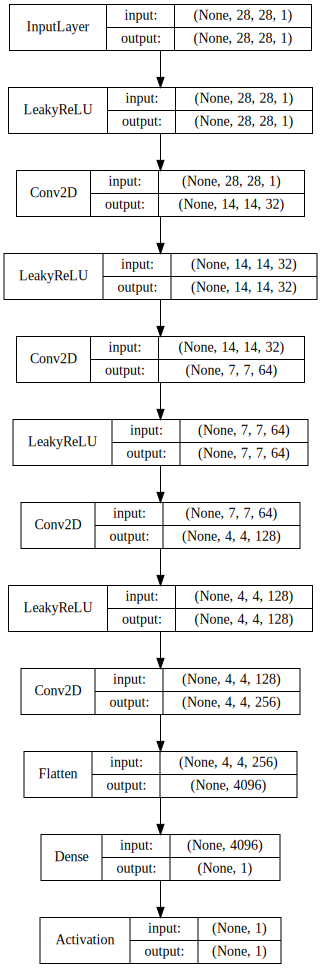

In [11]:
#  Display discriminator Model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_keras_model(model,show_shapes=True,show_layer_names=True):
    return SVG(model_to_dot(model,show_shapes=show_shapes,show_layer_names=show_layer_names).create(prog='dot',format='svg'))

plot_keras_model(discriminator, show_shapes=True, show_layer_names=False)

In [13]:
# build generator model
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')
generator = build_generator(inputs, image_size)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
__________

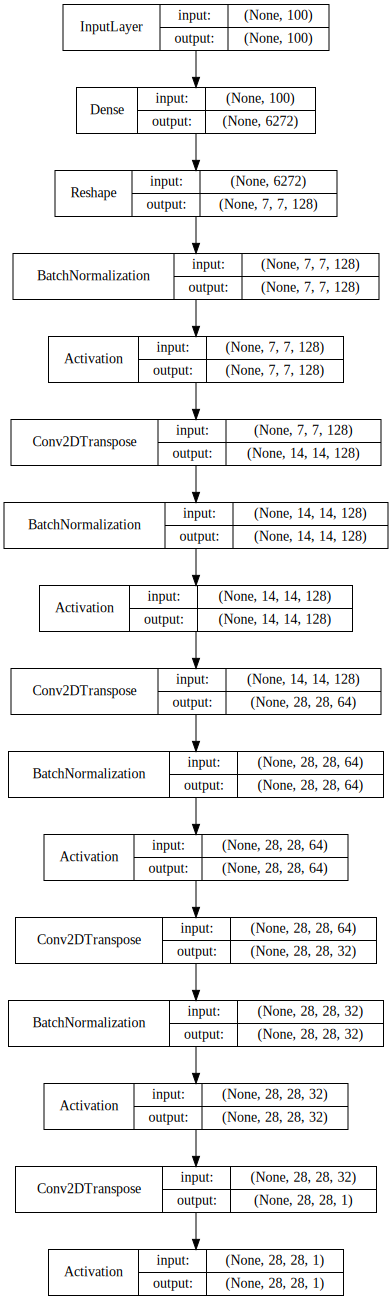

In [14]:
#  Display generator Model
plot_keras_model(generator, show_shapes=True, show_layer_names=False)

In [15]:
# build adversarial model

# freeze the weights of discriminator during adversarial training
discriminator.trainable = False

# adversarial = generator + discriminator
# inputs : latent vectors
adversarial = Model(inputs, 
                    discriminator(generator(inputs)),
                    name=model_name)
adversarial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         1301505   
_________________________________________________________________
discriminator (Model)        (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


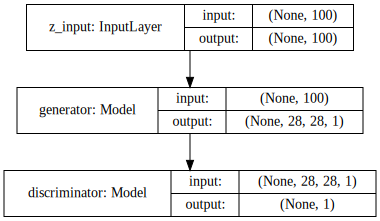

In [16]:
#  Display Model in Jupyter notebook
plot_keras_model(adversarial, show_shapes=True, show_layer_names=True)

In [14]:
optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
adversarial.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [discriminator loss: 0.694353, acc: 0.500000] [adversarial loss: 1.131313, acc: 0.000000]
1: [discriminator loss: 0.604461, acc: 0.507812] [adversarial loss: 1.409549, acc: 0.000000]
2: [discriminator loss: 0.483460, acc: 0.976562] [adversarial loss: 2.049055, acc: 0.000000]
3: [discriminator loss: 0.342702, acc: 0.968750] [adversarial loss: 1.404867, acc: 0.000000]
4: [discriminator loss: 0.262580, acc: 1.000000] [adversarial loss: 4.566052, acc: 0.000000]
5: [discriminator loss: 0.320121, acc: 0.835938] [adversarial loss: 1.795847, acc: 0.000000]
6: [discriminator loss: 0.128152, acc: 1.000000] [adversarial loss: 2.486201, acc: 0.000000]
7: [discriminator loss: 0.082105, acc: 1.000000] [adversarial loss: 1.931941, acc: 0.000000]
8: [discriminator loss: 0.053001, acc: 0.992188] [adversarial loss: 1.847832, acc: 0.000000]
9: [discriminator loss: 0.051198, acc: 0.992188] [adversarial loss: 1.173604, acc: 0.015625]
10: [discriminator loss: 0.033647, acc: 1.000000] [adversarial loss: 1

90: [discriminator loss: 0.570204, acc: 0.507812] [adversarial loss: 2.195454, acc: 0.000000]
91: [discriminator loss: 0.286086, acc: 0.945312] [adversarial loss: 1.607085, acc: 0.000000]
92: [discriminator loss: 0.264280, acc: 0.953125] [adversarial loss: 1.973060, acc: 0.000000]
93: [discriminator loss: 0.279334, acc: 0.968750] [adversarial loss: 1.704944, acc: 0.000000]
94: [discriminator loss: 0.308635, acc: 0.960938] [adversarial loss: 2.001107, acc: 0.000000]
95: [discriminator loss: 0.311436, acc: 0.976562] [adversarial loss: 1.615703, acc: 0.000000]
96: [discriminator loss: 0.315896, acc: 0.898438] [adversarial loss: 2.361559, acc: 0.000000]
97: [discriminator loss: 0.280537, acc: 0.976562] [adversarial loss: 1.388992, acc: 0.000000]
98: [discriminator loss: 0.371069, acc: 0.820312] [adversarial loss: 2.920920, acc: 0.000000]
99: [discriminator loss: 0.453019, acc: 0.812500] [adversarial loss: 0.428960, acc: 0.937500]
100: [discriminator loss: 0.659328, acc: 0.515625] [adversar

177: [discriminator loss: 0.499377, acc: 0.703125] [adversarial loss: 1.443484, acc: 0.000000]
178: [discriminator loss: 0.490901, acc: 0.742188] [adversarial loss: 0.519435, acc: 0.765625]
179: [discriminator loss: 0.551075, acc: 0.648438] [adversarial loss: 1.780230, acc: 0.000000]
180: [discriminator loss: 0.515832, acc: 0.703125] [adversarial loss: 0.529076, acc: 0.781250]
181: [discriminator loss: 0.550141, acc: 0.671875] [adversarial loss: 1.762439, acc: 0.000000]
182: [discriminator loss: 0.511748, acc: 0.695312] [adversarial loss: 0.457662, acc: 0.875000]
183: [discriminator loss: 0.561080, acc: 0.671875] [adversarial loss: 1.686288, acc: 0.000000]
184: [discriminator loss: 0.536673, acc: 0.695312] [adversarial loss: 0.522819, acc: 0.781250]
185: [discriminator loss: 0.558305, acc: 0.648438] [adversarial loss: 1.480999, acc: 0.000000]
186: [discriminator loss: 0.508638, acc: 0.734375] [adversarial loss: 0.566600, acc: 0.765625]
187: [discriminator loss: 0.587503, acc: 0.625000]

265: [discriminator loss: 0.586424, acc: 0.710938] [adversarial loss: 0.955203, acc: 0.187500]
266: [discriminator loss: 0.610101, acc: 0.664062] [adversarial loss: 0.974269, acc: 0.109375]
267: [discriminator loss: 0.539199, acc: 0.796875] [adversarial loss: 0.828223, acc: 0.296875]
268: [discriminator loss: 0.535204, acc: 0.742188] [adversarial loss: 1.575963, acc: 0.000000]
269: [discriminator loss: 0.569483, acc: 0.695312] [adversarial loss: 0.338486, acc: 1.000000]
270: [discriminator loss: 0.811745, acc: 0.507812] [adversarial loss: 2.146143, acc: 0.000000]
271: [discriminator loss: 0.818118, acc: 0.539062] [adversarial loss: 0.789731, acc: 0.359375]
272: [discriminator loss: 0.584410, acc: 0.703125] [adversarial loss: 1.017028, acc: 0.125000]
273: [discriminator loss: 0.582298, acc: 0.718750] [adversarial loss: 0.859026, acc: 0.359375]
274: [discriminator loss: 0.539978, acc: 0.765625] [adversarial loss: 1.033065, acc: 0.140625]
275: [discriminator loss: 0.544662, acc: 0.781250]

357: [discriminator loss: 0.695210, acc: 0.578125] [adversarial loss: 0.672683, acc: 0.562500]
358: [discriminator loss: 0.572528, acc: 0.687500] [adversarial loss: 1.053521, acc: 0.046875]
359: [discriminator loss: 0.547272, acc: 0.734375] [adversarial loss: 0.824624, acc: 0.312500]
360: [discriminator loss: 0.568412, acc: 0.718750] [adversarial loss: 1.109489, acc: 0.093750]
361: [discriminator loss: 0.578473, acc: 0.703125] [adversarial loss: 0.740249, acc: 0.468750]
362: [discriminator loss: 0.563162, acc: 0.695312] [adversarial loss: 1.251156, acc: 0.062500]
363: [discriminator loss: 0.554390, acc: 0.726562] [adversarial loss: 0.687731, acc: 0.515625]
364: [discriminator loss: 0.537495, acc: 0.750000] [adversarial loss: 0.990628, acc: 0.156250]
365: [discriminator loss: 0.593073, acc: 0.679688] [adversarial loss: 0.570478, acc: 0.734375]
366: [discriminator loss: 0.624444, acc: 0.640625] [adversarial loss: 1.552738, acc: 0.000000]
367: [discriminator loss: 0.661562, acc: 0.578125]

446: [discriminator loss: 0.575760, acc: 0.625000] [adversarial loss: 1.623821, acc: 0.000000]
447: [discriminator loss: 0.644211, acc: 0.609375] [adversarial loss: 0.630177, acc: 0.625000]
448: [discriminator loss: 0.599038, acc: 0.625000] [adversarial loss: 1.398424, acc: 0.015625]
449: [discriminator loss: 0.558911, acc: 0.679688] [adversarial loss: 0.577384, acc: 0.671875]
450: [discriminator loss: 0.561662, acc: 0.710938] [adversarial loss: 1.090781, acc: 0.015625]
451: [discriminator loss: 0.520354, acc: 0.789062] [adversarial loss: 0.879995, acc: 0.234375]
452: [discriminator loss: 0.520754, acc: 0.773438] [adversarial loss: 1.029325, acc: 0.078125]
453: [discriminator loss: 0.540517, acc: 0.726562] [adversarial loss: 0.770758, acc: 0.406250]
454: [discriminator loss: 0.543176, acc: 0.734375] [adversarial loss: 1.421878, acc: 0.000000]
455: [discriminator loss: 0.550899, acc: 0.703125] [adversarial loss: 0.635672, acc: 0.640625]
456: [discriminator loss: 0.564798, acc: 0.687500]

535: [discriminator loss: 0.512121, acc: 0.726562] [adversarial loss: 0.789635, acc: 0.468750]
536: [discriminator loss: 0.484989, acc: 0.812500] [adversarial loss: 1.212644, acc: 0.140625]
537: [discriminator loss: 0.437366, acc: 0.859375] [adversarial loss: 0.798758, acc: 0.515625]
538: [discriminator loss: 0.487124, acc: 0.789062] [adversarial loss: 1.685732, acc: 0.046875]
539: [discriminator loss: 0.517527, acc: 0.726562] [adversarial loss: 0.766163, acc: 0.531250]
540: [discriminator loss: 0.523930, acc: 0.710938] [adversarial loss: 1.477161, acc: 0.015625]
541: [discriminator loss: 0.569796, acc: 0.617188] [adversarial loss: 0.552039, acc: 0.671875]
542: [discriminator loss: 0.615150, acc: 0.625000] [adversarial loss: 2.060744, acc: 0.015625]
543: [discriminator loss: 0.606865, acc: 0.640625] [adversarial loss: 0.791241, acc: 0.375000]
544: [discriminator loss: 0.524280, acc: 0.710938] [adversarial loss: 1.230008, acc: 0.062500]
545: [discriminator loss: 0.540095, acc: 0.710938]

626: [discriminator loss: 0.555274, acc: 0.726562] [adversarial loss: 0.878365, acc: 0.343750]
627: [discriminator loss: 0.489123, acc: 0.765625] [adversarial loss: 1.306355, acc: 0.062500]
628: [discriminator loss: 0.514411, acc: 0.773438] [adversarial loss: 0.915723, acc: 0.328125]
629: [discriminator loss: 0.532675, acc: 0.734375] [adversarial loss: 1.280018, acc: 0.078125]
630: [discriminator loss: 0.497889, acc: 0.781250] [adversarial loss: 0.707459, acc: 0.562500]
631: [discriminator loss: 0.547190, acc: 0.664062] [adversarial loss: 1.885786, acc: 0.015625]
632: [discriminator loss: 0.670109, acc: 0.625000] [adversarial loss: 0.688150, acc: 0.562500]
633: [discriminator loss: 0.545318, acc: 0.695312] [adversarial loss: 1.560704, acc: 0.000000]
634: [discriminator loss: 0.532307, acc: 0.718750] [adversarial loss: 0.903601, acc: 0.328125]
635: [discriminator loss: 0.459304, acc: 0.804688] [adversarial loss: 1.406108, acc: 0.078125]
636: [discriminator loss: 0.461613, acc: 0.796875]

717: [discriminator loss: 0.549263, acc: 0.703125] [adversarial loss: 1.621265, acc: 0.000000]
718: [discriminator loss: 0.619734, acc: 0.679688] [adversarial loss: 0.795021, acc: 0.406250]
719: [discriminator loss: 0.536674, acc: 0.718750] [adversarial loss: 1.546584, acc: 0.031250]
720: [discriminator loss: 0.472621, acc: 0.796875] [adversarial loss: 0.938430, acc: 0.390625]
721: [discriminator loss: 0.482192, acc: 0.812500] [adversarial loss: 1.475884, acc: 0.031250]
722: [discriminator loss: 0.532275, acc: 0.726562] [adversarial loss: 0.877697, acc: 0.375000]
723: [discriminator loss: 0.500865, acc: 0.703125] [adversarial loss: 1.308948, acc: 0.109375]
724: [discriminator loss: 0.514238, acc: 0.750000] [adversarial loss: 0.827039, acc: 0.359375]
725: [discriminator loss: 0.580761, acc: 0.687500] [adversarial loss: 1.815075, acc: 0.015625]
726: [discriminator loss: 0.560849, acc: 0.687500] [adversarial loss: 0.628442, acc: 0.609375]
727: [discriminator loss: 0.556786, acc: 0.687500]

808: [discriminator loss: 0.509385, acc: 0.710938] [adversarial loss: 1.255849, acc: 0.218750]
809: [discriminator loss: 0.499745, acc: 0.750000] [adversarial loss: 1.144482, acc: 0.218750]
810: [discriminator loss: 0.524324, acc: 0.695312] [adversarial loss: 1.593377, acc: 0.031250]
811: [discriminator loss: 0.548141, acc: 0.742188] [adversarial loss: 0.707762, acc: 0.546875]
812: [discriminator loss: 0.597147, acc: 0.671875] [adversarial loss: 1.782164, acc: 0.031250]
813: [discriminator loss: 0.617990, acc: 0.679688] [adversarial loss: 0.751539, acc: 0.546875]
814: [discriminator loss: 0.609849, acc: 0.617188] [adversarial loss: 1.644037, acc: 0.093750]
815: [discriminator loss: 0.593450, acc: 0.687500] [adversarial loss: 0.853484, acc: 0.421875]
816: [discriminator loss: 0.516653, acc: 0.757812] [adversarial loss: 1.536197, acc: 0.046875]
817: [discriminator loss: 0.566687, acc: 0.679688] [adversarial loss: 0.739186, acc: 0.453125]
818: [discriminator loss: 0.634255, acc: 0.625000]

899: [discriminator loss: 0.548165, acc: 0.710938] [adversarial loss: 0.558610, acc: 0.671875]
900: [discriminator loss: 0.579226, acc: 0.656250] [adversarial loss: 1.807571, acc: 0.015625]
901: [discriminator loss: 0.565407, acc: 0.703125] [adversarial loss: 0.842412, acc: 0.437500]
902: [discriminator loss: 0.542176, acc: 0.734375] [adversarial loss: 1.537409, acc: 0.031250]
903: [discriminator loss: 0.593248, acc: 0.679688] [adversarial loss: 0.785717, acc: 0.406250]
904: [discriminator loss: 0.591168, acc: 0.671875] [adversarial loss: 1.324359, acc: 0.109375]
905: [discriminator loss: 0.530384, acc: 0.765625] [adversarial loss: 0.882378, acc: 0.359375]
906: [discriminator loss: 0.496163, acc: 0.789062] [adversarial loss: 1.435669, acc: 0.078125]
907: [discriminator loss: 0.564109, acc: 0.718750] [adversarial loss: 0.811022, acc: 0.375000]
908: [discriminator loss: 0.545652, acc: 0.726562] [adversarial loss: 1.535858, acc: 0.031250]
909: [discriminator loss: 0.565811, acc: 0.726562]

990: [discriminator loss: 0.596726, acc: 0.695312] [adversarial loss: 1.142483, acc: 0.218750]
991: [discriminator loss: 0.521201, acc: 0.773438] [adversarial loss: 0.767552, acc: 0.562500]
992: [discriminator loss: 0.605586, acc: 0.718750] [adversarial loss: 1.902050, acc: 0.015625]
993: [discriminator loss: 0.621889, acc: 0.656250] [adversarial loss: 0.669386, acc: 0.593750]
994: [discriminator loss: 0.623243, acc: 0.625000] [adversarial loss: 2.033099, acc: 0.031250]
995: [discriminator loss: 0.648333, acc: 0.625000] [adversarial loss: 0.884998, acc: 0.343750]
996: [discriminator loss: 0.630109, acc: 0.695312] [adversarial loss: 1.450241, acc: 0.140625]
997: [discriminator loss: 0.564964, acc: 0.695312] [adversarial loss: 0.942150, acc: 0.265625]
998: [discriminator loss: 0.515131, acc: 0.734375] [adversarial loss: 1.381571, acc: 0.078125]
999: [discriminator loss: 0.417761, acc: 0.835938] [adversarial loss: 1.179856, acc: 0.203125]
1000: [discriminator loss: 0.534201, acc: 0.757812

1077: [discriminator loss: 0.569096, acc: 0.750000] [adversarial loss: 1.424434, acc: 0.187500]
1078: [discriminator loss: 0.563653, acc: 0.687500] [adversarial loss: 0.842241, acc: 0.468750]
1079: [discriminator loss: 0.562788, acc: 0.718750] [adversarial loss: 1.918514, acc: 0.031250]
1080: [discriminator loss: 0.593198, acc: 0.640625] [adversarial loss: 0.714413, acc: 0.625000]
1081: [discriminator loss: 0.627149, acc: 0.679688] [adversarial loss: 1.629329, acc: 0.062500]
1082: [discriminator loss: 0.516017, acc: 0.726562] [adversarial loss: 0.801161, acc: 0.437500]
1083: [discriminator loss: 0.542791, acc: 0.703125] [adversarial loss: 1.513324, acc: 0.156250]
1084: [discriminator loss: 0.497365, acc: 0.765625] [adversarial loss: 0.905469, acc: 0.390625]
1085: [discriminator loss: 0.569833, acc: 0.734375] [adversarial loss: 1.593607, acc: 0.093750]
1086: [discriminator loss: 0.547055, acc: 0.718750] [adversarial loss: 1.266236, acc: 0.218750]
1087: [discriminator loss: 0.500150, acc

1168: [discriminator loss: 0.567613, acc: 0.734375] [adversarial loss: 1.293727, acc: 0.140625]
1169: [discriminator loss: 0.515320, acc: 0.773438] [adversarial loss: 1.080456, acc: 0.250000]
1170: [discriminator loss: 0.520380, acc: 0.765625] [adversarial loss: 1.596809, acc: 0.109375]
1171: [discriminator loss: 0.461091, acc: 0.812500] [adversarial loss: 0.797332, acc: 0.484375]
1172: [discriminator loss: 0.541159, acc: 0.703125] [adversarial loss: 1.776335, acc: 0.015625]
1173: [discriminator loss: 0.545199, acc: 0.687500] [adversarial loss: 0.684197, acc: 0.625000]
1174: [discriminator loss: 0.600584, acc: 0.664062] [adversarial loss: 1.648314, acc: 0.031250]
1175: [discriminator loss: 0.503187, acc: 0.718750] [adversarial loss: 0.828058, acc: 0.468750]
1176: [discriminator loss: 0.533043, acc: 0.750000] [adversarial loss: 1.744887, acc: 0.078125]
1177: [discriminator loss: 0.474631, acc: 0.742188] [adversarial loss: 1.157097, acc: 0.203125]
1178: [discriminator loss: 0.504089, acc

1259: [discriminator loss: 0.480886, acc: 0.765625] [adversarial loss: 1.006530, acc: 0.343750]
1260: [discriminator loss: 0.495760, acc: 0.765625] [adversarial loss: 1.283438, acc: 0.203125]
1261: [discriminator loss: 0.480559, acc: 0.750000] [adversarial loss: 1.180897, acc: 0.156250]
1262: [discriminator loss: 0.425343, acc: 0.828125] [adversarial loss: 1.364998, acc: 0.125000]
1263: [discriminator loss: 0.466419, acc: 0.781250] [adversarial loss: 1.180101, acc: 0.265625]
1264: [discriminator loss: 0.511854, acc: 0.757812] [adversarial loss: 1.596344, acc: 0.062500]
1265: [discriminator loss: 0.477913, acc: 0.750000] [adversarial loss: 0.807179, acc: 0.468750]
1266: [discriminator loss: 0.556971, acc: 0.687500] [adversarial loss: 1.716588, acc: 0.046875]
1267: [discriminator loss: 0.523298, acc: 0.742188] [adversarial loss: 0.640119, acc: 0.625000]
1268: [discriminator loss: 0.595011, acc: 0.695312] [adversarial loss: 1.715762, acc: 0.140625]
1269: [discriminator loss: 0.550095, acc

1350: [discriminator loss: 0.612544, acc: 0.671875] [adversarial loss: 1.089931, acc: 0.265625]
1351: [discriminator loss: 0.496741, acc: 0.757812] [adversarial loss: 1.353290, acc: 0.140625]
1352: [discriminator loss: 0.530237, acc: 0.726562] [adversarial loss: 0.997010, acc: 0.250000]
1353: [discriminator loss: 0.541226, acc: 0.750000] [adversarial loss: 1.129537, acc: 0.234375]
1354: [discriminator loss: 0.489610, acc: 0.750000] [adversarial loss: 1.176248, acc: 0.140625]
1355: [discriminator loss: 0.437250, acc: 0.804688] [adversarial loss: 1.321951, acc: 0.109375]
1356: [discriminator loss: 0.536076, acc: 0.765625] [adversarial loss: 1.248337, acc: 0.140625]
1357: [discriminator loss: 0.522310, acc: 0.734375] [adversarial loss: 1.141887, acc: 0.265625]
1358: [discriminator loss: 0.541461, acc: 0.750000] [adversarial loss: 1.369279, acc: 0.234375]
1359: [discriminator loss: 0.464885, acc: 0.804688] [adversarial loss: 1.159023, acc: 0.187500]
1360: [discriminator loss: 0.631267, acc

1438: [discriminator loss: 0.578092, acc: 0.664062] [adversarial loss: 0.737279, acc: 0.515625]
1439: [discriminator loss: 0.531054, acc: 0.710938] [adversarial loss: 1.866300, acc: 0.000000]
1440: [discriminator loss: 0.581375, acc: 0.656250] [adversarial loss: 0.887422, acc: 0.375000]
1441: [discriminator loss: 0.596456, acc: 0.609375] [adversarial loss: 1.651313, acc: 0.046875]
1442: [discriminator loss: 0.555716, acc: 0.710938] [adversarial loss: 0.931586, acc: 0.343750]
1443: [discriminator loss: 0.510669, acc: 0.765625] [adversarial loss: 1.322250, acc: 0.109375]
1444: [discriminator loss: 0.441933, acc: 0.812500] [adversarial loss: 1.175915, acc: 0.187500]
1445: [discriminator loss: 0.508041, acc: 0.757812] [adversarial loss: 1.168531, acc: 0.265625]
1446: [discriminator loss: 0.424121, acc: 0.820312] [adversarial loss: 1.107823, acc: 0.359375]
1447: [discriminator loss: 0.565486, acc: 0.703125] [adversarial loss: 1.097843, acc: 0.390625]
1448: [discriminator loss: 0.488062, acc

1525: [discriminator loss: 0.455847, acc: 0.781250] [adversarial loss: 1.210882, acc: 0.265625]
1526: [discriminator loss: 0.591856, acc: 0.617188] [adversarial loss: 1.658497, acc: 0.125000]
1527: [discriminator loss: 0.581869, acc: 0.664062] [adversarial loss: 1.130063, acc: 0.250000]
1528: [discriminator loss: 0.469886, acc: 0.757812] [adversarial loss: 1.310218, acc: 0.218750]
1529: [discriminator loss: 0.463765, acc: 0.789062] [adversarial loss: 1.474474, acc: 0.187500]
1530: [discriminator loss: 0.584083, acc: 0.726562] [adversarial loss: 1.188191, acc: 0.234375]
1531: [discriminator loss: 0.541404, acc: 0.750000] [adversarial loss: 1.168873, acc: 0.218750]
1532: [discriminator loss: 0.500337, acc: 0.781250] [adversarial loss: 1.076138, acc: 0.234375]
1533: [discriminator loss: 0.528049, acc: 0.703125] [adversarial loss: 1.713191, acc: 0.078125]
1534: [discriminator loss: 0.576737, acc: 0.695312] [adversarial loss: 0.986397, acc: 0.359375]
1535: [discriminator loss: 0.520194, acc

1613: [discriminator loss: 0.622682, acc: 0.648438] [adversarial loss: 0.662081, acc: 0.562500]
1614: [discriminator loss: 0.593234, acc: 0.648438] [adversarial loss: 2.032779, acc: 0.031250]
1615: [discriminator loss: 0.531788, acc: 0.718750] [adversarial loss: 0.950117, acc: 0.328125]
1616: [discriminator loss: 0.524404, acc: 0.703125] [adversarial loss: 1.231064, acc: 0.234375]
1617: [discriminator loss: 0.487114, acc: 0.757812] [adversarial loss: 1.041638, acc: 0.296875]
1618: [discriminator loss: 0.455697, acc: 0.789062] [adversarial loss: 1.161915, acc: 0.281250]
1619: [discriminator loss: 0.533082, acc: 0.773438] [adversarial loss: 1.266122, acc: 0.171875]
1620: [discriminator loss: 0.465998, acc: 0.750000] [adversarial loss: 1.058544, acc: 0.343750]
1621: [discriminator loss: 0.521910, acc: 0.710938] [adversarial loss: 1.384894, acc: 0.171875]
1622: [discriminator loss: 0.428184, acc: 0.843750] [adversarial loss: 1.203650, acc: 0.171875]
1623: [discriminator loss: 0.452238, acc

1701: [discriminator loss: 0.572050, acc: 0.726562] [adversarial loss: 2.133729, acc: 0.015625]
1702: [discriminator loss: 0.496524, acc: 0.757812] [adversarial loss: 1.264160, acc: 0.203125]
1703: [discriminator loss: 0.517383, acc: 0.750000] [adversarial loss: 1.341717, acc: 0.156250]
1704: [discriminator loss: 0.462075, acc: 0.796875] [adversarial loss: 1.214903, acc: 0.156250]
1705: [discriminator loss: 0.546763, acc: 0.734375] [adversarial loss: 1.172482, acc: 0.234375]
1706: [discriminator loss: 0.525910, acc: 0.757812] [adversarial loss: 1.562788, acc: 0.109375]
1707: [discriminator loss: 0.484270, acc: 0.773438] [adversarial loss: 1.225088, acc: 0.218750]
1708: [discriminator loss: 0.500979, acc: 0.734375] [adversarial loss: 1.560204, acc: 0.046875]
1709: [discriminator loss: 0.544922, acc: 0.726562] [adversarial loss: 1.249652, acc: 0.218750]
1710: [discriminator loss: 0.568176, acc: 0.718750] [adversarial loss: 1.373927, acc: 0.171875]
1711: [discriminator loss: 0.466938, acc

1791: [discriminator loss: 0.502456, acc: 0.742188] [adversarial loss: 1.077417, acc: 0.281250]
1792: [discriminator loss: 0.458926, acc: 0.757812] [adversarial loss: 1.247191, acc: 0.203125]
1793: [discriminator loss: 0.404851, acc: 0.812500] [adversarial loss: 1.288097, acc: 0.218750]
1794: [discriminator loss: 0.567622, acc: 0.726562] [adversarial loss: 1.264007, acc: 0.234375]
1795: [discriminator loss: 0.502307, acc: 0.710938] [adversarial loss: 1.264726, acc: 0.203125]
1796: [discriminator loss: 0.448345, acc: 0.804688] [adversarial loss: 1.693754, acc: 0.062500]
1797: [discriminator loss: 0.519514, acc: 0.757812] [adversarial loss: 1.266408, acc: 0.156250]
1798: [discriminator loss: 0.461105, acc: 0.804688] [adversarial loss: 1.140490, acc: 0.281250]
1799: [discriminator loss: 0.521524, acc: 0.742188] [adversarial loss: 1.089369, acc: 0.375000]
1800: [discriminator loss: 0.464174, acc: 0.796875] [adversarial loss: 1.207223, acc: 0.203125]
1801: [discriminator loss: 0.497161, acc

1879: [discriminator loss: 0.564708, acc: 0.710938] [adversarial loss: 0.633735, acc: 0.625000]
1880: [discriminator loss: 0.620864, acc: 0.648438] [adversarial loss: 2.107969, acc: 0.015625]
1881: [discriminator loss: 0.687274, acc: 0.656250] [adversarial loss: 0.807574, acc: 0.500000]
1882: [discriminator loss: 0.503205, acc: 0.789062] [adversarial loss: 1.641560, acc: 0.078125]
1883: [discriminator loss: 0.493772, acc: 0.750000] [adversarial loss: 1.371551, acc: 0.156250]
1884: [discriminator loss: 0.494901, acc: 0.742188] [adversarial loss: 1.467582, acc: 0.140625]
1885: [discriminator loss: 0.500901, acc: 0.750000] [adversarial loss: 1.001761, acc: 0.296875]
1886: [discriminator loss: 0.537117, acc: 0.757812] [adversarial loss: 1.493316, acc: 0.171875]
1887: [discriminator loss: 0.504935, acc: 0.765625] [adversarial loss: 1.039966, acc: 0.343750]
1888: [discriminator loss: 0.488149, acc: 0.789062] [adversarial loss: 1.405515, acc: 0.171875]
1889: [discriminator loss: 0.465753, acc

1967: [discriminator loss: 0.498108, acc: 0.796875] [adversarial loss: 1.438246, acc: 0.171875]
1968: [discriminator loss: 0.505645, acc: 0.734375] [adversarial loss: 1.134205, acc: 0.250000]
1969: [discriminator loss: 0.481111, acc: 0.765625] [adversarial loss: 1.667711, acc: 0.046875]
1970: [discriminator loss: 0.545369, acc: 0.718750] [adversarial loss: 1.150174, acc: 0.187500]
1971: [discriminator loss: 0.490419, acc: 0.796875] [adversarial loss: 1.782159, acc: 0.125000]
1972: [discriminator loss: 0.621071, acc: 0.679688] [adversarial loss: 0.898905, acc: 0.375000]
1973: [discriminator loss: 0.503752, acc: 0.757812] [adversarial loss: 1.639824, acc: 0.187500]
1974: [discriminator loss: 0.482864, acc: 0.757812] [adversarial loss: 1.147116, acc: 0.296875]
1975: [discriminator loss: 0.550550, acc: 0.710938] [adversarial loss: 1.381073, acc: 0.140625]
1976: [discriminator loss: 0.604160, acc: 0.703125] [adversarial loss: 1.035599, acc: 0.359375]
1977: [discriminator loss: 0.490709, acc

2056: [discriminator loss: 0.461602, acc: 0.750000] [adversarial loss: 0.919500, acc: 0.328125]
2057: [discriminator loss: 0.571470, acc: 0.718750] [adversarial loss: 1.808167, acc: 0.125000]
2058: [discriminator loss: 0.635754, acc: 0.718750] [adversarial loss: 0.780455, acc: 0.578125]
2059: [discriminator loss: 0.502626, acc: 0.703125] [adversarial loss: 1.878392, acc: 0.078125]
2060: [discriminator loss: 0.589249, acc: 0.726562] [adversarial loss: 0.914924, acc: 0.437500]
2061: [discriminator loss: 0.535271, acc: 0.679688] [adversarial loss: 1.670960, acc: 0.093750]
2062: [discriminator loss: 0.581164, acc: 0.687500] [adversarial loss: 0.965188, acc: 0.375000]
2063: [discriminator loss: 0.497561, acc: 0.773438] [adversarial loss: 1.602488, acc: 0.125000]
2064: [discriminator loss: 0.478007, acc: 0.773438] [adversarial loss: 1.109135, acc: 0.250000]
2065: [discriminator loss: 0.582067, acc: 0.671875] [adversarial loss: 1.429273, acc: 0.140625]
2066: [discriminator loss: 0.414907, acc

2147: [discriminator loss: 0.510171, acc: 0.726562] [adversarial loss: 1.617919, acc: 0.187500]
2148: [discriminator loss: 0.540613, acc: 0.703125] [adversarial loss: 1.143082, acc: 0.359375]
2149: [discriminator loss: 0.512134, acc: 0.710938] [adversarial loss: 1.590420, acc: 0.125000]
2150: [discriminator loss: 0.535608, acc: 0.742188] [adversarial loss: 1.079309, acc: 0.281250]
2151: [discriminator loss: 0.466373, acc: 0.742188] [adversarial loss: 1.438435, acc: 0.187500]
2152: [discriminator loss: 0.508578, acc: 0.765625] [adversarial loss: 1.339833, acc: 0.171875]
2153: [discriminator loss: 0.531747, acc: 0.742188] [adversarial loss: 1.196203, acc: 0.250000]
2154: [discriminator loss: 0.535921, acc: 0.718750] [adversarial loss: 1.822715, acc: 0.046875]
2155: [discriminator loss: 0.549646, acc: 0.718750] [adversarial loss: 0.642508, acc: 0.640625]
2156: [discriminator loss: 0.635676, acc: 0.656250] [adversarial loss: 1.616178, acc: 0.078125]
2157: [discriminator loss: 0.498295, acc

2238: [discriminator loss: 0.484684, acc: 0.781250] [adversarial loss: 1.519344, acc: 0.171875]
2239: [discriminator loss: 0.490986, acc: 0.757812] [adversarial loss: 0.952121, acc: 0.406250]
2240: [discriminator loss: 0.504744, acc: 0.757812] [adversarial loss: 1.363703, acc: 0.218750]
2241: [discriminator loss: 0.558646, acc: 0.695312] [adversarial loss: 1.059819, acc: 0.375000]
2242: [discriminator loss: 0.480030, acc: 0.789062] [adversarial loss: 1.264858, acc: 0.203125]
2243: [discriminator loss: 0.481707, acc: 0.781250] [adversarial loss: 0.967761, acc: 0.500000]
2244: [discriminator loss: 0.576892, acc: 0.656250] [adversarial loss: 2.217824, acc: 0.046875]
2245: [discriminator loss: 0.585258, acc: 0.710938] [adversarial loss: 1.047032, acc: 0.281250]
2246: [discriminator loss: 0.615361, acc: 0.734375] [adversarial loss: 1.968539, acc: 0.046875]
2247: [discriminator loss: 0.565023, acc: 0.734375] [adversarial loss: 0.919840, acc: 0.406250]
2248: [discriminator loss: 0.603607, acc

2329: [discriminator loss: 0.616838, acc: 0.656250] [adversarial loss: 1.486273, acc: 0.203125]
2330: [discriminator loss: 0.542578, acc: 0.773438] [adversarial loss: 1.133722, acc: 0.234375]
2331: [discriminator loss: 0.522668, acc: 0.750000] [adversarial loss: 1.478674, acc: 0.078125]
2332: [discriminator loss: 0.510119, acc: 0.750000] [adversarial loss: 1.274031, acc: 0.140625]
2333: [discriminator loss: 0.427702, acc: 0.804688] [adversarial loss: 1.469891, acc: 0.203125]
2334: [discriminator loss: 0.526976, acc: 0.742188] [adversarial loss: 1.011437, acc: 0.328125]
2335: [discriminator loss: 0.468708, acc: 0.773438] [adversarial loss: 1.675068, acc: 0.093750]
2336: [discriminator loss: 0.520288, acc: 0.757812] [adversarial loss: 0.846551, acc: 0.437500]
2337: [discriminator loss: 0.545986, acc: 0.695312] [adversarial loss: 1.765738, acc: 0.046875]
2338: [discriminator loss: 0.520456, acc: 0.765625] [adversarial loss: 0.804127, acc: 0.437500]
2339: [discriminator loss: 0.601718, acc

2420: [discriminator loss: 0.489814, acc: 0.796875] [adversarial loss: 1.716670, acc: 0.062500]
2421: [discriminator loss: 0.470555, acc: 0.765625] [adversarial loss: 0.991216, acc: 0.296875]
2422: [discriminator loss: 0.511805, acc: 0.773438] [adversarial loss: 1.451671, acc: 0.156250]
2423: [discriminator loss: 0.515516, acc: 0.750000] [adversarial loss: 1.054707, acc: 0.359375]
2424: [discriminator loss: 0.477372, acc: 0.820312] [adversarial loss: 1.517564, acc: 0.156250]
2425: [discriminator loss: 0.514151, acc: 0.781250] [adversarial loss: 1.482813, acc: 0.171875]
2426: [discriminator loss: 0.551390, acc: 0.734375] [adversarial loss: 1.301367, acc: 0.187500]
2427: [discriminator loss: 0.564453, acc: 0.695312] [adversarial loss: 1.126181, acc: 0.296875]
2428: [discriminator loss: 0.533676, acc: 0.789062] [adversarial loss: 1.502113, acc: 0.125000]
2429: [discriminator loss: 0.472543, acc: 0.781250] [adversarial loss: 0.864237, acc: 0.453125]
2430: [discriminator loss: 0.588028, acc

2507: [discriminator loss: 0.556211, acc: 0.718750] [adversarial loss: 1.248870, acc: 0.187500]
2508: [discriminator loss: 0.479181, acc: 0.765625] [adversarial loss: 1.252448, acc: 0.218750]
2509: [discriminator loss: 0.455091, acc: 0.812500] [adversarial loss: 1.527062, acc: 0.140625]
2510: [discriminator loss: 0.558669, acc: 0.679688] [adversarial loss: 0.997802, acc: 0.328125]
2511: [discriminator loss: 0.539466, acc: 0.726562] [adversarial loss: 1.756415, acc: 0.062500]
2512: [discriminator loss: 0.569737, acc: 0.679688] [adversarial loss: 1.162536, acc: 0.218750]
2513: [discriminator loss: 0.547336, acc: 0.742188] [adversarial loss: 1.430016, acc: 0.156250]
2514: [discriminator loss: 0.535501, acc: 0.710938] [adversarial loss: 1.197765, acc: 0.312500]
2515: [discriminator loss: 0.509783, acc: 0.734375] [adversarial loss: 1.612507, acc: 0.093750]
2516: [discriminator loss: 0.527042, acc: 0.703125] [adversarial loss: 0.874292, acc: 0.437500]
2517: [discriminator loss: 0.534544, acc

2598: [discriminator loss: 0.519421, acc: 0.726562] [adversarial loss: 0.889649, acc: 0.328125]
2599: [discriminator loss: 0.573749, acc: 0.664062] [adversarial loss: 1.697722, acc: 0.140625]
2600: [discriminator loss: 0.556734, acc: 0.710938] [adversarial loss: 1.049993, acc: 0.203125]
2601: [discriminator loss: 0.500347, acc: 0.789062] [adversarial loss: 1.479027, acc: 0.031250]
2602: [discriminator loss: 0.454141, acc: 0.765625] [adversarial loss: 1.223004, acc: 0.250000]
2603: [discriminator loss: 0.542579, acc: 0.695312] [adversarial loss: 1.376127, acc: 0.109375]
2604: [discriminator loss: 0.522686, acc: 0.750000] [adversarial loss: 1.008028, acc: 0.343750]
2605: [discriminator loss: 0.534090, acc: 0.750000] [adversarial loss: 1.353500, acc: 0.171875]
2606: [discriminator loss: 0.531759, acc: 0.718750] [adversarial loss: 1.345412, acc: 0.250000]
2607: [discriminator loss: 0.441769, acc: 0.828125] [adversarial loss: 1.294728, acc: 0.156250]
2608: [discriminator loss: 0.485788, acc

2689: [discriminator loss: 0.567324, acc: 0.718750] [adversarial loss: 1.511584, acc: 0.156250]
2690: [discriminator loss: 0.557188, acc: 0.718750] [adversarial loss: 1.271221, acc: 0.234375]
2691: [discriminator loss: 0.421239, acc: 0.796875] [adversarial loss: 1.052374, acc: 0.265625]
2692: [discriminator loss: 0.461421, acc: 0.812500] [adversarial loss: 1.583383, acc: 0.109375]
2693: [discriminator loss: 0.560074, acc: 0.679688] [adversarial loss: 1.414175, acc: 0.140625]
2694: [discriminator loss: 0.459728, acc: 0.781250] [adversarial loss: 1.187209, acc: 0.234375]
2695: [discriminator loss: 0.490848, acc: 0.757812] [adversarial loss: 1.259827, acc: 0.156250]
2696: [discriminator loss: 0.447703, acc: 0.781250] [adversarial loss: 1.876208, acc: 0.015625]
2697: [discriminator loss: 0.560116, acc: 0.687500] [adversarial loss: 0.754465, acc: 0.562500]
2698: [discriminator loss: 0.585534, acc: 0.664062] [adversarial loss: 2.091501, acc: 0.031250]
2699: [discriminator loss: 0.591491, acc

2780: [discriminator loss: 0.485060, acc: 0.757812] [adversarial loss: 1.493350, acc: 0.109375]
2781: [discriminator loss: 0.512804, acc: 0.718750] [adversarial loss: 0.970454, acc: 0.343750]
2782: [discriminator loss: 0.524537, acc: 0.765625] [adversarial loss: 1.836967, acc: 0.046875]
2783: [discriminator loss: 0.583664, acc: 0.710938] [adversarial loss: 0.846752, acc: 0.453125]
2784: [discriminator loss: 0.519530, acc: 0.718750] [adversarial loss: 1.932345, acc: 0.031250]
2785: [discriminator loss: 0.625092, acc: 0.687500] [adversarial loss: 0.820453, acc: 0.515625]
2786: [discriminator loss: 0.546913, acc: 0.703125] [adversarial loss: 1.613203, acc: 0.140625]
2787: [discriminator loss: 0.567329, acc: 0.718750] [adversarial loss: 0.980730, acc: 0.296875]
2788: [discriminator loss: 0.512525, acc: 0.773438] [adversarial loss: 1.461806, acc: 0.187500]
2789: [discriminator loss: 0.466502, acc: 0.773438] [adversarial loss: 1.224737, acc: 0.281250]
2790: [discriminator loss: 0.468682, acc

2871: [discriminator loss: 0.542823, acc: 0.718750] [adversarial loss: 1.091115, acc: 0.281250]
2872: [discriminator loss: 0.536813, acc: 0.710938] [adversarial loss: 1.836901, acc: 0.046875]
2873: [discriminator loss: 0.565349, acc: 0.695312] [adversarial loss: 0.979800, acc: 0.296875]
2874: [discriminator loss: 0.590366, acc: 0.710938] [adversarial loss: 1.774228, acc: 0.046875]
2875: [discriminator loss: 0.572547, acc: 0.710938] [adversarial loss: 0.890597, acc: 0.468750]
2876: [discriminator loss: 0.603299, acc: 0.679688] [adversarial loss: 1.824957, acc: 0.046875]
2877: [discriminator loss: 0.590871, acc: 0.687500] [adversarial loss: 0.957602, acc: 0.375000]
2878: [discriminator loss: 0.496598, acc: 0.781250] [adversarial loss: 1.279380, acc: 0.234375]
2879: [discriminator loss: 0.525793, acc: 0.726562] [adversarial loss: 1.055612, acc: 0.390625]
2880: [discriminator loss: 0.498367, acc: 0.820312] [adversarial loss: 1.561637, acc: 0.156250]
2881: [discriminator loss: 0.502274, acc

2962: [discriminator loss: 0.468791, acc: 0.734375] [adversarial loss: 1.352203, acc: 0.203125]
2963: [discriminator loss: 0.517713, acc: 0.796875] [adversarial loss: 1.462625, acc: 0.078125]
2964: [discriminator loss: 0.520804, acc: 0.757812] [adversarial loss: 1.131192, acc: 0.265625]
2965: [discriminator loss: 0.514611, acc: 0.718750] [adversarial loss: 1.675161, acc: 0.140625]
2966: [discriminator loss: 0.593169, acc: 0.726562] [adversarial loss: 0.791874, acc: 0.515625]
2967: [discriminator loss: 0.617060, acc: 0.648438] [adversarial loss: 1.969291, acc: 0.015625]
2968: [discriminator loss: 0.622930, acc: 0.648438] [adversarial loss: 1.095749, acc: 0.250000]
2969: [discriminator loss: 0.567189, acc: 0.695312] [adversarial loss: 1.647338, acc: 0.015625]
2970: [discriminator loss: 0.504239, acc: 0.757812] [adversarial loss: 1.294406, acc: 0.203125]
2971: [discriminator loss: 0.465353, acc: 0.812500] [adversarial loss: 1.304029, acc: 0.171875]
2972: [discriminator loss: 0.498057, acc

3049: [discriminator loss: 0.425896, acc: 0.843750] [adversarial loss: 1.419005, acc: 0.156250]
3050: [discriminator loss: 0.519164, acc: 0.734375] [adversarial loss: 1.353611, acc: 0.171875]
3051: [discriminator loss: 0.522846, acc: 0.757812] [adversarial loss: 1.072517, acc: 0.296875]
3052: [discriminator loss: 0.463699, acc: 0.781250] [adversarial loss: 1.580047, acc: 0.125000]
3053: [discriminator loss: 0.470004, acc: 0.765625] [adversarial loss: 0.957766, acc: 0.343750]
3054: [discriminator loss: 0.584870, acc: 0.703125] [adversarial loss: 1.312655, acc: 0.171875]
3055: [discriminator loss: 0.428577, acc: 0.820312] [adversarial loss: 1.074799, acc: 0.453125]
3056: [discriminator loss: 0.547564, acc: 0.703125] [adversarial loss: 1.652065, acc: 0.125000]
3057: [discriminator loss: 0.546966, acc: 0.718750] [adversarial loss: 1.151086, acc: 0.203125]
3058: [discriminator loss: 0.497410, acc: 0.781250] [adversarial loss: 1.279347, acc: 0.203125]
3059: [discriminator loss: 0.559408, acc

3140: [discriminator loss: 0.503996, acc: 0.773438] [adversarial loss: 1.220531, acc: 0.218750]
3141: [discriminator loss: 0.458765, acc: 0.812500] [adversarial loss: 1.316363, acc: 0.187500]
3142: [discriminator loss: 0.553507, acc: 0.750000] [adversarial loss: 1.085941, acc: 0.359375]
3143: [discriminator loss: 0.530082, acc: 0.757812] [adversarial loss: 1.410531, acc: 0.203125]
3144: [discriminator loss: 0.577720, acc: 0.710938] [adversarial loss: 0.986771, acc: 0.390625]
3145: [discriminator loss: 0.528452, acc: 0.750000] [adversarial loss: 1.615438, acc: 0.125000]
3146: [discriminator loss: 0.491616, acc: 0.750000] [adversarial loss: 1.047549, acc: 0.312500]
3147: [discriminator loss: 0.559428, acc: 0.734375] [adversarial loss: 1.471214, acc: 0.140625]
3148: [discriminator loss: 0.472459, acc: 0.796875] [adversarial loss: 1.029496, acc: 0.281250]
3149: [discriminator loss: 0.493318, acc: 0.765625] [adversarial loss: 1.208485, acc: 0.296875]
3150: [discriminator loss: 0.504228, acc

3231: [discriminator loss: 0.553314, acc: 0.726562] [adversarial loss: 0.927840, acc: 0.406250]
3232: [discriminator loss: 0.515982, acc: 0.750000] [adversarial loss: 1.453304, acc: 0.156250]
3233: [discriminator loss: 0.577245, acc: 0.734375] [adversarial loss: 1.023519, acc: 0.312500]
3234: [discriminator loss: 0.450006, acc: 0.765625] [adversarial loss: 1.167354, acc: 0.140625]
3235: [discriminator loss: 0.510494, acc: 0.710938] [adversarial loss: 1.220374, acc: 0.171875]
3236: [discriminator loss: 0.518846, acc: 0.750000] [adversarial loss: 1.464635, acc: 0.109375]
3237: [discriminator loss: 0.453140, acc: 0.804688] [adversarial loss: 1.567262, acc: 0.156250]
3238: [discriminator loss: 0.511288, acc: 0.726562] [adversarial loss: 1.002376, acc: 0.296875]
3239: [discriminator loss: 0.502989, acc: 0.757812] [adversarial loss: 1.394424, acc: 0.140625]
3240: [discriminator loss: 0.523091, acc: 0.726562] [adversarial loss: 1.495330, acc: 0.171875]
3241: [discriminator loss: 0.504320, acc

3322: [discriminator loss: 0.503716, acc: 0.765625] [adversarial loss: 1.305854, acc: 0.140625]
3323: [discriminator loss: 0.548363, acc: 0.710938] [adversarial loss: 1.033269, acc: 0.296875]
3324: [discriminator loss: 0.503239, acc: 0.734375] [adversarial loss: 1.255221, acc: 0.187500]
3325: [discriminator loss: 0.455942, acc: 0.796875] [adversarial loss: 1.187612, acc: 0.328125]
3326: [discriminator loss: 0.509298, acc: 0.726562] [adversarial loss: 1.104353, acc: 0.281250]
3327: [discriminator loss: 0.502321, acc: 0.734375] [adversarial loss: 1.548306, acc: 0.125000]
3328: [discriminator loss: 0.544918, acc: 0.695312] [adversarial loss: 0.847970, acc: 0.390625]
3329: [discriminator loss: 0.607514, acc: 0.664062] [adversarial loss: 1.635755, acc: 0.062500]
3330: [discriminator loss: 0.516745, acc: 0.765625] [adversarial loss: 1.062697, acc: 0.312500]
3331: [discriminator loss: 0.535811, acc: 0.765625] [adversarial loss: 1.326655, acc: 0.156250]
3332: [discriminator loss: 0.518064, acc

3413: [discriminator loss: 0.510823, acc: 0.726562] [adversarial loss: 1.217482, acc: 0.203125]
3414: [discriminator loss: 0.556080, acc: 0.718750] [adversarial loss: 1.293341, acc: 0.187500]
3415: [discriminator loss: 0.537171, acc: 0.781250] [adversarial loss: 1.183028, acc: 0.234375]
3416: [discriminator loss: 0.498211, acc: 0.757812] [adversarial loss: 1.299756, acc: 0.203125]
3417: [discriminator loss: 0.520278, acc: 0.718750] [adversarial loss: 1.132305, acc: 0.250000]
3418: [discriminator loss: 0.538416, acc: 0.726562] [adversarial loss: 1.540785, acc: 0.140625]
3419: [discriminator loss: 0.483751, acc: 0.796875] [adversarial loss: 1.368542, acc: 0.234375]
3420: [discriminator loss: 0.539012, acc: 0.726562] [adversarial loss: 0.898291, acc: 0.406250]
3421: [discriminator loss: 0.419665, acc: 0.812500] [adversarial loss: 1.381954, acc: 0.218750]
3422: [discriminator loss: 0.543171, acc: 0.750000] [adversarial loss: 0.958408, acc: 0.312500]
3423: [discriminator loss: 0.516136, acc

3500: [discriminator loss: 0.532417, acc: 0.718750] [adversarial loss: 1.159487, acc: 0.234375]
3501: [discriminator loss: 0.569407, acc: 0.687500] [adversarial loss: 1.401828, acc: 0.187500]
3502: [discriminator loss: 0.539937, acc: 0.703125] [adversarial loss: 1.115254, acc: 0.250000]
3503: [discriminator loss: 0.541809, acc: 0.742188] [adversarial loss: 1.289620, acc: 0.171875]
3504: [discriminator loss: 0.509723, acc: 0.750000] [adversarial loss: 1.238593, acc: 0.140625]
3505: [discriminator loss: 0.474460, acc: 0.757812] [adversarial loss: 1.415502, acc: 0.187500]
3506: [discriminator loss: 0.470890, acc: 0.765625] [adversarial loss: 1.177732, acc: 0.187500]
3507: [discriminator loss: 0.448944, acc: 0.796875] [adversarial loss: 1.700258, acc: 0.062500]
3508: [discriminator loss: 0.441860, acc: 0.804688] [adversarial loss: 0.918664, acc: 0.390625]
3509: [discriminator loss: 0.560148, acc: 0.718750] [adversarial loss: 1.782391, acc: 0.093750]
3510: [discriminator loss: 0.635340, acc

3591: [discriminator loss: 0.506738, acc: 0.734375] [adversarial loss: 1.257476, acc: 0.234375]
3592: [discriminator loss: 0.551526, acc: 0.703125] [adversarial loss: 1.333909, acc: 0.125000]
3593: [discriminator loss: 0.469585, acc: 0.781250] [adversarial loss: 1.042583, acc: 0.296875]
3594: [discriminator loss: 0.570758, acc: 0.718750] [adversarial loss: 1.234144, acc: 0.203125]
3595: [discriminator loss: 0.603275, acc: 0.664062] [adversarial loss: 1.383988, acc: 0.109375]
3596: [discriminator loss: 0.550240, acc: 0.695312] [adversarial loss: 0.806259, acc: 0.531250]
3597: [discriminator loss: 0.658875, acc: 0.679688] [adversarial loss: 1.496825, acc: 0.250000]
3598: [discriminator loss: 0.592271, acc: 0.687500] [adversarial loss: 1.079742, acc: 0.234375]
3599: [discriminator loss: 0.532281, acc: 0.726562] [adversarial loss: 1.203373, acc: 0.234375]
3600: [discriminator loss: 0.498507, acc: 0.757812] [adversarial loss: 0.966592, acc: 0.375000]
3601: [discriminator loss: 0.515542, acc

3682: [discriminator loss: 0.519474, acc: 0.742188] [adversarial loss: 1.534697, acc: 0.140625]
3683: [discriminator loss: 0.505949, acc: 0.742188] [adversarial loss: 0.950705, acc: 0.312500]
3684: [discriminator loss: 0.596813, acc: 0.718750] [adversarial loss: 1.278982, acc: 0.218750]
3685: [discriminator loss: 0.591548, acc: 0.656250] [adversarial loss: 1.018341, acc: 0.359375]
3686: [discriminator loss: 0.605118, acc: 0.703125] [adversarial loss: 1.610105, acc: 0.093750]
3687: [discriminator loss: 0.523121, acc: 0.757812] [adversarial loss: 0.990077, acc: 0.375000]
3688: [discriminator loss: 0.488467, acc: 0.789062] [adversarial loss: 1.459928, acc: 0.125000]
3689: [discriminator loss: 0.509650, acc: 0.710938] [adversarial loss: 1.299072, acc: 0.171875]
3690: [discriminator loss: 0.493442, acc: 0.781250] [adversarial loss: 1.113446, acc: 0.328125]
3691: [discriminator loss: 0.533100, acc: 0.742188] [adversarial loss: 1.229529, acc: 0.234375]
3692: [discriminator loss: 0.515581, acc

3773: [discriminator loss: 0.493629, acc: 0.781250] [adversarial loss: 1.139833, acc: 0.265625]
3774: [discriminator loss: 0.513407, acc: 0.750000] [adversarial loss: 1.523103, acc: 0.171875]
3775: [discriminator loss: 0.509620, acc: 0.742188] [adversarial loss: 1.192718, acc: 0.203125]
3776: [discriminator loss: 0.553655, acc: 0.742188] [adversarial loss: 1.087711, acc: 0.312500]
3777: [discriminator loss: 0.493138, acc: 0.773438] [adversarial loss: 1.480439, acc: 0.125000]
3778: [discriminator loss: 0.519972, acc: 0.710938] [adversarial loss: 1.135710, acc: 0.218750]
3779: [discriminator loss: 0.468121, acc: 0.781250] [adversarial loss: 1.405485, acc: 0.125000]
3780: [discriminator loss: 0.492723, acc: 0.765625] [adversarial loss: 0.901564, acc: 0.390625]
3781: [discriminator loss: 0.532749, acc: 0.726562] [adversarial loss: 1.127483, acc: 0.312500]
3782: [discriminator loss: 0.497639, acc: 0.789062] [adversarial loss: 1.014605, acc: 0.312500]
3783: [discriminator loss: 0.550532, acc

3864: [discriminator loss: 0.506443, acc: 0.726562] [adversarial loss: 0.935083, acc: 0.390625]
3865: [discriminator loss: 0.464550, acc: 0.820312] [adversarial loss: 1.493426, acc: 0.171875]
3866: [discriminator loss: 0.537868, acc: 0.718750] [adversarial loss: 0.849189, acc: 0.515625]
3867: [discriminator loss: 0.602778, acc: 0.687500] [adversarial loss: 1.942533, acc: 0.078125]
3868: [discriminator loss: 0.616461, acc: 0.664062] [adversarial loss: 0.895829, acc: 0.375000]
3869: [discriminator loss: 0.527427, acc: 0.726562] [adversarial loss: 1.483510, acc: 0.125000]
3870: [discriminator loss: 0.517673, acc: 0.710938] [adversarial loss: 1.189042, acc: 0.234375]
3871: [discriminator loss: 0.596450, acc: 0.710938] [adversarial loss: 1.134685, acc: 0.296875]
3872: [discriminator loss: 0.577374, acc: 0.671875] [adversarial loss: 1.146906, acc: 0.234375]
3873: [discriminator loss: 0.459158, acc: 0.781250] [adversarial loss: 1.427691, acc: 0.109375]
3874: [discriminator loss: 0.475087, acc

3955: [discriminator loss: 0.516442, acc: 0.750000] [adversarial loss: 0.798702, acc: 0.500000]
3956: [discriminator loss: 0.513689, acc: 0.757812] [adversarial loss: 1.670176, acc: 0.078125]
3957: [discriminator loss: 0.522227, acc: 0.765625] [adversarial loss: 0.923397, acc: 0.359375]
3958: [discriminator loss: 0.497332, acc: 0.742188] [adversarial loss: 1.458732, acc: 0.109375]
3959: [discriminator loss: 0.459925, acc: 0.804688] [adversarial loss: 1.107901, acc: 0.296875]
3960: [discriminator loss: 0.581820, acc: 0.664062] [adversarial loss: 1.178198, acc: 0.203125]
3961: [discriminator loss: 0.565838, acc: 0.695312] [adversarial loss: 1.545186, acc: 0.062500]
3962: [discriminator loss: 0.587491, acc: 0.664062] [adversarial loss: 1.026026, acc: 0.359375]
3963: [discriminator loss: 0.608193, acc: 0.609375] [adversarial loss: 1.450912, acc: 0.171875]
3964: [discriminator loss: 0.561839, acc: 0.726562] [adversarial loss: 0.977021, acc: 0.359375]
3965: [discriminator loss: 0.534080, acc

4042: [discriminator loss: 0.552453, acc: 0.671875] [adversarial loss: 1.104391, acc: 0.250000]
4043: [discriminator loss: 0.636945, acc: 0.648438] [adversarial loss: 1.127048, acc: 0.250000]
4044: [discriminator loss: 0.503121, acc: 0.796875] [adversarial loss: 1.217281, acc: 0.218750]
4045: [discriminator loss: 0.457740, acc: 0.812500] [adversarial loss: 0.972916, acc: 0.437500]
4046: [discriminator loss: 0.523173, acc: 0.726562] [adversarial loss: 1.673605, acc: 0.062500]
4047: [discriminator loss: 0.603485, acc: 0.695312] [adversarial loss: 1.049048, acc: 0.328125]
4048: [discriminator loss: 0.627544, acc: 0.664062] [adversarial loss: 1.641415, acc: 0.093750]
4049: [discriminator loss: 0.586086, acc: 0.734375] [adversarial loss: 1.010199, acc: 0.312500]
4050: [discriminator loss: 0.547255, acc: 0.765625] [adversarial loss: 1.258528, acc: 0.234375]
4051: [discriminator loss: 0.608007, acc: 0.671875] [adversarial loss: 1.164785, acc: 0.234375]
4052: [discriminator loss: 0.489971, acc

4133: [discriminator loss: 0.537379, acc: 0.695312] [adversarial loss: 1.352321, acc: 0.187500]
4134: [discriminator loss: 0.476093, acc: 0.773438] [adversarial loss: 1.181190, acc: 0.203125]
4135: [discriminator loss: 0.458255, acc: 0.812500] [adversarial loss: 1.643965, acc: 0.234375]
4136: [discriminator loss: 0.562408, acc: 0.679688] [adversarial loss: 0.799674, acc: 0.453125]
4137: [discriminator loss: 0.583073, acc: 0.742188] [adversarial loss: 1.792901, acc: 0.062500]
4138: [discriminator loss: 0.546755, acc: 0.710938] [adversarial loss: 0.824881, acc: 0.484375]
4139: [discriminator loss: 0.538952, acc: 0.718750] [adversarial loss: 1.265175, acc: 0.125000]
4140: [discriminator loss: 0.494317, acc: 0.757812] [adversarial loss: 1.010747, acc: 0.390625]
4141: [discriminator loss: 0.551977, acc: 0.757812] [adversarial loss: 1.557834, acc: 0.062500]
4142: [discriminator loss: 0.587116, acc: 0.703125] [adversarial loss: 0.728582, acc: 0.578125]
4143: [discriminator loss: 0.538601, acc

4221: [discriminator loss: 0.582745, acc: 0.710938] [adversarial loss: 0.998391, acc: 0.281250]
4222: [discriminator loss: 0.506346, acc: 0.781250] [adversarial loss: 1.415383, acc: 0.093750]
4223: [discriminator loss: 0.607393, acc: 0.648438] [adversarial loss: 0.949757, acc: 0.406250]
4224: [discriminator loss: 0.467339, acc: 0.796875] [adversarial loss: 1.374267, acc: 0.281250]
4225: [discriminator loss: 0.460047, acc: 0.765625] [adversarial loss: 1.448228, acc: 0.125000]
4226: [discriminator loss: 0.530639, acc: 0.718750] [adversarial loss: 0.892234, acc: 0.453125]
4227: [discriminator loss: 0.522525, acc: 0.695312] [adversarial loss: 1.402400, acc: 0.171875]
4228: [discriminator loss: 0.578509, acc: 0.710938] [adversarial loss: 0.997912, acc: 0.234375]
4229: [discriminator loss: 0.535991, acc: 0.710938] [adversarial loss: 1.535058, acc: 0.093750]
4230: [discriminator loss: 0.507945, acc: 0.742188] [adversarial loss: 1.121027, acc: 0.203125]
4231: [discriminator loss: 0.580164, acc

4308: [discriminator loss: 0.578873, acc: 0.687500] [adversarial loss: 0.846249, acc: 0.515625]
4309: [discriminator loss: 0.549221, acc: 0.703125] [adversarial loss: 1.370566, acc: 0.187500]
4310: [discriminator loss: 0.580796, acc: 0.687500] [adversarial loss: 0.858568, acc: 0.468750]
4311: [discriminator loss: 0.570313, acc: 0.710938] [adversarial loss: 1.621760, acc: 0.125000]
4312: [discriminator loss: 0.526061, acc: 0.742188] [adversarial loss: 1.166248, acc: 0.296875]
4313: [discriminator loss: 0.500069, acc: 0.789062] [adversarial loss: 1.381789, acc: 0.156250]
4314: [discriminator loss: 0.616765, acc: 0.632812] [adversarial loss: 0.945025, acc: 0.265625]
4315: [discriminator loss: 0.505617, acc: 0.757812] [adversarial loss: 1.154494, acc: 0.250000]
4316: [discriminator loss: 0.494248, acc: 0.750000] [adversarial loss: 1.335827, acc: 0.156250]
4317: [discriminator loss: 0.607663, acc: 0.656250] [adversarial loss: 1.073745, acc: 0.281250]
4318: [discriminator loss: 0.512508, acc

4394: [discriminator loss: 0.529208, acc: 0.757812] [adversarial loss: 1.102271, acc: 0.187500]
4395: [discriminator loss: 0.557124, acc: 0.703125] [adversarial loss: 1.171354, acc: 0.234375]
4396: [discriminator loss: 0.532963, acc: 0.726562] [adversarial loss: 0.955441, acc: 0.437500]
4397: [discriminator loss: 0.603691, acc: 0.656250] [adversarial loss: 1.686359, acc: 0.046875]
4398: [discriminator loss: 0.585200, acc: 0.687500] [adversarial loss: 1.034795, acc: 0.328125]
4399: [discriminator loss: 0.547819, acc: 0.718750] [adversarial loss: 1.485808, acc: 0.156250]
4400: [discriminator loss: 0.554460, acc: 0.679688] [adversarial loss: 0.868323, acc: 0.312500]
4401: [discriminator loss: 0.488354, acc: 0.773438] [adversarial loss: 1.238605, acc: 0.234375]
4402: [discriminator loss: 0.549010, acc: 0.726562] [adversarial loss: 1.078530, acc: 0.250000]
4403: [discriminator loss: 0.491800, acc: 0.781250] [adversarial loss: 1.345483, acc: 0.140625]
4404: [discriminator loss: 0.549194, acc

4484: [discriminator loss: 0.469805, acc: 0.765625] [adversarial loss: 1.086670, acc: 0.234375]
4485: [discriminator loss: 0.600593, acc: 0.671875] [adversarial loss: 1.534829, acc: 0.078125]
4486: [discriminator loss: 0.536128, acc: 0.734375] [adversarial loss: 0.895484, acc: 0.468750]
4487: [discriminator loss: 0.515388, acc: 0.718750] [adversarial loss: 1.464973, acc: 0.140625]
4488: [discriminator loss: 0.518164, acc: 0.718750] [adversarial loss: 0.831948, acc: 0.437500]
4489: [discriminator loss: 0.597443, acc: 0.664062] [adversarial loss: 1.673586, acc: 0.046875]
4490: [discriminator loss: 0.654226, acc: 0.640625] [adversarial loss: 0.781787, acc: 0.531250]
4491: [discriminator loss: 0.683853, acc: 0.617188] [adversarial loss: 1.643766, acc: 0.078125]
4492: [discriminator loss: 0.569996, acc: 0.718750] [adversarial loss: 0.994167, acc: 0.343750]
4493: [discriminator loss: 0.489968, acc: 0.750000] [adversarial loss: 1.233277, acc: 0.187500]
4494: [discriminator loss: 0.571714, acc

4570: [discriminator loss: 0.527569, acc: 0.765625] [adversarial loss: 1.596906, acc: 0.078125]
4571: [discriminator loss: 0.574312, acc: 0.679688] [adversarial loss: 0.905520, acc: 0.453125]
4572: [discriminator loss: 0.553895, acc: 0.742188] [adversarial loss: 1.549535, acc: 0.078125]
4573: [discriminator loss: 0.571150, acc: 0.687500] [adversarial loss: 0.825541, acc: 0.406250]
4574: [discriminator loss: 0.611126, acc: 0.656250] [adversarial loss: 1.421910, acc: 0.125000]
4575: [discriminator loss: 0.578380, acc: 0.703125] [adversarial loss: 0.823615, acc: 0.437500]
4576: [discriminator loss: 0.530235, acc: 0.757812] [adversarial loss: 1.398226, acc: 0.171875]
4577: [discriminator loss: 0.563929, acc: 0.695312] [adversarial loss: 1.017580, acc: 0.250000]
4578: [discriminator loss: 0.520212, acc: 0.765625] [adversarial loss: 1.347499, acc: 0.187500]
4579: [discriminator loss: 0.573934, acc: 0.718750] [adversarial loss: 1.026028, acc: 0.312500]
4580: [discriminator loss: 0.516771, acc

4661: [discriminator loss: 0.493257, acc: 0.765625] [adversarial loss: 1.480995, acc: 0.093750]
4662: [discriminator loss: 0.596432, acc: 0.656250] [adversarial loss: 1.073403, acc: 0.312500]
4663: [discriminator loss: 0.548030, acc: 0.710938] [adversarial loss: 1.120639, acc: 0.250000]
4664: [discriminator loss: 0.578698, acc: 0.664062] [adversarial loss: 1.095652, acc: 0.296875]
4665: [discriminator loss: 0.585454, acc: 0.671875] [adversarial loss: 1.390940, acc: 0.140625]
4666: [discriminator loss: 0.652103, acc: 0.640625] [adversarial loss: 0.953044, acc: 0.328125]
4667: [discriminator loss: 0.558633, acc: 0.718750] [adversarial loss: 1.268713, acc: 0.265625]
4668: [discriminator loss: 0.559640, acc: 0.742188] [adversarial loss: 1.015064, acc: 0.218750]
4669: [discriminator loss: 0.561069, acc: 0.679688] [adversarial loss: 1.399934, acc: 0.125000]
4670: [discriminator loss: 0.490970, acc: 0.718750] [adversarial loss: 1.206605, acc: 0.156250]
4671: [discriminator loss: 0.534311, acc

4752: [discriminator loss: 0.508958, acc: 0.757812] [adversarial loss: 1.344771, acc: 0.187500]
4753: [discriminator loss: 0.604212, acc: 0.695312] [adversarial loss: 1.175239, acc: 0.234375]
4754: [discriminator loss: 0.536248, acc: 0.773438] [adversarial loss: 1.030157, acc: 0.281250]
4755: [discriminator loss: 0.521465, acc: 0.695312] [adversarial loss: 1.239519, acc: 0.140625]
4756: [discriminator loss: 0.549005, acc: 0.726562] [adversarial loss: 1.011273, acc: 0.343750]
4757: [discriminator loss: 0.574510, acc: 0.671875] [adversarial loss: 1.552666, acc: 0.062500]
4758: [discriminator loss: 0.551057, acc: 0.695312] [adversarial loss: 0.841269, acc: 0.515625]
4759: [discriminator loss: 0.547734, acc: 0.695312] [adversarial loss: 1.176026, acc: 0.234375]
4760: [discriminator loss: 0.562048, acc: 0.710938] [adversarial loss: 1.080541, acc: 0.250000]
4761: [discriminator loss: 0.633311, acc: 0.648438] [adversarial loss: 1.117570, acc: 0.218750]
4762: [discriminator loss: 0.540740, acc

4843: [discriminator loss: 0.588408, acc: 0.750000] [adversarial loss: 1.172230, acc: 0.187500]
4844: [discriminator loss: 0.545279, acc: 0.703125] [adversarial loss: 1.110720, acc: 0.281250]
4845: [discriminator loss: 0.547165, acc: 0.718750] [adversarial loss: 1.169362, acc: 0.250000]
4846: [discriminator loss: 0.562752, acc: 0.695312] [adversarial loss: 1.239204, acc: 0.218750]
4847: [discriminator loss: 0.568801, acc: 0.679688] [adversarial loss: 0.960452, acc: 0.359375]
4848: [discriminator loss: 0.529876, acc: 0.773438] [adversarial loss: 1.463128, acc: 0.125000]
4849: [discriminator loss: 0.629815, acc: 0.632812] [adversarial loss: 0.778640, acc: 0.531250]
4850: [discriminator loss: 0.693563, acc: 0.601562] [adversarial loss: 1.678270, acc: 0.109375]
4851: [discriminator loss: 0.576342, acc: 0.695312] [adversarial loss: 0.954918, acc: 0.437500]
4852: [discriminator loss: 0.645905, acc: 0.671875] [adversarial loss: 1.336015, acc: 0.093750]
4853: [discriminator loss: 0.566817, acc

4934: [discriminator loss: 0.553864, acc: 0.742188] [adversarial loss: 0.967085, acc: 0.390625]
4935: [discriminator loss: 0.530409, acc: 0.773438] [adversarial loss: 1.292366, acc: 0.156250]
4936: [discriminator loss: 0.548279, acc: 0.742188] [adversarial loss: 0.896836, acc: 0.375000]
4937: [discriminator loss: 0.481076, acc: 0.765625] [adversarial loss: 1.275790, acc: 0.203125]
4938: [discriminator loss: 0.525082, acc: 0.773438] [adversarial loss: 1.235131, acc: 0.156250]
4939: [discriminator loss: 0.516884, acc: 0.765625] [adversarial loss: 1.271133, acc: 0.250000]
4940: [discriminator loss: 0.587334, acc: 0.640625] [adversarial loss: 0.933807, acc: 0.406250]
4941: [discriminator loss: 0.464408, acc: 0.804688] [adversarial loss: 1.261320, acc: 0.140625]
4942: [discriminator loss: 0.570090, acc: 0.718750] [adversarial loss: 0.993471, acc: 0.328125]
4943: [discriminator loss: 0.597509, acc: 0.703125] [adversarial loss: 1.563390, acc: 0.093750]
4944: [discriminator loss: 0.655405, acc

5021: [discriminator loss: 0.601025, acc: 0.656250] [adversarial loss: 0.837263, acc: 0.453125]
5022: [discriminator loss: 0.634445, acc: 0.648438] [adversarial loss: 1.312655, acc: 0.203125]
5023: [discriminator loss: 0.578531, acc: 0.679688] [adversarial loss: 0.895307, acc: 0.515625]
5024: [discriminator loss: 0.583408, acc: 0.695312] [adversarial loss: 1.576195, acc: 0.062500]
5025: [discriminator loss: 0.525680, acc: 0.742188] [adversarial loss: 0.861357, acc: 0.437500]
5026: [discriminator loss: 0.508655, acc: 0.765625] [adversarial loss: 1.536419, acc: 0.093750]
5027: [discriminator loss: 0.548042, acc: 0.718750] [adversarial loss: 1.153105, acc: 0.265625]
5028: [discriminator loss: 0.514722, acc: 0.742188] [adversarial loss: 1.078106, acc: 0.234375]
5029: [discriminator loss: 0.544397, acc: 0.718750] [adversarial loss: 1.244386, acc: 0.250000]
5030: [discriminator loss: 0.577508, acc: 0.687500] [adversarial loss: 1.182729, acc: 0.218750]
5031: [discriminator loss: 0.535206, acc

5112: [discriminator loss: 0.558750, acc: 0.710938] [adversarial loss: 0.984373, acc: 0.343750]
5113: [discriminator loss: 0.519656, acc: 0.742188] [adversarial loss: 1.480563, acc: 0.125000]
5114: [discriminator loss: 0.551570, acc: 0.679688] [adversarial loss: 1.033281, acc: 0.265625]
5115: [discriminator loss: 0.575598, acc: 0.710938] [adversarial loss: 1.077018, acc: 0.203125]
5116: [discriminator loss: 0.553500, acc: 0.703125] [adversarial loss: 1.282245, acc: 0.218750]
5117: [discriminator loss: 0.538784, acc: 0.718750] [adversarial loss: 1.267295, acc: 0.218750]
5118: [discriminator loss: 0.627677, acc: 0.656250] [adversarial loss: 1.151819, acc: 0.156250]
5119: [discriminator loss: 0.597044, acc: 0.695312] [adversarial loss: 1.138207, acc: 0.218750]
5120: [discriminator loss: 0.603701, acc: 0.640625] [adversarial loss: 1.134836, acc: 0.218750]
5121: [discriminator loss: 0.568558, acc: 0.710938] [adversarial loss: 1.081595, acc: 0.250000]
5122: [discriminator loss: 0.480056, acc

5203: [discriminator loss: 0.604467, acc: 0.671875] [adversarial loss: 1.204778, acc: 0.218750]
5204: [discriminator loss: 0.577465, acc: 0.695312] [adversarial loss: 0.936911, acc: 0.359375]
5205: [discriminator loss: 0.592669, acc: 0.671875] [adversarial loss: 1.346537, acc: 0.062500]
5206: [discriminator loss: 0.552774, acc: 0.687500] [adversarial loss: 1.000641, acc: 0.281250]
5207: [discriminator loss: 0.554687, acc: 0.718750] [adversarial loss: 1.326474, acc: 0.171875]
5208: [discriminator loss: 0.574656, acc: 0.664062] [adversarial loss: 1.032406, acc: 0.343750]
5209: [discriminator loss: 0.538711, acc: 0.718750] [adversarial loss: 1.235019, acc: 0.171875]
5210: [discriminator loss: 0.568139, acc: 0.695312] [adversarial loss: 0.835046, acc: 0.437500]
5211: [discriminator loss: 0.531876, acc: 0.718750] [adversarial loss: 1.142047, acc: 0.218750]
5212: [discriminator loss: 0.556806, acc: 0.656250] [adversarial loss: 1.267556, acc: 0.203125]
5213: [discriminator loss: 0.572823, acc

5294: [discriminator loss: 0.625109, acc: 0.640625] [adversarial loss: 0.982356, acc: 0.343750]
5295: [discriminator loss: 0.597589, acc: 0.687500] [adversarial loss: 1.500133, acc: 0.062500]
5296: [discriminator loss: 0.619042, acc: 0.648438] [adversarial loss: 0.919753, acc: 0.328125]
5297: [discriminator loss: 0.576180, acc: 0.671875] [adversarial loss: 1.194963, acc: 0.234375]
5298: [discriminator loss: 0.475521, acc: 0.750000] [adversarial loss: 1.166658, acc: 0.250000]
5299: [discriminator loss: 0.507495, acc: 0.757812] [adversarial loss: 1.164144, acc: 0.234375]
5300: [discriminator loss: 0.603761, acc: 0.648438] [adversarial loss: 1.123129, acc: 0.265625]
5301: [discriminator loss: 0.561445, acc: 0.750000] [adversarial loss: 1.300992, acc: 0.093750]
5302: [discriminator loss: 0.513732, acc: 0.710938] [adversarial loss: 1.200238, acc: 0.156250]
5303: [discriminator loss: 0.499838, acc: 0.757812] [adversarial loss: 1.229641, acc: 0.281250]
5304: [discriminator loss: 0.525724, acc

5385: [discriminator loss: 0.473732, acc: 0.773438] [adversarial loss: 1.213048, acc: 0.203125]
5386: [discriminator loss: 0.518085, acc: 0.718750] [adversarial loss: 1.113523, acc: 0.218750]
5387: [discriminator loss: 0.535229, acc: 0.757812] [adversarial loss: 0.965679, acc: 0.328125]
5388: [discriminator loss: 0.537577, acc: 0.679688] [adversarial loss: 1.302770, acc: 0.203125]
5389: [discriminator loss: 0.522297, acc: 0.710938] [adversarial loss: 0.936201, acc: 0.328125]
5390: [discriminator loss: 0.512352, acc: 0.718750] [adversarial loss: 1.063512, acc: 0.250000]
5391: [discriminator loss: 0.583487, acc: 0.710938] [adversarial loss: 1.385375, acc: 0.125000]
5392: [discriminator loss: 0.505229, acc: 0.726562] [adversarial loss: 0.850204, acc: 0.468750]
5393: [discriminator loss: 0.625286, acc: 0.687500] [adversarial loss: 1.351472, acc: 0.171875]
5394: [discriminator loss: 0.506393, acc: 0.726562] [adversarial loss: 1.029477, acc: 0.359375]
5395: [discriminator loss: 0.537261, acc

5476: [discriminator loss: 0.533302, acc: 0.726562] [adversarial loss: 1.138661, acc: 0.312500]
5477: [discriminator loss: 0.482129, acc: 0.765625] [adversarial loss: 1.142636, acc: 0.187500]
5478: [discriminator loss: 0.579927, acc: 0.625000] [adversarial loss: 1.469016, acc: 0.109375]
5479: [discriminator loss: 0.539210, acc: 0.773438] [adversarial loss: 0.821440, acc: 0.406250]
5480: [discriminator loss: 0.508102, acc: 0.765625] [adversarial loss: 1.759335, acc: 0.078125]
5481: [discriminator loss: 0.599646, acc: 0.679688] [adversarial loss: 0.805757, acc: 0.453125]
5482: [discriminator loss: 0.553344, acc: 0.703125] [adversarial loss: 1.237912, acc: 0.218750]
5483: [discriminator loss: 0.538825, acc: 0.742188] [adversarial loss: 1.158505, acc: 0.281250]
5484: [discriminator loss: 0.523751, acc: 0.765625] [adversarial loss: 0.998349, acc: 0.296875]
5485: [discriminator loss: 0.527109, acc: 0.734375] [adversarial loss: 1.336737, acc: 0.125000]
5486: [discriminator loss: 0.492717, acc

5563: [discriminator loss: 0.538053, acc: 0.734375] [adversarial loss: 1.433996, acc: 0.093750]
5564: [discriminator loss: 0.568204, acc: 0.687500] [adversarial loss: 0.829848, acc: 0.421875]
5565: [discriminator loss: 0.615038, acc: 0.664062] [adversarial loss: 1.498273, acc: 0.046875]
5566: [discriminator loss: 0.592748, acc: 0.695312] [adversarial loss: 0.918939, acc: 0.343750]
5567: [discriminator loss: 0.572765, acc: 0.703125] [adversarial loss: 1.076151, acc: 0.187500]
5568: [discriminator loss: 0.611132, acc: 0.625000] [adversarial loss: 0.960884, acc: 0.390625]
5569: [discriminator loss: 0.561043, acc: 0.710938] [adversarial loss: 1.427974, acc: 0.156250]
5570: [discriminator loss: 0.528143, acc: 0.750000] [adversarial loss: 1.102689, acc: 0.203125]
5571: [discriminator loss: 0.504003, acc: 0.734375] [adversarial loss: 1.046579, acc: 0.328125]
5572: [discriminator loss: 0.614680, acc: 0.632812] [adversarial loss: 1.494975, acc: 0.125000]
5573: [discriminator loss: 0.623354, acc

5654: [discriminator loss: 0.545296, acc: 0.742188] [adversarial loss: 1.124565, acc: 0.250000]
5655: [discriminator loss: 0.538187, acc: 0.742188] [adversarial loss: 1.110966, acc: 0.234375]
5656: [discriminator loss: 0.545480, acc: 0.687500] [adversarial loss: 1.119068, acc: 0.265625]
5657: [discriminator loss: 0.504182, acc: 0.781250] [adversarial loss: 1.184255, acc: 0.203125]
5658: [discriminator loss: 0.497334, acc: 0.742188] [adversarial loss: 1.213155, acc: 0.156250]
5659: [discriminator loss: 0.566406, acc: 0.703125] [adversarial loss: 1.097126, acc: 0.312500]
5660: [discriminator loss: 0.566159, acc: 0.734375] [adversarial loss: 1.006866, acc: 0.265625]
5661: [discriminator loss: 0.464818, acc: 0.773438] [adversarial loss: 1.260351, acc: 0.187500]
5662: [discriminator loss: 0.564422, acc: 0.679688] [adversarial loss: 1.076528, acc: 0.203125]
5663: [discriminator loss: 0.507022, acc: 0.757812] [adversarial loss: 1.258282, acc: 0.171875]
5664: [discriminator loss: 0.536651, acc

5745: [discriminator loss: 0.608552, acc: 0.671875] [adversarial loss: 0.921432, acc: 0.328125]
5746: [discriminator loss: 0.563555, acc: 0.742188] [adversarial loss: 1.441487, acc: 0.140625]
5747: [discriminator loss: 0.533347, acc: 0.734375] [adversarial loss: 1.136512, acc: 0.265625]
5748: [discriminator loss: 0.576980, acc: 0.765625] [adversarial loss: 1.167488, acc: 0.140625]
5749: [discriminator loss: 0.530520, acc: 0.710938] [adversarial loss: 1.320514, acc: 0.156250]
5750: [discriminator loss: 0.557254, acc: 0.687500] [adversarial loss: 1.119016, acc: 0.296875]
5751: [discriminator loss: 0.587931, acc: 0.687500] [adversarial loss: 1.194215, acc: 0.234375]
5752: [discriminator loss: 0.543785, acc: 0.734375] [adversarial loss: 1.119002, acc: 0.281250]
5753: [discriminator loss: 0.523512, acc: 0.773438] [adversarial loss: 1.040445, acc: 0.296875]
5754: [discriminator loss: 0.517935, acc: 0.757812] [adversarial loss: 1.210141, acc: 0.218750]
5755: [discriminator loss: 0.557444, acc

5836: [discriminator loss: 0.560272, acc: 0.710938] [adversarial loss: 1.234630, acc: 0.171875]
5837: [discriminator loss: 0.476250, acc: 0.773438] [adversarial loss: 1.063232, acc: 0.265625]
5838: [discriminator loss: 0.489686, acc: 0.781250] [adversarial loss: 1.145398, acc: 0.281250]
5839: [discriminator loss: 0.548202, acc: 0.726562] [adversarial loss: 1.383661, acc: 0.125000]
5840: [discriminator loss: 0.555185, acc: 0.679688] [adversarial loss: 1.229246, acc: 0.218750]
5841: [discriminator loss: 0.588601, acc: 0.671875] [adversarial loss: 1.296661, acc: 0.171875]
5842: [discriminator loss: 0.535303, acc: 0.695312] [adversarial loss: 1.171576, acc: 0.218750]
5843: [discriminator loss: 0.528987, acc: 0.734375] [adversarial loss: 1.024311, acc: 0.328125]
5844: [discriminator loss: 0.544261, acc: 0.695312] [adversarial loss: 1.277354, acc: 0.156250]
5845: [discriminator loss: 0.515753, acc: 0.773438] [adversarial loss: 1.103996, acc: 0.296875]
5846: [discriminator loss: 0.486079, acc

5927: [discriminator loss: 0.661571, acc: 0.648438] [adversarial loss: 1.280585, acc: 0.125000]
5928: [discriminator loss: 0.490853, acc: 0.781250] [adversarial loss: 0.903292, acc: 0.437500]
5929: [discriminator loss: 0.592603, acc: 0.687500] [adversarial loss: 1.421224, acc: 0.125000]
5930: [discriminator loss: 0.567316, acc: 0.687500] [adversarial loss: 0.873911, acc: 0.421875]
5931: [discriminator loss: 0.555911, acc: 0.703125] [adversarial loss: 1.314501, acc: 0.187500]
5932: [discriminator loss: 0.636717, acc: 0.648438] [adversarial loss: 1.005473, acc: 0.281250]
5933: [discriminator loss: 0.552551, acc: 0.718750] [adversarial loss: 1.256182, acc: 0.156250]
5934: [discriminator loss: 0.579619, acc: 0.687500] [adversarial loss: 1.279204, acc: 0.187500]
5935: [discriminator loss: 0.569224, acc: 0.679688] [adversarial loss: 1.089492, acc: 0.250000]
5936: [discriminator loss: 0.524738, acc: 0.679688] [adversarial loss: 1.167731, acc: 0.265625]
5937: [discriminator loss: 0.589294, acc

6014: [discriminator loss: 0.604824, acc: 0.703125] [adversarial loss: 0.987459, acc: 0.296875]
6015: [discriminator loss: 0.551582, acc: 0.726562] [adversarial loss: 1.125348, acc: 0.187500]
6016: [discriminator loss: 0.540887, acc: 0.703125] [adversarial loss: 1.158517, acc: 0.140625]
6017: [discriminator loss: 0.549213, acc: 0.710938] [adversarial loss: 1.237544, acc: 0.171875]
6018: [discriminator loss: 0.569582, acc: 0.710938] [adversarial loss: 0.894317, acc: 0.359375]
6019: [discriminator loss: 0.533061, acc: 0.710938] [adversarial loss: 1.305506, acc: 0.171875]
6020: [discriminator loss: 0.439048, acc: 0.804688] [adversarial loss: 0.863851, acc: 0.390625]
6021: [discriminator loss: 0.605665, acc: 0.671875] [adversarial loss: 1.546623, acc: 0.062500]
6022: [discriminator loss: 0.626583, acc: 0.656250] [adversarial loss: 0.909497, acc: 0.359375]
6023: [discriminator loss: 0.551192, acc: 0.742188] [adversarial loss: 1.482616, acc: 0.140625]
6024: [discriminator loss: 0.549740, acc

6105: [discriminator loss: 0.582952, acc: 0.726562] [adversarial loss: 1.176162, acc: 0.234375]
6106: [discriminator loss: 0.592582, acc: 0.632812] [adversarial loss: 1.212356, acc: 0.203125]
6107: [discriminator loss: 0.451906, acc: 0.781250] [adversarial loss: 1.019959, acc: 0.312500]
6108: [discriminator loss: 0.549393, acc: 0.710938] [adversarial loss: 1.099228, acc: 0.203125]
6109: [discriminator loss: 0.525906, acc: 0.765625] [adversarial loss: 1.149748, acc: 0.171875]
6110: [discriminator loss: 0.545427, acc: 0.695312] [adversarial loss: 1.236322, acc: 0.203125]
6111: [discriminator loss: 0.550526, acc: 0.710938] [adversarial loss: 1.175523, acc: 0.250000]
6112: [discriminator loss: 0.621081, acc: 0.679688] [adversarial loss: 1.201002, acc: 0.171875]
6113: [discriminator loss: 0.589286, acc: 0.695312] [adversarial loss: 0.934293, acc: 0.359375]
6114: [discriminator loss: 0.530171, acc: 0.695312] [adversarial loss: 1.348301, acc: 0.218750]
6115: [discriminator loss: 0.561816, acc

6196: [discriminator loss: 0.579562, acc: 0.671875] [adversarial loss: 1.281179, acc: 0.171875]
6197: [discriminator loss: 0.507039, acc: 0.734375] [adversarial loss: 1.038146, acc: 0.250000]
6198: [discriminator loss: 0.556831, acc: 0.734375] [adversarial loss: 1.138665, acc: 0.312500]
6199: [discriminator loss: 0.581357, acc: 0.734375] [adversarial loss: 1.025360, acc: 0.359375]
6200: [discriminator loss: 0.556087, acc: 0.757812] [adversarial loss: 1.306369, acc: 0.203125]
6201: [discriminator loss: 0.551644, acc: 0.750000] [adversarial loss: 0.987663, acc: 0.343750]
6202: [discriminator loss: 0.526299, acc: 0.742188] [adversarial loss: 1.408029, acc: 0.171875]
6203: [discriminator loss: 0.456959, acc: 0.781250] [adversarial loss: 1.360170, acc: 0.171875]
6204: [discriminator loss: 0.517117, acc: 0.734375] [adversarial loss: 0.896324, acc: 0.359375]
6205: [discriminator loss: 0.517165, acc: 0.710938] [adversarial loss: 1.419894, acc: 0.140625]
6206: [discriminator loss: 0.632276, acc

6287: [discriminator loss: 0.534265, acc: 0.750000] [adversarial loss: 1.004896, acc: 0.281250]
6288: [discriminator loss: 0.575603, acc: 0.710938] [adversarial loss: 1.350272, acc: 0.093750]
6289: [discriminator loss: 0.500406, acc: 0.757812] [adversarial loss: 1.086513, acc: 0.234375]
6290: [discriminator loss: 0.497594, acc: 0.773438] [adversarial loss: 1.348036, acc: 0.156250]
6291: [discriminator loss: 0.508734, acc: 0.726562] [adversarial loss: 1.131552, acc: 0.312500]
6292: [discriminator loss: 0.602492, acc: 0.656250] [adversarial loss: 1.074183, acc: 0.296875]
6293: [discriminator loss: 0.566690, acc: 0.679688] [adversarial loss: 1.316455, acc: 0.203125]
6294: [discriminator loss: 0.616946, acc: 0.632812] [adversarial loss: 0.974142, acc: 0.328125]
6295: [discriminator loss: 0.581249, acc: 0.671875] [adversarial loss: 1.475945, acc: 0.140625]
6296: [discriminator loss: 0.552633, acc: 0.718750] [adversarial loss: 0.980625, acc: 0.375000]
6297: [discriminator loss: 0.566475, acc

6378: [discriminator loss: 0.631724, acc: 0.656250] [adversarial loss: 1.390103, acc: 0.062500]
6379: [discriminator loss: 0.526859, acc: 0.718750] [adversarial loss: 1.101381, acc: 0.234375]
6380: [discriminator loss: 0.582335, acc: 0.671875] [adversarial loss: 0.971668, acc: 0.343750]
6381: [discriminator loss: 0.507138, acc: 0.765625] [adversarial loss: 1.172891, acc: 0.218750]
6382: [discriminator loss: 0.584483, acc: 0.726562] [adversarial loss: 1.158368, acc: 0.234375]
6383: [discriminator loss: 0.480578, acc: 0.765625] [adversarial loss: 0.887777, acc: 0.359375]
6384: [discriminator loss: 0.546886, acc: 0.726562] [adversarial loss: 1.333793, acc: 0.140625]
6385: [discriminator loss: 0.518301, acc: 0.742188] [adversarial loss: 1.215968, acc: 0.250000]
6386: [discriminator loss: 0.532718, acc: 0.710938] [adversarial loss: 1.032650, acc: 0.312500]
6387: [discriminator loss: 0.566870, acc: 0.687500] [adversarial loss: 1.322735, acc: 0.125000]
6388: [discriminator loss: 0.537905, acc

6469: [discriminator loss: 0.500405, acc: 0.726562] [adversarial loss: 1.160924, acc: 0.328125]
6470: [discriminator loss: 0.587284, acc: 0.695312] [adversarial loss: 0.904122, acc: 0.484375]
6471: [discriminator loss: 0.552481, acc: 0.679688] [adversarial loss: 1.411771, acc: 0.109375]
6472: [discriminator loss: 0.615801, acc: 0.687500] [adversarial loss: 0.864380, acc: 0.406250]
6473: [discriminator loss: 0.566006, acc: 0.710938] [adversarial loss: 1.467109, acc: 0.093750]
6474: [discriminator loss: 0.497293, acc: 0.750000] [adversarial loss: 0.990615, acc: 0.375000]
6475: [discriminator loss: 0.580618, acc: 0.640625] [adversarial loss: 1.167181, acc: 0.250000]
6476: [discriminator loss: 0.522976, acc: 0.726562] [adversarial loss: 1.319457, acc: 0.171875]
6477: [discriminator loss: 0.495149, acc: 0.757812] [adversarial loss: 1.307595, acc: 0.203125]
6478: [discriminator loss: 0.582648, acc: 0.671875] [adversarial loss: 0.875072, acc: 0.359375]
6479: [discriminator loss: 0.562329, acc

6556: [discriminator loss: 0.532877, acc: 0.695312] [adversarial loss: 0.887976, acc: 0.359375]
6557: [discriminator loss: 0.581979, acc: 0.718750] [adversarial loss: 1.294088, acc: 0.109375]
6558: [discriminator loss: 0.549308, acc: 0.710938] [adversarial loss: 0.940697, acc: 0.421875]
6559: [discriminator loss: 0.615246, acc: 0.671875] [adversarial loss: 1.359255, acc: 0.125000]
6560: [discriminator loss: 0.581862, acc: 0.710938] [adversarial loss: 0.872752, acc: 0.390625]
6561: [discriminator loss: 0.496107, acc: 0.773438] [adversarial loss: 1.422587, acc: 0.109375]
6562: [discriminator loss: 0.578430, acc: 0.710938] [adversarial loss: 0.771038, acc: 0.500000]
6563: [discriminator loss: 0.701680, acc: 0.570312] [adversarial loss: 1.449955, acc: 0.062500]
6564: [discriminator loss: 0.541421, acc: 0.750000] [adversarial loss: 1.101575, acc: 0.265625]
6565: [discriminator loss: 0.578627, acc: 0.687500] [adversarial loss: 1.023088, acc: 0.250000]
6566: [discriminator loss: 0.566965, acc

6647: [discriminator loss: 0.531051, acc: 0.750000] [adversarial loss: 0.863193, acc: 0.437500]
6648: [discriminator loss: 0.523448, acc: 0.750000] [adversarial loss: 1.502606, acc: 0.187500]
6649: [discriminator loss: 0.646097, acc: 0.625000] [adversarial loss: 0.754975, acc: 0.468750]
6650: [discriminator loss: 0.598460, acc: 0.656250] [adversarial loss: 1.307365, acc: 0.109375]
6651: [discriminator loss: 0.547130, acc: 0.687500] [adversarial loss: 1.009535, acc: 0.296875]
6652: [discriminator loss: 0.547875, acc: 0.750000] [adversarial loss: 1.166611, acc: 0.218750]
6653: [discriminator loss: 0.578768, acc: 0.710938] [adversarial loss: 0.985478, acc: 0.265625]
6654: [discriminator loss: 0.627999, acc: 0.640625] [adversarial loss: 1.408822, acc: 0.203125]
6655: [discriminator loss: 0.579021, acc: 0.710938] [adversarial loss: 0.869096, acc: 0.437500]
6656: [discriminator loss: 0.600026, acc: 0.617188] [adversarial loss: 1.473513, acc: 0.125000]
6657: [discriminator loss: 0.642863, acc

6738: [discriminator loss: 0.541772, acc: 0.796875] [adversarial loss: 1.289500, acc: 0.187500]
6739: [discriminator loss: 0.613084, acc: 0.640625] [adversarial loss: 0.951436, acc: 0.390625]
6740: [discriminator loss: 0.638683, acc: 0.625000] [adversarial loss: 1.324444, acc: 0.187500]
6741: [discriminator loss: 0.551045, acc: 0.695312] [adversarial loss: 1.052237, acc: 0.296875]
6742: [discriminator loss: 0.556481, acc: 0.703125] [adversarial loss: 0.940519, acc: 0.328125]
6743: [discriminator loss: 0.602261, acc: 0.664062] [adversarial loss: 1.234582, acc: 0.171875]
6744: [discriminator loss: 0.533122, acc: 0.726562] [adversarial loss: 0.923186, acc: 0.406250]
6745: [discriminator loss: 0.495118, acc: 0.765625] [adversarial loss: 1.405183, acc: 0.078125]
6746: [discriminator loss: 0.507443, acc: 0.734375] [adversarial loss: 1.070157, acc: 0.203125]
6747: [discriminator loss: 0.611091, acc: 0.656250] [adversarial loss: 1.139978, acc: 0.203125]
6748: [discriminator loss: 0.547540, acc

6829: [discriminator loss: 0.546860, acc: 0.742188] [adversarial loss: 1.589509, acc: 0.093750]
6830: [discriminator loss: 0.495730, acc: 0.765625] [adversarial loss: 0.911776, acc: 0.328125]
6831: [discriminator loss: 0.576167, acc: 0.671875] [adversarial loss: 1.761567, acc: 0.031250]
6832: [discriminator loss: 0.547173, acc: 0.718750] [adversarial loss: 0.923667, acc: 0.390625]
6833: [discriminator loss: 0.529317, acc: 0.703125] [adversarial loss: 1.328552, acc: 0.140625]
6834: [discriminator loss: 0.645951, acc: 0.640625] [adversarial loss: 1.002599, acc: 0.312500]
6835: [discriminator loss: 0.643455, acc: 0.679688] [adversarial loss: 1.310201, acc: 0.125000]
6836: [discriminator loss: 0.564073, acc: 0.718750] [adversarial loss: 1.070051, acc: 0.281250]
6837: [discriminator loss: 0.566586, acc: 0.679688] [adversarial loss: 1.098844, acc: 0.281250]
6838: [discriminator loss: 0.544058, acc: 0.726562] [adversarial loss: 1.073459, acc: 0.281250]
6839: [discriminator loss: 0.620364, acc

6920: [discriminator loss: 0.539259, acc: 0.687500] [adversarial loss: 0.989449, acc: 0.359375]
6921: [discriminator loss: 0.566695, acc: 0.718750] [adversarial loss: 1.394613, acc: 0.125000]
6922: [discriminator loss: 0.449468, acc: 0.828125] [adversarial loss: 1.406531, acc: 0.171875]
6923: [discriminator loss: 0.609927, acc: 0.648438] [adversarial loss: 1.025378, acc: 0.312500]
6924: [discriminator loss: 0.606819, acc: 0.687500] [adversarial loss: 1.410799, acc: 0.171875]
6925: [discriminator loss: 0.613625, acc: 0.664062] [adversarial loss: 0.980408, acc: 0.406250]
6926: [discriminator loss: 0.551692, acc: 0.718750] [adversarial loss: 1.278847, acc: 0.140625]
6927: [discriminator loss: 0.597222, acc: 0.679688] [adversarial loss: 0.865500, acc: 0.390625]
6928: [discriminator loss: 0.588643, acc: 0.726562] [adversarial loss: 1.087866, acc: 0.250000]
6929: [discriminator loss: 0.524602, acc: 0.765625] [adversarial loss: 0.964436, acc: 0.312500]
6930: [discriminator loss: 0.493923, acc

7007: [discriminator loss: 0.541849, acc: 0.710938] [adversarial loss: 0.934546, acc: 0.421875]
7008: [discriminator loss: 0.596582, acc: 0.664062] [adversarial loss: 1.633940, acc: 0.062500]
7009: [discriminator loss: 0.535586, acc: 0.726562] [adversarial loss: 0.910440, acc: 0.406250]
7010: [discriminator loss: 0.560304, acc: 0.773438] [adversarial loss: 1.370833, acc: 0.093750]
7011: [discriminator loss: 0.609534, acc: 0.648438] [adversarial loss: 0.947394, acc: 0.359375]
7012: [discriminator loss: 0.481508, acc: 0.789062] [adversarial loss: 1.184976, acc: 0.265625]
7013: [discriminator loss: 0.537907, acc: 0.750000] [adversarial loss: 1.202155, acc: 0.265625]
7014: [discriminator loss: 0.516868, acc: 0.765625] [adversarial loss: 1.074633, acc: 0.296875]
7015: [discriminator loss: 0.537981, acc: 0.687500] [adversarial loss: 1.147762, acc: 0.171875]
7016: [discriminator loss: 0.648358, acc: 0.625000] [adversarial loss: 1.379238, acc: 0.156250]
7017: [discriminator loss: 0.527953, acc

7098: [discriminator loss: 0.548836, acc: 0.695312] [adversarial loss: 1.223996, acc: 0.234375]
7099: [discriminator loss: 0.572511, acc: 0.710938] [adversarial loss: 1.173278, acc: 0.312500]
7100: [discriminator loss: 0.513905, acc: 0.742188] [adversarial loss: 1.372879, acc: 0.218750]
7101: [discriminator loss: 0.574951, acc: 0.703125] [adversarial loss: 1.322769, acc: 0.140625]
7102: [discriminator loss: 0.527027, acc: 0.750000] [adversarial loss: 1.163308, acc: 0.234375]
7103: [discriminator loss: 0.573331, acc: 0.687500] [adversarial loss: 1.262414, acc: 0.156250]
7104: [discriminator loss: 0.580961, acc: 0.695312] [adversarial loss: 0.845486, acc: 0.390625]
7105: [discriminator loss: 0.599244, acc: 0.671875] [adversarial loss: 1.324297, acc: 0.187500]
7106: [discriminator loss: 0.617693, acc: 0.664062] [adversarial loss: 1.086604, acc: 0.296875]
7107: [discriminator loss: 0.591712, acc: 0.695312] [adversarial loss: 1.067607, acc: 0.328125]
7108: [discriminator loss: 0.531207, acc

7189: [discriminator loss: 0.585372, acc: 0.718750] [adversarial loss: 1.286808, acc: 0.187500]
7190: [discriminator loss: 0.596213, acc: 0.718750] [adversarial loss: 1.315359, acc: 0.078125]
7191: [discriminator loss: 0.515028, acc: 0.726562] [adversarial loss: 1.082814, acc: 0.234375]
7192: [discriminator loss: 0.567259, acc: 0.750000] [adversarial loss: 1.196858, acc: 0.171875]
7193: [discriminator loss: 0.629343, acc: 0.632812] [adversarial loss: 0.887778, acc: 0.468750]
7194: [discriminator loss: 0.562191, acc: 0.695312] [adversarial loss: 1.209580, acc: 0.250000]
7195: [discriminator loss: 0.593502, acc: 0.640625] [adversarial loss: 0.895944, acc: 0.406250]
7196: [discriminator loss: 0.530931, acc: 0.734375] [adversarial loss: 1.482204, acc: 0.140625]
7197: [discriminator loss: 0.557508, acc: 0.718750] [adversarial loss: 0.889978, acc: 0.453125]
7198: [discriminator loss: 0.631143, acc: 0.593750] [adversarial loss: 1.245264, acc: 0.140625]
7199: [discriminator loss: 0.588870, acc

7279: [discriminator loss: 0.506409, acc: 0.796875] [adversarial loss: 1.022171, acc: 0.328125]
7280: [discriminator loss: 0.533930, acc: 0.718750] [adversarial loss: 1.308321, acc: 0.140625]
7281: [discriminator loss: 0.532593, acc: 0.726562] [adversarial loss: 1.094270, acc: 0.359375]
7282: [discriminator loss: 0.573373, acc: 0.695312] [adversarial loss: 1.034496, acc: 0.343750]
7283: [discriminator loss: 0.615107, acc: 0.617188] [adversarial loss: 1.139624, acc: 0.328125]
7284: [discriminator loss: 0.611456, acc: 0.640625] [adversarial loss: 1.378212, acc: 0.171875]
7285: [discriminator loss: 0.585402, acc: 0.671875] [adversarial loss: 1.024374, acc: 0.343750]
7286: [discriminator loss: 0.581557, acc: 0.648438] [adversarial loss: 1.207121, acc: 0.187500]
7287: [discriminator loss: 0.576818, acc: 0.671875] [adversarial loss: 1.394157, acc: 0.250000]
7288: [discriminator loss: 0.524802, acc: 0.734375] [adversarial loss: 1.128958, acc: 0.203125]
7289: [discriminator loss: 0.555227, acc

7370: [discriminator loss: 0.498740, acc: 0.804688] [adversarial loss: 1.230934, acc: 0.265625]
7371: [discriminator loss: 0.530080, acc: 0.757812] [adversarial loss: 1.290640, acc: 0.140625]
7372: [discriminator loss: 0.558514, acc: 0.695312] [adversarial loss: 0.973557, acc: 0.328125]
7373: [discriminator loss: 0.517012, acc: 0.742188] [adversarial loss: 1.292214, acc: 0.187500]
7374: [discriminator loss: 0.503083, acc: 0.773438] [adversarial loss: 1.088060, acc: 0.265625]
7375: [discriminator loss: 0.526826, acc: 0.695312] [adversarial loss: 1.229136, acc: 0.281250]
7376: [discriminator loss: 0.599218, acc: 0.703125] [adversarial loss: 1.491921, acc: 0.218750]
7377: [discriminator loss: 0.618931, acc: 0.625000] [adversarial loss: 0.890624, acc: 0.437500]
7378: [discriminator loss: 0.552802, acc: 0.710938] [adversarial loss: 1.509298, acc: 0.078125]
7379: [discriminator loss: 0.586817, acc: 0.703125] [adversarial loss: 0.897809, acc: 0.437500]
7380: [discriminator loss: 0.497021, acc

7461: [discriminator loss: 0.498608, acc: 0.773438] [adversarial loss: 0.947056, acc: 0.406250]
7462: [discriminator loss: 0.522670, acc: 0.703125] [adversarial loss: 1.205533, acc: 0.218750]
7463: [discriminator loss: 0.563924, acc: 0.718750] [adversarial loss: 1.361583, acc: 0.187500]
7464: [discriminator loss: 0.599067, acc: 0.625000] [adversarial loss: 0.718535, acc: 0.468750]
7465: [discriminator loss: 0.633083, acc: 0.640625] [adversarial loss: 1.507637, acc: 0.093750]
7466: [discriminator loss: 0.534766, acc: 0.750000] [adversarial loss: 1.096235, acc: 0.328125]
7467: [discriminator loss: 0.582263, acc: 0.726562] [adversarial loss: 1.631733, acc: 0.078125]
7468: [discriminator loss: 0.557424, acc: 0.726562] [adversarial loss: 0.991836, acc: 0.359375]
7469: [discriminator loss: 0.511775, acc: 0.757812] [adversarial loss: 1.510703, acc: 0.140625]
7470: [discriminator loss: 0.594202, acc: 0.679688] [adversarial loss: 0.932480, acc: 0.328125]
7471: [discriminator loss: 0.536667, acc

7549: [discriminator loss: 0.649270, acc: 0.640625] [adversarial loss: 1.560903, acc: 0.062500]
7550: [discriminator loss: 0.560006, acc: 0.679688] [adversarial loss: 1.066554, acc: 0.265625]
7551: [discriminator loss: 0.611077, acc: 0.664062] [adversarial loss: 1.150320, acc: 0.328125]
7552: [discriminator loss: 0.481043, acc: 0.820312] [adversarial loss: 1.160038, acc: 0.250000]
7553: [discriminator loss: 0.574891, acc: 0.710938] [adversarial loss: 1.194387, acc: 0.296875]
7554: [discriminator loss: 0.553286, acc: 0.710938] [adversarial loss: 1.225388, acc: 0.218750]
7555: [discriminator loss: 0.555839, acc: 0.750000] [adversarial loss: 0.955488, acc: 0.359375]
7556: [discriminator loss: 0.531113, acc: 0.742188] [adversarial loss: 1.251794, acc: 0.203125]
7557: [discriminator loss: 0.521276, acc: 0.750000] [adversarial loss: 1.147311, acc: 0.203125]
7558: [discriminator loss: 0.606097, acc: 0.617188] [adversarial loss: 1.482126, acc: 0.093750]
7559: [discriminator loss: 0.532202, acc

7640: [discriminator loss: 0.533438, acc: 0.718750] [adversarial loss: 1.095058, acc: 0.296875]
7641: [discriminator loss: 0.574201, acc: 0.703125] [adversarial loss: 1.101152, acc: 0.281250]
7642: [discriminator loss: 0.593162, acc: 0.703125] [adversarial loss: 1.224336, acc: 0.156250]
7643: [discriminator loss: 0.547539, acc: 0.703125] [adversarial loss: 1.067966, acc: 0.296875]
7644: [discriminator loss: 0.454552, acc: 0.781250] [adversarial loss: 1.366193, acc: 0.265625]
7645: [discriminator loss: 0.511651, acc: 0.742188] [adversarial loss: 1.096648, acc: 0.343750]
7646: [discriminator loss: 0.595048, acc: 0.703125] [adversarial loss: 1.364948, acc: 0.234375]
7647: [discriminator loss: 0.558860, acc: 0.718750] [adversarial loss: 1.117967, acc: 0.281250]
7648: [discriminator loss: 0.593322, acc: 0.640625] [adversarial loss: 0.868012, acc: 0.468750]
7649: [discriminator loss: 0.608423, acc: 0.656250] [adversarial loss: 1.328911, acc: 0.203125]
7650: [discriminator loss: 0.556651, acc

7731: [discriminator loss: 0.588168, acc: 0.679688] [adversarial loss: 1.265681, acc: 0.203125]
7732: [discriminator loss: 0.559439, acc: 0.703125] [adversarial loss: 1.092656, acc: 0.234375]
7733: [discriminator loss: 0.536786, acc: 0.734375] [adversarial loss: 1.610972, acc: 0.062500]
7734: [discriminator loss: 0.551232, acc: 0.671875] [adversarial loss: 1.086438, acc: 0.312500]
7735: [discriminator loss: 0.519621, acc: 0.742188] [adversarial loss: 1.206912, acc: 0.265625]
7736: [discriminator loss: 0.569936, acc: 0.734375] [adversarial loss: 1.150355, acc: 0.250000]
7737: [discriminator loss: 0.583219, acc: 0.679688] [adversarial loss: 1.173480, acc: 0.265625]
7738: [discriminator loss: 0.515078, acc: 0.710938] [adversarial loss: 1.201906, acc: 0.187500]
7739: [discriminator loss: 0.626270, acc: 0.671875] [adversarial loss: 0.952639, acc: 0.328125]
7740: [discriminator loss: 0.521069, acc: 0.734375] [adversarial loss: 1.515510, acc: 0.078125]
7741: [discriminator loss: 0.500134, acc

7822: [discriminator loss: 0.553643, acc: 0.718750] [adversarial loss: 1.173375, acc: 0.281250]
7823: [discriminator loss: 0.577221, acc: 0.679688] [adversarial loss: 1.157108, acc: 0.312500]
7824: [discriminator loss: 0.545810, acc: 0.757812] [adversarial loss: 1.298888, acc: 0.218750]
7825: [discriminator loss: 0.581532, acc: 0.656250] [adversarial loss: 0.988164, acc: 0.375000]
7826: [discriminator loss: 0.542978, acc: 0.757812] [adversarial loss: 1.005210, acc: 0.328125]
7827: [discriminator loss: 0.547717, acc: 0.679688] [adversarial loss: 1.498872, acc: 0.125000]
7828: [discriminator loss: 0.496077, acc: 0.750000] [adversarial loss: 0.841649, acc: 0.437500]
7829: [discriminator loss: 0.562410, acc: 0.726562] [adversarial loss: 1.468962, acc: 0.093750]
7830: [discriminator loss: 0.603707, acc: 0.710938] [adversarial loss: 1.244796, acc: 0.203125]
7831: [discriminator loss: 0.539006, acc: 0.765625] [adversarial loss: 1.141559, acc: 0.296875]
7832: [discriminator loss: 0.537446, acc

7913: [discriminator loss: 0.625064, acc: 0.671875] [adversarial loss: 0.729051, acc: 0.531250]
7914: [discriminator loss: 0.646298, acc: 0.664062] [adversarial loss: 1.600846, acc: 0.062500]
7915: [discriminator loss: 0.539531, acc: 0.703125] [adversarial loss: 1.012593, acc: 0.328125]
7916: [discriminator loss: 0.539940, acc: 0.710938] [adversarial loss: 1.152003, acc: 0.265625]
7917: [discriminator loss: 0.542624, acc: 0.703125] [adversarial loss: 1.147600, acc: 0.218750]
7918: [discriminator loss: 0.521819, acc: 0.726562] [adversarial loss: 0.939791, acc: 0.296875]
7919: [discriminator loss: 0.614847, acc: 0.726562] [adversarial loss: 1.134015, acc: 0.281250]
7920: [discriminator loss: 0.540477, acc: 0.687500] [adversarial loss: 1.167382, acc: 0.328125]
7921: [discriminator loss: 0.572470, acc: 0.671875] [adversarial loss: 1.232145, acc: 0.218750]
7922: [discriminator loss: 0.506952, acc: 0.765625] [adversarial loss: 1.198141, acc: 0.250000]
7923: [discriminator loss: 0.570455, acc

8000: [discriminator loss: 0.581023, acc: 0.679688] [adversarial loss: 1.038260, acc: 0.343750]
8001: [discriminator loss: 0.498623, acc: 0.757812] [adversarial loss: 1.099674, acc: 0.265625]
8002: [discriminator loss: 0.550541, acc: 0.718750] [adversarial loss: 1.210510, acc: 0.125000]
8003: [discriminator loss: 0.526718, acc: 0.726562] [adversarial loss: 0.943616, acc: 0.437500]
8004: [discriminator loss: 0.557894, acc: 0.734375] [adversarial loss: 1.187525, acc: 0.296875]
8005: [discriminator loss: 0.540316, acc: 0.718750] [adversarial loss: 1.091692, acc: 0.281250]
8006: [discriminator loss: 0.539722, acc: 0.718750] [adversarial loss: 1.031958, acc: 0.281250]
8007: [discriminator loss: 0.543821, acc: 0.695312] [adversarial loss: 1.435906, acc: 0.156250]
8008: [discriminator loss: 0.598633, acc: 0.695312] [adversarial loss: 0.941227, acc: 0.390625]
8009: [discriminator loss: 0.615761, acc: 0.664062] [adversarial loss: 1.602425, acc: 0.062500]
8010: [discriminator loss: 0.517451, acc

8088: [discriminator loss: 0.542709, acc: 0.734375] [adversarial loss: 1.465652, acc: 0.125000]
8089: [discriminator loss: 0.582395, acc: 0.695312] [adversarial loss: 1.285415, acc: 0.203125]
8090: [discriminator loss: 0.504807, acc: 0.765625] [adversarial loss: 1.160133, acc: 0.234375]
8091: [discriminator loss: 0.581235, acc: 0.648438] [adversarial loss: 1.328316, acc: 0.109375]
8092: [discriminator loss: 0.586658, acc: 0.671875] [adversarial loss: 0.851493, acc: 0.484375]
8093: [discriminator loss: 0.621984, acc: 0.671875] [adversarial loss: 1.616899, acc: 0.125000]
8094: [discriminator loss: 0.656443, acc: 0.632812] [adversarial loss: 0.961188, acc: 0.343750]
8095: [discriminator loss: 0.586680, acc: 0.640625] [adversarial loss: 1.356081, acc: 0.171875]
8096: [discriminator loss: 0.562389, acc: 0.695312] [adversarial loss: 0.940127, acc: 0.328125]
8097: [discriminator loss: 0.535874, acc: 0.710938] [adversarial loss: 1.249168, acc: 0.156250]
8098: [discriminator loss: 0.545743, acc

8179: [discriminator loss: 0.466512, acc: 0.757812] [adversarial loss: 1.096699, acc: 0.265625]
8180: [discriminator loss: 0.605029, acc: 0.625000] [adversarial loss: 1.136586, acc: 0.250000]
8181: [discriminator loss: 0.574907, acc: 0.695312] [adversarial loss: 1.132365, acc: 0.250000]
8182: [discriminator loss: 0.589991, acc: 0.671875] [adversarial loss: 1.319393, acc: 0.218750]
8183: [discriminator loss: 0.530253, acc: 0.726562] [adversarial loss: 1.210954, acc: 0.218750]
8184: [discriminator loss: 0.497856, acc: 0.726562] [adversarial loss: 1.286961, acc: 0.187500]
8185: [discriminator loss: 0.562260, acc: 0.687500] [adversarial loss: 1.155171, acc: 0.234375]
8186: [discriminator loss: 0.529496, acc: 0.757812] [adversarial loss: 1.241636, acc: 0.093750]
8187: [discriminator loss: 0.528519, acc: 0.734375] [adversarial loss: 1.148510, acc: 0.281250]
8188: [discriminator loss: 0.491773, acc: 0.742188] [adversarial loss: 1.269762, acc: 0.187500]
8189: [discriminator loss: 0.512747, acc

8270: [discriminator loss: 0.612735, acc: 0.648438] [adversarial loss: 1.458574, acc: 0.156250]
8271: [discriminator loss: 0.584378, acc: 0.656250] [adversarial loss: 0.743909, acc: 0.546875]
8272: [discriminator loss: 0.547864, acc: 0.703125] [adversarial loss: 1.191082, acc: 0.234375]
8273: [discriminator loss: 0.521281, acc: 0.781250] [adversarial loss: 1.008970, acc: 0.343750]
8274: [discriminator loss: 0.535420, acc: 0.742188] [adversarial loss: 1.060913, acc: 0.343750]
8275: [discriminator loss: 0.566187, acc: 0.671875] [adversarial loss: 1.150799, acc: 0.187500]
8276: [discriminator loss: 0.546471, acc: 0.734375] [adversarial loss: 1.178233, acc: 0.218750]
8277: [discriminator loss: 0.529513, acc: 0.742188] [adversarial loss: 0.969984, acc: 0.390625]
8278: [discriminator loss: 0.540658, acc: 0.695312] [adversarial loss: 1.213836, acc: 0.296875]
8279: [discriminator loss: 0.580659, acc: 0.710938] [adversarial loss: 1.174554, acc: 0.250000]
8280: [discriminator loss: 0.530826, acc

8361: [discriminator loss: 0.478030, acc: 0.773438] [adversarial loss: 1.421119, acc: 0.187500]
8362: [discriminator loss: 0.565861, acc: 0.726562] [adversarial loss: 0.872292, acc: 0.406250]
8363: [discriminator loss: 0.537891, acc: 0.695312] [adversarial loss: 1.562057, acc: 0.093750]
8364: [discriminator loss: 0.589439, acc: 0.687500] [adversarial loss: 0.896739, acc: 0.437500]
8365: [discriminator loss: 0.547401, acc: 0.726562] [adversarial loss: 1.444906, acc: 0.156250]
8366: [discriminator loss: 0.590822, acc: 0.687500] [adversarial loss: 1.001364, acc: 0.375000]
8367: [discriminator loss: 0.662397, acc: 0.640625] [adversarial loss: 1.210669, acc: 0.156250]
8368: [discriminator loss: 0.530441, acc: 0.695312] [adversarial loss: 0.895702, acc: 0.515625]
8369: [discriminator loss: 0.551679, acc: 0.750000] [adversarial loss: 1.172430, acc: 0.218750]
8370: [discriminator loss: 0.607164, acc: 0.601562] [adversarial loss: 1.005439, acc: 0.328125]
8371: [discriminator loss: 0.469592, acc

8452: [discriminator loss: 0.566591, acc: 0.726562] [adversarial loss: 0.979373, acc: 0.343750]
8453: [discriminator loss: 0.529896, acc: 0.710938] [adversarial loss: 1.477776, acc: 0.140625]
8454: [discriminator loss: 0.528138, acc: 0.750000] [adversarial loss: 1.071815, acc: 0.265625]
8455: [discriminator loss: 0.569203, acc: 0.679688] [adversarial loss: 1.212431, acc: 0.171875]
8456: [discriminator loss: 0.585121, acc: 0.687500] [adversarial loss: 1.163829, acc: 0.250000]
8457: [discriminator loss: 0.529878, acc: 0.726562] [adversarial loss: 1.101230, acc: 0.296875]
8458: [discriminator loss: 0.608230, acc: 0.703125] [adversarial loss: 1.014869, acc: 0.375000]
8459: [discriminator loss: 0.531254, acc: 0.734375] [adversarial loss: 1.181297, acc: 0.218750]
8460: [discriminator loss: 0.505102, acc: 0.703125] [adversarial loss: 0.969319, acc: 0.328125]
8461: [discriminator loss: 0.604355, acc: 0.679688] [adversarial loss: 1.649390, acc: 0.093750]
8462: [discriminator loss: 0.592705, acc

8542: [discriminator loss: 0.526885, acc: 0.734375] [adversarial loss: 1.442334, acc: 0.218750]
8543: [discriminator loss: 0.623480, acc: 0.640625] [adversarial loss: 1.065055, acc: 0.296875]
8544: [discriminator loss: 0.556191, acc: 0.710938] [adversarial loss: 1.286781, acc: 0.265625]
8545: [discriminator loss: 0.626904, acc: 0.640625] [adversarial loss: 0.891214, acc: 0.406250]
8546: [discriminator loss: 0.566221, acc: 0.687500] [adversarial loss: 1.578954, acc: 0.140625]
8547: [discriminator loss: 0.597843, acc: 0.664062] [adversarial loss: 0.951435, acc: 0.281250]
8548: [discriminator loss: 0.584190, acc: 0.687500] [adversarial loss: 1.455012, acc: 0.171875]
8549: [discriminator loss: 0.548133, acc: 0.710938] [adversarial loss: 0.883792, acc: 0.375000]
8550: [discriminator loss: 0.550319, acc: 0.726562] [adversarial loss: 1.373327, acc: 0.125000]
8551: [discriminator loss: 0.580817, acc: 0.648438] [adversarial loss: 1.179621, acc: 0.171875]
8552: [discriminator loss: 0.490848, acc

8633: [discriminator loss: 0.586922, acc: 0.671875] [adversarial loss: 1.588098, acc: 0.140625]
8634: [discriminator loss: 0.536068, acc: 0.734375] [adversarial loss: 0.920140, acc: 0.390625]
8635: [discriminator loss: 0.530141, acc: 0.734375] [adversarial loss: 1.310531, acc: 0.140625]
8636: [discriminator loss: 0.565614, acc: 0.679688] [adversarial loss: 0.986913, acc: 0.468750]
8637: [discriminator loss: 0.558607, acc: 0.687500] [adversarial loss: 1.508305, acc: 0.109375]
8638: [discriminator loss: 0.596945, acc: 0.695312] [adversarial loss: 0.872458, acc: 0.390625]
8639: [discriminator loss: 0.593137, acc: 0.718750] [adversarial loss: 1.298604, acc: 0.203125]
8640: [discriminator loss: 0.532403, acc: 0.695312] [adversarial loss: 1.175166, acc: 0.250000]
8641: [discriminator loss: 0.511531, acc: 0.742188] [adversarial loss: 1.481126, acc: 0.109375]
8642: [discriminator loss: 0.535816, acc: 0.703125] [adversarial loss: 1.204043, acc: 0.234375]
8643: [discriminator loss: 0.603961, acc

8724: [discriminator loss: 0.602878, acc: 0.710938] [adversarial loss: 1.319385, acc: 0.187500]
8725: [discriminator loss: 0.531099, acc: 0.734375] [adversarial loss: 0.922165, acc: 0.406250]
8726: [discriminator loss: 0.553112, acc: 0.718750] [adversarial loss: 1.524217, acc: 0.156250]
8727: [discriminator loss: 0.563794, acc: 0.734375] [adversarial loss: 1.036813, acc: 0.250000]
8728: [discriminator loss: 0.491080, acc: 0.773438] [adversarial loss: 1.204549, acc: 0.171875]
8729: [discriminator loss: 0.541320, acc: 0.734375] [adversarial loss: 0.986978, acc: 0.296875]
8730: [discriminator loss: 0.524293, acc: 0.812500] [adversarial loss: 1.322714, acc: 0.140625]
8731: [discriminator loss: 0.514759, acc: 0.750000] [adversarial loss: 0.956708, acc: 0.328125]
8732: [discriminator loss: 0.598952, acc: 0.718750] [adversarial loss: 1.465029, acc: 0.140625]
8733: [discriminator loss: 0.590124, acc: 0.632812] [adversarial loss: 1.022552, acc: 0.312500]
8734: [discriminator loss: 0.580228, acc

8815: [discriminator loss: 0.570889, acc: 0.703125] [adversarial loss: 1.024683, acc: 0.250000]
8816: [discriminator loss: 0.621504, acc: 0.679688] [adversarial loss: 1.409553, acc: 0.109375]
8817: [discriminator loss: 0.654309, acc: 0.609375] [adversarial loss: 0.719724, acc: 0.500000]
8818: [discriminator loss: 0.609515, acc: 0.656250] [adversarial loss: 1.503783, acc: 0.046875]
8819: [discriminator loss: 0.517166, acc: 0.750000] [adversarial loss: 1.015078, acc: 0.312500]
8820: [discriminator loss: 0.544874, acc: 0.703125] [adversarial loss: 1.326274, acc: 0.093750]
8821: [discriminator loss: 0.557584, acc: 0.726562] [adversarial loss: 1.166422, acc: 0.265625]
8822: [discriminator loss: 0.595130, acc: 0.671875] [adversarial loss: 0.895405, acc: 0.390625]
8823: [discriminator loss: 0.518716, acc: 0.718750] [adversarial loss: 1.236106, acc: 0.250000]
8824: [discriminator loss: 0.526738, acc: 0.734375] [adversarial loss: 1.224518, acc: 0.218750]
8825: [discriminator loss: 0.540352, acc

8905: [discriminator loss: 0.491587, acc: 0.773438] [adversarial loss: 1.006102, acc: 0.265625]
8906: [discriminator loss: 0.514850, acc: 0.750000] [adversarial loss: 1.313722, acc: 0.203125]
8907: [discriminator loss: 0.637262, acc: 0.664062] [adversarial loss: 1.423599, acc: 0.171875]
8908: [discriminator loss: 0.557188, acc: 0.718750] [adversarial loss: 0.990665, acc: 0.359375]
8909: [discriminator loss: 0.603807, acc: 0.656250] [adversarial loss: 1.420709, acc: 0.156250]
8910: [discriminator loss: 0.606753, acc: 0.695312] [adversarial loss: 0.780541, acc: 0.531250]
8911: [discriminator loss: 0.547876, acc: 0.710938] [adversarial loss: 1.437323, acc: 0.140625]
8912: [discriminator loss: 0.528279, acc: 0.710938] [adversarial loss: 1.307814, acc: 0.187500]
8913: [discriminator loss: 0.519838, acc: 0.796875] [adversarial loss: 1.535881, acc: 0.109375]
8914: [discriminator loss: 0.540822, acc: 0.687500] [adversarial loss: 1.086387, acc: 0.281250]
8915: [discriminator loss: 0.579916, acc

8993: [discriminator loss: 0.532905, acc: 0.710938] [adversarial loss: 1.005038, acc: 0.296875]
8994: [discriminator loss: 0.489785, acc: 0.750000] [adversarial loss: 1.069833, acc: 0.250000]
8995: [discriminator loss: 0.590741, acc: 0.664062] [adversarial loss: 1.027420, acc: 0.328125]
8996: [discriminator loss: 0.532043, acc: 0.742188] [adversarial loss: 1.461622, acc: 0.140625]
8997: [discriminator loss: 0.571974, acc: 0.679688] [adversarial loss: 0.934796, acc: 0.390625]
8998: [discriminator loss: 0.560146, acc: 0.742188] [adversarial loss: 1.236310, acc: 0.250000]
8999: [discriminator loss: 0.537305, acc: 0.726562] [adversarial loss: 1.098475, acc: 0.343750]
9000: [discriminator loss: 0.512902, acc: 0.726562] [adversarial loss: 0.879416, acc: 0.406250]
9001: [discriminator loss: 0.526197, acc: 0.750000] [adversarial loss: 1.350374, acc: 0.234375]
9002: [discriminator loss: 0.608137, acc: 0.679688] [adversarial loss: 0.816172, acc: 0.468750]
9003: [discriminator loss: 0.561376, acc

9084: [discriminator loss: 0.573702, acc: 0.679688] [adversarial loss: 1.154265, acc: 0.296875]
9085: [discriminator loss: 0.641484, acc: 0.648438] [adversarial loss: 1.323490, acc: 0.234375]
9086: [discriminator loss: 0.575720, acc: 0.671875] [adversarial loss: 1.021412, acc: 0.375000]
9087: [discriminator loss: 0.532385, acc: 0.742188] [adversarial loss: 1.313178, acc: 0.187500]
9088: [discriminator loss: 0.561436, acc: 0.679688] [adversarial loss: 1.053668, acc: 0.343750]
9089: [discriminator loss: 0.585056, acc: 0.718750] [adversarial loss: 1.522976, acc: 0.125000]
9090: [discriminator loss: 0.549940, acc: 0.710938] [adversarial loss: 1.029564, acc: 0.375000]
9091: [discriminator loss: 0.548066, acc: 0.742188] [adversarial loss: 1.193061, acc: 0.296875]
9092: [discriminator loss: 0.549403, acc: 0.718750] [adversarial loss: 1.092214, acc: 0.265625]
9093: [discriminator loss: 0.518224, acc: 0.757812] [adversarial loss: 1.085616, acc: 0.312500]
9094: [discriminator loss: 0.559092, acc

9171: [discriminator loss: 0.556840, acc: 0.703125] [adversarial loss: 1.199009, acc: 0.312500]
9172: [discriminator loss: 0.517101, acc: 0.726562] [adversarial loss: 1.123035, acc: 0.281250]
9173: [discriminator loss: 0.544552, acc: 0.742188] [adversarial loss: 1.591256, acc: 0.031250]
9174: [discriminator loss: 0.568628, acc: 0.703125] [adversarial loss: 0.943279, acc: 0.421875]
9175: [discriminator loss: 0.578130, acc: 0.718750] [adversarial loss: 1.244887, acc: 0.234375]
9176: [discriminator loss: 0.602038, acc: 0.656250] [adversarial loss: 0.987903, acc: 0.328125]
9177: [discriminator loss: 0.530963, acc: 0.750000] [adversarial loss: 1.476070, acc: 0.140625]
9178: [discriminator loss: 0.573822, acc: 0.679688] [adversarial loss: 0.999548, acc: 0.359375]
9179: [discriminator loss: 0.545175, acc: 0.734375] [adversarial loss: 1.447472, acc: 0.078125]
9180: [discriminator loss: 0.541385, acc: 0.718750] [adversarial loss: 1.365755, acc: 0.156250]
9181: [discriminator loss: 0.595024, acc

9260: [discriminator loss: 0.564419, acc: 0.703125] [adversarial loss: 0.948069, acc: 0.406250]
9261: [discriminator loss: 0.551575, acc: 0.679688] [adversarial loss: 1.442277, acc: 0.156250]
9262: [discriminator loss: 0.641563, acc: 0.640625] [adversarial loss: 1.085842, acc: 0.375000]
9263: [discriminator loss: 0.581111, acc: 0.664062] [adversarial loss: 1.396422, acc: 0.203125]
9264: [discriminator loss: 0.603997, acc: 0.679688] [adversarial loss: 0.914580, acc: 0.343750]
9265: [discriminator loss: 0.511973, acc: 0.726562] [adversarial loss: 1.437781, acc: 0.078125]
9266: [discriminator loss: 0.500036, acc: 0.734375] [adversarial loss: 0.854872, acc: 0.406250]
9267: [discriminator loss: 0.603092, acc: 0.671875] [adversarial loss: 1.591968, acc: 0.078125]
9268: [discriminator loss: 0.577486, acc: 0.695312] [adversarial loss: 0.997012, acc: 0.359375]
9269: [discriminator loss: 0.634949, acc: 0.671875] [adversarial loss: 1.227607, acc: 0.109375]
9270: [discriminator loss: 0.565193, acc

9351: [discriminator loss: 0.556472, acc: 0.703125] [adversarial loss: 1.298169, acc: 0.156250]
9352: [discriminator loss: 0.527889, acc: 0.734375] [adversarial loss: 0.881442, acc: 0.375000]
9353: [discriminator loss: 0.623247, acc: 0.648438] [adversarial loss: 1.491465, acc: 0.125000]
9354: [discriminator loss: 0.625285, acc: 0.593750] [adversarial loss: 0.958094, acc: 0.453125]
9355: [discriminator loss: 0.594970, acc: 0.664062] [adversarial loss: 1.220369, acc: 0.171875]
9356: [discriminator loss: 0.606077, acc: 0.671875] [adversarial loss: 0.824748, acc: 0.421875]
9357: [discriminator loss: 0.567415, acc: 0.664062] [adversarial loss: 1.134790, acc: 0.218750]
9358: [discriminator loss: 0.522961, acc: 0.734375] [adversarial loss: 1.003375, acc: 0.343750]
9359: [discriminator loss: 0.541581, acc: 0.734375] [adversarial loss: 0.840071, acc: 0.468750]
9360: [discriminator loss: 0.566451, acc: 0.703125] [adversarial loss: 1.193600, acc: 0.234375]
9361: [discriminator loss: 0.558334, acc

9442: [discriminator loss: 0.589467, acc: 0.687500] [adversarial loss: 0.958769, acc: 0.359375]
9443: [discriminator loss: 0.505066, acc: 0.757812] [adversarial loss: 1.234250, acc: 0.203125]
9444: [discriminator loss: 0.524176, acc: 0.718750] [adversarial loss: 1.275935, acc: 0.140625]
9445: [discriminator loss: 0.525369, acc: 0.718750] [adversarial loss: 1.133234, acc: 0.203125]
9446: [discriminator loss: 0.533202, acc: 0.734375] [adversarial loss: 1.272073, acc: 0.171875]
9447: [discriminator loss: 0.489178, acc: 0.773438] [adversarial loss: 1.084996, acc: 0.343750]
9448: [discriminator loss: 0.552137, acc: 0.695312] [adversarial loss: 1.462157, acc: 0.109375]
9449: [discriminator loss: 0.569078, acc: 0.679688] [adversarial loss: 0.932228, acc: 0.390625]
9450: [discriminator loss: 0.590162, acc: 0.656250] [adversarial loss: 1.921750, acc: 0.062500]
9451: [discriminator loss: 0.552965, acc: 0.648438] [adversarial loss: 0.756467, acc: 0.546875]
9452: [discriminator loss: 0.588007, acc

9529: [discriminator loss: 0.578496, acc: 0.664062] [adversarial loss: 1.274614, acc: 0.156250]
9530: [discriminator loss: 0.581485, acc: 0.695312] [adversarial loss: 1.094880, acc: 0.234375]
9531: [discriminator loss: 0.579775, acc: 0.687500] [adversarial loss: 1.373014, acc: 0.171875]
9532: [discriminator loss: 0.557412, acc: 0.742188] [adversarial loss: 0.940330, acc: 0.406250]
9533: [discriminator loss: 0.543544, acc: 0.734375] [adversarial loss: 1.334112, acc: 0.140625]
9534: [discriminator loss: 0.529226, acc: 0.742188] [adversarial loss: 0.907099, acc: 0.375000]
9535: [discriminator loss: 0.560034, acc: 0.671875] [adversarial loss: 1.345618, acc: 0.109375]
9536: [discriminator loss: 0.545895, acc: 0.718750] [adversarial loss: 0.969471, acc: 0.375000]
9537: [discriminator loss: 0.673729, acc: 0.640625] [adversarial loss: 1.501308, acc: 0.125000]
9538: [discriminator loss: 0.624355, acc: 0.632812] [adversarial loss: 0.921091, acc: 0.343750]
9539: [discriminator loss: 0.559312, acc

9620: [discriminator loss: 0.523247, acc: 0.781250] [adversarial loss: 1.304458, acc: 0.125000]
9621: [discriminator loss: 0.557397, acc: 0.710938] [adversarial loss: 0.951201, acc: 0.343750]
9622: [discriminator loss: 0.654696, acc: 0.609375] [adversarial loss: 1.430274, acc: 0.125000]
9623: [discriminator loss: 0.551547, acc: 0.710938] [adversarial loss: 0.902554, acc: 0.453125]
9624: [discriminator loss: 0.603881, acc: 0.664062] [adversarial loss: 1.495874, acc: 0.125000]
9625: [discriminator loss: 0.585670, acc: 0.656250] [adversarial loss: 0.882263, acc: 0.453125]
9626: [discriminator loss: 0.475427, acc: 0.796875] [adversarial loss: 1.232507, acc: 0.171875]
9627: [discriminator loss: 0.564401, acc: 0.703125] [adversarial loss: 0.994303, acc: 0.359375]
9628: [discriminator loss: 0.569188, acc: 0.679688] [adversarial loss: 1.208886, acc: 0.203125]
9629: [discriminator loss: 0.548193, acc: 0.750000] [adversarial loss: 1.185988, acc: 0.265625]
9630: [discriminator loss: 0.573200, acc

9711: [discriminator loss: 0.503665, acc: 0.757812] [adversarial loss: 1.202215, acc: 0.203125]
9712: [discriminator loss: 0.495161, acc: 0.757812] [adversarial loss: 1.018768, acc: 0.281250]
9713: [discriminator loss: 0.538739, acc: 0.695312] [adversarial loss: 1.478922, acc: 0.140625]
9714: [discriminator loss: 0.543971, acc: 0.718750] [adversarial loss: 0.785691, acc: 0.546875]
9715: [discriminator loss: 0.704247, acc: 0.640625] [adversarial loss: 1.774246, acc: 0.078125]
9716: [discriminator loss: 0.624607, acc: 0.656250] [adversarial loss: 0.768256, acc: 0.515625]
9717: [discriminator loss: 0.606149, acc: 0.625000] [adversarial loss: 1.190245, acc: 0.203125]
9718: [discriminator loss: 0.590831, acc: 0.695312] [adversarial loss: 1.023825, acc: 0.312500]
9719: [discriminator loss: 0.546971, acc: 0.703125] [adversarial loss: 1.183657, acc: 0.265625]
9720: [discriminator loss: 0.538132, acc: 0.695312] [adversarial loss: 1.069377, acc: 0.312500]
9721: [discriminator loss: 0.584491, acc

9802: [discriminator loss: 0.558233, acc: 0.695312] [adversarial loss: 0.838189, acc: 0.515625]
9803: [discriminator loss: 0.543366, acc: 0.710938] [adversarial loss: 1.302891, acc: 0.250000]
9804: [discriminator loss: 0.539262, acc: 0.750000] [adversarial loss: 1.001966, acc: 0.343750]
9805: [discriminator loss: 0.608682, acc: 0.656250] [adversarial loss: 1.558049, acc: 0.156250]
9806: [discriminator loss: 0.564731, acc: 0.718750] [adversarial loss: 1.068017, acc: 0.296875]
9807: [discriminator loss: 0.561961, acc: 0.671875] [adversarial loss: 1.079037, acc: 0.265625]
9808: [discriminator loss: 0.500630, acc: 0.804688] [adversarial loss: 1.252997, acc: 0.187500]
9809: [discriminator loss: 0.564743, acc: 0.656250] [adversarial loss: 1.108482, acc: 0.265625]
9810: [discriminator loss: 0.515213, acc: 0.773438] [adversarial loss: 1.234721, acc: 0.234375]
9811: [discriminator loss: 0.582977, acc: 0.703125] [adversarial loss: 1.282338, acc: 0.203125]
9812: [discriminator loss: 0.548449, acc

9893: [discriminator loss: 0.616524, acc: 0.640625] [adversarial loss: 0.897018, acc: 0.375000]
9894: [discriminator loss: 0.537297, acc: 0.726562] [adversarial loss: 1.467826, acc: 0.125000]
9895: [discriminator loss: 0.612747, acc: 0.625000] [adversarial loss: 0.867530, acc: 0.468750]
9896: [discriminator loss: 0.569217, acc: 0.718750] [adversarial loss: 1.444702, acc: 0.062500]
9897: [discriminator loss: 0.524881, acc: 0.734375] [adversarial loss: 0.890501, acc: 0.437500]
9898: [discriminator loss: 0.540658, acc: 0.789062] [adversarial loss: 1.195561, acc: 0.187500]
9899: [discriminator loss: 0.571942, acc: 0.679688] [adversarial loss: 1.138616, acc: 0.234375]
9900: [discriminator loss: 0.556880, acc: 0.687500] [adversarial loss: 1.352779, acc: 0.109375]
9901: [discriminator loss: 0.590868, acc: 0.656250] [adversarial loss: 1.148030, acc: 0.296875]
9902: [discriminator loss: 0.484176, acc: 0.765625] [adversarial loss: 1.191385, acc: 0.187500]
9903: [discriminator loss: 0.560447, acc

9983: [discriminator loss: 0.599835, acc: 0.710938] [adversarial loss: 1.504650, acc: 0.062500]
9984: [discriminator loss: 0.559366, acc: 0.679688] [adversarial loss: 1.323266, acc: 0.171875]
9985: [discriminator loss: 0.639447, acc: 0.648438] [adversarial loss: 1.199991, acc: 0.203125]
9986: [discriminator loss: 0.521410, acc: 0.710938] [adversarial loss: 1.316738, acc: 0.140625]
9987: [discriminator loss: 0.547495, acc: 0.710938] [adversarial loss: 1.111027, acc: 0.296875]
9988: [discriminator loss: 0.616402, acc: 0.648438] [adversarial loss: 1.002495, acc: 0.359375]
9989: [discriminator loss: 0.510900, acc: 0.742188] [adversarial loss: 1.376341, acc: 0.125000]
9990: [discriminator loss: 0.605177, acc: 0.664062] [adversarial loss: 0.953533, acc: 0.375000]
9991: [discriminator loss: 0.567232, acc: 0.664062] [adversarial loss: 1.373509, acc: 0.109375]
9992: [discriminator loss: 0.544448, acc: 0.726562] [adversarial loss: 1.007758, acc: 0.359375]
9993: [discriminator loss: 0.493776, acc

10074: [discriminator loss: 0.558317, acc: 0.703125] [adversarial loss: 0.853160, acc: 0.437500]
10075: [discriminator loss: 0.616436, acc: 0.710938] [adversarial loss: 1.773945, acc: 0.109375]
10076: [discriminator loss: 0.672406, acc: 0.593750] [adversarial loss: 0.670062, acc: 0.609375]
10077: [discriminator loss: 0.560785, acc: 0.718750] [adversarial loss: 1.488988, acc: 0.093750]
10078: [discriminator loss: 0.582096, acc: 0.679688] [adversarial loss: 1.051276, acc: 0.234375]
10079: [discriminator loss: 0.566348, acc: 0.734375] [adversarial loss: 1.382753, acc: 0.140625]
10080: [discriminator loss: 0.561699, acc: 0.687500] [adversarial loss: 0.982705, acc: 0.375000]
10081: [discriminator loss: 0.629975, acc: 0.632812] [adversarial loss: 1.059573, acc: 0.312500]
10082: [discriminator loss: 0.562679, acc: 0.703125] [adversarial loss: 1.201894, acc: 0.140625]
10083: [discriminator loss: 0.511132, acc: 0.726562] [adversarial loss: 1.162700, acc: 0.171875]
10084: [discriminator loss: 0.

10164: [discriminator loss: 0.559319, acc: 0.750000] [adversarial loss: 1.546742, acc: 0.156250]
10165: [discriminator loss: 0.545482, acc: 0.734375] [adversarial loss: 0.861036, acc: 0.468750]
10166: [discriminator loss: 0.567176, acc: 0.687500] [adversarial loss: 1.492729, acc: 0.140625]
10167: [discriminator loss: 0.565043, acc: 0.679688] [adversarial loss: 1.008713, acc: 0.421875]
10168: [discriminator loss: 0.557497, acc: 0.695312] [adversarial loss: 1.167870, acc: 0.250000]
10169: [discriminator loss: 0.539563, acc: 0.726562] [adversarial loss: 0.916668, acc: 0.390625]
10170: [discriminator loss: 0.513507, acc: 0.781250] [adversarial loss: 1.519629, acc: 0.109375]
10171: [discriminator loss: 0.572159, acc: 0.687500] [adversarial loss: 0.754665, acc: 0.515625]
10172: [discriminator loss: 0.617900, acc: 0.640625] [adversarial loss: 1.590364, acc: 0.203125]
10173: [discriminator loss: 0.577926, acc: 0.687500] [adversarial loss: 0.854263, acc: 0.421875]
10174: [discriminator loss: 0.

10255: [discriminator loss: 0.565624, acc: 0.695312] [adversarial loss: 0.961930, acc: 0.359375]
10256: [discriminator loss: 0.672823, acc: 0.640625] [adversarial loss: 0.933893, acc: 0.390625]
10257: [discriminator loss: 0.573425, acc: 0.710938] [adversarial loss: 1.181878, acc: 0.171875]
10258: [discriminator loss: 0.566645, acc: 0.695312] [adversarial loss: 1.296607, acc: 0.171875]
10259: [discriminator loss: 0.538240, acc: 0.718750] [adversarial loss: 0.990228, acc: 0.375000]
10260: [discriminator loss: 0.475466, acc: 0.828125] [adversarial loss: 1.148383, acc: 0.265625]
10261: [discriminator loss: 0.563345, acc: 0.664062] [adversarial loss: 1.177536, acc: 0.250000]
10262: [discriminator loss: 0.510908, acc: 0.789062] [adversarial loss: 1.296396, acc: 0.156250]
10263: [discriminator loss: 0.584952, acc: 0.656250] [adversarial loss: 1.115166, acc: 0.171875]
10264: [discriminator loss: 0.492879, acc: 0.726562] [adversarial loss: 1.137864, acc: 0.265625]
10265: [discriminator loss: 0.

10346: [discriminator loss: 0.547920, acc: 0.750000] [adversarial loss: 1.014756, acc: 0.406250]
10347: [discriminator loss: 0.444210, acc: 0.742188] [adversarial loss: 1.337896, acc: 0.062500]
10348: [discriminator loss: 0.564672, acc: 0.671875] [adversarial loss: 1.093023, acc: 0.328125]
10349: [discriminator loss: 0.609343, acc: 0.656250] [adversarial loss: 1.411767, acc: 0.078125]
10350: [discriminator loss: 0.618861, acc: 0.687500] [adversarial loss: 0.879845, acc: 0.359375]
10351: [discriminator loss: 0.560784, acc: 0.703125] [adversarial loss: 1.459159, acc: 0.187500]
10352: [discriminator loss: 0.573986, acc: 0.687500] [adversarial loss: 0.846765, acc: 0.515625]
10353: [discriminator loss: 0.463100, acc: 0.804688] [adversarial loss: 1.417995, acc: 0.218750]
10354: [discriminator loss: 0.563030, acc: 0.695312] [adversarial loss: 0.878714, acc: 0.421875]
10355: [discriminator loss: 0.518326, acc: 0.695312] [adversarial loss: 1.562021, acc: 0.093750]
10356: [discriminator loss: 0.

10437: [discriminator loss: 0.598292, acc: 0.664062] [adversarial loss: 0.873935, acc: 0.390625]
10438: [discriminator loss: 0.510916, acc: 0.773438] [adversarial loss: 1.360117, acc: 0.140625]
10439: [discriminator loss: 0.526452, acc: 0.687500] [adversarial loss: 1.149970, acc: 0.187500]
10440: [discriminator loss: 0.529186, acc: 0.726562] [adversarial loss: 1.282856, acc: 0.125000]
10441: [discriminator loss: 0.474451, acc: 0.789062] [adversarial loss: 1.055825, acc: 0.234375]
10442: [discriminator loss: 0.621247, acc: 0.687500] [adversarial loss: 1.536545, acc: 0.046875]
10443: [discriminator loss: 0.575227, acc: 0.726562] [adversarial loss: 0.790622, acc: 0.515625]
10444: [discriminator loss: 0.492246, acc: 0.750000] [adversarial loss: 1.387455, acc: 0.140625]
10445: [discriminator loss: 0.547576, acc: 0.734375] [adversarial loss: 0.844470, acc: 0.437500]
10446: [discriminator loss: 0.524439, acc: 0.710938] [adversarial loss: 1.424701, acc: 0.203125]
10447: [discriminator loss: 0.

10528: [discriminator loss: 0.539301, acc: 0.718750] [adversarial loss: 1.272944, acc: 0.218750]
10529: [discriminator loss: 0.475265, acc: 0.773438] [adversarial loss: 0.970523, acc: 0.312500]
10530: [discriminator loss: 0.571048, acc: 0.695312] [adversarial loss: 1.188532, acc: 0.218750]
10531: [discriminator loss: 0.539895, acc: 0.687500] [adversarial loss: 1.241225, acc: 0.171875]
10532: [discriminator loss: 0.502122, acc: 0.726562] [adversarial loss: 1.051023, acc: 0.343750]
10533: [discriminator loss: 0.558498, acc: 0.718750] [adversarial loss: 1.084036, acc: 0.265625]
10534: [discriminator loss: 0.553050, acc: 0.718750] [adversarial loss: 1.089138, acc: 0.312500]
10535: [discriminator loss: 0.490964, acc: 0.773438] [adversarial loss: 1.183975, acc: 0.234375]
10536: [discriminator loss: 0.565817, acc: 0.695312] [adversarial loss: 1.077901, acc: 0.296875]
10537: [discriminator loss: 0.595071, acc: 0.656250] [adversarial loss: 1.252131, acc: 0.140625]
10538: [discriminator loss: 0.

10619: [discriminator loss: 0.696802, acc: 0.648438] [adversarial loss: 0.851892, acc: 0.406250]
10620: [discriminator loss: 0.504892, acc: 0.734375] [adversarial loss: 1.250652, acc: 0.140625]
10621: [discriminator loss: 0.634515, acc: 0.664062] [adversarial loss: 1.150682, acc: 0.187500]
10622: [discriminator loss: 0.543697, acc: 0.710938] [adversarial loss: 1.211770, acc: 0.250000]
10623: [discriminator loss: 0.528979, acc: 0.734375] [adversarial loss: 1.350884, acc: 0.125000]
10624: [discriminator loss: 0.514084, acc: 0.734375] [adversarial loss: 1.137480, acc: 0.203125]
10625: [discriminator loss: 0.571202, acc: 0.718750] [adversarial loss: 1.197907, acc: 0.203125]
10626: [discriminator loss: 0.591332, acc: 0.679688] [adversarial loss: 0.885891, acc: 0.390625]
10627: [discriminator loss: 0.562851, acc: 0.687500] [adversarial loss: 1.436128, acc: 0.125000]
10628: [discriminator loss: 0.563090, acc: 0.710938] [adversarial loss: 0.864058, acc: 0.453125]
10629: [discriminator loss: 0.

10710: [discriminator loss: 0.626519, acc: 0.632812] [adversarial loss: 1.654494, acc: 0.062500]
10711: [discriminator loss: 0.510194, acc: 0.718750] [adversarial loss: 0.893048, acc: 0.390625]
10712: [discriminator loss: 0.534893, acc: 0.718750] [adversarial loss: 1.573685, acc: 0.093750]
10713: [discriminator loss: 0.510572, acc: 0.734375] [adversarial loss: 1.002508, acc: 0.296875]
10714: [discriminator loss: 0.484719, acc: 0.781250] [adversarial loss: 1.288648, acc: 0.250000]
10715: [discriminator loss: 0.589334, acc: 0.679688] [adversarial loss: 1.062716, acc: 0.250000]
10716: [discriminator loss: 0.551935, acc: 0.710938] [adversarial loss: 1.225603, acc: 0.187500]
10717: [discriminator loss: 0.588221, acc: 0.679688] [adversarial loss: 1.175081, acc: 0.218750]
10718: [discriminator loss: 0.493259, acc: 0.765625] [adversarial loss: 1.357542, acc: 0.171875]
10719: [discriminator loss: 0.524111, acc: 0.742188] [adversarial loss: 1.135259, acc: 0.218750]
10720: [discriminator loss: 0.

10801: [discriminator loss: 0.521290, acc: 0.718750] [adversarial loss: 0.990114, acc: 0.312500]
10802: [discriminator loss: 0.489209, acc: 0.812500] [adversarial loss: 1.010532, acc: 0.375000]
10803: [discriminator loss: 0.515247, acc: 0.710938] [adversarial loss: 1.287328, acc: 0.156250]
10804: [discriminator loss: 0.527917, acc: 0.757812] [adversarial loss: 1.274427, acc: 0.218750]
10805: [discriminator loss: 0.526862, acc: 0.726562] [adversarial loss: 1.156720, acc: 0.234375]
10806: [discriminator loss: 0.504884, acc: 0.812500] [adversarial loss: 1.330696, acc: 0.140625]
10807: [discriminator loss: 0.534518, acc: 0.765625] [adversarial loss: 1.108450, acc: 0.234375]
10808: [discriminator loss: 0.589243, acc: 0.710938] [adversarial loss: 0.849914, acc: 0.500000]
10809: [discriminator loss: 0.572397, acc: 0.789062] [adversarial loss: 1.408375, acc: 0.031250]
10810: [discriminator loss: 0.623674, acc: 0.625000] [adversarial loss: 0.678714, acc: 0.593750]
10811: [discriminator loss: 0.

10892: [discriminator loss: 0.571062, acc: 0.695312] [adversarial loss: 1.007487, acc: 0.343750]
10893: [discriminator loss: 0.510902, acc: 0.765625] [adversarial loss: 1.327177, acc: 0.156250]
10894: [discriminator loss: 0.560795, acc: 0.703125] [adversarial loss: 1.016034, acc: 0.375000]
10895: [discriminator loss: 0.505885, acc: 0.726562] [adversarial loss: 1.358530, acc: 0.234375]
10896: [discriminator loss: 0.560992, acc: 0.695312] [adversarial loss: 1.100466, acc: 0.296875]
10897: [discriminator loss: 0.526177, acc: 0.742188] [adversarial loss: 1.322324, acc: 0.187500]
10898: [discriminator loss: 0.593149, acc: 0.679688] [adversarial loss: 0.673035, acc: 0.562500]
10899: [discriminator loss: 0.575767, acc: 0.695312] [adversarial loss: 1.560759, acc: 0.109375]
10900: [discriminator loss: 0.538565, acc: 0.710938] [adversarial loss: 0.914262, acc: 0.406250]
10901: [discriminator loss: 0.556523, acc: 0.710938] [adversarial loss: 1.259001, acc: 0.265625]
10902: [discriminator loss: 0.

10983: [discriminator loss: 0.628094, acc: 0.664062] [adversarial loss: 1.032590, acc: 0.265625]
10984: [discriminator loss: 0.520741, acc: 0.695312] [adversarial loss: 1.366875, acc: 0.171875]
10985: [discriminator loss: 0.550675, acc: 0.742188] [adversarial loss: 0.868543, acc: 0.406250]
10986: [discriminator loss: 0.595771, acc: 0.742188] [adversarial loss: 1.520658, acc: 0.093750]
10987: [discriminator loss: 0.519288, acc: 0.726562] [adversarial loss: 0.746196, acc: 0.593750]
10988: [discriminator loss: 0.599083, acc: 0.648438] [adversarial loss: 1.527263, acc: 0.109375]
10989: [discriminator loss: 0.533231, acc: 0.742188] [adversarial loss: 0.953736, acc: 0.390625]
10990: [discriminator loss: 0.533387, acc: 0.718750] [adversarial loss: 1.627919, acc: 0.093750]
10991: [discriminator loss: 0.604497, acc: 0.640625] [adversarial loss: 0.968497, acc: 0.406250]
10992: [discriminator loss: 0.531458, acc: 0.734375] [adversarial loss: 1.469286, acc: 0.062500]
10993: [discriminator loss: 0.

11070: [discriminator loss: 0.598501, acc: 0.671875] [adversarial loss: 1.723814, acc: 0.078125]
11071: [discriminator loss: 0.499919, acc: 0.765625] [adversarial loss: 0.974191, acc: 0.296875]
11072: [discriminator loss: 0.497295, acc: 0.742188] [adversarial loss: 1.363280, acc: 0.125000]
11073: [discriminator loss: 0.552106, acc: 0.703125] [adversarial loss: 1.089637, acc: 0.218750]
11074: [discriminator loss: 0.601312, acc: 0.718750] [adversarial loss: 1.216303, acc: 0.281250]
11075: [discriminator loss: 0.550939, acc: 0.726562] [adversarial loss: 1.142268, acc: 0.328125]
11076: [discriminator loss: 0.537383, acc: 0.679688] [adversarial loss: 1.397313, acc: 0.187500]
11077: [discriminator loss: 0.562527, acc: 0.679688] [adversarial loss: 1.145600, acc: 0.343750]
11078: [discriminator loss: 0.554317, acc: 0.718750] [adversarial loss: 0.985012, acc: 0.359375]
11079: [discriminator loss: 0.524727, acc: 0.718750] [adversarial loss: 1.099727, acc: 0.234375]
11080: [discriminator loss: 0.

11161: [discriminator loss: 0.558185, acc: 0.703125] [adversarial loss: 0.829234, acc: 0.500000]
11162: [discriminator loss: 0.595464, acc: 0.703125] [adversarial loss: 1.244451, acc: 0.218750]
11163: [discriminator loss: 0.578892, acc: 0.687500] [adversarial loss: 1.139274, acc: 0.234375]
11164: [discriminator loss: 0.514686, acc: 0.750000] [adversarial loss: 1.357833, acc: 0.171875]
11165: [discriminator loss: 0.547045, acc: 0.757812] [adversarial loss: 1.091863, acc: 0.281250]
11166: [discriminator loss: 0.526430, acc: 0.757812] [adversarial loss: 1.444027, acc: 0.140625]
11167: [discriminator loss: 0.545827, acc: 0.742188] [adversarial loss: 0.994325, acc: 0.421875]
11168: [discriminator loss: 0.580365, acc: 0.710938] [adversarial loss: 1.315633, acc: 0.218750]
11169: [discriminator loss: 0.497515, acc: 0.781250] [adversarial loss: 1.352674, acc: 0.203125]
11170: [discriminator loss: 0.515217, acc: 0.710938] [adversarial loss: 0.956470, acc: 0.343750]
11171: [discriminator loss: 0.

11252: [discriminator loss: 0.609486, acc: 0.687500] [adversarial loss: 1.245708, acc: 0.156250]
11253: [discriminator loss: 0.510898, acc: 0.734375] [adversarial loss: 1.082524, acc: 0.406250]
11254: [discriminator loss: 0.496646, acc: 0.781250] [adversarial loss: 1.229820, acc: 0.265625]
11255: [discriminator loss: 0.532137, acc: 0.718750] [adversarial loss: 0.821443, acc: 0.453125]
11256: [discriminator loss: 0.631041, acc: 0.671875] [adversarial loss: 1.300100, acc: 0.156250]
11257: [discriminator loss: 0.488469, acc: 0.734375] [adversarial loss: 1.017599, acc: 0.359375]
11258: [discriminator loss: 0.594576, acc: 0.648438] [adversarial loss: 1.169239, acc: 0.296875]
11259: [discriminator loss: 0.522486, acc: 0.742188] [adversarial loss: 1.290198, acc: 0.234375]
11260: [discriminator loss: 0.532972, acc: 0.703125] [adversarial loss: 0.963649, acc: 0.343750]
11261: [discriminator loss: 0.585902, acc: 0.703125] [adversarial loss: 1.175297, acc: 0.281250]
11262: [discriminator loss: 0.

11343: [discriminator loss: 0.523489, acc: 0.742188] [adversarial loss: 1.166276, acc: 0.218750]
11344: [discriminator loss: 0.537321, acc: 0.734375] [adversarial loss: 1.409542, acc: 0.171875]
11345: [discriminator loss: 0.515678, acc: 0.757812] [adversarial loss: 0.970741, acc: 0.375000]
11346: [discriminator loss: 0.537012, acc: 0.710938] [adversarial loss: 1.148211, acc: 0.265625]
11347: [discriminator loss: 0.549390, acc: 0.734375] [adversarial loss: 1.506977, acc: 0.140625]
11348: [discriminator loss: 0.575331, acc: 0.679688] [adversarial loss: 0.939833, acc: 0.375000]
11349: [discriminator loss: 0.573165, acc: 0.750000] [adversarial loss: 1.358518, acc: 0.203125]
11350: [discriminator loss: 0.607188, acc: 0.695312] [adversarial loss: 0.947357, acc: 0.375000]
11351: [discriminator loss: 0.540732, acc: 0.718750] [adversarial loss: 1.588451, acc: 0.093750]
11352: [discriminator loss: 0.605780, acc: 0.648438] [adversarial loss: 0.839555, acc: 0.484375]
11353: [discriminator loss: 0.

11434: [discriminator loss: 0.548196, acc: 0.695312] [adversarial loss: 1.140523, acc: 0.281250]
11435: [discriminator loss: 0.556042, acc: 0.703125] [adversarial loss: 0.788026, acc: 0.484375]
11436: [discriminator loss: 0.545838, acc: 0.710938] [adversarial loss: 1.167520, acc: 0.234375]
11437: [discriminator loss: 0.547911, acc: 0.750000] [adversarial loss: 1.051667, acc: 0.296875]
11438: [discriminator loss: 0.583322, acc: 0.648438] [adversarial loss: 1.107817, acc: 0.250000]
11439: [discriminator loss: 0.628203, acc: 0.632812] [adversarial loss: 1.123404, acc: 0.328125]
11440: [discriminator loss: 0.576600, acc: 0.656250] [adversarial loss: 1.154028, acc: 0.234375]
11441: [discriminator loss: 0.497612, acc: 0.765625] [adversarial loss: 1.016406, acc: 0.390625]
11442: [discriminator loss: 0.538669, acc: 0.656250] [adversarial loss: 1.562853, acc: 0.140625]
11443: [discriminator loss: 0.611466, acc: 0.671875] [adversarial loss: 0.774427, acc: 0.593750]
11444: [discriminator loss: 0.

11521: [discriminator loss: 0.579821, acc: 0.656250] [adversarial loss: 0.820779, acc: 0.500000]
11522: [discriminator loss: 0.527177, acc: 0.734375] [adversarial loss: 1.187346, acc: 0.328125]
11523: [discriminator loss: 0.499959, acc: 0.734375] [adversarial loss: 1.078010, acc: 0.328125]
11524: [discriminator loss: 0.515298, acc: 0.796875] [adversarial loss: 1.324932, acc: 0.203125]
11525: [discriminator loss: 0.568221, acc: 0.687500] [adversarial loss: 1.022638, acc: 0.265625]
11526: [discriminator loss: 0.543696, acc: 0.671875] [adversarial loss: 1.242542, acc: 0.218750]
11527: [discriminator loss: 0.565909, acc: 0.687500] [adversarial loss: 1.097994, acc: 0.296875]
11528: [discriminator loss: 0.603986, acc: 0.718750] [adversarial loss: 0.989722, acc: 0.312500]
11529: [discriminator loss: 0.582203, acc: 0.679688] [adversarial loss: 1.039956, acc: 0.296875]
11530: [discriminator loss: 0.519060, acc: 0.734375] [adversarial loss: 1.270233, acc: 0.109375]
11531: [discriminator loss: 0.

11612: [discriminator loss: 0.526669, acc: 0.742188] [adversarial loss: 1.303687, acc: 0.187500]
11613: [discriminator loss: 0.578450, acc: 0.679688] [adversarial loss: 1.022825, acc: 0.312500]
11614: [discriminator loss: 0.532937, acc: 0.687500] [adversarial loss: 1.559708, acc: 0.093750]
11615: [discriminator loss: 0.473518, acc: 0.765625] [adversarial loss: 0.903200, acc: 0.390625]
11616: [discriminator loss: 0.463902, acc: 0.765625] [adversarial loss: 1.352304, acc: 0.171875]
11617: [discriminator loss: 0.597251, acc: 0.648438] [adversarial loss: 0.915536, acc: 0.468750]
11618: [discriminator loss: 0.503954, acc: 0.726562] [adversarial loss: 1.176622, acc: 0.234375]
11619: [discriminator loss: 0.542244, acc: 0.742188] [adversarial loss: 0.991542, acc: 0.343750]
11620: [discriminator loss: 0.508290, acc: 0.742188] [adversarial loss: 1.340497, acc: 0.140625]
11621: [discriminator loss: 0.573270, acc: 0.687500] [adversarial loss: 0.865455, acc: 0.484375]
11622: [discriminator loss: 0.

11703: [discriminator loss: 0.643600, acc: 0.593750] [adversarial loss: 1.050161, acc: 0.281250]
11704: [discriminator loss: 0.578986, acc: 0.687500] [adversarial loss: 1.201853, acc: 0.203125]
11705: [discriminator loss: 0.519494, acc: 0.718750] [adversarial loss: 1.353014, acc: 0.203125]
11706: [discriminator loss: 0.466020, acc: 0.781250] [adversarial loss: 0.946674, acc: 0.437500]
11707: [discriminator loss: 0.572166, acc: 0.710938] [adversarial loss: 1.423534, acc: 0.109375]
11708: [discriminator loss: 0.542364, acc: 0.710938] [adversarial loss: 0.787522, acc: 0.500000]
11709: [discriminator loss: 0.550799, acc: 0.734375] [adversarial loss: 1.353372, acc: 0.187500]
11710: [discriminator loss: 0.623113, acc: 0.664062] [adversarial loss: 0.905526, acc: 0.406250]
11711: [discriminator loss: 0.544763, acc: 0.742188] [adversarial loss: 1.475056, acc: 0.125000]
11712: [discriminator loss: 0.545195, acc: 0.695312] [adversarial loss: 0.936141, acc: 0.406250]
11713: [discriminator loss: 0.

11794: [discriminator loss: 0.520903, acc: 0.734375] [adversarial loss: 0.971214, acc: 0.312500]
11795: [discriminator loss: 0.539374, acc: 0.734375] [adversarial loss: 1.330877, acc: 0.187500]
11796: [discriminator loss: 0.576189, acc: 0.671875] [adversarial loss: 1.062085, acc: 0.234375]
11797: [discriminator loss: 0.505763, acc: 0.750000] [adversarial loss: 1.124199, acc: 0.218750]
11798: [discriminator loss: 0.560699, acc: 0.664062] [adversarial loss: 1.282494, acc: 0.203125]
11799: [discriminator loss: 0.545912, acc: 0.734375] [adversarial loss: 0.697203, acc: 0.578125]
11800: [discriminator loss: 0.616925, acc: 0.625000] [adversarial loss: 1.671588, acc: 0.125000]
11801: [discriminator loss: 0.515034, acc: 0.781250] [adversarial loss: 0.919514, acc: 0.453125]
11802: [discriminator loss: 0.565202, acc: 0.710938] [adversarial loss: 1.678808, acc: 0.109375]
11803: [discriminator loss: 0.592964, acc: 0.710938] [adversarial loss: 0.849059, acc: 0.468750]
11804: [discriminator loss: 0.

11883: [discriminator loss: 0.577254, acc: 0.671875] [adversarial loss: 1.226449, acc: 0.203125]
11884: [discriminator loss: 0.566889, acc: 0.757812] [adversarial loss: 1.329935, acc: 0.140625]
11885: [discriminator loss: 0.519786, acc: 0.710938] [adversarial loss: 1.068402, acc: 0.312500]
11886: [discriminator loss: 0.483367, acc: 0.789062] [adversarial loss: 0.956124, acc: 0.328125]
11887: [discriminator loss: 0.492679, acc: 0.757812] [adversarial loss: 1.546432, acc: 0.140625]
11888: [discriminator loss: 0.542624, acc: 0.695312] [adversarial loss: 0.995891, acc: 0.343750]
11889: [discriminator loss: 0.552210, acc: 0.750000] [adversarial loss: 1.349550, acc: 0.109375]
11890: [discriminator loss: 0.558755, acc: 0.726562] [adversarial loss: 0.881886, acc: 0.453125]
11891: [discriminator loss: 0.508578, acc: 0.734375] [adversarial loss: 1.540116, acc: 0.062500]
11892: [discriminator loss: 0.456495, acc: 0.804688] [adversarial loss: 1.079943, acc: 0.296875]
11893: [discriminator loss: 0.

11974: [discriminator loss: 0.548030, acc: 0.703125] [adversarial loss: 1.378675, acc: 0.250000]
11975: [discriminator loss: 0.574443, acc: 0.695312] [adversarial loss: 0.847956, acc: 0.437500]
11976: [discriminator loss: 0.495099, acc: 0.789062] [adversarial loss: 1.215404, acc: 0.187500]
11977: [discriminator loss: 0.561946, acc: 0.648438] [adversarial loss: 0.845440, acc: 0.500000]
11978: [discriminator loss: 0.548644, acc: 0.687500] [adversarial loss: 1.486677, acc: 0.156250]
11979: [discriminator loss: 0.557094, acc: 0.726562] [adversarial loss: 0.691971, acc: 0.546875]
11980: [discriminator loss: 0.546308, acc: 0.750000] [adversarial loss: 1.648493, acc: 0.046875]
11981: [discriminator loss: 0.591998, acc: 0.664062] [adversarial loss: 0.943814, acc: 0.375000]
11982: [discriminator loss: 0.608489, acc: 0.648438] [adversarial loss: 1.123362, acc: 0.265625]
11983: [discriminator loss: 0.590471, acc: 0.656250] [adversarial loss: 0.956291, acc: 0.375000]
11984: [discriminator loss: 0.

12063: [discriminator loss: 0.582229, acc: 0.695312] [adversarial loss: 1.071248, acc: 0.265625]
12064: [discriminator loss: 0.507063, acc: 0.750000] [adversarial loss: 1.506444, acc: 0.093750]
12065: [discriminator loss: 0.531140, acc: 0.757812] [adversarial loss: 0.892606, acc: 0.437500]
12066: [discriminator loss: 0.526823, acc: 0.750000] [adversarial loss: 1.311110, acc: 0.203125]
12067: [discriminator loss: 0.513997, acc: 0.742188] [adversarial loss: 1.272771, acc: 0.171875]
12068: [discriminator loss: 0.541027, acc: 0.726562] [adversarial loss: 0.963933, acc: 0.390625]
12069: [discriminator loss: 0.503905, acc: 0.789062] [adversarial loss: 1.322663, acc: 0.187500]
12070: [discriminator loss: 0.569382, acc: 0.664062] [adversarial loss: 1.186097, acc: 0.234375]
12071: [discriminator loss: 0.548563, acc: 0.695312] [adversarial loss: 1.236859, acc: 0.250000]
12072: [discriminator loss: 0.601779, acc: 0.679688] [adversarial loss: 0.943436, acc: 0.406250]
12073: [discriminator loss: 0.

12154: [discriminator loss: 0.538154, acc: 0.710938] [adversarial loss: 1.433591, acc: 0.187500]
12155: [discriminator loss: 0.586285, acc: 0.664062] [adversarial loss: 0.864971, acc: 0.468750]
12156: [discriminator loss: 0.633306, acc: 0.656250] [adversarial loss: 1.389445, acc: 0.125000]
12157: [discriminator loss: 0.607105, acc: 0.687500] [adversarial loss: 1.030222, acc: 0.265625]
12158: [discriminator loss: 0.582112, acc: 0.687500] [adversarial loss: 1.387197, acc: 0.171875]
12159: [discriminator loss: 0.593343, acc: 0.671875] [adversarial loss: 1.107721, acc: 0.265625]
12160: [discriminator loss: 0.616866, acc: 0.648438] [adversarial loss: 1.229426, acc: 0.156250]
12161: [discriminator loss: 0.521500, acc: 0.742188] [adversarial loss: 1.026306, acc: 0.328125]
12162: [discriminator loss: 0.541965, acc: 0.757812] [adversarial loss: 1.025670, acc: 0.312500]
12163: [discriminator loss: 0.542980, acc: 0.710938] [adversarial loss: 1.349614, acc: 0.125000]
12164: [discriminator loss: 0.

12245: [discriminator loss: 0.640417, acc: 0.648438] [adversarial loss: 1.544963, acc: 0.078125]
12246: [discriminator loss: 0.671839, acc: 0.640625] [adversarial loss: 0.787633, acc: 0.453125]
12247: [discriminator loss: 0.572725, acc: 0.687500] [adversarial loss: 1.332450, acc: 0.140625]
12248: [discriminator loss: 0.556276, acc: 0.703125] [adversarial loss: 0.959047, acc: 0.390625]
12249: [discriminator loss: 0.548853, acc: 0.695312] [adversarial loss: 1.233797, acc: 0.218750]
12250: [discriminator loss: 0.573954, acc: 0.664062] [adversarial loss: 1.250320, acc: 0.250000]
12251: [discriminator loss: 0.654065, acc: 0.632812] [adversarial loss: 1.236748, acc: 0.140625]
12252: [discriminator loss: 0.472540, acc: 0.765625] [adversarial loss: 1.317527, acc: 0.156250]
12253: [discriminator loss: 0.535347, acc: 0.718750] [adversarial loss: 0.999136, acc: 0.359375]
12254: [discriminator loss: 0.529909, acc: 0.742188] [adversarial loss: 1.329156, acc: 0.109375]
12255: [discriminator loss: 0.

12336: [discriminator loss: 0.569364, acc: 0.718750] [adversarial loss: 0.943886, acc: 0.343750]
12337: [discriminator loss: 0.509121, acc: 0.750000] [adversarial loss: 1.422864, acc: 0.156250]
12338: [discriminator loss: 0.519564, acc: 0.726562] [adversarial loss: 0.776509, acc: 0.500000]
12339: [discriminator loss: 0.612212, acc: 0.671875] [adversarial loss: 1.497479, acc: 0.203125]
12340: [discriminator loss: 0.515055, acc: 0.734375] [adversarial loss: 1.187598, acc: 0.203125]
12341: [discriminator loss: 0.581358, acc: 0.687500] [adversarial loss: 1.527528, acc: 0.187500]
12342: [discriminator loss: 0.555237, acc: 0.679688] [adversarial loss: 0.885444, acc: 0.453125]
12343: [discriminator loss: 0.634059, acc: 0.664062] [adversarial loss: 1.661606, acc: 0.140625]
12344: [discriminator loss: 0.627038, acc: 0.671875] [adversarial loss: 0.763567, acc: 0.515625]
12345: [discriminator loss: 0.526685, acc: 0.726562] [adversarial loss: 1.403163, acc: 0.156250]
12346: [discriminator loss: 0.

12427: [discriminator loss: 0.525531, acc: 0.718750] [adversarial loss: 1.534387, acc: 0.125000]
12428: [discriminator loss: 0.586336, acc: 0.679688] [adversarial loss: 0.837756, acc: 0.437500]
12429: [discriminator loss: 0.531022, acc: 0.757812] [adversarial loss: 1.411975, acc: 0.125000]
12430: [discriminator loss: 0.573306, acc: 0.664062] [adversarial loss: 0.818836, acc: 0.468750]
12431: [discriminator loss: 0.596398, acc: 0.679688] [adversarial loss: 1.352326, acc: 0.156250]
12432: [discriminator loss: 0.552043, acc: 0.695312] [adversarial loss: 0.925042, acc: 0.390625]
12433: [discriminator loss: 0.550653, acc: 0.734375] [adversarial loss: 1.166505, acc: 0.156250]
12434: [discriminator loss: 0.581425, acc: 0.703125] [adversarial loss: 0.876949, acc: 0.453125]
12435: [discriminator loss: 0.598210, acc: 0.664062] [adversarial loss: 1.307894, acc: 0.187500]
12436: [discriminator loss: 0.521494, acc: 0.750000] [adversarial loss: 0.936715, acc: 0.359375]
12437: [discriminator loss: 0.

12514: [discriminator loss: 0.542858, acc: 0.718750] [adversarial loss: 1.554155, acc: 0.156250]
12515: [discriminator loss: 0.576399, acc: 0.710938] [adversarial loss: 0.812708, acc: 0.515625]
12516: [discriminator loss: 0.627049, acc: 0.671875] [adversarial loss: 1.497966, acc: 0.109375]
12517: [discriminator loss: 0.578320, acc: 0.687500] [adversarial loss: 0.829109, acc: 0.468750]
12518: [discriminator loss: 0.501780, acc: 0.718750] [adversarial loss: 1.137653, acc: 0.265625]
12519: [discriminator loss: 0.509792, acc: 0.726562] [adversarial loss: 1.271903, acc: 0.187500]
12520: [discriminator loss: 0.574371, acc: 0.664062] [adversarial loss: 1.016093, acc: 0.359375]
12521: [discriminator loss: 0.580258, acc: 0.687500] [adversarial loss: 1.451707, acc: 0.078125]
12522: [discriminator loss: 0.521931, acc: 0.773438] [adversarial loss: 1.030621, acc: 0.281250]
12523: [discriminator loss: 0.542714, acc: 0.750000] [adversarial loss: 1.450110, acc: 0.140625]
12524: [discriminator loss: 0.

12605: [discriminator loss: 0.497435, acc: 0.726562] [adversarial loss: 1.211035, acc: 0.187500]
12606: [discriminator loss: 0.629334, acc: 0.632812] [adversarial loss: 1.107696, acc: 0.281250]
12607: [discriminator loss: 0.470866, acc: 0.789062] [adversarial loss: 1.265733, acc: 0.218750]
12608: [discriminator loss: 0.563052, acc: 0.679688] [adversarial loss: 1.097676, acc: 0.250000]
12609: [discriminator loss: 0.522187, acc: 0.757812] [adversarial loss: 1.232654, acc: 0.187500]
12610: [discriminator loss: 0.554101, acc: 0.742188] [adversarial loss: 1.052942, acc: 0.281250]
12611: [discriminator loss: 0.604197, acc: 0.640625] [adversarial loss: 1.182062, acc: 0.250000]
12612: [discriminator loss: 0.532374, acc: 0.695312] [adversarial loss: 0.967905, acc: 0.296875]
12613: [discriminator loss: 0.545964, acc: 0.718750] [adversarial loss: 1.192797, acc: 0.312500]
12614: [discriminator loss: 0.579935, acc: 0.710938] [adversarial loss: 1.109411, acc: 0.250000]
12615: [discriminator loss: 0.

12696: [discriminator loss: 0.572985, acc: 0.703125] [adversarial loss: 0.915992, acc: 0.390625]
12697: [discriminator loss: 0.574831, acc: 0.687500] [adversarial loss: 1.519461, acc: 0.093750]
12698: [discriminator loss: 0.535976, acc: 0.742188] [adversarial loss: 1.042436, acc: 0.281250]
12699: [discriminator loss: 0.553667, acc: 0.671875] [adversarial loss: 1.465306, acc: 0.156250]
12700: [discriminator loss: 0.557697, acc: 0.703125] [adversarial loss: 1.261808, acc: 0.156250]
12701: [discriminator loss: 0.580303, acc: 0.695312] [adversarial loss: 1.388668, acc: 0.171875]
12702: [discriminator loss: 0.529598, acc: 0.718750] [adversarial loss: 0.916004, acc: 0.375000]
12703: [discriminator loss: 0.530009, acc: 0.710938] [adversarial loss: 1.118490, acc: 0.281250]
12704: [discriminator loss: 0.491074, acc: 0.804688] [adversarial loss: 1.036314, acc: 0.312500]
12705: [discriminator loss: 0.518609, acc: 0.765625] [adversarial loss: 1.218713, acc: 0.187500]
12706: [discriminator loss: 0.

12787: [discriminator loss: 0.524166, acc: 0.718750] [adversarial loss: 1.458689, acc: 0.171875]
12788: [discriminator loss: 0.575366, acc: 0.679688] [adversarial loss: 1.164598, acc: 0.265625]
12789: [discriminator loss: 0.502131, acc: 0.718750] [adversarial loss: 1.424285, acc: 0.125000]
12790: [discriminator loss: 0.600974, acc: 0.742188] [adversarial loss: 0.942528, acc: 0.343750]
12791: [discriminator loss: 0.587414, acc: 0.695312] [adversarial loss: 1.449822, acc: 0.109375]
12792: [discriminator loss: 0.659382, acc: 0.601562] [adversarial loss: 0.722305, acc: 0.578125]
12793: [discriminator loss: 0.591064, acc: 0.671875] [adversarial loss: 1.687623, acc: 0.125000]
12794: [discriminator loss: 0.615523, acc: 0.648438] [adversarial loss: 0.884284, acc: 0.437500]
12795: [discriminator loss: 0.514453, acc: 0.765625] [adversarial loss: 1.400502, acc: 0.234375]
12796: [discriminator loss: 0.571292, acc: 0.687500] [adversarial loss: 0.934099, acc: 0.406250]
12797: [discriminator loss: 0.

12878: [discriminator loss: 0.590053, acc: 0.718750] [adversarial loss: 1.063462, acc: 0.234375]
12879: [discriminator loss: 0.518981, acc: 0.703125] [adversarial loss: 1.215094, acc: 0.265625]
12880: [discriminator loss: 0.576989, acc: 0.695312] [adversarial loss: 0.844165, acc: 0.406250]
12881: [discriminator loss: 0.574158, acc: 0.703125] [adversarial loss: 1.697297, acc: 0.109375]
12882: [discriminator loss: 0.514733, acc: 0.734375] [adversarial loss: 0.706830, acc: 0.546875]
12883: [discriminator loss: 0.625414, acc: 0.656250] [adversarial loss: 1.562788, acc: 0.125000]
12884: [discriminator loss: 0.551949, acc: 0.664062] [adversarial loss: 0.998533, acc: 0.281250]
12885: [discriminator loss: 0.522458, acc: 0.734375] [adversarial loss: 1.075113, acc: 0.328125]
12886: [discriminator loss: 0.537850, acc: 0.757812] [adversarial loss: 1.170620, acc: 0.296875]
12887: [discriminator loss: 0.506747, acc: 0.757812] [adversarial loss: 1.039439, acc: 0.328125]
12888: [discriminator loss: 0.

12969: [discriminator loss: 0.574179, acc: 0.687500] [adversarial loss: 1.278672, acc: 0.187500]
12970: [discriminator loss: 0.496934, acc: 0.734375] [adversarial loss: 1.212462, acc: 0.203125]
12971: [discriminator loss: 0.535187, acc: 0.742188] [adversarial loss: 1.212877, acc: 0.250000]
12972: [discriminator loss: 0.505256, acc: 0.750000] [adversarial loss: 1.120822, acc: 0.328125]
12973: [discriminator loss: 0.500887, acc: 0.726562] [adversarial loss: 1.049280, acc: 0.406250]
12974: [discriminator loss: 0.590107, acc: 0.640625] [adversarial loss: 1.666276, acc: 0.140625]
12975: [discriminator loss: 0.552857, acc: 0.703125] [adversarial loss: 1.209337, acc: 0.250000]
12976: [discriminator loss: 0.533731, acc: 0.710938] [adversarial loss: 1.374801, acc: 0.187500]
12977: [discriminator loss: 0.561797, acc: 0.710938] [adversarial loss: 0.800502, acc: 0.500000]
12978: [discriminator loss: 0.545281, acc: 0.710938] [adversarial loss: 1.412288, acc: 0.109375]
12979: [discriminator loss: 0.

13056: [discriminator loss: 0.566229, acc: 0.679688] [adversarial loss: 1.070985, acc: 0.250000]
13057: [discriminator loss: 0.497694, acc: 0.789062] [adversarial loss: 1.335673, acc: 0.187500]
13058: [discriminator loss: 0.535114, acc: 0.718750] [adversarial loss: 0.998567, acc: 0.359375]
13059: [discriminator loss: 0.601419, acc: 0.640625] [adversarial loss: 1.556277, acc: 0.140625]
13060: [discriminator loss: 0.518881, acc: 0.734375] [adversarial loss: 0.789797, acc: 0.562500]
13061: [discriminator loss: 0.673861, acc: 0.632812] [adversarial loss: 1.838756, acc: 0.078125]
13062: [discriminator loss: 0.688225, acc: 0.632812] [adversarial loss: 0.993989, acc: 0.312500]
13063: [discriminator loss: 0.568042, acc: 0.664062] [adversarial loss: 1.184539, acc: 0.187500]
13064: [discriminator loss: 0.525923, acc: 0.765625] [adversarial loss: 1.009639, acc: 0.343750]
13065: [discriminator loss: 0.538469, acc: 0.734375] [adversarial loss: 1.244674, acc: 0.203125]
13066: [discriminator loss: 0.

13147: [discriminator loss: 0.537704, acc: 0.750000] [adversarial loss: 1.192968, acc: 0.171875]
13148: [discriminator loss: 0.496086, acc: 0.781250] [adversarial loss: 1.164220, acc: 0.218750]
13149: [discriminator loss: 0.530340, acc: 0.757812] [adversarial loss: 1.238805, acc: 0.250000]
13150: [discriminator loss: 0.582822, acc: 0.656250] [adversarial loss: 0.751991, acc: 0.562500]
13151: [discriminator loss: 0.620301, acc: 0.687500] [adversarial loss: 1.440501, acc: 0.109375]
13152: [discriminator loss: 0.604203, acc: 0.640625] [adversarial loss: 0.864768, acc: 0.437500]
13153: [discriminator loss: 0.545159, acc: 0.742188] [adversarial loss: 1.154245, acc: 0.281250]
13154: [discriminator loss: 0.526211, acc: 0.742188] [adversarial loss: 1.000719, acc: 0.359375]
13155: [discriminator loss: 0.522163, acc: 0.687500] [adversarial loss: 1.272729, acc: 0.156250]
13156: [discriminator loss: 0.521970, acc: 0.734375] [adversarial loss: 0.948700, acc: 0.406250]
13157: [discriminator loss: 0.

13238: [discriminator loss: 0.525672, acc: 0.742188] [adversarial loss: 0.990335, acc: 0.375000]
13239: [discriminator loss: 0.550400, acc: 0.765625] [adversarial loss: 1.086072, acc: 0.296875]
13240: [discriminator loss: 0.622868, acc: 0.648438] [adversarial loss: 1.055979, acc: 0.281250]
13241: [discriminator loss: 0.575743, acc: 0.710938] [adversarial loss: 1.199330, acc: 0.250000]
13242: [discriminator loss: 0.535886, acc: 0.718750] [adversarial loss: 1.268950, acc: 0.218750]
13243: [discriminator loss: 0.519226, acc: 0.742188] [adversarial loss: 1.035987, acc: 0.421875]
13244: [discriminator loss: 0.582952, acc: 0.671875] [adversarial loss: 1.138183, acc: 0.203125]
13245: [discriminator loss: 0.491524, acc: 0.812500] [adversarial loss: 1.018445, acc: 0.281250]
13246: [discriminator loss: 0.542873, acc: 0.710938] [adversarial loss: 1.003352, acc: 0.343750]
13247: [discriminator loss: 0.557419, acc: 0.718750] [adversarial loss: 1.436807, acc: 0.109375]
13248: [discriminator loss: 0.

13329: [discriminator loss: 0.593225, acc: 0.679688] [adversarial loss: 0.734201, acc: 0.484375]
13330: [discriminator loss: 0.523209, acc: 0.750000] [adversarial loss: 1.284394, acc: 0.250000]
13331: [discriminator loss: 0.523508, acc: 0.718750] [adversarial loss: 1.161123, acc: 0.234375]
13332: [discriminator loss: 0.489382, acc: 0.750000] [adversarial loss: 1.290975, acc: 0.250000]
13333: [discriminator loss: 0.684268, acc: 0.640625] [adversarial loss: 1.158948, acc: 0.312500]
13334: [discriminator loss: 0.507420, acc: 0.765625] [adversarial loss: 1.144028, acc: 0.359375]
13335: [discriminator loss: 0.515946, acc: 0.773438] [adversarial loss: 1.220272, acc: 0.203125]
13336: [discriminator loss: 0.537719, acc: 0.726562] [adversarial loss: 1.040179, acc: 0.328125]
13337: [discriminator loss: 0.553781, acc: 0.742188] [adversarial loss: 1.065141, acc: 0.250000]
13338: [discriminator loss: 0.482063, acc: 0.789062] [adversarial loss: 1.122509, acc: 0.265625]
13339: [discriminator loss: 0.

13420: [discriminator loss: 0.585510, acc: 0.625000] [adversarial loss: 1.084596, acc: 0.359375]
13421: [discriminator loss: 0.546366, acc: 0.734375] [adversarial loss: 1.432127, acc: 0.187500]
13422: [discriminator loss: 0.537496, acc: 0.734375] [adversarial loss: 1.229252, acc: 0.281250]
13423: [discriminator loss: 0.509047, acc: 0.734375] [adversarial loss: 1.300452, acc: 0.109375]
13424: [discriminator loss: 0.593047, acc: 0.687500] [adversarial loss: 1.016479, acc: 0.390625]
13425: [discriminator loss: 0.501505, acc: 0.726562] [adversarial loss: 1.451430, acc: 0.125000]
13426: [discriminator loss: 0.593112, acc: 0.664062] [adversarial loss: 0.965189, acc: 0.375000]
13427: [discriminator loss: 0.541355, acc: 0.679688] [adversarial loss: 1.620560, acc: 0.093750]
13428: [discriminator loss: 0.558338, acc: 0.679688] [adversarial loss: 1.133266, acc: 0.218750]
13429: [discriminator loss: 0.601043, acc: 0.671875] [adversarial loss: 1.529896, acc: 0.093750]
13430: [discriminator loss: 0.

13507: [discriminator loss: 0.546369, acc: 0.710938] [adversarial loss: 1.296294, acc: 0.203125]
13508: [discriminator loss: 0.525197, acc: 0.726562] [adversarial loss: 1.110763, acc: 0.296875]
13509: [discriminator loss: 0.496695, acc: 0.750000] [adversarial loss: 1.071169, acc: 0.328125]
13510: [discriminator loss: 0.515743, acc: 0.757812] [adversarial loss: 1.066083, acc: 0.312500]
13511: [discriminator loss: 0.539160, acc: 0.687500] [adversarial loss: 1.740766, acc: 0.109375]
13512: [discriminator loss: 0.617286, acc: 0.671875] [adversarial loss: 0.753111, acc: 0.609375]
13513: [discriminator loss: 0.625330, acc: 0.664062] [adversarial loss: 1.531797, acc: 0.140625]
13514: [discriminator loss: 0.650233, acc: 0.703125] [adversarial loss: 1.042516, acc: 0.343750]
13515: [discriminator loss: 0.610664, acc: 0.726562] [adversarial loss: 1.411228, acc: 0.093750]
13516: [discriminator loss: 0.469913, acc: 0.742188] [adversarial loss: 0.902774, acc: 0.484375]
13517: [discriminator loss: 0.

13598: [discriminator loss: 0.561446, acc: 0.671875] [adversarial loss: 1.171808, acc: 0.281250]
13599: [discriminator loss: 0.508543, acc: 0.757812] [adversarial loss: 0.707889, acc: 0.578125]
13600: [discriminator loss: 0.618388, acc: 0.640625] [adversarial loss: 1.674871, acc: 0.093750]
13601: [discriminator loss: 0.668725, acc: 0.625000] [adversarial loss: 0.711942, acc: 0.562500]
13602: [discriminator loss: 0.575571, acc: 0.648438] [adversarial loss: 1.443708, acc: 0.093750]
13603: [discriminator loss: 0.546950, acc: 0.710938] [adversarial loss: 1.064146, acc: 0.234375]
13604: [discriminator loss: 0.572172, acc: 0.671875] [adversarial loss: 1.363394, acc: 0.109375]
13605: [discriminator loss: 0.560769, acc: 0.687500] [adversarial loss: 0.971608, acc: 0.390625]
13606: [discriminator loss: 0.538238, acc: 0.718750] [adversarial loss: 1.654981, acc: 0.109375]
13607: [discriminator loss: 0.555815, acc: 0.687500] [adversarial loss: 0.965292, acc: 0.390625]
13608: [discriminator loss: 0.

13689: [discriminator loss: 0.625449, acc: 0.640625] [adversarial loss: 1.214887, acc: 0.312500]
13690: [discriminator loss: 0.521992, acc: 0.734375] [adversarial loss: 1.273531, acc: 0.218750]
13691: [discriminator loss: 0.547448, acc: 0.726562] [adversarial loss: 1.146962, acc: 0.234375]
13692: [discriminator loss: 0.500301, acc: 0.773438] [adversarial loss: 1.081254, acc: 0.265625]
13693: [discriminator loss: 0.544897, acc: 0.718750] [adversarial loss: 1.130440, acc: 0.312500]
13694: [discriminator loss: 0.547548, acc: 0.710938] [adversarial loss: 1.481799, acc: 0.078125]
13695: [discriminator loss: 0.633878, acc: 0.593750] [adversarial loss: 0.971301, acc: 0.312500]
13696: [discriminator loss: 0.584235, acc: 0.710938] [adversarial loss: 1.376712, acc: 0.156250]
13697: [discriminator loss: 0.613657, acc: 0.648438] [adversarial loss: 0.674975, acc: 0.640625]
13698: [discriminator loss: 0.623281, acc: 0.664062] [adversarial loss: 1.433167, acc: 0.109375]
13699: [discriminator loss: 0.

13780: [discriminator loss: 0.519052, acc: 0.789062] [adversarial loss: 1.133506, acc: 0.218750]
13781: [discriminator loss: 0.550497, acc: 0.703125] [adversarial loss: 1.167657, acc: 0.265625]
13782: [discriminator loss: 0.554249, acc: 0.710938] [adversarial loss: 1.273152, acc: 0.234375]
13783: [discriminator loss: 0.530401, acc: 0.742188] [adversarial loss: 1.187961, acc: 0.265625]
13784: [discriminator loss: 0.558080, acc: 0.695312] [adversarial loss: 1.325229, acc: 0.203125]
13785: [discriminator loss: 0.537174, acc: 0.718750] [adversarial loss: 1.020456, acc: 0.390625]
13786: [discriminator loss: 0.569426, acc: 0.710938] [adversarial loss: 1.619374, acc: 0.140625]
13787: [discriminator loss: 0.577532, acc: 0.656250] [adversarial loss: 1.071570, acc: 0.328125]
13788: [discriminator loss: 0.551153, acc: 0.695312] [adversarial loss: 1.281986, acc: 0.218750]
13789: [discriminator loss: 0.613771, acc: 0.664062] [adversarial loss: 0.990157, acc: 0.265625]
13790: [discriminator loss: 0.

13871: [discriminator loss: 0.531831, acc: 0.742188] [adversarial loss: 1.318352, acc: 0.281250]
13872: [discriminator loss: 0.570046, acc: 0.671875] [adversarial loss: 0.993602, acc: 0.421875]
13873: [discriminator loss: 0.591788, acc: 0.679688] [adversarial loss: 1.340567, acc: 0.125000]
13874: [discriminator loss: 0.631569, acc: 0.625000] [adversarial loss: 1.104881, acc: 0.296875]
13875: [discriminator loss: 0.576576, acc: 0.703125] [adversarial loss: 1.443922, acc: 0.156250]
13876: [discriminator loss: 0.538523, acc: 0.710938] [adversarial loss: 0.773778, acc: 0.593750]
13877: [discriminator loss: 0.601152, acc: 0.671875] [adversarial loss: 1.355875, acc: 0.187500]
13878: [discriminator loss: 0.556861, acc: 0.703125] [adversarial loss: 1.052961, acc: 0.328125]
13879: [discriminator loss: 0.649690, acc: 0.648438] [adversarial loss: 1.116416, acc: 0.187500]
13880: [discriminator loss: 0.548883, acc: 0.703125] [adversarial loss: 0.932419, acc: 0.406250]
13881: [discriminator loss: 0.

13962: [discriminator loss: 0.508872, acc: 0.750000] [adversarial loss: 1.440325, acc: 0.109375]
13963: [discriminator loss: 0.585490, acc: 0.679688] [adversarial loss: 1.059576, acc: 0.343750]
13964: [discriminator loss: 0.493548, acc: 0.773438] [adversarial loss: 0.931694, acc: 0.375000]
13965: [discriminator loss: 0.583026, acc: 0.695312] [adversarial loss: 1.584158, acc: 0.093750]
13966: [discriminator loss: 0.730892, acc: 0.585938] [adversarial loss: 0.806661, acc: 0.546875]
13967: [discriminator loss: 0.540165, acc: 0.742188] [adversarial loss: 1.525936, acc: 0.093750]
13968: [discriminator loss: 0.549260, acc: 0.710938] [adversarial loss: 1.138679, acc: 0.328125]
13969: [discriminator loss: 0.644297, acc: 0.648438] [adversarial loss: 1.212080, acc: 0.234375]
13970: [discriminator loss: 0.551570, acc: 0.671875] [adversarial loss: 1.066942, acc: 0.296875]
13971: [discriminator loss: 0.551421, acc: 0.687500] [adversarial loss: 1.413521, acc: 0.156250]
13972: [discriminator loss: 0.

14049: [discriminator loss: 0.599229, acc: 0.687500] [adversarial loss: 0.875061, acc: 0.390625]
14050: [discriminator loss: 0.631237, acc: 0.648438] [adversarial loss: 1.528177, acc: 0.078125]
14051: [discriminator loss: 0.581139, acc: 0.695312] [adversarial loss: 0.883938, acc: 0.406250]
14052: [discriminator loss: 0.548827, acc: 0.671875] [adversarial loss: 1.666353, acc: 0.062500]
14053: [discriminator loss: 0.538318, acc: 0.718750] [adversarial loss: 0.896160, acc: 0.515625]
14054: [discriminator loss: 0.595817, acc: 0.632812] [adversarial loss: 1.220881, acc: 0.171875]
14055: [discriminator loss: 0.471061, acc: 0.820312] [adversarial loss: 1.254511, acc: 0.265625]
14056: [discriminator loss: 0.515364, acc: 0.757812] [adversarial loss: 1.294834, acc: 0.218750]
14057: [discriminator loss: 0.610437, acc: 0.625000] [adversarial loss: 1.169740, acc: 0.203125]
14058: [discriminator loss: 0.497513, acc: 0.757812] [adversarial loss: 1.422903, acc: 0.140625]
14059: [discriminator loss: 0.

14140: [discriminator loss: 0.475279, acc: 0.820312] [adversarial loss: 1.246505, acc: 0.125000]
14141: [discriminator loss: 0.604337, acc: 0.664062] [adversarial loss: 0.846864, acc: 0.437500]
14142: [discriminator loss: 0.570268, acc: 0.656250] [adversarial loss: 1.407981, acc: 0.203125]
14143: [discriminator loss: 0.596721, acc: 0.695312] [adversarial loss: 1.007648, acc: 0.375000]
14144: [discriminator loss: 0.479968, acc: 0.750000] [adversarial loss: 1.618732, acc: 0.078125]
14145: [discriminator loss: 0.585068, acc: 0.718750] [adversarial loss: 0.932657, acc: 0.406250]
14146: [discriminator loss: 0.558157, acc: 0.718750] [adversarial loss: 1.641184, acc: 0.093750]
14147: [discriminator loss: 0.589581, acc: 0.648438] [adversarial loss: 0.792302, acc: 0.515625]
14148: [discriminator loss: 0.596704, acc: 0.656250] [adversarial loss: 1.439977, acc: 0.109375]
14149: [discriminator loss: 0.585517, acc: 0.695312] [adversarial loss: 1.056482, acc: 0.234375]
14150: [discriminator loss: 0.

14231: [discriminator loss: 0.642608, acc: 0.593750] [adversarial loss: 0.937108, acc: 0.406250]
14232: [discriminator loss: 0.576180, acc: 0.695312] [adversarial loss: 1.402663, acc: 0.218750]
14233: [discriminator loss: 0.557374, acc: 0.679688] [adversarial loss: 1.063664, acc: 0.328125]
14234: [discriminator loss: 0.538796, acc: 0.734375] [adversarial loss: 1.372938, acc: 0.140625]
14235: [discriminator loss: 0.608730, acc: 0.679688] [adversarial loss: 0.839217, acc: 0.390625]
14236: [discriminator loss: 0.593520, acc: 0.625000] [adversarial loss: 1.416025, acc: 0.093750]
14237: [discriminator loss: 0.539290, acc: 0.703125] [adversarial loss: 1.132754, acc: 0.234375]
14238: [discriminator loss: 0.567523, acc: 0.734375] [adversarial loss: 1.214974, acc: 0.234375]
14239: [discriminator loss: 0.519089, acc: 0.726562] [adversarial loss: 1.048718, acc: 0.390625]
14240: [discriminator loss: 0.554686, acc: 0.726562] [adversarial loss: 1.466036, acc: 0.140625]
14241: [discriminator loss: 0.

14322: [discriminator loss: 0.641630, acc: 0.632812] [adversarial loss: 0.669556, acc: 0.640625]
14323: [discriminator loss: 0.598505, acc: 0.640625] [adversarial loss: 1.510280, acc: 0.140625]
14324: [discriminator loss: 0.571585, acc: 0.710938] [adversarial loss: 0.762107, acc: 0.546875]
14325: [discriminator loss: 0.606806, acc: 0.632812] [adversarial loss: 1.085232, acc: 0.250000]
14326: [discriminator loss: 0.592834, acc: 0.656250] [adversarial loss: 1.133623, acc: 0.390625]
14327: [discriminator loss: 0.550141, acc: 0.726562] [adversarial loss: 1.617740, acc: 0.109375]
14328: [discriminator loss: 0.565026, acc: 0.671875] [adversarial loss: 0.906242, acc: 0.421875]
14329: [discriminator loss: 0.503384, acc: 0.820312] [adversarial loss: 1.240078, acc: 0.234375]
14330: [discriminator loss: 0.533923, acc: 0.734375] [adversarial loss: 1.149120, acc: 0.265625]
14331: [discriminator loss: 0.516257, acc: 0.796875] [adversarial loss: 1.185471, acc: 0.265625]
14332: [discriminator loss: 0.

14413: [discriminator loss: 0.574352, acc: 0.648438] [adversarial loss: 0.756367, acc: 0.500000]
14414: [discriminator loss: 0.631644, acc: 0.648438] [adversarial loss: 1.427890, acc: 0.156250]
14415: [discriminator loss: 0.622735, acc: 0.648438] [adversarial loss: 0.848361, acc: 0.515625]
14416: [discriminator loss: 0.595390, acc: 0.695312] [adversarial loss: 1.657432, acc: 0.109375]
14417: [discriminator loss: 0.581021, acc: 0.695312] [adversarial loss: 0.755861, acc: 0.625000]
14418: [discriminator loss: 0.680695, acc: 0.664062] [adversarial loss: 1.387462, acc: 0.125000]
14419: [discriminator loss: 0.554109, acc: 0.671875] [adversarial loss: 0.835277, acc: 0.453125]
14420: [discriminator loss: 0.563737, acc: 0.718750] [adversarial loss: 1.306867, acc: 0.250000]
14421: [discriminator loss: 0.622694, acc: 0.632812] [adversarial loss: 0.975183, acc: 0.343750]
14422: [discriminator loss: 0.573373, acc: 0.687500] [adversarial loss: 1.359449, acc: 0.218750]
14423: [discriminator loss: 0.

14500: [discriminator loss: 0.581241, acc: 0.664062] [adversarial loss: 1.030753, acc: 0.453125]
14501: [discriminator loss: 0.503192, acc: 0.773438] [adversarial loss: 1.230048, acc: 0.203125]
14502: [discriminator loss: 0.565457, acc: 0.703125] [adversarial loss: 1.023083, acc: 0.390625]
14503: [discriminator loss: 0.578941, acc: 0.664062] [adversarial loss: 1.241799, acc: 0.234375]
14504: [discriminator loss: 0.563891, acc: 0.695312] [adversarial loss: 1.122947, acc: 0.296875]
14505: [discriminator loss: 0.509400, acc: 0.750000] [adversarial loss: 1.349229, acc: 0.187500]
14506: [discriminator loss: 0.521600, acc: 0.734375] [adversarial loss: 0.769172, acc: 0.515625]
14507: [discriminator loss: 0.637558, acc: 0.664062] [adversarial loss: 1.680149, acc: 0.109375]
14508: [discriminator loss: 0.546210, acc: 0.695312] [adversarial loss: 0.761033, acc: 0.500000]
14509: [discriminator loss: 0.630459, acc: 0.617188] [adversarial loss: 1.362806, acc: 0.109375]
14510: [discriminator loss: 0.

14591: [discriminator loss: 0.545919, acc: 0.734375] [adversarial loss: 1.296254, acc: 0.125000]
14592: [discriminator loss: 0.511680, acc: 0.734375] [adversarial loss: 0.980866, acc: 0.343750]
14593: [discriminator loss: 0.480021, acc: 0.765625] [adversarial loss: 1.252894, acc: 0.250000]
14594: [discriminator loss: 0.563488, acc: 0.718750] [adversarial loss: 0.931160, acc: 0.343750]
14595: [discriminator loss: 0.502091, acc: 0.765625] [adversarial loss: 1.206360, acc: 0.218750]
14596: [discriminator loss: 0.569741, acc: 0.695312] [adversarial loss: 1.039164, acc: 0.296875]
14597: [discriminator loss: 0.564784, acc: 0.695312] [adversarial loss: 1.021028, acc: 0.296875]
14598: [discriminator loss: 0.522662, acc: 0.710938] [adversarial loss: 1.311383, acc: 0.140625]
14599: [discriminator loss: 0.533018, acc: 0.718750] [adversarial loss: 0.706665, acc: 0.609375]
14600: [discriminator loss: 0.604543, acc: 0.687500] [adversarial loss: 1.800367, acc: 0.046875]
14601: [discriminator loss: 0.

14682: [discriminator loss: 0.585641, acc: 0.710938] [adversarial loss: 1.079151, acc: 0.281250]
14683: [discriminator loss: 0.562943, acc: 0.679688] [adversarial loss: 1.175520, acc: 0.203125]
14684: [discriminator loss: 0.572071, acc: 0.710938] [adversarial loss: 1.365736, acc: 0.218750]
14685: [discriminator loss: 0.621583, acc: 0.640625] [adversarial loss: 1.032109, acc: 0.265625]
14686: [discriminator loss: 0.520588, acc: 0.726562] [adversarial loss: 0.980898, acc: 0.265625]
14687: [discriminator loss: 0.606198, acc: 0.656250] [adversarial loss: 1.297050, acc: 0.203125]
14688: [discriminator loss: 0.502223, acc: 0.742188] [adversarial loss: 0.895779, acc: 0.453125]
14689: [discriminator loss: 0.622526, acc: 0.617188] [adversarial loss: 1.300963, acc: 0.125000]
14690: [discriminator loss: 0.548311, acc: 0.687500] [adversarial loss: 1.006766, acc: 0.421875]
14691: [discriminator loss: 0.519834, acc: 0.703125] [adversarial loss: 1.232623, acc: 0.234375]
14692: [discriminator loss: 0.

14773: [discriminator loss: 0.550316, acc: 0.671875] [adversarial loss: 1.144460, acc: 0.296875]
14774: [discriminator loss: 0.547246, acc: 0.695312] [adversarial loss: 1.037143, acc: 0.359375]
14775: [discriminator loss: 0.516704, acc: 0.726562] [adversarial loss: 1.285581, acc: 0.156250]
14776: [discriminator loss: 0.533027, acc: 0.695312] [adversarial loss: 0.843056, acc: 0.515625]
14777: [discriminator loss: 0.590523, acc: 0.671875] [adversarial loss: 1.290640, acc: 0.187500]
14778: [discriminator loss: 0.546833, acc: 0.648438] [adversarial loss: 0.943683, acc: 0.343750]
14779: [discriminator loss: 0.575284, acc: 0.750000] [adversarial loss: 1.239635, acc: 0.203125]
14780: [discriminator loss: 0.542314, acc: 0.703125] [adversarial loss: 1.064134, acc: 0.312500]
14781: [discriminator loss: 0.488739, acc: 0.796875] [adversarial loss: 1.037400, acc: 0.375000]
14782: [discriminator loss: 0.481791, acc: 0.742188] [adversarial loss: 1.195410, acc: 0.265625]
14783: [discriminator loss: 0.

14864: [discriminator loss: 0.514967, acc: 0.773438] [adversarial loss: 1.219969, acc: 0.234375]
14865: [discriminator loss: 0.614955, acc: 0.695312] [adversarial loss: 1.212465, acc: 0.218750]
14866: [discriminator loss: 0.632121, acc: 0.625000] [adversarial loss: 1.010220, acc: 0.312500]
14867: [discriminator loss: 0.503007, acc: 0.765625] [adversarial loss: 1.378026, acc: 0.171875]
14868: [discriminator loss: 0.598823, acc: 0.718750] [adversarial loss: 0.780329, acc: 0.531250]
14869: [discriminator loss: 0.533964, acc: 0.703125] [adversarial loss: 1.373192, acc: 0.187500]
14870: [discriminator loss: 0.578284, acc: 0.695312] [adversarial loss: 0.853678, acc: 0.484375]
14871: [discriminator loss: 0.561197, acc: 0.664062] [adversarial loss: 1.669129, acc: 0.125000]
14872: [discriminator loss: 0.672347, acc: 0.648438] [adversarial loss: 0.767285, acc: 0.562500]
14873: [discriminator loss: 0.592627, acc: 0.679688] [adversarial loss: 1.404751, acc: 0.109375]
14874: [discriminator loss: 0.

14955: [discriminator loss: 0.525458, acc: 0.695312] [adversarial loss: 1.328600, acc: 0.187500]
14956: [discriminator loss: 0.534624, acc: 0.726562] [adversarial loss: 1.076499, acc: 0.312500]
14957: [discriminator loss: 0.504867, acc: 0.750000] [adversarial loss: 1.091554, acc: 0.296875]
14958: [discriminator loss: 0.565325, acc: 0.679688] [adversarial loss: 1.090710, acc: 0.312500]
14959: [discriminator loss: 0.511482, acc: 0.710938] [adversarial loss: 0.984335, acc: 0.453125]
14960: [discriminator loss: 0.592302, acc: 0.703125] [adversarial loss: 1.235254, acc: 0.281250]
14961: [discriminator loss: 0.548636, acc: 0.687500] [adversarial loss: 1.106335, acc: 0.250000]
14962: [discriminator loss: 0.544431, acc: 0.710938] [adversarial loss: 1.213672, acc: 0.312500]
14963: [discriminator loss: 0.505066, acc: 0.765625] [adversarial loss: 1.406918, acc: 0.125000]
14964: [discriminator loss: 0.523695, acc: 0.734375] [adversarial loss: 1.092207, acc: 0.265625]
14965: [discriminator loss: 0.

15042: [discriminator loss: 0.594998, acc: 0.687500] [adversarial loss: 0.875125, acc: 0.453125]
15043: [discriminator loss: 0.582043, acc: 0.726562] [adversarial loss: 1.246188, acc: 0.250000]
15044: [discriminator loss: 0.557065, acc: 0.710938] [adversarial loss: 1.025980, acc: 0.281250]
15045: [discriminator loss: 0.516601, acc: 0.750000] [adversarial loss: 0.876051, acc: 0.468750]
15046: [discriminator loss: 0.587961, acc: 0.695312] [adversarial loss: 1.515846, acc: 0.140625]
15047: [discriminator loss: 0.613374, acc: 0.656250] [adversarial loss: 0.804389, acc: 0.531250]
15048: [discriminator loss: 0.626155, acc: 0.601562] [adversarial loss: 1.593237, acc: 0.046875]
15049: [discriminator loss: 0.615623, acc: 0.679688] [adversarial loss: 0.852633, acc: 0.500000]
15050: [discriminator loss: 0.526020, acc: 0.718750] [adversarial loss: 1.259363, acc: 0.203125]
15051: [discriminator loss: 0.556183, acc: 0.734375] [adversarial loss: 0.950647, acc: 0.406250]
15052: [discriminator loss: 0.

15133: [discriminator loss: 0.586756, acc: 0.648438] [adversarial loss: 1.324359, acc: 0.218750]
15134: [discriminator loss: 0.568915, acc: 0.695312] [adversarial loss: 0.882244, acc: 0.406250]
15135: [discriminator loss: 0.544798, acc: 0.773438] [adversarial loss: 1.394681, acc: 0.156250]
15136: [discriminator loss: 0.481817, acc: 0.726562] [adversarial loss: 0.807721, acc: 0.500000]
15137: [discriminator loss: 0.621249, acc: 0.679688] [adversarial loss: 1.545598, acc: 0.093750]
15138: [discriminator loss: 0.515244, acc: 0.742188] [adversarial loss: 0.984829, acc: 0.343750]
15139: [discriminator loss: 0.570374, acc: 0.726562] [adversarial loss: 1.312891, acc: 0.203125]
15140: [discriminator loss: 0.596768, acc: 0.648438] [adversarial loss: 1.021215, acc: 0.359375]
15141: [discriminator loss: 0.537032, acc: 0.695312] [adversarial loss: 1.017942, acc: 0.390625]
15142: [discriminator loss: 0.504241, acc: 0.710938] [adversarial loss: 1.452440, acc: 0.140625]
15143: [discriminator loss: 0.

15224: [discriminator loss: 0.605031, acc: 0.687500] [adversarial loss: 1.631457, acc: 0.109375]
15225: [discriminator loss: 0.584722, acc: 0.671875] [adversarial loss: 0.825899, acc: 0.390625]
15226: [discriminator loss: 0.556522, acc: 0.742188] [adversarial loss: 1.245470, acc: 0.171875]
15227: [discriminator loss: 0.579277, acc: 0.687500] [adversarial loss: 0.855895, acc: 0.453125]
15228: [discriminator loss: 0.531812, acc: 0.742188] [adversarial loss: 1.304172, acc: 0.156250]
15229: [discriminator loss: 0.571834, acc: 0.726562] [adversarial loss: 0.855975, acc: 0.484375]
15230: [discriminator loss: 0.576095, acc: 0.710938] [adversarial loss: 1.534601, acc: 0.125000]
15231: [discriminator loss: 0.560441, acc: 0.710938] [adversarial loss: 0.804850, acc: 0.468750]
15232: [discriminator loss: 0.533967, acc: 0.718750] [adversarial loss: 1.564566, acc: 0.078125]
15233: [discriminator loss: 0.563516, acc: 0.695312] [adversarial loss: 0.676538, acc: 0.609375]
15234: [discriminator loss: 0.

15315: [discriminator loss: 0.508963, acc: 0.726562] [adversarial loss: 1.027769, acc: 0.375000]
15316: [discriminator loss: 0.527760, acc: 0.726562] [adversarial loss: 1.133781, acc: 0.250000]
15317: [discriminator loss: 0.517572, acc: 0.726562] [adversarial loss: 0.942830, acc: 0.453125]
15318: [discriminator loss: 0.553089, acc: 0.703125] [adversarial loss: 1.367635, acc: 0.171875]
15319: [discriminator loss: 0.643383, acc: 0.656250] [adversarial loss: 0.935628, acc: 0.406250]
15320: [discriminator loss: 0.541119, acc: 0.734375] [adversarial loss: 1.578493, acc: 0.062500]
15321: [discriminator loss: 0.597408, acc: 0.664062] [adversarial loss: 1.202998, acc: 0.187500]
15322: [discriminator loss: 0.520304, acc: 0.750000] [adversarial loss: 1.494371, acc: 0.156250]
15323: [discriminator loss: 0.572878, acc: 0.664062] [adversarial loss: 0.924858, acc: 0.437500]
15324: [discriminator loss: 0.517619, acc: 0.750000] [adversarial loss: 1.122411, acc: 0.250000]
15325: [discriminator loss: 0.

15406: [discriminator loss: 0.491156, acc: 0.781250] [adversarial loss: 1.259723, acc: 0.078125]
15407: [discriminator loss: 0.518444, acc: 0.742188] [adversarial loss: 1.163489, acc: 0.328125]
15408: [discriminator loss: 0.578738, acc: 0.664062] [adversarial loss: 1.193924, acc: 0.296875]
15409: [discriminator loss: 0.449750, acc: 0.804688] [adversarial loss: 1.155534, acc: 0.343750]
15410: [discriminator loss: 0.539032, acc: 0.718750] [adversarial loss: 1.007408, acc: 0.343750]
15411: [discriminator loss: 0.525389, acc: 0.750000] [adversarial loss: 1.519156, acc: 0.203125]
15412: [discriminator loss: 0.548121, acc: 0.710938] [adversarial loss: 1.035043, acc: 0.328125]
15413: [discriminator loss: 0.505950, acc: 0.734375] [adversarial loss: 1.793524, acc: 0.078125]
15414: [discriminator loss: 0.517418, acc: 0.695312] [adversarial loss: 0.862763, acc: 0.468750]
15415: [discriminator loss: 0.602804, acc: 0.695312] [adversarial loss: 1.482535, acc: 0.156250]
15416: [discriminator loss: 0.

15497: [discriminator loss: 0.504035, acc: 0.726562] [adversarial loss: 1.565154, acc: 0.093750]
15498: [discriminator loss: 0.569909, acc: 0.710938] [adversarial loss: 0.825230, acc: 0.375000]
15499: [discriminator loss: 0.576089, acc: 0.664062] [adversarial loss: 1.627025, acc: 0.093750]
15500: [discriminator loss: 0.542378, acc: 0.703125] [adversarial loss: 1.044633, acc: 0.281250]
15501: [discriminator loss: 0.455359, acc: 0.796875] [adversarial loss: 1.307174, acc: 0.203125]
15502: [discriminator loss: 0.546736, acc: 0.726562] [adversarial loss: 1.164599, acc: 0.375000]
15503: [discriminator loss: 0.475216, acc: 0.789062] [adversarial loss: 1.318380, acc: 0.187500]
15504: [discriminator loss: 0.536096, acc: 0.695312] [adversarial loss: 0.902716, acc: 0.437500]
15505: [discriminator loss: 0.511372, acc: 0.703125] [adversarial loss: 1.236626, acc: 0.234375]
15506: [discriminator loss: 0.526781, acc: 0.710938] [adversarial loss: 0.992984, acc: 0.359375]
15507: [discriminator loss: 0.

15584: [discriminator loss: 0.536858, acc: 0.726562] [adversarial loss: 1.185247, acc: 0.218750]
15585: [discriminator loss: 0.568961, acc: 0.703125] [adversarial loss: 1.020041, acc: 0.328125]
15586: [discriminator loss: 0.582549, acc: 0.726562] [adversarial loss: 1.235345, acc: 0.203125]
15587: [discriminator loss: 0.523480, acc: 0.671875] [adversarial loss: 1.051479, acc: 0.343750]
15588: [discriminator loss: 0.532398, acc: 0.742188] [adversarial loss: 0.978795, acc: 0.453125]
15589: [discriminator loss: 0.508732, acc: 0.750000] [adversarial loss: 1.386692, acc: 0.218750]
15590: [discriminator loss: 0.521315, acc: 0.687500] [adversarial loss: 1.015296, acc: 0.312500]
15591: [discriminator loss: 0.592812, acc: 0.695312] [adversarial loss: 1.398877, acc: 0.109375]
15592: [discriminator loss: 0.531615, acc: 0.750000] [adversarial loss: 1.269323, acc: 0.312500]
15593: [discriminator loss: 0.557767, acc: 0.710938] [adversarial loss: 0.919097, acc: 0.453125]
15594: [discriminator loss: 0.

15675: [discriminator loss: 0.564902, acc: 0.687500] [adversarial loss: 1.512380, acc: 0.109375]
15676: [discriminator loss: 0.595506, acc: 0.679688] [adversarial loss: 1.065158, acc: 0.312500]
15677: [discriminator loss: 0.570115, acc: 0.710938] [adversarial loss: 1.003994, acc: 0.328125]
15678: [discriminator loss: 0.580432, acc: 0.710938] [adversarial loss: 1.448639, acc: 0.171875]
15679: [discriminator loss: 0.556620, acc: 0.703125] [adversarial loss: 0.791355, acc: 0.546875]
15680: [discriminator loss: 0.640363, acc: 0.679688] [adversarial loss: 1.740334, acc: 0.078125]
15681: [discriminator loss: 0.586157, acc: 0.664062] [adversarial loss: 0.869648, acc: 0.406250]
15682: [discriminator loss: 0.604364, acc: 0.648438] [adversarial loss: 1.500371, acc: 0.203125]
15683: [discriminator loss: 0.629223, acc: 0.687500] [adversarial loss: 1.038337, acc: 0.312500]
15684: [discriminator loss: 0.566380, acc: 0.742188] [adversarial loss: 1.438465, acc: 0.203125]
15685: [discriminator loss: 0.

15766: [discriminator loss: 0.505620, acc: 0.710938] [adversarial loss: 1.512250, acc: 0.140625]
15767: [discriminator loss: 0.640123, acc: 0.617188] [adversarial loss: 0.966773, acc: 0.359375]
15768: [discriminator loss: 0.555679, acc: 0.656250] [adversarial loss: 1.426027, acc: 0.171875]
15769: [discriminator loss: 0.531069, acc: 0.765625] [adversarial loss: 1.149908, acc: 0.296875]
15770: [discriminator loss: 0.507818, acc: 0.750000] [adversarial loss: 1.293797, acc: 0.156250]
15771: [discriminator loss: 0.490541, acc: 0.742188] [adversarial loss: 0.828559, acc: 0.468750]
15772: [discriminator loss: 0.529302, acc: 0.718750] [adversarial loss: 1.235102, acc: 0.171875]
15773: [discriminator loss: 0.572984, acc: 0.687500] [adversarial loss: 0.925950, acc: 0.359375]
15774: [discriminator loss: 0.594840, acc: 0.679688] [adversarial loss: 1.498693, acc: 0.156250]
15775: [discriminator loss: 0.584632, acc: 0.679688] [adversarial loss: 0.740685, acc: 0.531250]
15776: [discriminator loss: 0.

15857: [discriminator loss: 0.612514, acc: 0.664062] [adversarial loss: 1.660683, acc: 0.125000]
15858: [discriminator loss: 0.627774, acc: 0.593750] [adversarial loss: 1.120604, acc: 0.328125]
15859: [discriminator loss: 0.546702, acc: 0.750000] [adversarial loss: 1.396370, acc: 0.125000]
15860: [discriminator loss: 0.575545, acc: 0.703125] [adversarial loss: 1.288502, acc: 0.171875]
15861: [discriminator loss: 0.553320, acc: 0.703125] [adversarial loss: 0.815341, acc: 0.437500]
15862: [discriminator loss: 0.551945, acc: 0.687500] [adversarial loss: 0.980069, acc: 0.343750]
15863: [discriminator loss: 0.509801, acc: 0.718750] [adversarial loss: 1.090361, acc: 0.312500]
15864: [discriminator loss: 0.563333, acc: 0.765625] [adversarial loss: 1.239502, acc: 0.312500]
15865: [discriminator loss: 0.557894, acc: 0.703125] [adversarial loss: 0.912770, acc: 0.437500]
15866: [discriminator loss: 0.579874, acc: 0.671875] [adversarial loss: 1.440707, acc: 0.046875]
15867: [discriminator loss: 0.

15948: [discriminator loss: 0.500306, acc: 0.773438] [adversarial loss: 1.187522, acc: 0.234375]
15949: [discriminator loss: 0.533916, acc: 0.695312] [adversarial loss: 0.937911, acc: 0.406250]
15950: [discriminator loss: 0.573482, acc: 0.750000] [adversarial loss: 1.262740, acc: 0.171875]
15951: [discriminator loss: 0.556305, acc: 0.718750] [adversarial loss: 0.880457, acc: 0.453125]
15952: [discriminator loss: 0.566756, acc: 0.695312] [adversarial loss: 1.383300, acc: 0.156250]
15953: [discriminator loss: 0.536285, acc: 0.703125] [adversarial loss: 0.831619, acc: 0.453125]
15954: [discriminator loss: 0.542575, acc: 0.703125] [adversarial loss: 1.483090, acc: 0.171875]
15955: [discriminator loss: 0.568756, acc: 0.718750] [adversarial loss: 0.850890, acc: 0.406250]
15956: [discriminator loss: 0.601375, acc: 0.718750] [adversarial loss: 1.543423, acc: 0.109375]
15957: [discriminator loss: 0.598768, acc: 0.679688] [adversarial loss: 1.053575, acc: 0.312500]
15958: [discriminator loss: 0.

16035: [discriminator loss: 0.600752, acc: 0.648438] [adversarial loss: 0.764874, acc: 0.609375]
16036: [discriminator loss: 0.534117, acc: 0.742188] [adversarial loss: 1.420887, acc: 0.125000]
16037: [discriminator loss: 0.543867, acc: 0.750000] [adversarial loss: 0.898445, acc: 0.484375]
16038: [discriminator loss: 0.531170, acc: 0.710938] [adversarial loss: 1.314842, acc: 0.250000]
16039: [discriminator loss: 0.510547, acc: 0.726562] [adversarial loss: 0.975999, acc: 0.312500]
16040: [discriminator loss: 0.507078, acc: 0.757812] [adversarial loss: 1.349514, acc: 0.250000]
16041: [discriminator loss: 0.506536, acc: 0.757812] [adversarial loss: 1.494169, acc: 0.265625]
16042: [discriminator loss: 0.487636, acc: 0.734375] [adversarial loss: 0.968782, acc: 0.437500]
16043: [discriminator loss: 0.551680, acc: 0.750000] [adversarial loss: 1.524657, acc: 0.125000]
16044: [discriminator loss: 0.572019, acc: 0.695312] [adversarial loss: 0.914239, acc: 0.375000]
16045: [discriminator loss: 0.

16126: [discriminator loss: 0.621205, acc: 0.648438] [adversarial loss: 1.325833, acc: 0.203125]
16127: [discriminator loss: 0.516561, acc: 0.742188] [adversarial loss: 0.783067, acc: 0.500000]
16128: [discriminator loss: 0.569713, acc: 0.687500] [adversarial loss: 1.515880, acc: 0.078125]
16129: [discriminator loss: 0.537067, acc: 0.671875] [adversarial loss: 0.780332, acc: 0.468750]
16130: [discriminator loss: 0.603365, acc: 0.679688] [adversarial loss: 1.755388, acc: 0.015625]
16131: [discriminator loss: 0.620902, acc: 0.687500] [adversarial loss: 0.897840, acc: 0.421875]
16132: [discriminator loss: 0.550897, acc: 0.742188] [adversarial loss: 1.284833, acc: 0.187500]
16133: [discriminator loss: 0.558503, acc: 0.679688] [adversarial loss: 0.964059, acc: 0.359375]
16134: [discriminator loss: 0.592474, acc: 0.679688] [adversarial loss: 1.217855, acc: 0.203125]
16135: [discriminator loss: 0.542546, acc: 0.718750] [adversarial loss: 1.158536, acc: 0.265625]
16136: [discriminator loss: 0.

16216: [discriminator loss: 0.541541, acc: 0.703125] [adversarial loss: 0.841028, acc: 0.437500]
16217: [discriminator loss: 0.631484, acc: 0.593750] [adversarial loss: 1.414349, acc: 0.093750]
16218: [discriminator loss: 0.558906, acc: 0.710938] [adversarial loss: 1.147636, acc: 0.250000]
16219: [discriminator loss: 0.564595, acc: 0.765625] [adversarial loss: 1.582578, acc: 0.171875]
16220: [discriminator loss: 0.623468, acc: 0.625000] [adversarial loss: 0.721642, acc: 0.578125]
16221: [discriminator loss: 0.539901, acc: 0.695312] [adversarial loss: 1.354523, acc: 0.187500]
16222: [discriminator loss: 0.570267, acc: 0.679688] [adversarial loss: 0.940563, acc: 0.437500]
16223: [discriminator loss: 0.524328, acc: 0.765625] [adversarial loss: 1.197643, acc: 0.250000]
16224: [discriminator loss: 0.564808, acc: 0.742188] [adversarial loss: 0.961944, acc: 0.375000]
16225: [discriminator loss: 0.583538, acc: 0.726562] [adversarial loss: 1.363144, acc: 0.156250]
16226: [discriminator loss: 0.

16302: [discriminator loss: 0.620959, acc: 0.648438] [adversarial loss: 0.837358, acc: 0.453125]
16303: [discriminator loss: 0.543825, acc: 0.710938] [adversarial loss: 1.265826, acc: 0.218750]
16304: [discriminator loss: 0.532112, acc: 0.757812] [adversarial loss: 1.093289, acc: 0.312500]
16305: [discriminator loss: 0.504042, acc: 0.742188] [adversarial loss: 1.185111, acc: 0.187500]
16306: [discriminator loss: 0.567593, acc: 0.703125] [adversarial loss: 1.038173, acc: 0.390625]
16307: [discriminator loss: 0.446726, acc: 0.843750] [adversarial loss: 1.173289, acc: 0.265625]
16308: [discriminator loss: 0.580205, acc: 0.695312] [adversarial loss: 0.880535, acc: 0.421875]
16309: [discriminator loss: 0.607448, acc: 0.679688] [adversarial loss: 1.292424, acc: 0.234375]
16310: [discriminator loss: 0.494496, acc: 0.750000] [adversarial loss: 1.119599, acc: 0.359375]
16311: [discriminator loss: 0.549318, acc: 0.765625] [adversarial loss: 1.241632, acc: 0.203125]
16312: [discriminator loss: 0.

16393: [discriminator loss: 0.511474, acc: 0.710938] [adversarial loss: 0.895744, acc: 0.421875]
16394: [discriminator loss: 0.569025, acc: 0.664062] [adversarial loss: 1.367823, acc: 0.140625]
16395: [discriminator loss: 0.589177, acc: 0.695312] [adversarial loss: 0.847693, acc: 0.484375]
16396: [discriminator loss: 0.548117, acc: 0.695312] [adversarial loss: 1.808652, acc: 0.000000]
16397: [discriminator loss: 0.615387, acc: 0.664062] [adversarial loss: 0.744257, acc: 0.500000]
16398: [discriminator loss: 0.570270, acc: 0.695312] [adversarial loss: 1.422007, acc: 0.140625]
16399: [discriminator loss: 0.567041, acc: 0.687500] [adversarial loss: 0.999860, acc: 0.328125]
16400: [discriminator loss: 0.545999, acc: 0.710938] [adversarial loss: 1.339268, acc: 0.203125]
16401: [discriminator loss: 0.571689, acc: 0.695312] [adversarial loss: 1.102353, acc: 0.390625]
16402: [discriminator loss: 0.598811, acc: 0.695312] [adversarial loss: 1.123102, acc: 0.265625]
16403: [discriminator loss: 0.

16484: [discriminator loss: 0.535328, acc: 0.734375] [adversarial loss: 0.867992, acc: 0.468750]
16485: [discriminator loss: 0.609387, acc: 0.671875] [adversarial loss: 1.642212, acc: 0.046875]
16486: [discriminator loss: 0.549042, acc: 0.687500] [adversarial loss: 0.733544, acc: 0.578125]
16487: [discriminator loss: 0.554908, acc: 0.742188] [adversarial loss: 1.291972, acc: 0.156250]
16488: [discriminator loss: 0.572920, acc: 0.695312] [adversarial loss: 0.971440, acc: 0.421875]
16489: [discriminator loss: 0.549796, acc: 0.679688] [adversarial loss: 0.986291, acc: 0.312500]
16490: [discriminator loss: 0.609591, acc: 0.695312] [adversarial loss: 1.181771, acc: 0.296875]
16491: [discriminator loss: 0.570699, acc: 0.664062] [adversarial loss: 1.148240, acc: 0.218750]
16492: [discriminator loss: 0.549769, acc: 0.710938] [adversarial loss: 0.740325, acc: 0.625000]
16493: [discriminator loss: 0.486566, acc: 0.765625] [adversarial loss: 1.545189, acc: 0.125000]
16494: [discriminator loss: 0.

16570: [discriminator loss: 0.530670, acc: 0.742188] [adversarial loss: 0.964715, acc: 0.375000]
16571: [discriminator loss: 0.557905, acc: 0.718750] [adversarial loss: 1.566774, acc: 0.125000]
16572: [discriminator loss: 0.503615, acc: 0.750000] [adversarial loss: 1.078472, acc: 0.343750]
16573: [discriminator loss: 0.455895, acc: 0.835938] [adversarial loss: 1.317509, acc: 0.156250]
16574: [discriminator loss: 0.597422, acc: 0.671875] [adversarial loss: 0.993498, acc: 0.296875]
16575: [discriminator loss: 0.568427, acc: 0.695312] [adversarial loss: 1.239812, acc: 0.281250]
16576: [discriminator loss: 0.567055, acc: 0.687500] [adversarial loss: 0.989778, acc: 0.343750]
16577: [discriminator loss: 0.591269, acc: 0.687500] [adversarial loss: 0.961953, acc: 0.312500]
16578: [discriminator loss: 0.543411, acc: 0.703125] [adversarial loss: 1.392583, acc: 0.156250]
16579: [discriminator loss: 0.567337, acc: 0.718750] [adversarial loss: 1.213380, acc: 0.265625]
16580: [discriminator loss: 0.

16661: [discriminator loss: 0.483196, acc: 0.742188] [adversarial loss: 0.838354, acc: 0.453125]
16662: [discriminator loss: 0.557272, acc: 0.734375] [adversarial loss: 1.235001, acc: 0.171875]
16663: [discriminator loss: 0.504593, acc: 0.781250] [adversarial loss: 1.213472, acc: 0.281250]
16664: [discriminator loss: 0.529878, acc: 0.742188] [adversarial loss: 1.129600, acc: 0.265625]
16665: [discriminator loss: 0.572047, acc: 0.703125] [adversarial loss: 1.277593, acc: 0.171875]
16666: [discriminator loss: 0.585696, acc: 0.640625] [adversarial loss: 1.037803, acc: 0.296875]
16667: [discriminator loss: 0.512124, acc: 0.765625] [adversarial loss: 1.006014, acc: 0.281250]
16668: [discriminator loss: 0.545767, acc: 0.726562] [adversarial loss: 1.134243, acc: 0.343750]
16669: [discriminator loss: 0.517659, acc: 0.726562] [adversarial loss: 1.127990, acc: 0.281250]
16670: [discriminator loss: 0.516966, acc: 0.710938] [adversarial loss: 1.128295, acc: 0.250000]
16671: [discriminator loss: 0.

16752: [discriminator loss: 0.495478, acc: 0.765625] [adversarial loss: 1.217772, acc: 0.187500]
16753: [discriminator loss: 0.609882, acc: 0.617188] [adversarial loss: 0.886472, acc: 0.421875]
16754: [discriminator loss: 0.577458, acc: 0.750000] [adversarial loss: 1.396125, acc: 0.109375]
16755: [discriminator loss: 0.583918, acc: 0.703125] [adversarial loss: 0.916980, acc: 0.484375]
16756: [discriminator loss: 0.559250, acc: 0.664062] [adversarial loss: 1.289405, acc: 0.187500]
16757: [discriminator loss: 0.556278, acc: 0.671875] [adversarial loss: 1.079631, acc: 0.296875]
16758: [discriminator loss: 0.568100, acc: 0.671875] [adversarial loss: 1.416714, acc: 0.125000]
16759: [discriminator loss: 0.513245, acc: 0.734375] [adversarial loss: 0.941847, acc: 0.390625]
16760: [discriminator loss: 0.543663, acc: 0.703125] [adversarial loss: 1.315663, acc: 0.218750]
16761: [discriminator loss: 0.525704, acc: 0.742188] [adversarial loss: 1.133212, acc: 0.343750]
16762: [discriminator loss: 0.

16843: [discriminator loss: 0.558759, acc: 0.656250] [adversarial loss: 1.231379, acc: 0.265625]
16844: [discriminator loss: 0.574910, acc: 0.648438] [adversarial loss: 1.116766, acc: 0.250000]
16845: [discriminator loss: 0.499924, acc: 0.765625] [adversarial loss: 1.002095, acc: 0.343750]
16846: [discriminator loss: 0.516689, acc: 0.742188] [adversarial loss: 1.271191, acc: 0.187500]
16847: [discriminator loss: 0.517486, acc: 0.734375] [adversarial loss: 0.827606, acc: 0.500000]
16848: [discriminator loss: 0.534016, acc: 0.742188] [adversarial loss: 1.315763, acc: 0.187500]
16849: [discriminator loss: 0.577486, acc: 0.703125] [adversarial loss: 0.881877, acc: 0.406250]
16850: [discriminator loss: 0.587133, acc: 0.695312] [adversarial loss: 1.446704, acc: 0.140625]
16851: [discriminator loss: 0.529588, acc: 0.703125] [adversarial loss: 1.204074, acc: 0.250000]
16852: [discriminator loss: 0.480061, acc: 0.765625] [adversarial loss: 1.235704, acc: 0.171875]
16853: [discriminator loss: 0.

16934: [discriminator loss: 0.590458, acc: 0.664062] [adversarial loss: 1.366943, acc: 0.156250]
16935: [discriminator loss: 0.595071, acc: 0.648438] [adversarial loss: 1.052218, acc: 0.343750]
16936: [discriminator loss: 0.513339, acc: 0.726562] [adversarial loss: 1.346739, acc: 0.140625]
16937: [discriminator loss: 0.569465, acc: 0.648438] [adversarial loss: 0.880458, acc: 0.390625]
16938: [discriminator loss: 0.565659, acc: 0.710938] [adversarial loss: 1.377462, acc: 0.125000]
16939: [discriminator loss: 0.606683, acc: 0.632812] [adversarial loss: 0.721522, acc: 0.515625]
16940: [discriminator loss: 0.592178, acc: 0.687500] [adversarial loss: 1.285794, acc: 0.234375]
16941: [discriminator loss: 0.529743, acc: 0.718750] [adversarial loss: 0.855052, acc: 0.468750]
16942: [discriminator loss: 0.564688, acc: 0.718750] [adversarial loss: 1.236536, acc: 0.234375]
16943: [discriminator loss: 0.567436, acc: 0.695312] [adversarial loss: 1.077823, acc: 0.328125]
16944: [discriminator loss: 0.

17021: [discriminator loss: 0.581670, acc: 0.671875] [adversarial loss: 0.792021, acc: 0.468750]
17022: [discriminator loss: 0.536100, acc: 0.742188] [adversarial loss: 1.146084, acc: 0.281250]
17023: [discriminator loss: 0.552513, acc: 0.718750] [adversarial loss: 1.158059, acc: 0.281250]
17024: [discriminator loss: 0.497914, acc: 0.742188] [adversarial loss: 1.460162, acc: 0.171875]
17025: [discriminator loss: 0.603118, acc: 0.648438] [adversarial loss: 0.768462, acc: 0.562500]
17026: [discriminator loss: 0.548710, acc: 0.687500] [adversarial loss: 1.259989, acc: 0.218750]
17027: [discriminator loss: 0.586643, acc: 0.664062] [adversarial loss: 1.094118, acc: 0.265625]
17028: [discriminator loss: 0.568374, acc: 0.726562] [adversarial loss: 1.348336, acc: 0.250000]
17029: [discriminator loss: 0.549999, acc: 0.679688] [adversarial loss: 0.976251, acc: 0.421875]
17030: [discriminator loss: 0.514678, acc: 0.726562] [adversarial loss: 1.279088, acc: 0.218750]
17031: [discriminator loss: 0.

17112: [discriminator loss: 0.507543, acc: 0.726562] [adversarial loss: 0.841543, acc: 0.484375]
17113: [discriminator loss: 0.569695, acc: 0.718750] [adversarial loss: 1.394876, acc: 0.140625]
17114: [discriminator loss: 0.542245, acc: 0.703125] [adversarial loss: 0.837831, acc: 0.468750]
17115: [discriminator loss: 0.554970, acc: 0.695312] [adversarial loss: 1.364063, acc: 0.156250]
17116: [discriminator loss: 0.710383, acc: 0.632812] [adversarial loss: 0.862191, acc: 0.421875]
17117: [discriminator loss: 0.565334, acc: 0.671875] [adversarial loss: 1.314308, acc: 0.171875]
17118: [discriminator loss: 0.584810, acc: 0.687500] [adversarial loss: 0.976556, acc: 0.406250]
17119: [discriminator loss: 0.547745, acc: 0.671875] [adversarial loss: 1.710947, acc: 0.093750]
17120: [discriminator loss: 0.561336, acc: 0.703125] [adversarial loss: 1.025356, acc: 0.359375]
17121: [discriminator loss: 0.569844, acc: 0.703125] [adversarial loss: 1.459217, acc: 0.125000]
17122: [discriminator loss: 0.

17203: [discriminator loss: 0.519662, acc: 0.812500] [adversarial loss: 0.895826, acc: 0.406250]
17204: [discriminator loss: 0.518811, acc: 0.710938] [adversarial loss: 1.165455, acc: 0.265625]
17205: [discriminator loss: 0.550983, acc: 0.679688] [adversarial loss: 1.077977, acc: 0.250000]
17206: [discriminator loss: 0.527718, acc: 0.757812] [adversarial loss: 1.284404, acc: 0.218750]
17207: [discriminator loss: 0.560374, acc: 0.679688] [adversarial loss: 1.033249, acc: 0.359375]
17208: [discriminator loss: 0.589266, acc: 0.664062] [adversarial loss: 1.473381, acc: 0.093750]
17209: [discriminator loss: 0.600916, acc: 0.695312] [adversarial loss: 0.828615, acc: 0.468750]
17210: [discriminator loss: 0.526855, acc: 0.718750] [adversarial loss: 1.569362, acc: 0.062500]
17211: [discriminator loss: 0.619228, acc: 0.640625] [adversarial loss: 0.719144, acc: 0.578125]
17212: [discriminator loss: 0.596202, acc: 0.671875] [adversarial loss: 1.337328, acc: 0.156250]
17213: [discriminator loss: 0.

17293: [discriminator loss: 0.519738, acc: 0.734375] [adversarial loss: 1.161845, acc: 0.312500]
17294: [discriminator loss: 0.563267, acc: 0.710938] [adversarial loss: 1.374039, acc: 0.125000]
17295: [discriminator loss: 0.536042, acc: 0.695312] [adversarial loss: 0.864899, acc: 0.437500]
17296: [discriminator loss: 0.537359, acc: 0.679688] [adversarial loss: 1.725934, acc: 0.093750]
17297: [discriminator loss: 0.610273, acc: 0.648438] [adversarial loss: 0.718758, acc: 0.562500]
17298: [discriminator loss: 0.594590, acc: 0.664062] [adversarial loss: 1.361579, acc: 0.203125]
17299: [discriminator loss: 0.564636, acc: 0.710938] [adversarial loss: 1.062985, acc: 0.328125]
17300: [discriminator loss: 0.500861, acc: 0.742188] [adversarial loss: 1.012990, acc: 0.343750]
17301: [discriminator loss: 0.486323, acc: 0.789062] [adversarial loss: 1.053011, acc: 0.343750]
17302: [discriminator loss: 0.483435, acc: 0.742188] [adversarial loss: 1.314744, acc: 0.312500]
17303: [discriminator loss: 0.

17384: [discriminator loss: 0.575413, acc: 0.703125] [adversarial loss: 1.209722, acc: 0.218750]
17385: [discriminator loss: 0.562935, acc: 0.710938] [adversarial loss: 1.061133, acc: 0.343750]
17386: [discriminator loss: 0.503314, acc: 0.703125] [adversarial loss: 1.517957, acc: 0.109375]
17387: [discriminator loss: 0.534250, acc: 0.687500] [adversarial loss: 1.001783, acc: 0.406250]
17388: [discriminator loss: 0.611273, acc: 0.656250] [adversarial loss: 1.390421, acc: 0.093750]
17389: [discriminator loss: 0.624461, acc: 0.648438] [adversarial loss: 1.169834, acc: 0.250000]
17390: [discriminator loss: 0.477511, acc: 0.804688] [adversarial loss: 1.139736, acc: 0.203125]
17391: [discriminator loss: 0.525723, acc: 0.742188] [adversarial loss: 1.521808, acc: 0.125000]
17392: [discriminator loss: 0.639010, acc: 0.625000] [adversarial loss: 0.944635, acc: 0.515625]
17393: [discriminator loss: 0.573307, acc: 0.695312] [adversarial loss: 1.611075, acc: 0.078125]
17394: [discriminator loss: 0.

17475: [discriminator loss: 0.477880, acc: 0.734375] [adversarial loss: 1.511533, acc: 0.203125]
17476: [discriminator loss: 0.539374, acc: 0.703125] [adversarial loss: 1.007225, acc: 0.375000]
17477: [discriminator loss: 0.524489, acc: 0.750000] [adversarial loss: 1.270303, acc: 0.156250]
17478: [discriminator loss: 0.545068, acc: 0.734375] [adversarial loss: 1.192770, acc: 0.187500]
17479: [discriminator loss: 0.536936, acc: 0.703125] [adversarial loss: 1.237587, acc: 0.296875]
17480: [discriminator loss: 0.546548, acc: 0.687500] [adversarial loss: 1.189977, acc: 0.265625]
17481: [discriminator loss: 0.476771, acc: 0.789062] [adversarial loss: 1.071399, acc: 0.250000]
17482: [discriminator loss: 0.591719, acc: 0.664062] [adversarial loss: 1.288405, acc: 0.171875]
17483: [discriminator loss: 0.539884, acc: 0.710938] [adversarial loss: 1.045842, acc: 0.312500]
17484: [discriminator loss: 0.559258, acc: 0.703125] [adversarial loss: 1.305147, acc: 0.109375]
17485: [discriminator loss: 0.

17560: [discriminator loss: 0.519921, acc: 0.734375] [adversarial loss: 1.460391, acc: 0.218750]
17561: [discriminator loss: 0.511647, acc: 0.781250] [adversarial loss: 0.989142, acc: 0.343750]
17562: [discriminator loss: 0.540076, acc: 0.750000] [adversarial loss: 1.447670, acc: 0.156250]
17563: [discriminator loss: 0.574259, acc: 0.679688] [adversarial loss: 1.052103, acc: 0.390625]
17564: [discriminator loss: 0.593065, acc: 0.718750] [adversarial loss: 1.077904, acc: 0.250000]
17565: [discriminator loss: 0.511704, acc: 0.765625] [adversarial loss: 1.348441, acc: 0.156250]
17566: [discriminator loss: 0.557101, acc: 0.679688] [adversarial loss: 0.913974, acc: 0.421875]
17567: [discriminator loss: 0.594158, acc: 0.679688] [adversarial loss: 1.403930, acc: 0.156250]
17568: [discriminator loss: 0.582285, acc: 0.718750] [adversarial loss: 1.167572, acc: 0.312500]
17569: [discriminator loss: 0.539738, acc: 0.742188] [adversarial loss: 1.508606, acc: 0.093750]
17570: [discriminator loss: 0.

17650: [discriminator loss: 0.644774, acc: 0.648438] [adversarial loss: 1.665834, acc: 0.078125]
17651: [discriminator loss: 0.612822, acc: 0.617188] [adversarial loss: 1.001642, acc: 0.312500]
17652: [discriminator loss: 0.565872, acc: 0.664062] [adversarial loss: 1.339882, acc: 0.093750]
17653: [discriminator loss: 0.526958, acc: 0.718750] [adversarial loss: 1.140625, acc: 0.250000]
17654: [discriminator loss: 0.541233, acc: 0.710938] [adversarial loss: 1.262653, acc: 0.187500]
17655: [discriminator loss: 0.583165, acc: 0.687500] [adversarial loss: 0.870544, acc: 0.390625]
17656: [discriminator loss: 0.517832, acc: 0.695312] [adversarial loss: 1.277699, acc: 0.250000]
17657: [discriminator loss: 0.534959, acc: 0.726562] [adversarial loss: 1.041680, acc: 0.328125]
17658: [discriminator loss: 0.497112, acc: 0.765625] [adversarial loss: 1.504027, acc: 0.109375]
17659: [discriminator loss: 0.566021, acc: 0.742188] [adversarial loss: 1.182874, acc: 0.203125]
17660: [discriminator loss: 0.

17740: [discriminator loss: 0.600631, acc: 0.640625] [adversarial loss: 1.696018, acc: 0.109375]
17741: [discriminator loss: 0.655449, acc: 0.640625] [adversarial loss: 0.775884, acc: 0.531250]
17742: [discriminator loss: 0.555038, acc: 0.781250] [adversarial loss: 1.373234, acc: 0.171875]
17743: [discriminator loss: 0.594905, acc: 0.648438] [adversarial loss: 0.852602, acc: 0.453125]
17744: [discriminator loss: 0.521397, acc: 0.703125] [adversarial loss: 1.167145, acc: 0.281250]
17745: [discriminator loss: 0.511199, acc: 0.750000] [adversarial loss: 1.208222, acc: 0.234375]
17746: [discriminator loss: 0.559184, acc: 0.695312] [adversarial loss: 0.980800, acc: 0.375000]
17747: [discriminator loss: 0.556639, acc: 0.703125] [adversarial loss: 1.201151, acc: 0.234375]
17748: [discriminator loss: 0.500297, acc: 0.750000] [adversarial loss: 1.548679, acc: 0.171875]
17749: [discriminator loss: 0.610354, acc: 0.656250] [adversarial loss: 1.017664, acc: 0.312500]
17750: [discriminator loss: 0.

17829: [discriminator loss: 0.568163, acc: 0.687500] [adversarial loss: 1.102790, acc: 0.281250]
17830: [discriminator loss: 0.593630, acc: 0.687500] [adversarial loss: 1.179098, acc: 0.203125]
17831: [discriminator loss: 0.513335, acc: 0.742188] [adversarial loss: 0.909291, acc: 0.406250]
17832: [discriminator loss: 0.579506, acc: 0.703125] [adversarial loss: 1.305589, acc: 0.171875]
17833: [discriminator loss: 0.557032, acc: 0.695312] [adversarial loss: 0.980116, acc: 0.281250]
17834: [discriminator loss: 0.573367, acc: 0.664062] [adversarial loss: 1.313097, acc: 0.218750]
17835: [discriminator loss: 0.522757, acc: 0.765625] [adversarial loss: 0.857415, acc: 0.421875]
17836: [discriminator loss: 0.601757, acc: 0.648438] [adversarial loss: 1.275188, acc: 0.234375]
17837: [discriminator loss: 0.671630, acc: 0.617188] [adversarial loss: 1.057013, acc: 0.281250]
17838: [discriminator loss: 0.529080, acc: 0.781250] [adversarial loss: 1.658524, acc: 0.078125]
17839: [discriminator loss: 0.

17920: [discriminator loss: 0.539729, acc: 0.679688] [adversarial loss: 1.057680, acc: 0.312500]
17921: [discriminator loss: 0.535591, acc: 0.726562] [adversarial loss: 1.275731, acc: 0.187500]
17922: [discriminator loss: 0.531786, acc: 0.679688] [adversarial loss: 0.803492, acc: 0.578125]
17923: [discriminator loss: 0.533677, acc: 0.742188] [adversarial loss: 1.537061, acc: 0.109375]
17924: [discriminator loss: 0.600592, acc: 0.679688] [adversarial loss: 0.700379, acc: 0.609375]
17925: [discriminator loss: 0.596374, acc: 0.671875] [adversarial loss: 1.613034, acc: 0.093750]
17926: [discriminator loss: 0.624025, acc: 0.687500] [adversarial loss: 0.959300, acc: 0.390625]
17927: [discriminator loss: 0.617381, acc: 0.632812] [adversarial loss: 1.435211, acc: 0.171875]
17928: [discriminator loss: 0.521276, acc: 0.710938] [adversarial loss: 1.014631, acc: 0.343750]
17929: [discriminator loss: 0.515480, acc: 0.765625] [adversarial loss: 1.399017, acc: 0.281250]
17930: [discriminator loss: 0.

18007: [discriminator loss: 0.601269, acc: 0.687500] [adversarial loss: 1.352273, acc: 0.125000]
18008: [discriminator loss: 0.535024, acc: 0.757812] [adversarial loss: 0.943877, acc: 0.343750]
18009: [discriminator loss: 0.607329, acc: 0.640625] [adversarial loss: 1.563801, acc: 0.046875]
18010: [discriminator loss: 0.529223, acc: 0.687500] [adversarial loss: 0.934147, acc: 0.390625]
18011: [discriminator loss: 0.595013, acc: 0.695312] [adversarial loss: 1.435470, acc: 0.140625]
18012: [discriminator loss: 0.527685, acc: 0.726562] [adversarial loss: 0.938604, acc: 0.437500]
18013: [discriminator loss: 0.546537, acc: 0.703125] [adversarial loss: 1.281412, acc: 0.281250]
18014: [discriminator loss: 0.531355, acc: 0.718750] [adversarial loss: 1.161335, acc: 0.265625]
18015: [discriminator loss: 0.559808, acc: 0.671875] [adversarial loss: 1.009061, acc: 0.328125]
18016: [discriminator loss: 0.549995, acc: 0.718750] [adversarial loss: 1.349149, acc: 0.171875]
18017: [discriminator loss: 0.

18098: [discriminator loss: 0.516740, acc: 0.773438] [adversarial loss: 1.195662, acc: 0.203125]
18099: [discriminator loss: 0.499353, acc: 0.742188] [adversarial loss: 1.006812, acc: 0.437500]
18100: [discriminator loss: 0.530774, acc: 0.726562] [adversarial loss: 1.115731, acc: 0.296875]
18101: [discriminator loss: 0.592287, acc: 0.679688] [adversarial loss: 1.198406, acc: 0.265625]
18102: [discriminator loss: 0.470592, acc: 0.804688] [adversarial loss: 0.963332, acc: 0.437500]
18103: [discriminator loss: 0.529564, acc: 0.695312] [adversarial loss: 1.192954, acc: 0.218750]
18104: [discriminator loss: 0.578500, acc: 0.671875] [adversarial loss: 0.828123, acc: 0.406250]
18105: [discriminator loss: 0.545502, acc: 0.710938] [adversarial loss: 1.184554, acc: 0.250000]
18106: [discriminator loss: 0.520387, acc: 0.710938] [adversarial loss: 1.051393, acc: 0.375000]
18107: [discriminator loss: 0.558421, acc: 0.703125] [adversarial loss: 1.520285, acc: 0.187500]
18108: [discriminator loss: 0.

18187: [discriminator loss: 0.526861, acc: 0.710938] [adversarial loss: 0.854143, acc: 0.500000]
18188: [discriminator loss: 0.546445, acc: 0.710938] [adversarial loss: 1.465453, acc: 0.171875]
18189: [discriminator loss: 0.538820, acc: 0.640625] [adversarial loss: 0.833298, acc: 0.515625]
18190: [discriminator loss: 0.544165, acc: 0.718750] [adversarial loss: 1.485426, acc: 0.125000]
18191: [discriminator loss: 0.568415, acc: 0.695312] [adversarial loss: 0.995124, acc: 0.406250]
18192: [discriminator loss: 0.502732, acc: 0.804688] [adversarial loss: 1.308115, acc: 0.187500]
18193: [discriminator loss: 0.532359, acc: 0.750000] [adversarial loss: 0.848316, acc: 0.421875]
18194: [discriminator loss: 0.535634, acc: 0.765625] [adversarial loss: 1.713016, acc: 0.046875]
18195: [discriminator loss: 0.657337, acc: 0.664062] [adversarial loss: 0.894267, acc: 0.421875]
18196: [discriminator loss: 0.490641, acc: 0.789062] [adversarial loss: 1.350812, acc: 0.109375]
18197: [discriminator loss: 0.

18273: [discriminator loss: 0.478775, acc: 0.796875] [adversarial loss: 0.793773, acc: 0.484375]
18274: [discriminator loss: 0.541930, acc: 0.703125] [adversarial loss: 1.499083, acc: 0.125000]
18275: [discriminator loss: 0.539535, acc: 0.687500] [adversarial loss: 0.852034, acc: 0.437500]
18276: [discriminator loss: 0.517515, acc: 0.710938] [adversarial loss: 1.735763, acc: 0.078125]
18277: [discriminator loss: 0.589240, acc: 0.656250] [adversarial loss: 0.902668, acc: 0.453125]
18278: [discriminator loss: 0.561240, acc: 0.710938] [adversarial loss: 1.615143, acc: 0.093750]
18279: [discriminator loss: 0.627407, acc: 0.632812] [adversarial loss: 0.725670, acc: 0.546875]
18280: [discriminator loss: 0.585349, acc: 0.664062] [adversarial loss: 1.518951, acc: 0.125000]
18281: [discriminator loss: 0.545499, acc: 0.718750] [adversarial loss: 0.851319, acc: 0.390625]
18282: [discriminator loss: 0.586361, acc: 0.671875] [adversarial loss: 1.461381, acc: 0.156250]
18283: [discriminator loss: 0.

18363: [discriminator loss: 0.623066, acc: 0.648438] [adversarial loss: 0.793846, acc: 0.546875]
18364: [discriminator loss: 0.561687, acc: 0.718750] [adversarial loss: 1.166292, acc: 0.156250]
18365: [discriminator loss: 0.512791, acc: 0.710938] [adversarial loss: 1.055878, acc: 0.265625]
18366: [discriminator loss: 0.619048, acc: 0.671875] [adversarial loss: 1.563851, acc: 0.156250]
18367: [discriminator loss: 0.567761, acc: 0.679688] [adversarial loss: 0.802979, acc: 0.468750]
18368: [discriminator loss: 0.688289, acc: 0.625000] [adversarial loss: 1.401992, acc: 0.171875]
18369: [discriminator loss: 0.559878, acc: 0.734375] [adversarial loss: 0.863317, acc: 0.328125]
18370: [discriminator loss: 0.529246, acc: 0.726562] [adversarial loss: 1.805580, acc: 0.046875]
18371: [discriminator loss: 0.527675, acc: 0.726562] [adversarial loss: 0.901641, acc: 0.406250]
18372: [discriminator loss: 0.599024, acc: 0.710938] [adversarial loss: 1.385644, acc: 0.156250]
18373: [discriminator loss: 0.

18453: [discriminator loss: 0.463741, acc: 0.796875] [adversarial loss: 1.034070, acc: 0.390625]
18454: [discriminator loss: 0.501055, acc: 0.742188] [adversarial loss: 1.313020, acc: 0.203125]
18455: [discriminator loss: 0.536445, acc: 0.695312] [adversarial loss: 1.292724, acc: 0.218750]
18456: [discriminator loss: 0.548090, acc: 0.648438] [adversarial loss: 1.051757, acc: 0.328125]
18457: [discriminator loss: 0.475942, acc: 0.789062] [adversarial loss: 1.597892, acc: 0.125000]
18458: [discriminator loss: 0.628061, acc: 0.656250] [adversarial loss: 1.018470, acc: 0.359375]
18459: [discriminator loss: 0.550849, acc: 0.726562] [adversarial loss: 1.006440, acc: 0.312500]
18460: [discriminator loss: 0.552254, acc: 0.734375] [adversarial loss: 1.535820, acc: 0.093750]
18461: [discriminator loss: 0.543728, acc: 0.734375] [adversarial loss: 0.933807, acc: 0.468750]
18462: [discriminator loss: 0.607266, acc: 0.664062] [adversarial loss: 1.719942, acc: 0.031250]
18463: [discriminator loss: 0.

18541: [discriminator loss: 0.608656, acc: 0.679688] [adversarial loss: 1.533049, acc: 0.156250]
18542: [discriminator loss: 0.477356, acc: 0.789062] [adversarial loss: 1.035064, acc: 0.312500]
18543: [discriminator loss: 0.579661, acc: 0.671875] [adversarial loss: 1.245629, acc: 0.203125]
18544: [discriminator loss: 0.611246, acc: 0.664062] [adversarial loss: 1.016700, acc: 0.359375]
18545: [discriminator loss: 0.612142, acc: 0.656250] [adversarial loss: 1.278167, acc: 0.234375]
18546: [discriminator loss: 0.545974, acc: 0.726562] [adversarial loss: 0.939779, acc: 0.484375]
18547: [discriminator loss: 0.586967, acc: 0.718750] [adversarial loss: 1.461082, acc: 0.093750]
18548: [discriminator loss: 0.583593, acc: 0.679688] [adversarial loss: 0.818338, acc: 0.468750]
18549: [discriminator loss: 0.530309, acc: 0.750000] [adversarial loss: 1.625045, acc: 0.156250]
18550: [discriminator loss: 0.607349, acc: 0.640625] [adversarial loss: 0.975681, acc: 0.375000]
18551: [discriminator loss: 0.

18631: [discriminator loss: 0.509695, acc: 0.734375] [adversarial loss: 1.088863, acc: 0.359375]
18632: [discriminator loss: 0.492554, acc: 0.765625] [adversarial loss: 1.357645, acc: 0.062500]
18633: [discriminator loss: 0.553023, acc: 0.718750] [adversarial loss: 1.208457, acc: 0.187500]
18634: [discriminator loss: 0.586322, acc: 0.703125] [adversarial loss: 1.137756, acc: 0.234375]
18635: [discriminator loss: 0.589175, acc: 0.703125] [adversarial loss: 1.218742, acc: 0.265625]
18636: [discriminator loss: 0.510476, acc: 0.718750] [adversarial loss: 1.150052, acc: 0.328125]
18637: [discriminator loss: 0.565668, acc: 0.703125] [adversarial loss: 0.867393, acc: 0.437500]
18638: [discriminator loss: 0.506787, acc: 0.781250] [adversarial loss: 1.403939, acc: 0.156250]
18639: [discriminator loss: 0.547801, acc: 0.765625] [adversarial loss: 0.973505, acc: 0.406250]
18640: [discriminator loss: 0.549554, acc: 0.718750] [adversarial loss: 1.336819, acc: 0.187500]
18641: [discriminator loss: 0.

18721: [discriminator loss: 0.571668, acc: 0.671875] [adversarial loss: 1.508867, acc: 0.125000]
18722: [discriminator loss: 0.505576, acc: 0.679688] [adversarial loss: 0.923140, acc: 0.390625]
18723: [discriminator loss: 0.562606, acc: 0.687500] [adversarial loss: 1.722471, acc: 0.140625]
18724: [discriminator loss: 0.586865, acc: 0.640625] [adversarial loss: 0.987619, acc: 0.375000]
18725: [discriminator loss: 0.491073, acc: 0.765625] [adversarial loss: 1.615830, acc: 0.156250]
18726: [discriminator loss: 0.582265, acc: 0.750000] [adversarial loss: 1.242981, acc: 0.281250]
18727: [discriminator loss: 0.584108, acc: 0.648438] [adversarial loss: 1.235235, acc: 0.203125]
18728: [discriminator loss: 0.510158, acc: 0.695312] [adversarial loss: 1.276846, acc: 0.250000]
18729: [discriminator loss: 0.480403, acc: 0.789062] [adversarial loss: 1.271479, acc: 0.234375]
18730: [discriminator loss: 0.550403, acc: 0.718750] [adversarial loss: 1.228819, acc: 0.265625]
18731: [discriminator loss: 0.

18811: [discriminator loss: 0.513306, acc: 0.718750] [adversarial loss: 1.066797, acc: 0.234375]
18812: [discriminator loss: 0.524914, acc: 0.710938] [adversarial loss: 1.361238, acc: 0.203125]
18813: [discriminator loss: 0.554315, acc: 0.671875] [adversarial loss: 1.025870, acc: 0.343750]
18814: [discriminator loss: 0.541413, acc: 0.710938] [adversarial loss: 1.051074, acc: 0.343750]
18815: [discriminator loss: 0.492092, acc: 0.781250] [adversarial loss: 1.417707, acc: 0.203125]
18816: [discriminator loss: 0.540189, acc: 0.679688] [adversarial loss: 1.236489, acc: 0.265625]
18817: [discriminator loss: 0.549851, acc: 0.671875] [adversarial loss: 0.788054, acc: 0.500000]
18818: [discriminator loss: 0.522270, acc: 0.742188] [adversarial loss: 1.342357, acc: 0.187500]
18819: [discriminator loss: 0.629139, acc: 0.617188] [adversarial loss: 0.864645, acc: 0.468750]
18820: [discriminator loss: 0.560763, acc: 0.671875] [adversarial loss: 1.409380, acc: 0.171875]
18821: [discriminator loss: 0.

18902: [discriminator loss: 0.606847, acc: 0.656250] [adversarial loss: 1.433018, acc: 0.203125]
18903: [discriminator loss: 0.562286, acc: 0.757812] [adversarial loss: 0.814733, acc: 0.437500]
18904: [discriminator loss: 0.543096, acc: 0.734375] [adversarial loss: 1.155443, acc: 0.312500]
18905: [discriminator loss: 0.532888, acc: 0.726562] [adversarial loss: 1.016934, acc: 0.375000]
18906: [discriminator loss: 0.593262, acc: 0.687500] [adversarial loss: 1.392929, acc: 0.109375]
18907: [discriminator loss: 0.498390, acc: 0.742188] [adversarial loss: 1.018579, acc: 0.343750]
18908: [discriminator loss: 0.583075, acc: 0.687500] [adversarial loss: 1.500450, acc: 0.093750]
18909: [discriminator loss: 0.574969, acc: 0.671875] [adversarial loss: 0.892730, acc: 0.437500]
18910: [discriminator loss: 0.577979, acc: 0.656250] [adversarial loss: 1.202124, acc: 0.234375]
18911: [discriminator loss: 0.552848, acc: 0.687500] [adversarial loss: 1.310940, acc: 0.234375]
18912: [discriminator loss: 0.

18991: [discriminator loss: 0.574962, acc: 0.703125] [adversarial loss: 1.262738, acc: 0.218750]
18992: [discriminator loss: 0.517301, acc: 0.757812] [adversarial loss: 0.924765, acc: 0.390625]
18993: [discriminator loss: 0.571853, acc: 0.687500] [adversarial loss: 1.739671, acc: 0.078125]
18994: [discriminator loss: 0.592654, acc: 0.695312] [adversarial loss: 0.950276, acc: 0.390625]
18995: [discriminator loss: 0.560939, acc: 0.703125] [adversarial loss: 1.398602, acc: 0.156250]
18996: [discriminator loss: 0.593551, acc: 0.664062] [adversarial loss: 0.933783, acc: 0.468750]
18997: [discriminator loss: 0.605763, acc: 0.664062] [adversarial loss: 1.376652, acc: 0.171875]
18998: [discriminator loss: 0.642744, acc: 0.679688] [adversarial loss: 0.870931, acc: 0.421875]
18999: [discriminator loss: 0.574999, acc: 0.687500] [adversarial loss: 1.674732, acc: 0.093750]
19000: [discriminator loss: 0.584648, acc: 0.648438] [adversarial loss: 1.110514, acc: 0.296875]
19001: [discriminator loss: 0.

19077: [discriminator loss: 0.497255, acc: 0.734375] [adversarial loss: 1.455979, acc: 0.093750]
19078: [discriminator loss: 0.489323, acc: 0.765625] [adversarial loss: 0.869460, acc: 0.390625]
19079: [discriminator loss: 0.571095, acc: 0.718750] [adversarial loss: 1.401642, acc: 0.218750]
19080: [discriminator loss: 0.602667, acc: 0.656250] [adversarial loss: 0.798575, acc: 0.484375]
19081: [discriminator loss: 0.515113, acc: 0.710938] [adversarial loss: 1.820689, acc: 0.093750]
19082: [discriminator loss: 0.565605, acc: 0.664062] [adversarial loss: 1.173353, acc: 0.296875]
19083: [discriminator loss: 0.557471, acc: 0.734375] [adversarial loss: 1.059778, acc: 0.234375]
19084: [discriminator loss: 0.509458, acc: 0.710938] [adversarial loss: 1.261333, acc: 0.156250]
19085: [discriminator loss: 0.526935, acc: 0.734375] [adversarial loss: 1.049694, acc: 0.281250]
19086: [discriminator loss: 0.495539, acc: 0.773438] [adversarial loss: 1.364482, acc: 0.203125]
19087: [discriminator loss: 0.

19168: [discriminator loss: 0.537961, acc: 0.718750] [adversarial loss: 1.547598, acc: 0.156250]
19169: [discriminator loss: 0.618021, acc: 0.695312] [adversarial loss: 0.741425, acc: 0.531250]
19170: [discriminator loss: 0.626212, acc: 0.656250] [adversarial loss: 1.772675, acc: 0.046875]
19171: [discriminator loss: 0.539617, acc: 0.703125] [adversarial loss: 0.975749, acc: 0.406250]
19172: [discriminator loss: 0.627069, acc: 0.625000] [adversarial loss: 1.304437, acc: 0.140625]
19173: [discriminator loss: 0.486067, acc: 0.765625] [adversarial loss: 1.066655, acc: 0.250000]
19174: [discriminator loss: 0.570838, acc: 0.703125] [adversarial loss: 1.316938, acc: 0.125000]
19175: [discriminator loss: 0.547971, acc: 0.679688] [adversarial loss: 1.104899, acc: 0.281250]
19176: [discriminator loss: 0.517997, acc: 0.703125] [adversarial loss: 1.213091, acc: 0.234375]
19177: [discriminator loss: 0.538832, acc: 0.734375] [adversarial loss: 1.001253, acc: 0.375000]
19178: [discriminator loss: 0.

19259: [discriminator loss: 0.591948, acc: 0.671875] [adversarial loss: 1.135600, acc: 0.312500]
19260: [discriminator loss: 0.530542, acc: 0.734375] [adversarial loss: 1.015285, acc: 0.281250]
19261: [discriminator loss: 0.545841, acc: 0.750000] [adversarial loss: 1.305319, acc: 0.234375]
19262: [discriminator loss: 0.508763, acc: 0.757812] [adversarial loss: 1.274121, acc: 0.187500]
19263: [discriminator loss: 0.521079, acc: 0.726562] [adversarial loss: 1.142611, acc: 0.312500]
19264: [discriminator loss: 0.579828, acc: 0.695312] [adversarial loss: 1.249887, acc: 0.250000]
19265: [discriminator loss: 0.501646, acc: 0.765625] [adversarial loss: 1.095191, acc: 0.281250]
19266: [discriminator loss: 0.630834, acc: 0.695312] [adversarial loss: 0.926419, acc: 0.359375]
19267: [discriminator loss: 0.545058, acc: 0.726562] [adversarial loss: 1.874453, acc: 0.031250]
19268: [discriminator loss: 0.648588, acc: 0.609375] [adversarial loss: 0.611416, acc: 0.625000]
19269: [discriminator loss: 0.

19350: [discriminator loss: 0.554773, acc: 0.710938] [adversarial loss: 1.379951, acc: 0.203125]
19351: [discriminator loss: 0.527828, acc: 0.734375] [adversarial loss: 0.801201, acc: 0.500000]
19352: [discriminator loss: 0.612132, acc: 0.656250] [adversarial loss: 1.696707, acc: 0.078125]
19353: [discriminator loss: 0.620136, acc: 0.617188] [adversarial loss: 0.966766, acc: 0.421875]
19354: [discriminator loss: 0.583237, acc: 0.710938] [adversarial loss: 1.318069, acc: 0.218750]
19355: [discriminator loss: 0.615608, acc: 0.695312] [adversarial loss: 1.332804, acc: 0.187500]
19356: [discriminator loss: 0.538623, acc: 0.710938] [adversarial loss: 0.921824, acc: 0.390625]
19357: [discriminator loss: 0.602831, acc: 0.640625] [adversarial loss: 1.167795, acc: 0.281250]
19358: [discriminator loss: 0.547092, acc: 0.726562] [adversarial loss: 1.330709, acc: 0.296875]
19359: [discriminator loss: 0.531227, acc: 0.796875] [adversarial loss: 0.988219, acc: 0.359375]
19360: [discriminator loss: 0.

19441: [discriminator loss: 0.553945, acc: 0.695312] [adversarial loss: 1.231678, acc: 0.265625]
19442: [discriminator loss: 0.515506, acc: 0.750000] [adversarial loss: 0.952247, acc: 0.406250]
19443: [discriminator loss: 0.611344, acc: 0.664062] [adversarial loss: 1.562487, acc: 0.156250]
19444: [discriminator loss: 0.551784, acc: 0.765625] [adversarial loss: 0.860693, acc: 0.500000]
19445: [discriminator loss: 0.553483, acc: 0.757812] [adversarial loss: 1.405506, acc: 0.125000]
19446: [discriminator loss: 0.570125, acc: 0.750000] [adversarial loss: 0.933479, acc: 0.484375]
19447: [discriminator loss: 0.571195, acc: 0.710938] [adversarial loss: 1.381544, acc: 0.187500]
19448: [discriminator loss: 0.634924, acc: 0.656250] [adversarial loss: 0.903933, acc: 0.468750]
19449: [discriminator loss: 0.508149, acc: 0.742188] [adversarial loss: 1.356340, acc: 0.156250]
19450: [discriminator loss: 0.529563, acc: 0.695312] [adversarial loss: 1.259252, acc: 0.218750]
19451: [discriminator loss: 0.

19528: [discriminator loss: 0.600795, acc: 0.695312] [adversarial loss: 1.566453, acc: 0.140625]
19529: [discriminator loss: 0.576610, acc: 0.703125] [adversarial loss: 0.839110, acc: 0.453125]
19530: [discriminator loss: 0.493985, acc: 0.796875] [adversarial loss: 1.315938, acc: 0.187500]
19531: [discriminator loss: 0.521326, acc: 0.726562] [adversarial loss: 0.798562, acc: 0.421875]
19532: [discriminator loss: 0.598080, acc: 0.726562] [adversarial loss: 1.386724, acc: 0.156250]
19533: [discriminator loss: 0.573888, acc: 0.671875] [adversarial loss: 0.867505, acc: 0.406250]
19534: [discriminator loss: 0.476907, acc: 0.765625] [adversarial loss: 1.197154, acc: 0.187500]
19535: [discriminator loss: 0.568953, acc: 0.679688] [adversarial loss: 1.100249, acc: 0.328125]
19536: [discriminator loss: 0.578627, acc: 0.718750] [adversarial loss: 1.283788, acc: 0.296875]
19537: [discriminator loss: 0.553029, acc: 0.695312] [adversarial loss: 0.958433, acc: 0.390625]
19538: [discriminator loss: 0.

19619: [discriminator loss: 0.520342, acc: 0.718750] [adversarial loss: 1.270189, acc: 0.265625]
19620: [discriminator loss: 0.590227, acc: 0.664062] [adversarial loss: 0.983238, acc: 0.406250]
19621: [discriminator loss: 0.458979, acc: 0.750000] [adversarial loss: 1.316035, acc: 0.218750]
19622: [discriminator loss: 0.591934, acc: 0.679688] [adversarial loss: 0.915846, acc: 0.468750]
19623: [discriminator loss: 0.549157, acc: 0.718750] [adversarial loss: 1.196798, acc: 0.218750]
19624: [discriminator loss: 0.590035, acc: 0.679688] [adversarial loss: 0.920597, acc: 0.500000]
19625: [discriminator loss: 0.498018, acc: 0.757812] [adversarial loss: 1.590746, acc: 0.140625]
19626: [discriminator loss: 0.543267, acc: 0.710938] [adversarial loss: 0.814914, acc: 0.562500]
19627: [discriminator loss: 0.691891, acc: 0.617188] [adversarial loss: 1.818668, acc: 0.046875]
19628: [discriminator loss: 0.618804, acc: 0.664062] [adversarial loss: 1.026939, acc: 0.453125]
19629: [discriminator loss: 0.

19710: [discriminator loss: 0.535845, acc: 0.703125] [adversarial loss: 0.925047, acc: 0.468750]
19711: [discriminator loss: 0.493258, acc: 0.773438] [adversarial loss: 1.286724, acc: 0.140625]
19712: [discriminator loss: 0.579417, acc: 0.734375] [adversarial loss: 1.282493, acc: 0.218750]
19713: [discriminator loss: 0.573309, acc: 0.718750] [adversarial loss: 1.025903, acc: 0.343750]
19714: [discriminator loss: 0.492268, acc: 0.750000] [adversarial loss: 1.129554, acc: 0.250000]
19715: [discriminator loss: 0.515631, acc: 0.765625] [adversarial loss: 1.168489, acc: 0.265625]
19716: [discriminator loss: 0.511305, acc: 0.773438] [adversarial loss: 1.305657, acc: 0.187500]
19717: [discriminator loss: 0.526799, acc: 0.750000] [adversarial loss: 1.448909, acc: 0.171875]
19718: [discriminator loss: 0.544960, acc: 0.734375] [adversarial loss: 1.230704, acc: 0.343750]
19719: [discriminator loss: 0.516325, acc: 0.742188] [adversarial loss: 1.208127, acc: 0.187500]
19720: [discriminator loss: 0.

19801: [discriminator loss: 0.551336, acc: 0.687500] [adversarial loss: 1.109732, acc: 0.234375]
19802: [discriminator loss: 0.521475, acc: 0.757812] [adversarial loss: 1.199486, acc: 0.218750]
19803: [discriminator loss: 0.559572, acc: 0.734375] [adversarial loss: 1.010761, acc: 0.359375]
19804: [discriminator loss: 0.544884, acc: 0.718750] [adversarial loss: 1.249165, acc: 0.218750]
19805: [discriminator loss: 0.489918, acc: 0.718750] [adversarial loss: 0.992421, acc: 0.359375]
19806: [discriminator loss: 0.494098, acc: 0.750000] [adversarial loss: 1.671692, acc: 0.015625]
19807: [discriminator loss: 0.532846, acc: 0.695312] [adversarial loss: 0.723119, acc: 0.546875]
19808: [discriminator loss: 0.632876, acc: 0.664062] [adversarial loss: 1.758840, acc: 0.062500]
19809: [discriminator loss: 0.655677, acc: 0.640625] [adversarial loss: 0.901806, acc: 0.390625]
19810: [discriminator loss: 0.594254, acc: 0.695312] [adversarial loss: 1.451087, acc: 0.171875]
19811: [discriminator loss: 0.

19892: [discriminator loss: 0.612696, acc: 0.617188] [adversarial loss: 1.203588, acc: 0.234375]
19893: [discriminator loss: 0.489818, acc: 0.796875] [adversarial loss: 1.150616, acc: 0.328125]
19894: [discriminator loss: 0.495608, acc: 0.734375] [adversarial loss: 1.366898, acc: 0.234375]
19895: [discriminator loss: 0.491723, acc: 0.750000] [adversarial loss: 1.149100, acc: 0.265625]
19896: [discriminator loss: 0.481713, acc: 0.781250] [adversarial loss: 1.695296, acc: 0.109375]
19897: [discriminator loss: 0.509422, acc: 0.750000] [adversarial loss: 0.805666, acc: 0.515625]
19898: [discriminator loss: 0.503316, acc: 0.765625] [adversarial loss: 1.734270, acc: 0.093750]
19899: [discriminator loss: 0.584381, acc: 0.671875] [adversarial loss: 0.785704, acc: 0.546875]
19900: [discriminator loss: 0.574908, acc: 0.710938] [adversarial loss: 1.507876, acc: 0.156250]
19901: [discriminator loss: 0.624527, acc: 0.679688] [adversarial loss: 0.941344, acc: 0.468750]
19902: [discriminator loss: 0.

19983: [discriminator loss: 0.560532, acc: 0.679688] [adversarial loss: 0.958534, acc: 0.406250]
19984: [discriminator loss: 0.527928, acc: 0.742188] [adversarial loss: 1.437617, acc: 0.078125]
19985: [discriminator loss: 0.607918, acc: 0.648438] [adversarial loss: 0.844903, acc: 0.406250]
19986: [discriminator loss: 0.539158, acc: 0.671875] [adversarial loss: 1.606310, acc: 0.109375]
19987: [discriminator loss: 0.603951, acc: 0.648438] [adversarial loss: 0.929167, acc: 0.390625]
19988: [discriminator loss: 0.640002, acc: 0.617188] [adversarial loss: 1.637188, acc: 0.109375]
19989: [discriminator loss: 0.573325, acc: 0.671875] [adversarial loss: 0.977055, acc: 0.421875]
19990: [discriminator loss: 0.521021, acc: 0.718750] [adversarial loss: 1.312362, acc: 0.203125]
19991: [discriminator loss: 0.540546, acc: 0.742188] [adversarial loss: 0.974565, acc: 0.312500]
19992: [discriminator loss: 0.543516, acc: 0.750000] [adversarial loss: 1.162766, acc: 0.312500]
19993: [discriminator loss: 0.

20070: [discriminator loss: 0.476312, acc: 0.773438] [adversarial loss: 1.178085, acc: 0.296875]
20071: [discriminator loss: 0.583651, acc: 0.664062] [adversarial loss: 1.057281, acc: 0.296875]
20072: [discriminator loss: 0.598436, acc: 0.687500] [adversarial loss: 1.662625, acc: 0.062500]
20073: [discriminator loss: 0.579339, acc: 0.632812] [adversarial loss: 0.992600, acc: 0.328125]
20074: [discriminator loss: 0.553145, acc: 0.726562] [adversarial loss: 1.134412, acc: 0.312500]
20075: [discriminator loss: 0.515985, acc: 0.734375] [adversarial loss: 1.080602, acc: 0.312500]
20076: [discriminator loss: 0.559819, acc: 0.656250] [adversarial loss: 1.421875, acc: 0.140625]
20077: [discriminator loss: 0.506989, acc: 0.710938] [adversarial loss: 0.936672, acc: 0.453125]
20078: [discriminator loss: 0.466856, acc: 0.773438] [adversarial loss: 1.173856, acc: 0.296875]
20079: [discriminator loss: 0.592958, acc: 0.703125] [adversarial loss: 1.024261, acc: 0.250000]
20080: [discriminator loss: 0.

20161: [discriminator loss: 0.559284, acc: 0.679688] [adversarial loss: 1.195656, acc: 0.234375]
20162: [discriminator loss: 0.502136, acc: 0.750000] [adversarial loss: 1.150490, acc: 0.234375]
20163: [discriminator loss: 0.483407, acc: 0.781250] [adversarial loss: 1.086073, acc: 0.296875]
20164: [discriminator loss: 0.556599, acc: 0.734375] [adversarial loss: 1.228020, acc: 0.218750]
20165: [discriminator loss: 0.523700, acc: 0.750000] [adversarial loss: 1.108942, acc: 0.250000]
20166: [discriminator loss: 0.554016, acc: 0.695312] [adversarial loss: 1.229643, acc: 0.265625]
20167: [discriminator loss: 0.613421, acc: 0.648438] [adversarial loss: 1.079805, acc: 0.343750]
20168: [discriminator loss: 0.526094, acc: 0.726562] [adversarial loss: 1.354610, acc: 0.156250]
20169: [discriminator loss: 0.510736, acc: 0.734375] [adversarial loss: 0.985397, acc: 0.328125]
20170: [discriminator loss: 0.556289, acc: 0.687500] [adversarial loss: 1.259120, acc: 0.187500]
20171: [discriminator loss: 0.

20252: [discriminator loss: 0.489868, acc: 0.789062] [adversarial loss: 1.036937, acc: 0.390625]
20253: [discriminator loss: 0.514288, acc: 0.750000] [adversarial loss: 1.394170, acc: 0.218750]
20254: [discriminator loss: 0.535717, acc: 0.718750] [adversarial loss: 0.972684, acc: 0.375000]
20255: [discriminator loss: 0.565805, acc: 0.671875] [adversarial loss: 1.248939, acc: 0.171875]
20256: [discriminator loss: 0.586701, acc: 0.664062] [adversarial loss: 1.097692, acc: 0.312500]
20257: [discriminator loss: 0.514932, acc: 0.718750] [adversarial loss: 1.086336, acc: 0.281250]
20258: [discriminator loss: 0.573067, acc: 0.679688] [adversarial loss: 1.110125, acc: 0.265625]
20259: [discriminator loss: 0.559822, acc: 0.679688] [adversarial loss: 1.634619, acc: 0.125000]
20260: [discriminator loss: 0.612284, acc: 0.671875] [adversarial loss: 0.893323, acc: 0.515625]
20261: [discriminator loss: 0.622934, acc: 0.687500] [adversarial loss: 1.730171, acc: 0.140625]
20262: [discriminator loss: 0.

20343: [discriminator loss: 0.569711, acc: 0.648438] [adversarial loss: 1.402872, acc: 0.140625]
20344: [discriminator loss: 0.489582, acc: 0.789062] [adversarial loss: 0.915810, acc: 0.406250]
20345: [discriminator loss: 0.575214, acc: 0.656250] [adversarial loss: 1.343392, acc: 0.140625]
20346: [discriminator loss: 0.537182, acc: 0.726562] [adversarial loss: 1.105839, acc: 0.265625]
20347: [discriminator loss: 0.517441, acc: 0.804688] [adversarial loss: 1.306567, acc: 0.234375]
20348: [discriminator loss: 0.555339, acc: 0.718750] [adversarial loss: 1.131593, acc: 0.265625]
20349: [discriminator loss: 0.557423, acc: 0.664062] [adversarial loss: 1.196755, acc: 0.218750]
20350: [discriminator loss: 0.551183, acc: 0.703125] [adversarial loss: 1.021211, acc: 0.359375]
20351: [discriminator loss: 0.596791, acc: 0.640625] [adversarial loss: 1.522728, acc: 0.171875]
20352: [discriminator loss: 0.497397, acc: 0.757812] [adversarial loss: 0.738561, acc: 0.562500]
20353: [discriminator loss: 0.

20434: [discriminator loss: 0.546816, acc: 0.703125] [adversarial loss: 1.585113, acc: 0.093750]
20435: [discriminator loss: 0.617825, acc: 0.609375] [adversarial loss: 0.919544, acc: 0.453125]
20436: [discriminator loss: 0.518669, acc: 0.734375] [adversarial loss: 1.337490, acc: 0.203125]
20437: [discriminator loss: 0.534451, acc: 0.726562] [adversarial loss: 1.092093, acc: 0.312500]
20438: [discriminator loss: 0.531869, acc: 0.726562] [adversarial loss: 1.335312, acc: 0.156250]
20439: [discriminator loss: 0.497650, acc: 0.773438] [adversarial loss: 0.900390, acc: 0.468750]
20440: [discriminator loss: 0.569372, acc: 0.726562] [adversarial loss: 1.175677, acc: 0.281250]
20441: [discriminator loss: 0.619558, acc: 0.648438] [adversarial loss: 1.138601, acc: 0.265625]
20442: [discriminator loss: 0.483003, acc: 0.742188] [adversarial loss: 1.113475, acc: 0.234375]
20443: [discriminator loss: 0.547959, acc: 0.687500] [adversarial loss: 1.478579, acc: 0.125000]
20444: [discriminator loss: 0.

20519: [discriminator loss: 0.582143, acc: 0.679688] [adversarial loss: 1.174752, acc: 0.203125]
20520: [discriminator loss: 0.572139, acc: 0.695312] [adversarial loss: 0.810626, acc: 0.546875]
20521: [discriminator loss: 0.691883, acc: 0.625000] [adversarial loss: 1.627296, acc: 0.125000]
20522: [discriminator loss: 0.512499, acc: 0.687500] [adversarial loss: 0.997948, acc: 0.375000]
20523: [discriminator loss: 0.611936, acc: 0.648438] [adversarial loss: 1.283906, acc: 0.218750]
20524: [discriminator loss: 0.569794, acc: 0.742188] [adversarial loss: 0.819837, acc: 0.515625]
20525: [discriminator loss: 0.584368, acc: 0.664062] [adversarial loss: 1.555723, acc: 0.093750]
20526: [discriminator loss: 0.638413, acc: 0.632812] [adversarial loss: 1.040211, acc: 0.250000]
20527: [discriminator loss: 0.598969, acc: 0.679688] [adversarial loss: 1.293918, acc: 0.203125]
20528: [discriminator loss: 0.440691, acc: 0.789062] [adversarial loss: 1.066156, acc: 0.203125]
20529: [discriminator loss: 0.

20609: [discriminator loss: 0.575240, acc: 0.648438] [adversarial loss: 1.402559, acc: 0.156250]
20610: [discriminator loss: 0.521502, acc: 0.718750] [adversarial loss: 1.087318, acc: 0.359375]
20611: [discriminator loss: 0.638452, acc: 0.617188] [adversarial loss: 1.464926, acc: 0.109375]
20612: [discriminator loss: 0.557596, acc: 0.671875] [adversarial loss: 0.852533, acc: 0.500000]
20613: [discriminator loss: 0.577044, acc: 0.687500] [adversarial loss: 1.204552, acc: 0.265625]
20614: [discriminator loss: 0.548319, acc: 0.750000] [adversarial loss: 0.883882, acc: 0.437500]
20615: [discriminator loss: 0.550286, acc: 0.750000] [adversarial loss: 1.352238, acc: 0.203125]
20616: [discriminator loss: 0.537468, acc: 0.718750] [adversarial loss: 1.010105, acc: 0.312500]
20617: [discriminator loss: 0.514501, acc: 0.718750] [adversarial loss: 1.133872, acc: 0.359375]
20618: [discriminator loss: 0.506958, acc: 0.703125] [adversarial loss: 1.184550, acc: 0.281250]
20619: [discriminator loss: 0.

20700: [discriminator loss: 0.594380, acc: 0.656250] [adversarial loss: 1.281336, acc: 0.218750]
20701: [discriminator loss: 0.493280, acc: 0.734375] [adversarial loss: 1.015809, acc: 0.343750]
20702: [discriminator loss: 0.563806, acc: 0.710938] [adversarial loss: 1.368386, acc: 0.187500]
20703: [discriminator loss: 0.485069, acc: 0.789062] [adversarial loss: 1.171118, acc: 0.343750]
20704: [discriminator loss: 0.563261, acc: 0.703125] [adversarial loss: 1.490298, acc: 0.078125]
20705: [discriminator loss: 0.615580, acc: 0.656250] [adversarial loss: 0.947222, acc: 0.468750]
20706: [discriminator loss: 0.539435, acc: 0.656250] [adversarial loss: 1.661051, acc: 0.062500]
20707: [discriminator loss: 0.584684, acc: 0.648438] [adversarial loss: 0.748305, acc: 0.562500]
20708: [discriminator loss: 0.603450, acc: 0.687500] [adversarial loss: 1.662771, acc: 0.093750]
20709: [discriminator loss: 0.557092, acc: 0.664062] [adversarial loss: 1.037618, acc: 0.312500]
20710: [discriminator loss: 0.

20785: [discriminator loss: 0.469628, acc: 0.742188] [adversarial loss: 1.389850, acc: 0.265625]
20786: [discriminator loss: 0.575792, acc: 0.726562] [adversarial loss: 0.820637, acc: 0.515625]
20787: [discriminator loss: 0.463591, acc: 0.765625] [adversarial loss: 1.370818, acc: 0.140625]
20788: [discriminator loss: 0.542233, acc: 0.687500] [adversarial loss: 0.985376, acc: 0.406250]
20789: [discriminator loss: 0.547694, acc: 0.718750] [adversarial loss: 1.613359, acc: 0.109375]
20790: [discriminator loss: 0.611539, acc: 0.656250] [adversarial loss: 0.904269, acc: 0.453125]
20791: [discriminator loss: 0.538084, acc: 0.734375] [adversarial loss: 1.113392, acc: 0.281250]
20792: [discriminator loss: 0.568582, acc: 0.687500] [adversarial loss: 0.970899, acc: 0.421875]
20793: [discriminator loss: 0.582007, acc: 0.742188] [adversarial loss: 1.257249, acc: 0.265625]
20794: [discriminator loss: 0.573558, acc: 0.703125] [adversarial loss: 0.947307, acc: 0.421875]
20795: [discriminator loss: 0.

20876: [discriminator loss: 0.583528, acc: 0.742188] [adversarial loss: 1.011427, acc: 0.375000]
20877: [discriminator loss: 0.545810, acc: 0.679688] [adversarial loss: 1.633712, acc: 0.156250]
20878: [discriminator loss: 0.652436, acc: 0.671875] [adversarial loss: 0.796685, acc: 0.484375]
20879: [discriminator loss: 0.661939, acc: 0.664062] [adversarial loss: 1.598465, acc: 0.078125]
20880: [discriminator loss: 0.477330, acc: 0.734375] [adversarial loss: 0.884068, acc: 0.375000]
20881: [discriminator loss: 0.569127, acc: 0.703125] [adversarial loss: 1.447429, acc: 0.203125]
20882: [discriminator loss: 0.497666, acc: 0.757812] [adversarial loss: 1.121269, acc: 0.296875]
20883: [discriminator loss: 0.587533, acc: 0.664062] [adversarial loss: 1.492464, acc: 0.093750]
20884: [discriminator loss: 0.570361, acc: 0.671875] [adversarial loss: 1.139676, acc: 0.281250]
20885: [discriminator loss: 0.499745, acc: 0.781250] [adversarial loss: 1.180833, acc: 0.250000]
20886: [discriminator loss: 0.

20967: [discriminator loss: 0.518524, acc: 0.734375] [adversarial loss: 1.169997, acc: 0.312500]
20968: [discriminator loss: 0.512724, acc: 0.734375] [adversarial loss: 1.690602, acc: 0.062500]
20969: [discriminator loss: 0.560173, acc: 0.687500] [adversarial loss: 1.170977, acc: 0.234375]
20970: [discriminator loss: 0.453975, acc: 0.843750] [adversarial loss: 1.316434, acc: 0.187500]
20971: [discriminator loss: 0.534378, acc: 0.734375] [adversarial loss: 1.217498, acc: 0.218750]
20972: [discriminator loss: 0.546130, acc: 0.687500] [adversarial loss: 1.135481, acc: 0.421875]
20973: [discriminator loss: 0.544663, acc: 0.726562] [adversarial loss: 1.669445, acc: 0.078125]
20974: [discriminator loss: 0.518054, acc: 0.742188] [adversarial loss: 0.729668, acc: 0.484375]
20975: [discriminator loss: 0.509788, acc: 0.750000] [adversarial loss: 1.628575, acc: 0.093750]
20976: [discriminator loss: 0.612706, acc: 0.679688] [adversarial loss: 0.796452, acc: 0.500000]
20977: [discriminator loss: 0.

21056: [discriminator loss: 0.538509, acc: 0.750000] [adversarial loss: 1.503419, acc: 0.109375]
21057: [discriminator loss: 0.633046, acc: 0.664062] [adversarial loss: 0.773741, acc: 0.546875]
21058: [discriminator loss: 0.575564, acc: 0.671875] [adversarial loss: 1.758317, acc: 0.015625]
21059: [discriminator loss: 0.680589, acc: 0.640625] [adversarial loss: 0.557079, acc: 0.718750]
21060: [discriminator loss: 0.583957, acc: 0.687500] [adversarial loss: 1.670116, acc: 0.078125]
21061: [discriminator loss: 0.686406, acc: 0.585938] [adversarial loss: 0.812655, acc: 0.500000]
21062: [discriminator loss: 0.627615, acc: 0.625000] [adversarial loss: 1.623148, acc: 0.062500]
21063: [discriminator loss: 0.584181, acc: 0.664062] [adversarial loss: 0.832821, acc: 0.421875]
21064: [discriminator loss: 0.509463, acc: 0.710938] [adversarial loss: 1.339662, acc: 0.140625]
21065: [discriminator loss: 0.554670, acc: 0.710938] [adversarial loss: 1.185192, acc: 0.156250]
21066: [discriminator loss: 0.

21147: [discriminator loss: 0.563764, acc: 0.710938] [adversarial loss: 1.189273, acc: 0.218750]
21148: [discriminator loss: 0.526823, acc: 0.757812] [adversarial loss: 0.993654, acc: 0.375000]
21149: [discriminator loss: 0.554393, acc: 0.734375] [adversarial loss: 1.606280, acc: 0.093750]
21150: [discriminator loss: 0.576680, acc: 0.679688] [adversarial loss: 0.813288, acc: 0.500000]
21151: [discriminator loss: 0.620356, acc: 0.656250] [adversarial loss: 1.412584, acc: 0.093750]
21152: [discriminator loss: 0.646397, acc: 0.585938] [adversarial loss: 0.818335, acc: 0.421875]
21153: [discriminator loss: 0.544810, acc: 0.679688] [adversarial loss: 1.374679, acc: 0.218750]
21154: [discriminator loss: 0.500212, acc: 0.742188] [adversarial loss: 0.989855, acc: 0.296875]
21155: [discriminator loss: 0.484512, acc: 0.789062] [adversarial loss: 1.329244, acc: 0.140625]
21156: [discriminator loss: 0.513113, acc: 0.718750] [adversarial loss: 1.063004, acc: 0.359375]
21157: [discriminator loss: 0.

21238: [discriminator loss: 0.546739, acc: 0.726562] [adversarial loss: 1.275767, acc: 0.234375]
21239: [discriminator loss: 0.532597, acc: 0.703125] [adversarial loss: 1.026717, acc: 0.375000]
21240: [discriminator loss: 0.530234, acc: 0.710938] [adversarial loss: 1.704945, acc: 0.109375]
21241: [discriminator loss: 0.601992, acc: 0.695312] [adversarial loss: 0.930391, acc: 0.421875]
21242: [discriminator loss: 0.564543, acc: 0.671875] [adversarial loss: 1.666962, acc: 0.093750]
21243: [discriminator loss: 0.585775, acc: 0.664062] [adversarial loss: 0.967338, acc: 0.437500]
21244: [discriminator loss: 0.553315, acc: 0.750000] [adversarial loss: 1.260295, acc: 0.281250]
21245: [discriminator loss: 0.493926, acc: 0.750000] [adversarial loss: 0.981550, acc: 0.328125]
21246: [discriminator loss: 0.561777, acc: 0.648438] [adversarial loss: 1.554095, acc: 0.171875]
21247: [discriminator loss: 0.503784, acc: 0.734375] [adversarial loss: 0.740068, acc: 0.531250]
21248: [discriminator loss: 0.

21329: [discriminator loss: 0.641591, acc: 0.664062] [adversarial loss: 1.155592, acc: 0.234375]
21330: [discriminator loss: 0.473023, acc: 0.773438] [adversarial loss: 1.425725, acc: 0.156250]
21331: [discriminator loss: 0.508492, acc: 0.726562] [adversarial loss: 0.970380, acc: 0.343750]
21332: [discriminator loss: 0.513322, acc: 0.765625] [adversarial loss: 1.245490, acc: 0.218750]
21333: [discriminator loss: 0.567627, acc: 0.648438] [adversarial loss: 1.327870, acc: 0.187500]
21334: [discriminator loss: 0.561874, acc: 0.734375] [adversarial loss: 1.192866, acc: 0.281250]
21335: [discriminator loss: 0.524875, acc: 0.773438] [adversarial loss: 1.337458, acc: 0.265625]
21336: [discriminator loss: 0.483308, acc: 0.773438] [adversarial loss: 0.982189, acc: 0.328125]
21337: [discriminator loss: 0.560104, acc: 0.703125] [adversarial loss: 1.435638, acc: 0.109375]
21338: [discriminator loss: 0.550561, acc: 0.679688] [adversarial loss: 0.797337, acc: 0.578125]
21339: [discriminator loss: 0.

21420: [discriminator loss: 0.499360, acc: 0.765625] [adversarial loss: 1.093511, acc: 0.281250]
21421: [discriminator loss: 0.572782, acc: 0.679688] [adversarial loss: 1.103891, acc: 0.265625]
21422: [discriminator loss: 0.568192, acc: 0.679688] [adversarial loss: 1.142510, acc: 0.250000]
21423: [discriminator loss: 0.582570, acc: 0.656250] [adversarial loss: 1.064301, acc: 0.359375]
21424: [discriminator loss: 0.517923, acc: 0.703125] [adversarial loss: 1.407414, acc: 0.156250]
21425: [discriminator loss: 0.498528, acc: 0.734375] [adversarial loss: 1.113418, acc: 0.328125]
21426: [discriminator loss: 0.544268, acc: 0.734375] [adversarial loss: 1.139301, acc: 0.265625]
21427: [discriminator loss: 0.548680, acc: 0.703125] [adversarial loss: 1.301625, acc: 0.203125]
21428: [discriminator loss: 0.534197, acc: 0.710938] [adversarial loss: 0.709958, acc: 0.625000]
21429: [discriminator loss: 0.653989, acc: 0.648438] [adversarial loss: 1.670191, acc: 0.171875]
21430: [discriminator loss: 0.

21507: [discriminator loss: 0.549686, acc: 0.656250] [adversarial loss: 0.689391, acc: 0.578125]
21508: [discriminator loss: 0.548231, acc: 0.750000] [adversarial loss: 1.426215, acc: 0.125000]
21509: [discriminator loss: 0.552616, acc: 0.687500] [adversarial loss: 1.096601, acc: 0.234375]
21510: [discriminator loss: 0.571973, acc: 0.687500] [adversarial loss: 1.429326, acc: 0.109375]
21511: [discriminator loss: 0.605150, acc: 0.632812] [adversarial loss: 1.203460, acc: 0.234375]
21512: [discriminator loss: 0.504422, acc: 0.718750] [adversarial loss: 1.009347, acc: 0.406250]
21513: [discriminator loss: 0.558699, acc: 0.726562] [adversarial loss: 1.311296, acc: 0.156250]
21514: [discriminator loss: 0.512087, acc: 0.757812] [adversarial loss: 1.005923, acc: 0.250000]
21515: [discriminator loss: 0.542158, acc: 0.726562] [adversarial loss: 1.611963, acc: 0.093750]
21516: [discriminator loss: 0.515235, acc: 0.726562] [adversarial loss: 0.963537, acc: 0.359375]
21517: [discriminator loss: 0.

21598: [discriminator loss: 0.556894, acc: 0.710938] [adversarial loss: 0.958332, acc: 0.390625]
21599: [discriminator loss: 0.624880, acc: 0.640625] [adversarial loss: 1.511344, acc: 0.109375]
21600: [discriminator loss: 0.544655, acc: 0.703125] [adversarial loss: 1.183912, acc: 0.203125]
21601: [discriminator loss: 0.540508, acc: 0.695312] [adversarial loss: 1.141596, acc: 0.203125]
21602: [discriminator loss: 0.511988, acc: 0.765625] [adversarial loss: 1.113688, acc: 0.312500]
21603: [discriminator loss: 0.539314, acc: 0.765625] [adversarial loss: 1.452461, acc: 0.171875]
21604: [discriminator loss: 0.463901, acc: 0.789062] [adversarial loss: 1.009983, acc: 0.406250]
21605: [discriminator loss: 0.474853, acc: 0.765625] [adversarial loss: 1.180462, acc: 0.203125]
21606: [discriminator loss: 0.543688, acc: 0.757812] [adversarial loss: 1.259046, acc: 0.234375]
21607: [discriminator loss: 0.580527, acc: 0.679688] [adversarial loss: 1.164789, acc: 0.265625]
21608: [discriminator loss: 0.

21689: [discriminator loss: 0.543114, acc: 0.718750] [adversarial loss: 1.171415, acc: 0.156250]
21690: [discriminator loss: 0.549706, acc: 0.726562] [adversarial loss: 0.870034, acc: 0.484375]
21691: [discriminator loss: 0.566685, acc: 0.687500] [adversarial loss: 1.307671, acc: 0.203125]
21692: [discriminator loss: 0.536606, acc: 0.734375] [adversarial loss: 1.082783, acc: 0.218750]
21693: [discriminator loss: 0.537324, acc: 0.726562] [adversarial loss: 1.417094, acc: 0.171875]
21694: [discriminator loss: 0.548917, acc: 0.695312] [adversarial loss: 0.913283, acc: 0.453125]
21695: [discriminator loss: 0.551193, acc: 0.726562] [adversarial loss: 1.511525, acc: 0.078125]
21696: [discriminator loss: 0.568746, acc: 0.718750] [adversarial loss: 0.821872, acc: 0.484375]
21697: [discriminator loss: 0.605104, acc: 0.710938] [adversarial loss: 1.576451, acc: 0.125000]
21698: [discriminator loss: 0.589471, acc: 0.687500] [adversarial loss: 0.884811, acc: 0.468750]
21699: [discriminator loss: 0.

21780: [discriminator loss: 0.589967, acc: 0.695312] [adversarial loss: 1.550797, acc: 0.093750]
21781: [discriminator loss: 0.576055, acc: 0.734375] [adversarial loss: 1.007163, acc: 0.421875]
21782: [discriminator loss: 0.520611, acc: 0.765625] [adversarial loss: 1.328395, acc: 0.187500]
21783: [discriminator loss: 0.511300, acc: 0.734375] [adversarial loss: 1.286751, acc: 0.156250]
21784: [discriminator loss: 0.522875, acc: 0.710938] [adversarial loss: 1.105632, acc: 0.265625]
21785: [discriminator loss: 0.510151, acc: 0.773438] [adversarial loss: 1.358728, acc: 0.312500]
21786: [discriminator loss: 0.540610, acc: 0.703125] [adversarial loss: 1.376349, acc: 0.218750]
21787: [discriminator loss: 0.492720, acc: 0.750000] [adversarial loss: 0.988648, acc: 0.406250]
21788: [discriminator loss: 0.538040, acc: 0.726562] [adversarial loss: 1.728872, acc: 0.031250]
21789: [discriminator loss: 0.581214, acc: 0.710938] [adversarial loss: 0.704316, acc: 0.531250]
21790: [discriminator loss: 0.

21871: [discriminator loss: 0.526525, acc: 0.687500] [adversarial loss: 1.254117, acc: 0.218750]
21872: [discriminator loss: 0.513159, acc: 0.726562] [adversarial loss: 1.134201, acc: 0.281250]
21873: [discriminator loss: 0.542650, acc: 0.703125] [adversarial loss: 0.801563, acc: 0.453125]
21874: [discriminator loss: 0.543015, acc: 0.742188] [adversarial loss: 1.208561, acc: 0.187500]
21875: [discriminator loss: 0.451610, acc: 0.781250] [adversarial loss: 1.368505, acc: 0.156250]
21876: [discriminator loss: 0.509354, acc: 0.742188] [adversarial loss: 0.807612, acc: 0.468750]
21877: [discriminator loss: 0.548732, acc: 0.734375] [adversarial loss: 1.161649, acc: 0.312500]
21878: [discriminator loss: 0.463889, acc: 0.781250] [adversarial loss: 1.001331, acc: 0.406250]
21879: [discriminator loss: 0.533429, acc: 0.734375] [adversarial loss: 1.692790, acc: 0.093750]
21880: [discriminator loss: 0.602540, acc: 0.679688] [adversarial loss: 0.946994, acc: 0.406250]
21881: [discriminator loss: 0.

21962: [discriminator loss: 0.553269, acc: 0.695312] [adversarial loss: 1.360998, acc: 0.187500]
21963: [discriminator loss: 0.483978, acc: 0.750000] [adversarial loss: 1.164221, acc: 0.296875]
21964: [discriminator loss: 0.548278, acc: 0.695312] [adversarial loss: 1.210551, acc: 0.203125]
21965: [discriminator loss: 0.547057, acc: 0.718750] [adversarial loss: 1.048745, acc: 0.328125]
21966: [discriminator loss: 0.612766, acc: 0.656250] [adversarial loss: 1.365575, acc: 0.187500]
21967: [discriminator loss: 0.566261, acc: 0.679688] [adversarial loss: 0.954431, acc: 0.468750]
21968: [discriminator loss: 0.548125, acc: 0.734375] [adversarial loss: 1.177577, acc: 0.250000]
21969: [discriminator loss: 0.530368, acc: 0.710938] [adversarial loss: 1.206739, acc: 0.312500]
21970: [discriminator loss: 0.545751, acc: 0.687500] [adversarial loss: 1.297822, acc: 0.218750]
21971: [discriminator loss: 0.557075, acc: 0.679688] [adversarial loss: 0.770248, acc: 0.546875]
21972: [discriminator loss: 0.

22049: [discriminator loss: 0.569146, acc: 0.703125] [adversarial loss: 1.405095, acc: 0.187500]
22050: [discriminator loss: 0.543521, acc: 0.710938] [adversarial loss: 0.862695, acc: 0.453125]
22051: [discriminator loss: 0.500842, acc: 0.750000] [adversarial loss: 1.257882, acc: 0.296875]
22052: [discriminator loss: 0.540063, acc: 0.703125] [adversarial loss: 1.246336, acc: 0.234375]
22053: [discriminator loss: 0.498676, acc: 0.765625] [adversarial loss: 1.260987, acc: 0.203125]
22054: [discriminator loss: 0.560214, acc: 0.718750] [adversarial loss: 1.031322, acc: 0.312500]
22055: [discriminator loss: 0.567517, acc: 0.742188] [adversarial loss: 1.333182, acc: 0.125000]
22056: [discriminator loss: 0.526184, acc: 0.726562] [adversarial loss: 0.947261, acc: 0.343750]
22057: [discriminator loss: 0.583842, acc: 0.671875] [adversarial loss: 1.389458, acc: 0.187500]
22058: [discriminator loss: 0.508489, acc: 0.726562] [adversarial loss: 0.831355, acc: 0.562500]
22059: [discriminator loss: 0.

22140: [discriminator loss: 0.535012, acc: 0.703125] [adversarial loss: 0.803076, acc: 0.500000]
22141: [discriminator loss: 0.615261, acc: 0.687500] [adversarial loss: 1.695607, acc: 0.046875]
22142: [discriminator loss: 0.635740, acc: 0.625000] [adversarial loss: 0.916661, acc: 0.453125]
22143: [discriminator loss: 0.570181, acc: 0.671875] [adversarial loss: 1.312586, acc: 0.156250]
22144: [discriminator loss: 0.484772, acc: 0.765625] [adversarial loss: 1.028353, acc: 0.328125]
22145: [discriminator loss: 0.457301, acc: 0.804688] [adversarial loss: 1.444339, acc: 0.265625]
22146: [discriminator loss: 0.594522, acc: 0.640625] [adversarial loss: 1.007098, acc: 0.312500]
22147: [discriminator loss: 0.591075, acc: 0.687500] [adversarial loss: 1.320396, acc: 0.187500]
22148: [discriminator loss: 0.586983, acc: 0.679688] [adversarial loss: 1.068749, acc: 0.375000]
22149: [discriminator loss: 0.596595, acc: 0.656250] [adversarial loss: 1.305190, acc: 0.265625]
22150: [discriminator loss: 0.

22231: [discriminator loss: 0.507561, acc: 0.718750] [adversarial loss: 0.962391, acc: 0.484375]
22232: [discriminator loss: 0.616887, acc: 0.671875] [adversarial loss: 1.479904, acc: 0.234375]
22233: [discriminator loss: 0.520112, acc: 0.750000] [adversarial loss: 1.035213, acc: 0.390625]
22234: [discriminator loss: 0.546877, acc: 0.695312] [adversarial loss: 1.640726, acc: 0.125000]
22235: [discriminator loss: 0.516570, acc: 0.750000] [adversarial loss: 1.062614, acc: 0.343750]
22236: [discriminator loss: 0.581887, acc: 0.695312] [adversarial loss: 1.278441, acc: 0.125000]
22237: [discriminator loss: 0.616557, acc: 0.664062] [adversarial loss: 1.016781, acc: 0.265625]
22238: [discriminator loss: 0.597288, acc: 0.679688] [adversarial loss: 1.585404, acc: 0.046875]
22239: [discriminator loss: 0.630702, acc: 0.609375] [adversarial loss: 1.056110, acc: 0.312500]
22240: [discriminator loss: 0.562876, acc: 0.726562] [adversarial loss: 1.135372, acc: 0.296875]
22241: [discriminator loss: 0.

22322: [discriminator loss: 0.530651, acc: 0.695312] [adversarial loss: 1.531340, acc: 0.140625]
22323: [discriminator loss: 0.539693, acc: 0.695312] [adversarial loss: 1.040406, acc: 0.328125]
22324: [discriminator loss: 0.499798, acc: 0.765625] [adversarial loss: 1.222294, acc: 0.281250]
22325: [discriminator loss: 0.487047, acc: 0.757812] [adversarial loss: 1.276744, acc: 0.203125]
22326: [discriminator loss: 0.617743, acc: 0.656250] [adversarial loss: 1.224952, acc: 0.296875]
22327: [discriminator loss: 0.634678, acc: 0.640625] [adversarial loss: 1.193852, acc: 0.296875]
22328: [discriminator loss: 0.531556, acc: 0.742188] [adversarial loss: 1.161357, acc: 0.281250]
22329: [discriminator loss: 0.542164, acc: 0.640625] [adversarial loss: 1.215033, acc: 0.203125]
22330: [discriminator loss: 0.531904, acc: 0.750000] [adversarial loss: 1.311486, acc: 0.203125]
22331: [discriminator loss: 0.500354, acc: 0.734375] [adversarial loss: 0.921457, acc: 0.406250]
22332: [discriminator loss: 0.

22413: [discriminator loss: 0.592524, acc: 0.679688] [adversarial loss: 1.459568, acc: 0.140625]
22414: [discriminator loss: 0.620092, acc: 0.617188] [adversarial loss: 0.909026, acc: 0.390625]
22415: [discriminator loss: 0.518360, acc: 0.726562] [adversarial loss: 1.235409, acc: 0.234375]
22416: [discriminator loss: 0.569858, acc: 0.734375] [adversarial loss: 1.295415, acc: 0.156250]
22417: [discriminator loss: 0.478048, acc: 0.773438] [adversarial loss: 1.074030, acc: 0.296875]
22418: [discriminator loss: 0.561895, acc: 0.718750] [adversarial loss: 1.282603, acc: 0.281250]
22419: [discriminator loss: 0.512007, acc: 0.726562] [adversarial loss: 0.965663, acc: 0.421875]
22420: [discriminator loss: 0.530016, acc: 0.757812] [adversarial loss: 1.452000, acc: 0.156250]
22421: [discriminator loss: 0.518705, acc: 0.742188] [adversarial loss: 1.036940, acc: 0.359375]
22422: [discriminator loss: 0.568386, acc: 0.718750] [adversarial loss: 1.428545, acc: 0.218750]
22423: [discriminator loss: 0.

22500: [discriminator loss: 0.548815, acc: 0.679688] [adversarial loss: 1.145584, acc: 0.281250]
22501: [discriminator loss: 0.518242, acc: 0.710938] [adversarial loss: 1.232199, acc: 0.171875]
22502: [discriminator loss: 0.529512, acc: 0.710938] [adversarial loss: 1.072120, acc: 0.312500]
22503: [discriminator loss: 0.448995, acc: 0.812500] [adversarial loss: 1.290215, acc: 0.156250]
22504: [discriminator loss: 0.486921, acc: 0.750000] [adversarial loss: 1.348814, acc: 0.218750]
22505: [discriminator loss: 0.515075, acc: 0.750000] [adversarial loss: 1.087452, acc: 0.328125]
22506: [discriminator loss: 0.608420, acc: 0.671875] [adversarial loss: 1.284827, acc: 0.218750]
22507: [discriminator loss: 0.530522, acc: 0.671875] [adversarial loss: 0.943167, acc: 0.468750]
22508: [discriminator loss: 0.581919, acc: 0.726562] [adversarial loss: 1.214641, acc: 0.203125]
22509: [discriminator loss: 0.447879, acc: 0.773438] [adversarial loss: 1.161503, acc: 0.234375]
22510: [discriminator loss: 0.

22591: [discriminator loss: 0.524431, acc: 0.734375] [adversarial loss: 1.015798, acc: 0.359375]
22592: [discriminator loss: 0.506420, acc: 0.718750] [adversarial loss: 1.367862, acc: 0.203125]
22593: [discriminator loss: 0.527301, acc: 0.703125] [adversarial loss: 1.097642, acc: 0.250000]
22594: [discriminator loss: 0.532691, acc: 0.734375] [adversarial loss: 1.216506, acc: 0.265625]
22595: [discriminator loss: 0.517662, acc: 0.734375] [adversarial loss: 1.070960, acc: 0.281250]
22596: [discriminator loss: 0.484951, acc: 0.734375] [adversarial loss: 0.909916, acc: 0.468750]
22597: [discriminator loss: 0.497893, acc: 0.773438] [adversarial loss: 1.003971, acc: 0.359375]
22598: [discriminator loss: 0.558802, acc: 0.710938] [adversarial loss: 1.379105, acc: 0.156250]
22599: [discriminator loss: 0.520227, acc: 0.718750] [adversarial loss: 1.079887, acc: 0.375000]
22600: [discriminator loss: 0.503870, acc: 0.718750] [adversarial loss: 1.186732, acc: 0.312500]
22601: [discriminator loss: 0.

22682: [discriminator loss: 0.571385, acc: 0.734375] [adversarial loss: 0.896328, acc: 0.453125]
22683: [discriminator loss: 0.568854, acc: 0.695312] [adversarial loss: 1.489960, acc: 0.093750]
22684: [discriminator loss: 0.573541, acc: 0.679688] [adversarial loss: 0.774564, acc: 0.562500]
22685: [discriminator loss: 0.604984, acc: 0.695312] [adversarial loss: 1.402513, acc: 0.140625]
22686: [discriminator loss: 0.534827, acc: 0.726562] [adversarial loss: 1.024918, acc: 0.359375]
22687: [discriminator loss: 0.578078, acc: 0.726562] [adversarial loss: 1.535690, acc: 0.171875]
22688: [discriminator loss: 0.500811, acc: 0.789062] [adversarial loss: 1.108895, acc: 0.281250]
22689: [discriminator loss: 0.584956, acc: 0.664062] [adversarial loss: 1.294065, acc: 0.187500]
22690: [discriminator loss: 0.592209, acc: 0.664062] [adversarial loss: 1.235799, acc: 0.265625]
22691: [discriminator loss: 0.530464, acc: 0.773438] [adversarial loss: 0.919657, acc: 0.421875]
22692: [discriminator loss: 0.

22773: [discriminator loss: 0.437520, acc: 0.796875] [adversarial loss: 1.183505, acc: 0.250000]
22774: [discriminator loss: 0.538015, acc: 0.695312] [adversarial loss: 1.114722, acc: 0.343750]
22775: [discriminator loss: 0.506188, acc: 0.757812] [adversarial loss: 1.267577, acc: 0.265625]
22776: [discriminator loss: 0.546324, acc: 0.703125] [adversarial loss: 1.120265, acc: 0.250000]
22777: [discriminator loss: 0.525173, acc: 0.734375] [adversarial loss: 1.144849, acc: 0.218750]
22778: [discriminator loss: 0.486037, acc: 0.734375] [adversarial loss: 1.518604, acc: 0.171875]
22779: [discriminator loss: 0.497422, acc: 0.734375] [adversarial loss: 0.899641, acc: 0.453125]
22780: [discriminator loss: 0.513587, acc: 0.750000] [adversarial loss: 1.338261, acc: 0.218750]
22781: [discriminator loss: 0.517796, acc: 0.773438] [adversarial loss: 0.988609, acc: 0.343750]
22782: [discriminator loss: 0.523851, acc: 0.789062] [adversarial loss: 1.111927, acc: 0.328125]
22783: [discriminator loss: 0.

22864: [discriminator loss: 0.547762, acc: 0.695312] [adversarial loss: 1.214404, acc: 0.203125]
22865: [discriminator loss: 0.510242, acc: 0.781250] [adversarial loss: 1.048490, acc: 0.296875]
22866: [discriminator loss: 0.495467, acc: 0.757812] [adversarial loss: 1.483633, acc: 0.109375]
22867: [discriminator loss: 0.628457, acc: 0.671875] [adversarial loss: 0.641147, acc: 0.609375]
22868: [discriminator loss: 0.537648, acc: 0.734375] [adversarial loss: 1.704412, acc: 0.125000]
22869: [discriminator loss: 0.643470, acc: 0.640625] [adversarial loss: 1.047362, acc: 0.328125]
22870: [discriminator loss: 0.530653, acc: 0.742188] [adversarial loss: 1.585389, acc: 0.093750]
22871: [discriminator loss: 0.513150, acc: 0.750000] [adversarial loss: 1.297090, acc: 0.187500]
22872: [discriminator loss: 0.565143, acc: 0.703125] [adversarial loss: 1.288877, acc: 0.187500]
22873: [discriminator loss: 0.565366, acc: 0.687500] [adversarial loss: 1.029413, acc: 0.375000]
22874: [discriminator loss: 0.

22955: [discriminator loss: 0.558937, acc: 0.664062] [adversarial loss: 1.284119, acc: 0.203125]
22956: [discriminator loss: 0.485186, acc: 0.789062] [adversarial loss: 1.200001, acc: 0.312500]
22957: [discriminator loss: 0.490630, acc: 0.750000] [adversarial loss: 1.199044, acc: 0.281250]
22958: [discriminator loss: 0.540976, acc: 0.671875] [adversarial loss: 1.049126, acc: 0.359375]
22959: [discriminator loss: 0.584875, acc: 0.703125] [adversarial loss: 1.545668, acc: 0.156250]
22960: [discriminator loss: 0.512826, acc: 0.710938] [adversarial loss: 1.202346, acc: 0.296875]
22961: [discriminator loss: 0.493486, acc: 0.781250] [adversarial loss: 1.117167, acc: 0.265625]
22962: [discriminator loss: 0.510648, acc: 0.757812] [adversarial loss: 1.299151, acc: 0.187500]
22963: [discriminator loss: 0.543482, acc: 0.679688] [adversarial loss: 1.169314, acc: 0.234375]
22964: [discriminator loss: 0.562663, acc: 0.679688] [adversarial loss: 1.135574, acc: 0.312500]
22965: [discriminator loss: 0.

23042: [discriminator loss: 0.566865, acc: 0.726562] [adversarial loss: 1.453937, acc: 0.203125]
23043: [discriminator loss: 0.543808, acc: 0.718750] [adversarial loss: 1.199347, acc: 0.312500]
23044: [discriminator loss: 0.529042, acc: 0.742188] [adversarial loss: 1.240779, acc: 0.312500]
23045: [discriminator loss: 0.524661, acc: 0.726562] [adversarial loss: 1.216079, acc: 0.234375]
23046: [discriminator loss: 0.486330, acc: 0.750000] [adversarial loss: 1.277010, acc: 0.218750]
23047: [discriminator loss: 0.624884, acc: 0.640625] [adversarial loss: 0.999631, acc: 0.312500]
23048: [discriminator loss: 0.538808, acc: 0.679688] [adversarial loss: 1.239133, acc: 0.234375]
23049: [discriminator loss: 0.442590, acc: 0.789062] [adversarial loss: 1.342798, acc: 0.218750]
23050: [discriminator loss: 0.501251, acc: 0.742188] [adversarial loss: 0.899057, acc: 0.437500]
23051: [discriminator loss: 0.587078, acc: 0.664062] [adversarial loss: 1.510302, acc: 0.109375]
23052: [discriminator loss: 0.

23133: [discriminator loss: 0.542434, acc: 0.773438] [adversarial loss: 1.343206, acc: 0.156250]
23134: [discriminator loss: 0.572962, acc: 0.718750] [adversarial loss: 1.076999, acc: 0.281250]
23135: [discriminator loss: 0.564972, acc: 0.710938] [adversarial loss: 1.664504, acc: 0.078125]
23136: [discriminator loss: 0.625059, acc: 0.648438] [adversarial loss: 0.739789, acc: 0.578125]
23137: [discriminator loss: 0.543367, acc: 0.718750] [adversarial loss: 1.464586, acc: 0.171875]
23138: [discriminator loss: 0.631796, acc: 0.625000] [adversarial loss: 0.858028, acc: 0.515625]
23139: [discriminator loss: 0.557070, acc: 0.710938] [adversarial loss: 1.532518, acc: 0.109375]
23140: [discriminator loss: 0.569855, acc: 0.703125] [adversarial loss: 0.823615, acc: 0.453125]
23141: [discriminator loss: 0.551598, acc: 0.750000] [adversarial loss: 1.363728, acc: 0.203125]
23142: [discriminator loss: 0.500310, acc: 0.757812] [adversarial loss: 1.100195, acc: 0.312500]
23143: [discriminator loss: 0.

23224: [discriminator loss: 0.450854, acc: 0.757812] [adversarial loss: 0.972700, acc: 0.406250]
23225: [discriminator loss: 0.544260, acc: 0.703125] [adversarial loss: 1.401823, acc: 0.156250]
23226: [discriminator loss: 0.515009, acc: 0.687500] [adversarial loss: 1.330318, acc: 0.218750]
23227: [discriminator loss: 0.537944, acc: 0.718750] [adversarial loss: 1.763406, acc: 0.046875]
23228: [discriminator loss: 0.622152, acc: 0.640625] [adversarial loss: 0.705216, acc: 0.593750]
23229: [discriminator loss: 0.541361, acc: 0.695312] [adversarial loss: 1.747726, acc: 0.078125]
23230: [discriminator loss: 0.532807, acc: 0.718750] [adversarial loss: 1.026662, acc: 0.406250]
23231: [discriminator loss: 0.610151, acc: 0.640625] [adversarial loss: 1.845873, acc: 0.093750]
23232: [discriminator loss: 0.562136, acc: 0.726562] [adversarial loss: 1.016840, acc: 0.421875]
23233: [discriminator loss: 0.523182, acc: 0.695312] [adversarial loss: 1.236751, acc: 0.218750]
23234: [discriminator loss: 0.

23314: [discriminator loss: 0.527859, acc: 0.742188] [adversarial loss: 1.131359, acc: 0.281250]
23315: [discriminator loss: 0.511886, acc: 0.718750] [adversarial loss: 1.242112, acc: 0.265625]
23316: [discriminator loss: 0.550725, acc: 0.726562] [adversarial loss: 1.046865, acc: 0.375000]
23317: [discriminator loss: 0.612629, acc: 0.695312] [adversarial loss: 1.219813, acc: 0.250000]
23318: [discriminator loss: 0.577385, acc: 0.679688] [adversarial loss: 1.080669, acc: 0.296875]
23319: [discriminator loss: 0.531310, acc: 0.750000] [adversarial loss: 1.024230, acc: 0.343750]
23320: [discriminator loss: 0.566911, acc: 0.679688] [adversarial loss: 1.476810, acc: 0.203125]
23321: [discriminator loss: 0.593774, acc: 0.679688] [adversarial loss: 0.988299, acc: 0.281250]
23322: [discriminator loss: 0.680374, acc: 0.648438] [adversarial loss: 1.565880, acc: 0.125000]
23323: [discriminator loss: 0.606119, acc: 0.671875] [adversarial loss: 1.017209, acc: 0.359375]
23324: [discriminator loss: 0.

23404: [discriminator loss: 0.602030, acc: 0.679688] [adversarial loss: 0.996723, acc: 0.296875]
23405: [discriminator loss: 0.540522, acc: 0.726562] [adversarial loss: 1.461151, acc: 0.140625]
23406: [discriminator loss: 0.627297, acc: 0.617188] [adversarial loss: 0.957791, acc: 0.390625]
23407: [discriminator loss: 0.518065, acc: 0.687500] [adversarial loss: 1.333702, acc: 0.156250]
23408: [discriminator loss: 0.581676, acc: 0.695312] [adversarial loss: 1.260842, acc: 0.187500]
23409: [discriminator loss: 0.581456, acc: 0.664062] [adversarial loss: 1.150734, acc: 0.265625]
23410: [discriminator loss: 0.547774, acc: 0.703125] [adversarial loss: 1.269821, acc: 0.140625]
23411: [discriminator loss: 0.526281, acc: 0.734375] [adversarial loss: 1.334457, acc: 0.187500]
23412: [discriminator loss: 0.585323, acc: 0.726562] [adversarial loss: 1.189527, acc: 0.281250]
23413: [discriminator loss: 0.522012, acc: 0.773438] [adversarial loss: 1.381856, acc: 0.171875]
23414: [discriminator loss: 0.

23495: [discriminator loss: 0.541766, acc: 0.750000] [adversarial loss: 1.791068, acc: 0.062500]
23496: [discriminator loss: 0.540357, acc: 0.703125] [adversarial loss: 1.162133, acc: 0.203125]
23497: [discriminator loss: 0.532572, acc: 0.703125] [adversarial loss: 1.359582, acc: 0.125000]
23498: [discriminator loss: 0.509807, acc: 0.773438] [adversarial loss: 1.243129, acc: 0.187500]
23499: [discriminator loss: 0.609095, acc: 0.640625] [adversarial loss: 1.055369, acc: 0.312500]
23500: [discriminator loss: 0.585474, acc: 0.664062] [adversarial loss: 1.195192, acc: 0.250000]
23501: [discriminator loss: 0.526490, acc: 0.710938] [adversarial loss: 0.696419, acc: 0.578125]
23502: [discriminator loss: 0.562133, acc: 0.679688] [adversarial loss: 1.308411, acc: 0.218750]
23503: [discriminator loss: 0.495623, acc: 0.781250] [adversarial loss: 1.131167, acc: 0.281250]
23504: [discriminator loss: 0.513300, acc: 0.757812] [adversarial loss: 1.132839, acc: 0.296875]
23505: [discriminator loss: 0.

23584: [discriminator loss: 0.551132, acc: 0.695312] [adversarial loss: 1.334460, acc: 0.250000]
23585: [discriminator loss: 0.563275, acc: 0.695312] [adversarial loss: 1.145435, acc: 0.296875]
23586: [discriminator loss: 0.587386, acc: 0.703125] [adversarial loss: 1.147507, acc: 0.265625]
23587: [discriminator loss: 0.548617, acc: 0.695312] [adversarial loss: 1.299529, acc: 0.156250]
23588: [discriminator loss: 0.515937, acc: 0.750000] [adversarial loss: 1.230098, acc: 0.281250]
23589: [discriminator loss: 0.569537, acc: 0.703125] [adversarial loss: 1.229223, acc: 0.281250]
23590: [discriminator loss: 0.513735, acc: 0.703125] [adversarial loss: 1.237765, acc: 0.265625]
23591: [discriminator loss: 0.495109, acc: 0.742188] [adversarial loss: 1.545062, acc: 0.062500]
23592: [discriminator loss: 0.549047, acc: 0.703125] [adversarial loss: 0.943767, acc: 0.406250]
23593: [discriminator loss: 0.552494, acc: 0.695312] [adversarial loss: 1.380826, acc: 0.203125]
23594: [discriminator loss: 0.

23675: [discriminator loss: 0.520511, acc: 0.812500] [adversarial loss: 1.537858, acc: 0.093750]
23676: [discriminator loss: 0.551345, acc: 0.718750] [adversarial loss: 1.232351, acc: 0.203125]
23677: [discriminator loss: 0.531853, acc: 0.734375] [adversarial loss: 1.474490, acc: 0.062500]
23678: [discriminator loss: 0.516243, acc: 0.757812] [adversarial loss: 0.958459, acc: 0.375000]
23679: [discriminator loss: 0.556953, acc: 0.687500] [adversarial loss: 1.777928, acc: 0.062500]
23680: [discriminator loss: 0.536145, acc: 0.679688] [adversarial loss: 0.930320, acc: 0.421875]
23681: [discriminator loss: 0.549881, acc: 0.742188] [adversarial loss: 1.672897, acc: 0.109375]
23682: [discriminator loss: 0.663483, acc: 0.640625] [adversarial loss: 0.781506, acc: 0.578125]
23683: [discriminator loss: 0.648212, acc: 0.671875] [adversarial loss: 1.636837, acc: 0.078125]
23684: [discriminator loss: 0.641761, acc: 0.656250] [adversarial loss: 0.835468, acc: 0.484375]
23685: [discriminator loss: 0.

23766: [discriminator loss: 0.526037, acc: 0.726562] [adversarial loss: 0.934040, acc: 0.437500]
23767: [discriminator loss: 0.586479, acc: 0.679688] [adversarial loss: 1.403606, acc: 0.203125]
23768: [discriminator loss: 0.547893, acc: 0.695312] [adversarial loss: 0.965486, acc: 0.437500]
23769: [discriminator loss: 0.531097, acc: 0.742188] [adversarial loss: 1.321426, acc: 0.234375]
23770: [discriminator loss: 0.514732, acc: 0.718750] [adversarial loss: 1.148117, acc: 0.234375]
23771: [discriminator loss: 0.482149, acc: 0.750000] [adversarial loss: 1.334220, acc: 0.265625]
23772: [discriminator loss: 0.522079, acc: 0.757812] [adversarial loss: 1.176437, acc: 0.375000]
23773: [discriminator loss: 0.590060, acc: 0.703125] [adversarial loss: 1.130954, acc: 0.375000]
23774: [discriminator loss: 0.475831, acc: 0.835938] [adversarial loss: 1.186413, acc: 0.234375]
23775: [discriminator loss: 0.498783, acc: 0.757812] [adversarial loss: 1.212227, acc: 0.250000]
23776: [discriminator loss: 0.

23857: [discriminator loss: 0.521773, acc: 0.718750] [adversarial loss: 1.068222, acc: 0.281250]
23858: [discriminator loss: 0.514192, acc: 0.757812] [adversarial loss: 1.384818, acc: 0.171875]
23859: [discriminator loss: 0.537986, acc: 0.703125] [adversarial loss: 1.169225, acc: 0.281250]
23860: [discriminator loss: 0.442732, acc: 0.789062] [adversarial loss: 1.165408, acc: 0.281250]
23861: [discriminator loss: 0.516510, acc: 0.742188] [adversarial loss: 1.240711, acc: 0.265625]
23862: [discriminator loss: 0.513654, acc: 0.734375] [adversarial loss: 0.865867, acc: 0.515625]
23863: [discriminator loss: 0.533410, acc: 0.726562] [adversarial loss: 1.775498, acc: 0.171875]
23864: [discriminator loss: 0.607634, acc: 0.625000] [adversarial loss: 0.773237, acc: 0.609375]
23865: [discriminator loss: 0.561052, acc: 0.734375] [adversarial loss: 1.576665, acc: 0.109375]
23866: [discriminator loss: 0.517841, acc: 0.703125] [adversarial loss: 1.010381, acc: 0.359375]
23867: [discriminator loss: 0.

23948: [discriminator loss: 0.518582, acc: 0.757812] [adversarial loss: 1.022771, acc: 0.453125]
23949: [discriminator loss: 0.548633, acc: 0.703125] [adversarial loss: 1.747412, acc: 0.140625]
23950: [discriminator loss: 0.575294, acc: 0.718750] [adversarial loss: 0.743782, acc: 0.578125]
23951: [discriminator loss: 0.599719, acc: 0.687500] [adversarial loss: 1.585266, acc: 0.109375]
23952: [discriminator loss: 0.601526, acc: 0.664062] [adversarial loss: 1.174451, acc: 0.312500]
23953: [discriminator loss: 0.483812, acc: 0.796875] [adversarial loss: 1.272639, acc: 0.218750]
23954: [discriminator loss: 0.578225, acc: 0.726562] [adversarial loss: 1.141999, acc: 0.296875]
23955: [discriminator loss: 0.636508, acc: 0.632812] [adversarial loss: 1.360329, acc: 0.234375]
23956: [discriminator loss: 0.553543, acc: 0.695312] [adversarial loss: 1.087406, acc: 0.296875]
23957: [discriminator loss: 0.548933, acc: 0.718750] [adversarial loss: 1.370929, acc: 0.140625]
23958: [discriminator loss: 0.

24035: [discriminator loss: 0.566201, acc: 0.750000] [adversarial loss: 0.849408, acc: 0.546875]
24036: [discriminator loss: 0.577375, acc: 0.726562] [adversarial loss: 1.664110, acc: 0.109375]
24037: [discriminator loss: 0.592790, acc: 0.679688] [adversarial loss: 0.760471, acc: 0.500000]
24038: [discriminator loss: 0.539730, acc: 0.726562] [adversarial loss: 1.403374, acc: 0.187500]
24039: [discriminator loss: 0.529925, acc: 0.703125] [adversarial loss: 0.879365, acc: 0.437500]
24040: [discriminator loss: 0.542817, acc: 0.750000] [adversarial loss: 1.356873, acc: 0.140625]
24041: [discriminator loss: 0.435450, acc: 0.734375] [adversarial loss: 1.149982, acc: 0.312500]
24042: [discriminator loss: 0.535958, acc: 0.718750] [adversarial loss: 1.100838, acc: 0.421875]
24043: [discriminator loss: 0.554398, acc: 0.710938] [adversarial loss: 1.503839, acc: 0.171875]
24044: [discriminator loss: 0.530325, acc: 0.710938] [adversarial loss: 1.100276, acc: 0.343750]
24045: [discriminator loss: 0.

24126: [discriminator loss: 0.611498, acc: 0.695312] [adversarial loss: 1.333565, acc: 0.234375]
24127: [discriminator loss: 0.570301, acc: 0.687500] [adversarial loss: 0.781029, acc: 0.562500]
24128: [discriminator loss: 0.588494, acc: 0.695312] [adversarial loss: 1.664564, acc: 0.171875]
24129: [discriminator loss: 0.638226, acc: 0.609375] [adversarial loss: 0.889684, acc: 0.437500]
24130: [discriminator loss: 0.505992, acc: 0.734375] [adversarial loss: 1.429121, acc: 0.093750]
24131: [discriminator loss: 0.572453, acc: 0.664062] [adversarial loss: 1.097337, acc: 0.265625]
24132: [discriminator loss: 0.511040, acc: 0.765625] [adversarial loss: 1.313735, acc: 0.218750]
24133: [discriminator loss: 0.421405, acc: 0.843750] [adversarial loss: 1.218764, acc: 0.265625]
24134: [discriminator loss: 0.514574, acc: 0.750000] [adversarial loss: 1.138675, acc: 0.296875]
24135: [discriminator loss: 0.498587, acc: 0.734375] [adversarial loss: 0.911028, acc: 0.500000]
24136: [discriminator loss: 0.

24217: [discriminator loss: 0.482636, acc: 0.757812] [adversarial loss: 0.889221, acc: 0.437500]
24218: [discriminator loss: 0.536576, acc: 0.703125] [adversarial loss: 1.143393, acc: 0.343750]
24219: [discriminator loss: 0.496920, acc: 0.734375] [adversarial loss: 0.660197, acc: 0.656250]
24220: [discriminator loss: 0.597993, acc: 0.695312] [adversarial loss: 1.420693, acc: 0.140625]
24221: [discriminator loss: 0.525478, acc: 0.687500] [adversarial loss: 1.140908, acc: 0.281250]
24222: [discriminator loss: 0.488842, acc: 0.804688] [adversarial loss: 1.361344, acc: 0.218750]
24223: [discriminator loss: 0.551766, acc: 0.687500] [adversarial loss: 1.196162, acc: 0.203125]
24224: [discriminator loss: 0.514988, acc: 0.710938] [adversarial loss: 1.288410, acc: 0.218750]
24225: [discriminator loss: 0.520847, acc: 0.773438] [adversarial loss: 1.193440, acc: 0.281250]
24226: [discriminator loss: 0.525217, acc: 0.734375] [adversarial loss: 1.703996, acc: 0.171875]
24227: [discriminator loss: 0.

24308: [discriminator loss: 0.467082, acc: 0.765625] [adversarial loss: 1.552532, acc: 0.203125]
24309: [discriminator loss: 0.540597, acc: 0.687500] [adversarial loss: 0.851902, acc: 0.437500]
24310: [discriminator loss: 0.574651, acc: 0.703125] [adversarial loss: 1.583252, acc: 0.109375]
24311: [discriminator loss: 0.527819, acc: 0.726562] [adversarial loss: 0.792285, acc: 0.546875]
24312: [discriminator loss: 0.594729, acc: 0.710938] [adversarial loss: 1.676234, acc: 0.062500]
24313: [discriminator loss: 0.643483, acc: 0.632812] [adversarial loss: 0.668852, acc: 0.562500]
24314: [discriminator loss: 0.573988, acc: 0.703125] [adversarial loss: 1.471260, acc: 0.125000]
24315: [discriminator loss: 0.495706, acc: 0.710938] [adversarial loss: 0.970080, acc: 0.390625]
24316: [discriminator loss: 0.553292, acc: 0.726562] [adversarial loss: 1.293860, acc: 0.234375]
24317: [discriminator loss: 0.506189, acc: 0.765625] [adversarial loss: 1.156374, acc: 0.375000]
24318: [discriminator loss: 0.

24399: [discriminator loss: 0.515469, acc: 0.765625] [adversarial loss: 1.361475, acc: 0.234375]
24400: [discriminator loss: 0.530313, acc: 0.765625] [adversarial loss: 1.256880, acc: 0.296875]
24401: [discriminator loss: 0.544471, acc: 0.695312] [adversarial loss: 1.162663, acc: 0.265625]
24402: [discriminator loss: 0.588615, acc: 0.656250] [adversarial loss: 0.924007, acc: 0.375000]
24403: [discriminator loss: 0.606962, acc: 0.625000] [adversarial loss: 1.372061, acc: 0.250000]
24404: [discriminator loss: 0.467087, acc: 0.773438] [adversarial loss: 1.152837, acc: 0.265625]
24405: [discriminator loss: 0.561823, acc: 0.726562] [adversarial loss: 1.282986, acc: 0.203125]
24406: [discriminator loss: 0.549185, acc: 0.695312] [adversarial loss: 0.924748, acc: 0.437500]
24407: [discriminator loss: 0.577232, acc: 0.679688] [adversarial loss: 1.655110, acc: 0.125000]
24408: [discriminator loss: 0.549325, acc: 0.703125] [adversarial loss: 0.793986, acc: 0.515625]
24409: [discriminator loss: 0.

24490: [discriminator loss: 0.530484, acc: 0.703125] [adversarial loss: 1.466398, acc: 0.171875]
24491: [discriminator loss: 0.546863, acc: 0.710938] [adversarial loss: 1.370633, acc: 0.171875]
24492: [discriminator loss: 0.513851, acc: 0.757812] [adversarial loss: 1.203150, acc: 0.281250]
24493: [discriminator loss: 0.544239, acc: 0.718750] [adversarial loss: 1.187096, acc: 0.312500]
24494: [discriminator loss: 0.514328, acc: 0.757812] [adversarial loss: 1.267288, acc: 0.218750]
24495: [discriminator loss: 0.462289, acc: 0.789062] [adversarial loss: 1.262489, acc: 0.203125]
24496: [discriminator loss: 0.567198, acc: 0.695312] [adversarial loss: 1.276312, acc: 0.281250]
24497: [discriminator loss: 0.538154, acc: 0.671875] [adversarial loss: 1.023962, acc: 0.296875]
24498: [discriminator loss: 0.496042, acc: 0.789062] [adversarial loss: 1.512875, acc: 0.109375]
24499: [discriminator loss: 0.486978, acc: 0.750000] [adversarial loss: 0.964688, acc: 0.328125]
24500: [discriminator loss: 0.

24577: [discriminator loss: 0.555677, acc: 0.671875] [adversarial loss: 1.138746, acc: 0.312500]
24578: [discriminator loss: 0.492909, acc: 0.734375] [adversarial loss: 1.038013, acc: 0.390625]
24579: [discriminator loss: 0.504507, acc: 0.765625] [adversarial loss: 1.402549, acc: 0.203125]
24580: [discriminator loss: 0.487401, acc: 0.796875] [adversarial loss: 0.884833, acc: 0.390625]
24581: [discriminator loss: 0.652732, acc: 0.632812] [adversarial loss: 1.705802, acc: 0.078125]
24582: [discriminator loss: 0.691292, acc: 0.632812] [adversarial loss: 0.707665, acc: 0.593750]
24583: [discriminator loss: 0.613279, acc: 0.632812] [adversarial loss: 1.245785, acc: 0.234375]
24584: [discriminator loss: 0.590434, acc: 0.664062] [adversarial loss: 1.172427, acc: 0.171875]
24585: [discriminator loss: 0.531534, acc: 0.710938] [adversarial loss: 1.239619, acc: 0.234375]
24586: [discriminator loss: 0.569925, acc: 0.679688] [adversarial loss: 0.870814, acc: 0.406250]
24587: [discriminator loss: 0.

24668: [discriminator loss: 0.500508, acc: 0.750000] [adversarial loss: 0.584617, acc: 0.687500]
24669: [discriminator loss: 0.602846, acc: 0.632812] [adversarial loss: 1.474260, acc: 0.140625]
24670: [discriminator loss: 0.545171, acc: 0.695312] [adversarial loss: 1.130028, acc: 0.312500]
24671: [discriminator loss: 0.532338, acc: 0.726562] [adversarial loss: 1.208030, acc: 0.328125]
24672: [discriminator loss: 0.532864, acc: 0.734375] [adversarial loss: 1.020242, acc: 0.328125]
24673: [discriminator loss: 0.544744, acc: 0.671875] [adversarial loss: 1.616556, acc: 0.093750]
24674: [discriminator loss: 0.494912, acc: 0.757812] [adversarial loss: 1.381733, acc: 0.234375]
24675: [discriminator loss: 0.530627, acc: 0.750000] [adversarial loss: 1.295147, acc: 0.281250]
24676: [discriminator loss: 0.517776, acc: 0.773438] [adversarial loss: 1.417085, acc: 0.218750]
24677: [discriminator loss: 0.496484, acc: 0.757812] [adversarial loss: 0.995127, acc: 0.421875]
24678: [discriminator loss: 0.

24759: [discriminator loss: 0.592177, acc: 0.648438] [adversarial loss: 0.727329, acc: 0.625000]
24760: [discriminator loss: 0.643394, acc: 0.632812] [adversarial loss: 1.896264, acc: 0.078125]
24761: [discriminator loss: 0.509240, acc: 0.726562] [adversarial loss: 0.939301, acc: 0.359375]
24762: [discriminator loss: 0.524433, acc: 0.726562] [adversarial loss: 1.386324, acc: 0.125000]
24763: [discriminator loss: 0.550013, acc: 0.726562] [adversarial loss: 0.971561, acc: 0.359375]
24764: [discriminator loss: 0.552425, acc: 0.703125] [adversarial loss: 1.635027, acc: 0.140625]
24765: [discriminator loss: 0.576736, acc: 0.718750] [adversarial loss: 0.870942, acc: 0.437500]
24766: [discriminator loss: 0.575058, acc: 0.679688] [adversarial loss: 1.427860, acc: 0.171875]
24767: [discriminator loss: 0.589088, acc: 0.703125] [adversarial loss: 1.003787, acc: 0.359375]
24768: [discriminator loss: 0.572424, acc: 0.703125] [adversarial loss: 1.196220, acc: 0.281250]
24769: [discriminator loss: 0.

24850: [discriminator loss: 0.517180, acc: 0.718750] [adversarial loss: 1.626378, acc: 0.093750]
24851: [discriminator loss: 0.532297, acc: 0.703125] [adversarial loss: 1.048792, acc: 0.406250]
24852: [discriminator loss: 0.500763, acc: 0.710938] [adversarial loss: 1.302694, acc: 0.218750]
24853: [discriminator loss: 0.483135, acc: 0.734375] [adversarial loss: 0.745139, acc: 0.562500]
24854: [discriminator loss: 0.479713, acc: 0.812500] [adversarial loss: 1.712658, acc: 0.125000]
24855: [discriminator loss: 0.584461, acc: 0.632812] [adversarial loss: 0.855704, acc: 0.562500]
24856: [discriminator loss: 0.514766, acc: 0.726562] [adversarial loss: 1.373538, acc: 0.171875]
24857: [discriminator loss: 0.464287, acc: 0.757812] [adversarial loss: 0.609178, acc: 0.734375]
24858: [discriminator loss: 0.493391, acc: 0.718750] [adversarial loss: 1.538650, acc: 0.140625]
24859: [discriminator loss: 0.548360, acc: 0.710938] [adversarial loss: 0.698917, acc: 0.593750]
24860: [discriminator loss: 0.

24941: [discriminator loss: 0.506217, acc: 0.742188] [adversarial loss: 0.806800, acc: 0.531250]
24942: [discriminator loss: 0.558338, acc: 0.734375] [adversarial loss: 1.309633, acc: 0.187500]
24943: [discriminator loss: 0.514643, acc: 0.687500] [adversarial loss: 1.212485, acc: 0.281250]
24944: [discriminator loss: 0.520730, acc: 0.773438] [adversarial loss: 1.164283, acc: 0.156250]
24945: [discriminator loss: 0.598050, acc: 0.679688] [adversarial loss: 1.079429, acc: 0.343750]
24946: [discriminator loss: 0.502834, acc: 0.750000] [adversarial loss: 1.351898, acc: 0.203125]
24947: [discriminator loss: 0.516983, acc: 0.773438] [adversarial loss: 0.933527, acc: 0.375000]
24948: [discriminator loss: 0.540021, acc: 0.664062] [adversarial loss: 1.588497, acc: 0.125000]
24949: [discriminator loss: 0.541519, acc: 0.726562] [adversarial loss: 0.919014, acc: 0.453125]
24950: [discriminator loss: 0.531215, acc: 0.742188] [adversarial loss: 1.633375, acc: 0.109375]
24951: [discriminator loss: 0.

25028: [discriminator loss: 0.515061, acc: 0.765625] [adversarial loss: 1.456880, acc: 0.109375]
25029: [discriminator loss: 0.530277, acc: 0.757812] [adversarial loss: 0.857191, acc: 0.406250]
25030: [discriminator loss: 0.463760, acc: 0.781250] [adversarial loss: 1.691943, acc: 0.093750]
25031: [discriminator loss: 0.552041, acc: 0.679688] [adversarial loss: 1.061076, acc: 0.312500]
25032: [discriminator loss: 0.595478, acc: 0.703125] [adversarial loss: 1.772702, acc: 0.078125]
25033: [discriminator loss: 0.614944, acc: 0.664062] [adversarial loss: 0.909981, acc: 0.437500]
25034: [discriminator loss: 0.717582, acc: 0.625000] [adversarial loss: 1.555377, acc: 0.093750]
25035: [discriminator loss: 0.630855, acc: 0.664062] [adversarial loss: 0.793649, acc: 0.484375]
25036: [discriminator loss: 0.499027, acc: 0.773438] [adversarial loss: 1.377336, acc: 0.187500]
25037: [discriminator loss: 0.507569, acc: 0.773438] [adversarial loss: 1.086205, acc: 0.281250]
25038: [discriminator loss: 0.

25119: [discriminator loss: 0.509780, acc: 0.718750] [adversarial loss: 1.230004, acc: 0.281250]
25120: [discriminator loss: 0.563909, acc: 0.710938] [adversarial loss: 1.214187, acc: 0.265625]
25121: [discriminator loss: 0.556330, acc: 0.671875] [adversarial loss: 1.356677, acc: 0.187500]
25122: [discriminator loss: 0.551346, acc: 0.742188] [adversarial loss: 0.873246, acc: 0.515625]
25123: [discriminator loss: 0.544491, acc: 0.718750] [adversarial loss: 1.602222, acc: 0.156250]
25124: [discriminator loss: 0.515139, acc: 0.789062] [adversarial loss: 1.049749, acc: 0.375000]
25125: [discriminator loss: 0.558398, acc: 0.734375] [adversarial loss: 1.453528, acc: 0.187500]
25126: [discriminator loss: 0.455817, acc: 0.765625] [adversarial loss: 0.838431, acc: 0.515625]
25127: [discriminator loss: 0.525869, acc: 0.703125] [adversarial loss: 1.591647, acc: 0.234375]
25128: [discriminator loss: 0.530597, acc: 0.718750] [adversarial loss: 1.024816, acc: 0.375000]
25129: [discriminator loss: 0.

25210: [discriminator loss: 0.593256, acc: 0.664062] [adversarial loss: 0.755610, acc: 0.593750]
25211: [discriminator loss: 0.574436, acc: 0.679688] [adversarial loss: 1.298456, acc: 0.281250]
25212: [discriminator loss: 0.551292, acc: 0.695312] [adversarial loss: 0.838054, acc: 0.421875]
25213: [discriminator loss: 0.560560, acc: 0.703125] [adversarial loss: 1.264790, acc: 0.140625]
25214: [discriminator loss: 0.576913, acc: 0.726562] [adversarial loss: 1.101584, acc: 0.296875]
25215: [discriminator loss: 0.510346, acc: 0.789062] [adversarial loss: 1.313740, acc: 0.203125]
25216: [discriminator loss: 0.534452, acc: 0.742188] [adversarial loss: 1.060244, acc: 0.265625]
25217: [discriminator loss: 0.503797, acc: 0.773438] [adversarial loss: 1.446150, acc: 0.109375]
25218: [discriminator loss: 0.530031, acc: 0.742188] [adversarial loss: 0.980412, acc: 0.390625]
25219: [discriminator loss: 0.519855, acc: 0.742188] [adversarial loss: 1.130130, acc: 0.343750]
25220: [discriminator loss: 0.

25301: [discriminator loss: 0.444171, acc: 0.796875] [adversarial loss: 1.383882, acc: 0.140625]
25302: [discriminator loss: 0.539779, acc: 0.695312] [adversarial loss: 0.650740, acc: 0.640625]
25303: [discriminator loss: 0.571759, acc: 0.695312] [adversarial loss: 1.744541, acc: 0.109375]
25304: [discriminator loss: 0.555098, acc: 0.718750] [adversarial loss: 0.749205, acc: 0.531250]
25305: [discriminator loss: 0.495747, acc: 0.789062] [adversarial loss: 1.473194, acc: 0.140625]
25306: [discriminator loss: 0.559503, acc: 0.695312] [adversarial loss: 1.045546, acc: 0.375000]
25307: [discriminator loss: 0.631145, acc: 0.679688] [adversarial loss: 1.298769, acc: 0.203125]
25308: [discriminator loss: 0.510237, acc: 0.734375] [adversarial loss: 1.158121, acc: 0.343750]
25309: [discriminator loss: 0.540019, acc: 0.718750] [adversarial loss: 1.294745, acc: 0.296875]
25310: [discriminator loss: 0.491617, acc: 0.789062] [adversarial loss: 1.470462, acc: 0.156250]
25311: [discriminator loss: 0.

25392: [discriminator loss: 0.579244, acc: 0.710938] [adversarial loss: 1.257755, acc: 0.171875]
25393: [discriminator loss: 0.535765, acc: 0.742188] [adversarial loss: 1.329505, acc: 0.203125]
25394: [discriminator loss: 0.479778, acc: 0.765625] [adversarial loss: 1.276953, acc: 0.156250]
25395: [discriminator loss: 0.543454, acc: 0.734375] [adversarial loss: 1.264168, acc: 0.203125]
25396: [discriminator loss: 0.537703, acc: 0.687500] [adversarial loss: 1.024000, acc: 0.343750]
25397: [discriminator loss: 0.515115, acc: 0.765625] [adversarial loss: 1.536802, acc: 0.156250]
25398: [discriminator loss: 0.613199, acc: 0.671875] [adversarial loss: 0.918897, acc: 0.468750]
25399: [discriminator loss: 0.565822, acc: 0.726562] [adversarial loss: 1.567987, acc: 0.062500]
25400: [discriminator loss: 0.586814, acc: 0.664062] [adversarial loss: 0.865351, acc: 0.515625]
25401: [discriminator loss: 0.654438, acc: 0.664062] [adversarial loss: 1.960770, acc: 0.125000]
25402: [discriminator loss: 0.

25483: [discriminator loss: 0.578327, acc: 0.710938] [adversarial loss: 1.330585, acc: 0.171875]
25484: [discriminator loss: 0.517853, acc: 0.710938] [adversarial loss: 1.150456, acc: 0.234375]
25485: [discriminator loss: 0.551432, acc: 0.679688] [adversarial loss: 1.463439, acc: 0.171875]
25486: [discriminator loss: 0.585904, acc: 0.679688] [adversarial loss: 0.990083, acc: 0.421875]
25487: [discriminator loss: 0.522578, acc: 0.750000] [adversarial loss: 1.380625, acc: 0.156250]
25488: [discriminator loss: 0.508320, acc: 0.742188] [adversarial loss: 1.076473, acc: 0.421875]
25489: [discriminator loss: 0.520387, acc: 0.750000] [adversarial loss: 1.100037, acc: 0.250000]
25490: [discriminator loss: 0.539127, acc: 0.750000] [adversarial loss: 1.579353, acc: 0.109375]
25491: [discriminator loss: 0.562902, acc: 0.703125] [adversarial loss: 1.041690, acc: 0.406250]
25492: [discriminator loss: 0.514483, acc: 0.765625] [adversarial loss: 1.234360, acc: 0.250000]
25493: [discriminator loss: 0.

25570: [discriminator loss: 0.496582, acc: 0.757812] [adversarial loss: 0.983767, acc: 0.359375]
25571: [discriminator loss: 0.499477, acc: 0.742188] [adversarial loss: 1.392817, acc: 0.078125]
25572: [discriminator loss: 0.499585, acc: 0.750000] [adversarial loss: 0.727312, acc: 0.593750]
25573: [discriminator loss: 0.560611, acc: 0.703125] [adversarial loss: 1.771079, acc: 0.093750]
25574: [discriminator loss: 0.527111, acc: 0.695312] [adversarial loss: 0.933803, acc: 0.328125]
25575: [discriminator loss: 0.562499, acc: 0.710938] [adversarial loss: 1.213666, acc: 0.234375]
25576: [discriminator loss: 0.484113, acc: 0.757812] [adversarial loss: 1.314812, acc: 0.218750]
25577: [discriminator loss: 0.522562, acc: 0.750000] [adversarial loss: 1.348611, acc: 0.187500]
25578: [discriminator loss: 0.464078, acc: 0.789062] [adversarial loss: 1.320278, acc: 0.187500]
25579: [discriminator loss: 0.584968, acc: 0.632812] [adversarial loss: 0.984322, acc: 0.390625]
25580: [discriminator loss: 0.

25661: [discriminator loss: 0.527648, acc: 0.710938] [adversarial loss: 1.305571, acc: 0.218750]
25662: [discriminator loss: 0.514296, acc: 0.742188] [adversarial loss: 1.325901, acc: 0.265625]
25663: [discriminator loss: 0.624084, acc: 0.640625] [adversarial loss: 1.108583, acc: 0.343750]
25664: [discriminator loss: 0.501638, acc: 0.710938] [adversarial loss: 1.477752, acc: 0.125000]
25665: [discriminator loss: 0.514207, acc: 0.757812] [adversarial loss: 0.942102, acc: 0.343750]
25666: [discriminator loss: 0.556413, acc: 0.734375] [adversarial loss: 1.313552, acc: 0.250000]
25667: [discriminator loss: 0.511479, acc: 0.718750] [adversarial loss: 0.982242, acc: 0.500000]
25668: [discriminator loss: 0.595028, acc: 0.726562] [adversarial loss: 1.304016, acc: 0.187500]
25669: [discriminator loss: 0.503753, acc: 0.757812] [adversarial loss: 1.179376, acc: 0.234375]
25670: [discriminator loss: 0.583843, acc: 0.632812] [adversarial loss: 1.394858, acc: 0.171875]
25671: [discriminator loss: 0.

25752: [discriminator loss: 0.564023, acc: 0.695312] [adversarial loss: 1.196575, acc: 0.265625]
25753: [discriminator loss: 0.538381, acc: 0.750000] [adversarial loss: 1.133518, acc: 0.312500]
25754: [discriminator loss: 0.509866, acc: 0.742188] [adversarial loss: 1.087963, acc: 0.343750]
25755: [discriminator loss: 0.471342, acc: 0.718750] [adversarial loss: 1.230855, acc: 0.218750]
25756: [discriminator loss: 0.512754, acc: 0.695312] [adversarial loss: 1.004080, acc: 0.281250]
25757: [discriminator loss: 0.495755, acc: 0.765625] [adversarial loss: 1.588387, acc: 0.078125]
25758: [discriminator loss: 0.561932, acc: 0.710938] [adversarial loss: 0.759047, acc: 0.546875]
25759: [discriminator loss: 0.557214, acc: 0.664062] [adversarial loss: 1.585737, acc: 0.078125]
25760: [discriminator loss: 0.493509, acc: 0.718750] [adversarial loss: 0.896146, acc: 0.359375]
25761: [discriminator loss: 0.521892, acc: 0.734375] [adversarial loss: 1.831059, acc: 0.078125]
25762: [discriminator loss: 0.

25843: [discriminator loss: 0.516173, acc: 0.726562] [adversarial loss: 1.566273, acc: 0.078125]
25844: [discriminator loss: 0.479710, acc: 0.789062] [adversarial loss: 0.935350, acc: 0.453125]
25845: [discriminator loss: 0.466216, acc: 0.820312] [adversarial loss: 1.368896, acc: 0.187500]
25846: [discriminator loss: 0.542531, acc: 0.718750] [adversarial loss: 1.078572, acc: 0.359375]
25847: [discriminator loss: 0.532244, acc: 0.703125] [adversarial loss: 1.530664, acc: 0.109375]
25848: [discriminator loss: 0.543567, acc: 0.750000] [adversarial loss: 0.788746, acc: 0.531250]
25849: [discriminator loss: 0.540047, acc: 0.703125] [adversarial loss: 1.436372, acc: 0.109375]
25850: [discriminator loss: 0.535977, acc: 0.710938] [adversarial loss: 0.961649, acc: 0.375000]
25851: [discriminator loss: 0.597936, acc: 0.648438] [adversarial loss: 1.160865, acc: 0.187500]
25852: [discriminator loss: 0.405100, acc: 0.812500] [adversarial loss: 0.992644, acc: 0.406250]
25853: [discriminator loss: 0.

25934: [discriminator loss: 0.465531, acc: 0.804688] [adversarial loss: 1.519212, acc: 0.171875]
25935: [discriminator loss: 0.544037, acc: 0.703125] [adversarial loss: 0.930461, acc: 0.437500]
25936: [discriminator loss: 0.479312, acc: 0.734375] [adversarial loss: 1.334033, acc: 0.156250]
25937: [discriminator loss: 0.569155, acc: 0.710938] [adversarial loss: 1.075809, acc: 0.375000]
25938: [discriminator loss: 0.561425, acc: 0.734375] [adversarial loss: 1.397503, acc: 0.187500]
25939: [discriminator loss: 0.580848, acc: 0.664062] [adversarial loss: 1.101836, acc: 0.421875]
25940: [discriminator loss: 0.511111, acc: 0.726562] [adversarial loss: 1.194562, acc: 0.171875]
25941: [discriminator loss: 0.521078, acc: 0.742188] [adversarial loss: 1.327902, acc: 0.125000]
25942: [discriminator loss: 0.489498, acc: 0.726562] [adversarial loss: 0.949982, acc: 0.437500]
25943: [discriminator loss: 0.590083, acc: 0.687500] [adversarial loss: 1.437579, acc: 0.156250]
25944: [discriminator loss: 0.

26021: [discriminator loss: 0.532963, acc: 0.718750] [adversarial loss: 1.046928, acc: 0.375000]
26022: [discriminator loss: 0.530573, acc: 0.765625] [adversarial loss: 1.371986, acc: 0.281250]
26023: [discriminator loss: 0.604830, acc: 0.703125] [adversarial loss: 1.289819, acc: 0.250000]
26024: [discriminator loss: 0.499789, acc: 0.796875] [adversarial loss: 1.085451, acc: 0.343750]
26025: [discriminator loss: 0.583600, acc: 0.710938] [adversarial loss: 1.567509, acc: 0.109375]
26026: [discriminator loss: 0.587099, acc: 0.703125] [adversarial loss: 1.078386, acc: 0.343750]
26027: [discriminator loss: 0.489806, acc: 0.742188] [adversarial loss: 1.542194, acc: 0.187500]
26028: [discriminator loss: 0.573346, acc: 0.687500] [adversarial loss: 0.901924, acc: 0.421875]
26029: [discriminator loss: 0.474985, acc: 0.773438] [adversarial loss: 1.320405, acc: 0.250000]
26030: [discriminator loss: 0.518719, acc: 0.695312] [adversarial loss: 0.837598, acc: 0.468750]
26031: [discriminator loss: 0.

26112: [discriminator loss: 0.509841, acc: 0.750000] [adversarial loss: 1.371017, acc: 0.187500]
26113: [discriminator loss: 0.494427, acc: 0.742188] [adversarial loss: 0.965628, acc: 0.375000]
26114: [discriminator loss: 0.598986, acc: 0.671875] [adversarial loss: 1.399385, acc: 0.171875]
26115: [discriminator loss: 0.526060, acc: 0.742188] [adversarial loss: 1.034579, acc: 0.281250]
26116: [discriminator loss: 0.472132, acc: 0.750000] [adversarial loss: 1.003429, acc: 0.390625]
26117: [discriminator loss: 0.530567, acc: 0.710938] [adversarial loss: 1.270929, acc: 0.218750]
26118: [discriminator loss: 0.466197, acc: 0.820312] [adversarial loss: 1.198868, acc: 0.187500]
26119: [discriminator loss: 0.593530, acc: 0.679688] [adversarial loss: 1.242745, acc: 0.218750]
26120: [discriminator loss: 0.558045, acc: 0.703125] [adversarial loss: 0.868530, acc: 0.421875]
26121: [discriminator loss: 0.646036, acc: 0.664062] [adversarial loss: 1.626133, acc: 0.109375]
26122: [discriminator loss: 0.

26203: [discriminator loss: 0.550726, acc: 0.750000] [adversarial loss: 1.321452, acc: 0.234375]
26204: [discriminator loss: 0.570489, acc: 0.640625] [adversarial loss: 1.227640, acc: 0.250000]
26205: [discriminator loss: 0.578823, acc: 0.703125] [adversarial loss: 1.509888, acc: 0.109375]
26206: [discriminator loss: 0.568861, acc: 0.656250] [adversarial loss: 0.789151, acc: 0.500000]
26207: [discriminator loss: 0.595065, acc: 0.679688] [adversarial loss: 1.646755, acc: 0.062500]
26208: [discriminator loss: 0.538462, acc: 0.718750] [adversarial loss: 0.977372, acc: 0.359375]
26209: [discriminator loss: 0.480830, acc: 0.750000] [adversarial loss: 1.481856, acc: 0.140625]
26210: [discriminator loss: 0.612435, acc: 0.609375] [adversarial loss: 1.186464, acc: 0.187500]
26211: [discriminator loss: 0.646126, acc: 0.593750] [adversarial loss: 1.342423, acc: 0.218750]
26212: [discriminator loss: 0.592482, acc: 0.656250] [adversarial loss: 1.044435, acc: 0.281250]
26213: [discriminator loss: 0.

26294: [discriminator loss: 0.509917, acc: 0.796875] [adversarial loss: 1.459592, acc: 0.187500]
26295: [discriminator loss: 0.529767, acc: 0.703125] [adversarial loss: 1.211613, acc: 0.234375]
26296: [discriminator loss: 0.495679, acc: 0.773438] [adversarial loss: 1.199958, acc: 0.171875]
26297: [discriminator loss: 0.521423, acc: 0.734375] [adversarial loss: 1.429529, acc: 0.125000]
26298: [discriminator loss: 0.534233, acc: 0.710938] [adversarial loss: 1.252770, acc: 0.156250]
26299: [discriminator loss: 0.538678, acc: 0.734375] [adversarial loss: 1.217467, acc: 0.296875]
26300: [discriminator loss: 0.578982, acc: 0.710938] [adversarial loss: 0.873712, acc: 0.453125]
26301: [discriminator loss: 0.564736, acc: 0.671875] [adversarial loss: 1.728569, acc: 0.093750]
26302: [discriminator loss: 0.593773, acc: 0.617188] [adversarial loss: 0.731515, acc: 0.578125]
26303: [discriminator loss: 0.543952, acc: 0.703125] [adversarial loss: 1.778643, acc: 0.093750]
26304: [discriminator loss: 0.

26385: [discriminator loss: 0.515952, acc: 0.757812] [adversarial loss: 1.266349, acc: 0.234375]
26386: [discriminator loss: 0.454938, acc: 0.804688] [adversarial loss: 1.183806, acc: 0.390625]
26387: [discriminator loss: 0.451133, acc: 0.773438] [adversarial loss: 1.353164, acc: 0.140625]
26388: [discriminator loss: 0.527553, acc: 0.687500] [adversarial loss: 1.210152, acc: 0.281250]
26389: [discriminator loss: 0.483425, acc: 0.734375] [adversarial loss: 1.261711, acc: 0.281250]
26390: [discriminator loss: 0.533358, acc: 0.765625] [adversarial loss: 1.257545, acc: 0.265625]
26391: [discriminator loss: 0.513875, acc: 0.726562] [adversarial loss: 1.439368, acc: 0.140625]
26392: [discriminator loss: 0.537042, acc: 0.718750] [adversarial loss: 1.026715, acc: 0.218750]
26393: [discriminator loss: 0.455448, acc: 0.789062] [adversarial loss: 1.599252, acc: 0.140625]
26394: [discriminator loss: 0.555692, acc: 0.703125] [adversarial loss: 0.771831, acc: 0.531250]
26395: [discriminator loss: 0.

26476: [discriminator loss: 0.489771, acc: 0.781250] [adversarial loss: 1.465093, acc: 0.109375]
26477: [discriminator loss: 0.475423, acc: 0.765625] [adversarial loss: 0.891877, acc: 0.437500]
26478: [discriminator loss: 0.579178, acc: 0.687500] [adversarial loss: 1.250298, acc: 0.203125]
26479: [discriminator loss: 0.569956, acc: 0.734375] [adversarial loss: 1.038854, acc: 0.328125]
26480: [discriminator loss: 0.541785, acc: 0.671875] [adversarial loss: 1.513228, acc: 0.093750]
26481: [discriminator loss: 0.632394, acc: 0.695312] [adversarial loss: 0.867825, acc: 0.484375]
26482: [discriminator loss: 0.582160, acc: 0.742188] [adversarial loss: 1.834019, acc: 0.031250]
26483: [discriminator loss: 0.530063, acc: 0.679688] [adversarial loss: 0.886649, acc: 0.421875]
26484: [discriminator loss: 0.467425, acc: 0.781250] [adversarial loss: 1.401996, acc: 0.171875]
26485: [discriminator loss: 0.537191, acc: 0.742188] [adversarial loss: 1.181795, acc: 0.328125]
26486: [discriminator loss: 0.

26563: [discriminator loss: 0.547994, acc: 0.726562] [adversarial loss: 0.890589, acc: 0.500000]
26564: [discriminator loss: 0.642997, acc: 0.632812] [adversarial loss: 1.615473, acc: 0.109375]
26565: [discriminator loss: 0.540563, acc: 0.726562] [adversarial loss: 0.948518, acc: 0.328125]
26566: [discriminator loss: 0.590899, acc: 0.687500] [adversarial loss: 1.569005, acc: 0.078125]
26567: [discriminator loss: 0.598555, acc: 0.656250] [adversarial loss: 1.047989, acc: 0.359375]
26568: [discriminator loss: 0.526253, acc: 0.718750] [adversarial loss: 1.176864, acc: 0.265625]
26569: [discriminator loss: 0.556003, acc: 0.703125] [adversarial loss: 1.297168, acc: 0.203125]
26570: [discriminator loss: 0.561810, acc: 0.687500] [adversarial loss: 1.212648, acc: 0.234375]
26571: [discriminator loss: 0.565763, acc: 0.656250] [adversarial loss: 1.284752, acc: 0.234375]
26572: [discriminator loss: 0.510306, acc: 0.773438] [adversarial loss: 1.471217, acc: 0.171875]
26573: [discriminator loss: 0.

26654: [discriminator loss: 0.484818, acc: 0.773438] [adversarial loss: 1.156917, acc: 0.328125]
26655: [discriminator loss: 0.450522, acc: 0.734375] [adversarial loss: 1.514389, acc: 0.171875]
26656: [discriminator loss: 0.558212, acc: 0.679688] [adversarial loss: 1.268583, acc: 0.171875]
26657: [discriminator loss: 0.535015, acc: 0.726562] [adversarial loss: 1.152776, acc: 0.328125]
26658: [discriminator loss: 0.528263, acc: 0.710938] [adversarial loss: 1.461074, acc: 0.140625]
26659: [discriminator loss: 0.599677, acc: 0.671875] [adversarial loss: 0.840624, acc: 0.453125]
26660: [discriminator loss: 0.603493, acc: 0.750000] [adversarial loss: 1.464638, acc: 0.171875]
26661: [discriminator loss: 0.525730, acc: 0.656250] [adversarial loss: 0.820976, acc: 0.484375]
26662: [discriminator loss: 0.623285, acc: 0.648438] [adversarial loss: 1.419348, acc: 0.218750]
26663: [discriminator loss: 0.654997, acc: 0.593750] [adversarial loss: 0.824558, acc: 0.546875]
26664: [discriminator loss: 0.

26745: [discriminator loss: 0.498270, acc: 0.734375] [adversarial loss: 1.021930, acc: 0.343750]
26746: [discriminator loss: 0.550124, acc: 0.718750] [adversarial loss: 1.427670, acc: 0.171875]
26747: [discriminator loss: 0.507115, acc: 0.773438] [adversarial loss: 0.991441, acc: 0.390625]
26748: [discriminator loss: 0.528708, acc: 0.718750] [adversarial loss: 1.675172, acc: 0.078125]
26749: [discriminator loss: 0.537669, acc: 0.703125] [adversarial loss: 0.987390, acc: 0.437500]
26750: [discriminator loss: 0.505815, acc: 0.742188] [adversarial loss: 1.520184, acc: 0.218750]
26751: [discriminator loss: 0.617803, acc: 0.664062] [adversarial loss: 1.086277, acc: 0.328125]
26752: [discriminator loss: 0.547663, acc: 0.664062] [adversarial loss: 1.214788, acc: 0.218750]
26753: [discriminator loss: 0.500802, acc: 0.726562] [adversarial loss: 1.175962, acc: 0.265625]
26754: [discriminator loss: 0.552886, acc: 0.726562] [adversarial loss: 1.521064, acc: 0.125000]
26755: [discriminator loss: 0.

26836: [discriminator loss: 0.520810, acc: 0.742188] [adversarial loss: 1.128771, acc: 0.312500]
26837: [discriminator loss: 0.475467, acc: 0.734375] [adversarial loss: 1.232782, acc: 0.234375]
26838: [discriminator loss: 0.523613, acc: 0.742188] [adversarial loss: 1.276082, acc: 0.218750]
26839: [discriminator loss: 0.597278, acc: 0.648438] [adversarial loss: 1.277757, acc: 0.281250]
26840: [discriminator loss: 0.538447, acc: 0.734375] [adversarial loss: 1.390641, acc: 0.156250]
26841: [discriminator loss: 0.550444, acc: 0.679688] [adversarial loss: 1.012967, acc: 0.468750]
26842: [discriminator loss: 0.562744, acc: 0.710938] [adversarial loss: 1.748903, acc: 0.046875]
26843: [discriminator loss: 0.583121, acc: 0.671875] [adversarial loss: 0.804939, acc: 0.515625]
26844: [discriminator loss: 0.604262, acc: 0.664062] [adversarial loss: 1.645668, acc: 0.078125]
26845: [discriminator loss: 0.549303, acc: 0.695312] [adversarial loss: 0.981808, acc: 0.453125]
26846: [discriminator loss: 0.

26927: [discriminator loss: 0.550919, acc: 0.664062] [adversarial loss: 1.899784, acc: 0.078125]
26928: [discriminator loss: 0.597027, acc: 0.687500] [adversarial loss: 0.772194, acc: 0.515625]
26929: [discriminator loss: 0.551503, acc: 0.687500] [adversarial loss: 1.558172, acc: 0.125000]
26930: [discriminator loss: 0.546757, acc: 0.679688] [adversarial loss: 1.061118, acc: 0.406250]
26931: [discriminator loss: 0.567098, acc: 0.718750] [adversarial loss: 1.110855, acc: 0.343750]
26932: [discriminator loss: 0.527729, acc: 0.695312] [adversarial loss: 1.231598, acc: 0.312500]
26933: [discriminator loss: 0.552380, acc: 0.734375] [adversarial loss: 1.357143, acc: 0.156250]
26934: [discriminator loss: 0.557659, acc: 0.726562] [adversarial loss: 1.049381, acc: 0.296875]
26935: [discriminator loss: 0.528286, acc: 0.687500] [adversarial loss: 1.304724, acc: 0.265625]
26936: [discriminator loss: 0.562283, acc: 0.695312] [adversarial loss: 0.940777, acc: 0.421875]
26937: [discriminator loss: 0.

27014: [discriminator loss: 0.569542, acc: 0.687500] [adversarial loss: 1.064658, acc: 0.312500]
27015: [discriminator loss: 0.507638, acc: 0.734375] [adversarial loss: 1.136371, acc: 0.203125]
27016: [discriminator loss: 0.505060, acc: 0.734375] [adversarial loss: 1.548479, acc: 0.156250]
27017: [discriminator loss: 0.552731, acc: 0.703125] [adversarial loss: 1.193366, acc: 0.359375]
27018: [discriminator loss: 0.529194, acc: 0.695312] [adversarial loss: 1.291842, acc: 0.187500]
27019: [discriminator loss: 0.524878, acc: 0.750000] [adversarial loss: 1.053124, acc: 0.359375]
27020: [discriminator loss: 0.487260, acc: 0.765625] [adversarial loss: 1.274803, acc: 0.250000]
27021: [discriminator loss: 0.460430, acc: 0.804688] [adversarial loss: 1.241200, acc: 0.203125]
27022: [discriminator loss: 0.482970, acc: 0.757812] [adversarial loss: 1.319799, acc: 0.218750]
27023: [discriminator loss: 0.583002, acc: 0.687500] [adversarial loss: 0.971931, acc: 0.375000]
27024: [discriminator loss: 0.

27105: [discriminator loss: 0.519974, acc: 0.734375] [adversarial loss: 1.135038, acc: 0.312500]
27106: [discriminator loss: 0.548925, acc: 0.718750] [adversarial loss: 1.457234, acc: 0.093750]
27107: [discriminator loss: 0.483079, acc: 0.773438] [adversarial loss: 1.036167, acc: 0.359375]
27108: [discriminator loss: 0.603300, acc: 0.648438] [adversarial loss: 1.283968, acc: 0.203125]
27109: [discriminator loss: 0.522185, acc: 0.742188] [adversarial loss: 1.470675, acc: 0.187500]
27110: [discriminator loss: 0.454930, acc: 0.765625] [adversarial loss: 1.071489, acc: 0.328125]
27111: [discriminator loss: 0.468853, acc: 0.750000] [adversarial loss: 1.814748, acc: 0.046875]
27112: [discriminator loss: 0.513934, acc: 0.726562] [adversarial loss: 0.991344, acc: 0.375000]
27113: [discriminator loss: 0.611964, acc: 0.664062] [adversarial loss: 1.565233, acc: 0.093750]
27114: [discriminator loss: 0.544094, acc: 0.710938] [adversarial loss: 0.934137, acc: 0.437500]
27115: [discriminator loss: 0.

27194: [discriminator loss: 0.490371, acc: 0.750000] [adversarial loss: 1.322088, acc: 0.203125]
27195: [discriminator loss: 0.515990, acc: 0.718750] [adversarial loss: 1.019373, acc: 0.343750]
27196: [discriminator loss: 0.492831, acc: 0.750000] [adversarial loss: 1.306856, acc: 0.187500]
27197: [discriminator loss: 0.508845, acc: 0.671875] [adversarial loss: 0.879245, acc: 0.515625]
27198: [discriminator loss: 0.526356, acc: 0.742188] [adversarial loss: 1.390148, acc: 0.265625]
27199: [discriminator loss: 0.482344, acc: 0.757812] [adversarial loss: 1.215667, acc: 0.296875]
27200: [discriminator loss: 0.475583, acc: 0.734375] [adversarial loss: 1.185706, acc: 0.312500]
27201: [discriminator loss: 0.454368, acc: 0.804688] [adversarial loss: 1.361127, acc: 0.171875]
27202: [discriminator loss: 0.505273, acc: 0.726562] [adversarial loss: 1.113247, acc: 0.328125]
27203: [discriminator loss: 0.583447, acc: 0.695312] [adversarial loss: 1.575895, acc: 0.062500]
27204: [discriminator loss: 0.

27285: [discriminator loss: 0.533808, acc: 0.703125] [adversarial loss: 1.107931, acc: 0.281250]
27286: [discriminator loss: 0.559037, acc: 0.687500] [adversarial loss: 1.504818, acc: 0.062500]
27287: [discriminator loss: 0.590493, acc: 0.671875] [adversarial loss: 1.072721, acc: 0.328125]
27288: [discriminator loss: 0.552421, acc: 0.703125] [adversarial loss: 1.675431, acc: 0.078125]
27289: [discriminator loss: 0.566892, acc: 0.656250] [adversarial loss: 0.853079, acc: 0.500000]
27290: [discriminator loss: 0.566007, acc: 0.687500] [adversarial loss: 1.485302, acc: 0.125000]
27291: [discriminator loss: 0.578470, acc: 0.718750] [adversarial loss: 1.068715, acc: 0.343750]
27292: [discriminator loss: 0.558446, acc: 0.710938] [adversarial loss: 1.202370, acc: 0.296875]
27293: [discriminator loss: 0.513104, acc: 0.718750] [adversarial loss: 1.282262, acc: 0.296875]
27294: [discriminator loss: 0.470665, acc: 0.781250] [adversarial loss: 1.829854, acc: 0.062500]
27295: [discriminator loss: 0.

27376: [discriminator loss: 0.464769, acc: 0.765625] [adversarial loss: 1.199576, acc: 0.328125]
27377: [discriminator loss: 0.512452, acc: 0.734375] [adversarial loss: 1.465486, acc: 0.156250]
27378: [discriminator loss: 0.568548, acc: 0.742188] [adversarial loss: 1.082747, acc: 0.343750]
27379: [discriminator loss: 0.550348, acc: 0.765625] [adversarial loss: 1.387504, acc: 0.187500]
27380: [discriminator loss: 0.488481, acc: 0.750000] [adversarial loss: 0.983065, acc: 0.421875]
27381: [discriminator loss: 0.517795, acc: 0.718750] [adversarial loss: 1.519292, acc: 0.250000]
27382: [discriminator loss: 0.569362, acc: 0.671875] [adversarial loss: 1.011989, acc: 0.359375]
27383: [discriminator loss: 0.445948, acc: 0.781250] [adversarial loss: 1.369420, acc: 0.203125]
27384: [discriminator loss: 0.577058, acc: 0.664062] [adversarial loss: 1.275978, acc: 0.250000]
27385: [discriminator loss: 0.511296, acc: 0.757812] [adversarial loss: 1.300885, acc: 0.265625]
27386: [discriminator loss: 0.

27467: [discriminator loss: 0.497084, acc: 0.710938] [adversarial loss: 1.141158, acc: 0.265625]
27468: [discriminator loss: 0.498632, acc: 0.718750] [adversarial loss: 1.562300, acc: 0.156250]
27469: [discriminator loss: 0.540713, acc: 0.679688] [adversarial loss: 0.900120, acc: 0.468750]
27470: [discriminator loss: 0.520337, acc: 0.726562] [adversarial loss: 1.576710, acc: 0.156250]
27471: [discriminator loss: 0.525387, acc: 0.734375] [adversarial loss: 0.882339, acc: 0.453125]
27472: [discriminator loss: 0.592420, acc: 0.695312] [adversarial loss: 1.755329, acc: 0.109375]
27473: [discriminator loss: 0.566073, acc: 0.671875] [adversarial loss: 1.035789, acc: 0.296875]
27474: [discriminator loss: 0.518957, acc: 0.703125] [adversarial loss: 1.599778, acc: 0.093750]
27475: [discriminator loss: 0.595050, acc: 0.648438] [adversarial loss: 0.855207, acc: 0.421875]
27476: [discriminator loss: 0.476755, acc: 0.773438] [adversarial loss: 1.581178, acc: 0.109375]
27477: [discriminator loss: 0.

27556: [discriminator loss: 0.476601, acc: 0.750000] [adversarial loss: 1.019709, acc: 0.343750]
27557: [discriminator loss: 0.587078, acc: 0.710938] [adversarial loss: 1.460370, acc: 0.062500]
27558: [discriminator loss: 0.475128, acc: 0.765625] [adversarial loss: 1.002399, acc: 0.312500]
27559: [discriminator loss: 0.554910, acc: 0.703125] [adversarial loss: 1.516992, acc: 0.156250]
27560: [discriminator loss: 0.525067, acc: 0.710938] [adversarial loss: 1.039858, acc: 0.328125]
27561: [discriminator loss: 0.542084, acc: 0.750000] [adversarial loss: 1.524132, acc: 0.140625]
27562: [discriminator loss: 0.501026, acc: 0.765625] [adversarial loss: 0.971391, acc: 0.390625]
27563: [discriminator loss: 0.510286, acc: 0.726562] [adversarial loss: 1.618168, acc: 0.156250]
27564: [discriminator loss: 0.530656, acc: 0.679688] [adversarial loss: 1.055233, acc: 0.390625]
27565: [discriminator loss: 0.576231, acc: 0.687500] [adversarial loss: 1.584411, acc: 0.078125]
27566: [discriminator loss: 0.

27647: [discriminator loss: 0.521926, acc: 0.734375] [adversarial loss: 1.280827, acc: 0.187500]
27648: [discriminator loss: 0.522678, acc: 0.765625] [adversarial loss: 1.184959, acc: 0.296875]
27649: [discriminator loss: 0.559730, acc: 0.695312] [adversarial loss: 1.222798, acc: 0.203125]
27650: [discriminator loss: 0.551105, acc: 0.726562] [adversarial loss: 1.280901, acc: 0.187500]
27651: [discriminator loss: 0.528453, acc: 0.742188] [adversarial loss: 1.404049, acc: 0.203125]
27652: [discriminator loss: 0.528732, acc: 0.726562] [adversarial loss: 1.286534, acc: 0.171875]
27653: [discriminator loss: 0.542046, acc: 0.710938] [adversarial loss: 1.135009, acc: 0.265625]
27654: [discriminator loss: 0.564023, acc: 0.679688] [adversarial loss: 1.178088, acc: 0.265625]
27655: [discriminator loss: 0.534902, acc: 0.710938] [adversarial loss: 1.368778, acc: 0.218750]
27656: [discriminator loss: 0.611433, acc: 0.695312] [adversarial loss: 1.117017, acc: 0.312500]
27657: [discriminator loss: 0.

27738: [discriminator loss: 0.538477, acc: 0.687500] [adversarial loss: 0.884998, acc: 0.484375]
27739: [discriminator loss: 0.569973, acc: 0.710938] [adversarial loss: 1.835009, acc: 0.062500]
27740: [discriminator loss: 0.539966, acc: 0.734375] [adversarial loss: 1.238033, acc: 0.234375]
27741: [discriminator loss: 0.523779, acc: 0.718750] [adversarial loss: 1.219257, acc: 0.312500]
27742: [discriminator loss: 0.566784, acc: 0.671875] [adversarial loss: 1.530866, acc: 0.171875]
27743: [discriminator loss: 0.514554, acc: 0.757812] [adversarial loss: 0.988693, acc: 0.296875]
27744: [discriminator loss: 0.484279, acc: 0.796875] [adversarial loss: 1.060236, acc: 0.390625]
27745: [discriminator loss: 0.521067, acc: 0.710938] [adversarial loss: 1.161286, acc: 0.234375]
27746: [discriminator loss: 0.501644, acc: 0.718750] [adversarial loss: 1.477392, acc: 0.171875]
27747: [discriminator loss: 0.579141, acc: 0.703125] [adversarial loss: 1.173889, acc: 0.281250]
27748: [discriminator loss: 0.

27829: [discriminator loss: 0.593310, acc: 0.726562] [adversarial loss: 1.763090, acc: 0.109375]
27830: [discriminator loss: 0.572457, acc: 0.679688] [adversarial loss: 0.851573, acc: 0.375000]
27831: [discriminator loss: 0.594525, acc: 0.703125] [adversarial loss: 1.384413, acc: 0.203125]
27832: [discriminator loss: 0.523557, acc: 0.687500] [adversarial loss: 0.897957, acc: 0.437500]
27833: [discriminator loss: 0.528993, acc: 0.671875] [adversarial loss: 1.303177, acc: 0.187500]
27834: [discriminator loss: 0.527911, acc: 0.734375] [adversarial loss: 1.118041, acc: 0.234375]
27835: [discriminator loss: 0.555239, acc: 0.718750] [adversarial loss: 1.343712, acc: 0.171875]
27836: [discriminator loss: 0.550673, acc: 0.726562] [adversarial loss: 1.145788, acc: 0.250000]
27837: [discriminator loss: 0.489130, acc: 0.789062] [adversarial loss: 1.226713, acc: 0.203125]
27838: [discriminator loss: 0.533742, acc: 0.703125] [adversarial loss: 1.814900, acc: 0.109375]
27839: [discriminator loss: 0.

27920: [discriminator loss: 0.577339, acc: 0.687500] [adversarial loss: 1.263676, acc: 0.265625]
27921: [discriminator loss: 0.495102, acc: 0.718750] [adversarial loss: 1.418457, acc: 0.187500]
27922: [discriminator loss: 0.476472, acc: 0.750000] [adversarial loss: 0.968824, acc: 0.437500]
27923: [discriminator loss: 0.671639, acc: 0.609375] [adversarial loss: 1.911228, acc: 0.078125]
27924: [discriminator loss: 0.549707, acc: 0.703125] [adversarial loss: 0.836598, acc: 0.468750]
27925: [discriminator loss: 0.566230, acc: 0.703125] [adversarial loss: 1.332187, acc: 0.140625]
27926: [discriminator loss: 0.500914, acc: 0.726562] [adversarial loss: 1.018581, acc: 0.406250]
27927: [discriminator loss: 0.559193, acc: 0.742188] [adversarial loss: 1.096631, acc: 0.296875]
27928: [discriminator loss: 0.463769, acc: 0.742188] [adversarial loss: 1.269509, acc: 0.218750]
27929: [discriminator loss: 0.543525, acc: 0.742188] [adversarial loss: 1.045404, acc: 0.343750]
27930: [discriminator loss: 0.

28007: [discriminator loss: 0.467093, acc: 0.734375] [adversarial loss: 1.098830, acc: 0.312500]
28008: [discriminator loss: 0.466301, acc: 0.789062] [adversarial loss: 1.200181, acc: 0.390625]
28009: [discriminator loss: 0.507308, acc: 0.765625] [adversarial loss: 1.144298, acc: 0.328125]
28010: [discriminator loss: 0.545692, acc: 0.781250] [adversarial loss: 1.278472, acc: 0.234375]
28011: [discriminator loss: 0.541464, acc: 0.718750] [adversarial loss: 0.980831, acc: 0.437500]
28012: [discriminator loss: 0.544426, acc: 0.703125] [adversarial loss: 1.710984, acc: 0.062500]
28013: [discriminator loss: 0.595533, acc: 0.648438] [adversarial loss: 0.886291, acc: 0.406250]
28014: [discriminator loss: 0.560238, acc: 0.703125] [adversarial loss: 1.703639, acc: 0.046875]
28015: [discriminator loss: 0.544152, acc: 0.742188] [adversarial loss: 0.916048, acc: 0.375000]
28016: [discriminator loss: 0.467909, acc: 0.796875] [adversarial loss: 1.250989, acc: 0.234375]
28017: [discriminator loss: 0.

28098: [discriminator loss: 0.528804, acc: 0.742188] [adversarial loss: 1.210754, acc: 0.265625]
28099: [discriminator loss: 0.559331, acc: 0.703125] [adversarial loss: 1.198419, acc: 0.296875]
28100: [discriminator loss: 0.521874, acc: 0.710938] [adversarial loss: 1.041988, acc: 0.281250]
28101: [discriminator loss: 0.524871, acc: 0.726562] [adversarial loss: 1.105369, acc: 0.250000]
28102: [discriminator loss: 0.508273, acc: 0.765625] [adversarial loss: 1.149140, acc: 0.218750]
28103: [discriminator loss: 0.524098, acc: 0.750000] [adversarial loss: 1.215387, acc: 0.203125]
28104: [discriminator loss: 0.590810, acc: 0.632812] [adversarial loss: 1.305715, acc: 0.171875]
28105: [discriminator loss: 0.539514, acc: 0.687500] [adversarial loss: 1.035739, acc: 0.281250]
28106: [discriminator loss: 0.535293, acc: 0.726562] [adversarial loss: 1.347076, acc: 0.203125]
28107: [discriminator loss: 0.612505, acc: 0.664062] [adversarial loss: 1.224948, acc: 0.281250]
28108: [discriminator loss: 0.

28189: [discriminator loss: 0.522552, acc: 0.718750] [adversarial loss: 1.003428, acc: 0.359375]
28190: [discriminator loss: 0.558686, acc: 0.734375] [adversarial loss: 1.490132, acc: 0.187500]
28191: [discriminator loss: 0.553715, acc: 0.750000] [adversarial loss: 0.899870, acc: 0.453125]
28192: [discriminator loss: 0.576127, acc: 0.664062] [adversarial loss: 1.688997, acc: 0.125000]
28193: [discriminator loss: 0.493880, acc: 0.710938] [adversarial loss: 0.933141, acc: 0.421875]
28194: [discriminator loss: 0.536687, acc: 0.765625] [adversarial loss: 1.497790, acc: 0.250000]
28195: [discriminator loss: 0.529007, acc: 0.750000] [adversarial loss: 1.218572, acc: 0.281250]
28196: [discriminator loss: 0.542009, acc: 0.742188] [adversarial loss: 1.312225, acc: 0.218750]
28197: [discriminator loss: 0.524818, acc: 0.710938] [adversarial loss: 1.239950, acc: 0.171875]
28198: [discriminator loss: 0.426630, acc: 0.843750] [adversarial loss: 1.145117, acc: 0.312500]
28199: [discriminator loss: 0.

28280: [discriminator loss: 0.543933, acc: 0.718750] [adversarial loss: 0.944269, acc: 0.421875]
28281: [discriminator loss: 0.489528, acc: 0.757812] [adversarial loss: 1.467897, acc: 0.234375]
28282: [discriminator loss: 0.490658, acc: 0.726562] [adversarial loss: 1.080748, acc: 0.406250]
28283: [discriminator loss: 0.531387, acc: 0.742188] [adversarial loss: 1.082934, acc: 0.296875]
28284: [discriminator loss: 0.441834, acc: 0.796875] [adversarial loss: 1.475960, acc: 0.250000]
28285: [discriminator loss: 0.473948, acc: 0.765625] [adversarial loss: 1.587093, acc: 0.156250]
28286: [discriminator loss: 0.484956, acc: 0.789062] [adversarial loss: 1.318675, acc: 0.312500]
28287: [discriminator loss: 0.525245, acc: 0.718750] [adversarial loss: 1.256965, acc: 0.265625]
28288: [discriminator loss: 0.512178, acc: 0.765625] [adversarial loss: 1.341799, acc: 0.203125]
28289: [discriminator loss: 0.476896, acc: 0.757812] [adversarial loss: 1.041506, acc: 0.406250]
28290: [discriminator loss: 0.

28371: [discriminator loss: 0.527651, acc: 0.750000] [adversarial loss: 1.722494, acc: 0.062500]
28372: [discriminator loss: 0.408789, acc: 0.804688] [adversarial loss: 1.432612, acc: 0.203125]
28373: [discriminator loss: 0.491998, acc: 0.796875] [adversarial loss: 1.822901, acc: 0.093750]
28374: [discriminator loss: 0.550964, acc: 0.718750] [adversarial loss: 1.285570, acc: 0.250000]
28375: [discriminator loss: 0.430999, acc: 0.796875] [adversarial loss: 1.276959, acc: 0.265625]
28376: [discriminator loss: 0.534086, acc: 0.734375] [adversarial loss: 1.375250, acc: 0.171875]
28377: [discriminator loss: 0.560510, acc: 0.695312] [adversarial loss: 1.425695, acc: 0.218750]
28378: [discriminator loss: 0.545229, acc: 0.703125] [adversarial loss: 1.485962, acc: 0.171875]
28379: [discriminator loss: 0.566570, acc: 0.726562] [adversarial loss: 1.442168, acc: 0.187500]
28380: [discriminator loss: 0.597606, acc: 0.718750] [adversarial loss: 1.163448, acc: 0.312500]
28381: [discriminator loss: 0.

28462: [discriminator loss: 0.503276, acc: 0.765625] [adversarial loss: 1.454977, acc: 0.140625]
28463: [discriminator loss: 0.466724, acc: 0.757812] [adversarial loss: 1.005719, acc: 0.406250]
28464: [discriminator loss: 0.540676, acc: 0.726562] [adversarial loss: 1.507327, acc: 0.203125]
28465: [discriminator loss: 0.572597, acc: 0.742188] [adversarial loss: 0.893283, acc: 0.390625]
28466: [discriminator loss: 0.567489, acc: 0.679688] [adversarial loss: 1.520829, acc: 0.171875]
28467: [discriminator loss: 0.590303, acc: 0.679688] [adversarial loss: 0.861448, acc: 0.421875]
28468: [discriminator loss: 0.523031, acc: 0.742188] [adversarial loss: 1.587003, acc: 0.187500]
28469: [discriminator loss: 0.552177, acc: 0.703125] [adversarial loss: 0.918620, acc: 0.359375]
28470: [discriminator loss: 0.546526, acc: 0.734375] [adversarial loss: 1.155246, acc: 0.281250]
28471: [discriminator loss: 0.497724, acc: 0.742188] [adversarial loss: 1.365717, acc: 0.234375]
28472: [discriminator loss: 0.

28549: [discriminator loss: 0.527960, acc: 0.734375] [adversarial loss: 1.725271, acc: 0.046875]
28550: [discriminator loss: 0.510193, acc: 0.718750] [adversarial loss: 1.015722, acc: 0.375000]
28551: [discriminator loss: 0.607054, acc: 0.750000] [adversarial loss: 1.664672, acc: 0.093750]
28552: [discriminator loss: 0.562286, acc: 0.710938] [adversarial loss: 1.086652, acc: 0.375000]
28553: [discriminator loss: 0.570000, acc: 0.757812] [adversarial loss: 1.587913, acc: 0.140625]
28554: [discriminator loss: 0.595215, acc: 0.656250] [adversarial loss: 1.134147, acc: 0.296875]
28555: [discriminator loss: 0.446977, acc: 0.773438] [adversarial loss: 1.375471, acc: 0.234375]
28556: [discriminator loss: 0.513437, acc: 0.742188] [adversarial loss: 0.895090, acc: 0.437500]
28557: [discriminator loss: 0.586797, acc: 0.679688] [adversarial loss: 1.750775, acc: 0.062500]
28558: [discriminator loss: 0.606526, acc: 0.664062] [adversarial loss: 0.796564, acc: 0.546875]
28559: [discriminator loss: 0.

28640: [discriminator loss: 0.576951, acc: 0.703125] [adversarial loss: 0.826310, acc: 0.421875]
28641: [discriminator loss: 0.440556, acc: 0.804688] [adversarial loss: 1.692662, acc: 0.125000]
28642: [discriminator loss: 0.582635, acc: 0.687500] [adversarial loss: 1.377301, acc: 0.187500]
28643: [discriminator loss: 0.501942, acc: 0.734375] [adversarial loss: 1.154633, acc: 0.296875]
28644: [discriminator loss: 0.599770, acc: 0.726562] [adversarial loss: 1.727480, acc: 0.062500]
28645: [discriminator loss: 0.499487, acc: 0.750000] [adversarial loss: 0.858172, acc: 0.500000]
28646: [discriminator loss: 0.548443, acc: 0.718750] [adversarial loss: 1.444456, acc: 0.203125]
28647: [discriminator loss: 0.458112, acc: 0.773438] [adversarial loss: 1.093908, acc: 0.296875]
28648: [discriminator loss: 0.456863, acc: 0.773438] [adversarial loss: 1.555587, acc: 0.187500]
28649: [discriminator loss: 0.530763, acc: 0.687500] [adversarial loss: 0.718363, acc: 0.562500]
28650: [discriminator loss: 0.

28731: [discriminator loss: 0.522878, acc: 0.726562] [adversarial loss: 1.115137, acc: 0.375000]
28732: [discriminator loss: 0.455582, acc: 0.789062] [adversarial loss: 1.259435, acc: 0.250000]
28733: [discriminator loss: 0.472937, acc: 0.757812] [adversarial loss: 0.965128, acc: 0.421875]
28734: [discriminator loss: 0.508276, acc: 0.687500] [adversarial loss: 1.601689, acc: 0.093750]
28735: [discriminator loss: 0.499468, acc: 0.726562] [adversarial loss: 0.990352, acc: 0.375000]
28736: [discriminator loss: 0.509367, acc: 0.703125] [adversarial loss: 1.590219, acc: 0.109375]
28737: [discriminator loss: 0.647323, acc: 0.679688] [adversarial loss: 1.051654, acc: 0.437500]
28738: [discriminator loss: 0.593152, acc: 0.671875] [adversarial loss: 1.393468, acc: 0.187500]
28739: [discriminator loss: 0.530268, acc: 0.726562] [adversarial loss: 0.934408, acc: 0.406250]
28740: [discriminator loss: 0.514879, acc: 0.726562] [adversarial loss: 1.629749, acc: 0.156250]
28741: [discriminator loss: 0.

28822: [discriminator loss: 0.537567, acc: 0.726562] [adversarial loss: 0.984644, acc: 0.421875]
28823: [discriminator loss: 0.572675, acc: 0.695312] [adversarial loss: 1.601226, acc: 0.171875]
28824: [discriminator loss: 0.518725, acc: 0.710938] [adversarial loss: 0.765320, acc: 0.546875]
28825: [discriminator loss: 0.519417, acc: 0.703125] [adversarial loss: 1.486196, acc: 0.109375]
28826: [discriminator loss: 0.500775, acc: 0.773438] [adversarial loss: 1.267905, acc: 0.187500]
28827: [discriminator loss: 0.547188, acc: 0.726562] [adversarial loss: 1.296834, acc: 0.234375]
28828: [discriminator loss: 0.567553, acc: 0.679688] [adversarial loss: 1.118046, acc: 0.328125]
28829: [discriminator loss: 0.593220, acc: 0.671875] [adversarial loss: 1.625516, acc: 0.156250]
28830: [discriminator loss: 0.584589, acc: 0.687500] [adversarial loss: 0.813845, acc: 0.578125]
28831: [discriminator loss: 0.568745, acc: 0.710938] [adversarial loss: 1.451639, acc: 0.156250]
28832: [discriminator loss: 0.

28913: [discriminator loss: 0.526484, acc: 0.695312] [adversarial loss: 1.018213, acc: 0.281250]
28914: [discriminator loss: 0.567996, acc: 0.710938] [adversarial loss: 1.510570, acc: 0.234375]
28915: [discriminator loss: 0.568832, acc: 0.695312] [adversarial loss: 1.084719, acc: 0.296875]
28916: [discriminator loss: 0.574554, acc: 0.687500] [adversarial loss: 1.288896, acc: 0.234375]
28917: [discriminator loss: 0.507573, acc: 0.757812] [adversarial loss: 1.047816, acc: 0.375000]
28918: [discriminator loss: 0.526108, acc: 0.718750] [adversarial loss: 1.490104, acc: 0.093750]
28919: [discriminator loss: 0.529797, acc: 0.695312] [adversarial loss: 0.807465, acc: 0.546875]
28920: [discriminator loss: 0.536911, acc: 0.687500] [adversarial loss: 1.495144, acc: 0.171875]
28921: [discriminator loss: 0.547391, acc: 0.679688] [adversarial loss: 0.991200, acc: 0.406250]
28922: [discriminator loss: 0.559540, acc: 0.726562] [adversarial loss: 1.343657, acc: 0.187500]
28923: [discriminator loss: 0.

29000: [discriminator loss: 0.517726, acc: 0.742188] [adversarial loss: 1.294565, acc: 0.281250]
29001: [discriminator loss: 0.490563, acc: 0.718750] [adversarial loss: 1.083277, acc: 0.328125]
29002: [discriminator loss: 0.519204, acc: 0.757812] [adversarial loss: 1.502072, acc: 0.109375]
29003: [discriminator loss: 0.597254, acc: 0.671875] [adversarial loss: 1.303082, acc: 0.296875]
29004: [discriminator loss: 0.494986, acc: 0.773438] [adversarial loss: 1.468455, acc: 0.187500]
29005: [discriminator loss: 0.535089, acc: 0.718750] [adversarial loss: 0.884472, acc: 0.453125]
29006: [discriminator loss: 0.589625, acc: 0.632812] [adversarial loss: 1.891555, acc: 0.031250]
29007: [discriminator loss: 0.560909, acc: 0.664062] [adversarial loss: 0.803764, acc: 0.468750]
29008: [discriminator loss: 0.698041, acc: 0.656250] [adversarial loss: 1.653909, acc: 0.109375]
29009: [discriminator loss: 0.502634, acc: 0.750000] [adversarial loss: 1.032479, acc: 0.375000]
29010: [discriminator loss: 0.

29091: [discriminator loss: 0.528718, acc: 0.726562] [adversarial loss: 0.902117, acc: 0.453125]
29092: [discriminator loss: 0.490121, acc: 0.773438] [adversarial loss: 1.809681, acc: 0.093750]
29093: [discriminator loss: 0.492517, acc: 0.773438] [adversarial loss: 1.426580, acc: 0.250000]
29094: [discriminator loss: 0.475510, acc: 0.765625] [adversarial loss: 1.605072, acc: 0.109375]
29095: [discriminator loss: 0.479665, acc: 0.796875] [adversarial loss: 1.412159, acc: 0.156250]
29096: [discriminator loss: 0.432254, acc: 0.820312] [adversarial loss: 1.609233, acc: 0.156250]
29097: [discriminator loss: 0.467613, acc: 0.789062] [adversarial loss: 1.036660, acc: 0.312500]
29098: [discriminator loss: 0.491936, acc: 0.773438] [adversarial loss: 1.855530, acc: 0.078125]
29099: [discriminator loss: 0.534203, acc: 0.718750] [adversarial loss: 0.999441, acc: 0.406250]
29100: [discriminator loss: 0.543186, acc: 0.703125] [adversarial loss: 1.744290, acc: 0.031250]
29101: [discriminator loss: 0.

29182: [discriminator loss: 0.503687, acc: 0.796875] [adversarial loss: 1.300001, acc: 0.250000]
29183: [discriminator loss: 0.508756, acc: 0.734375] [adversarial loss: 1.526157, acc: 0.140625]
29184: [discriminator loss: 0.524376, acc: 0.757812] [adversarial loss: 1.390865, acc: 0.203125]
29185: [discriminator loss: 0.497719, acc: 0.804688] [adversarial loss: 1.526255, acc: 0.171875]
29186: [discriminator loss: 0.532733, acc: 0.726562] [adversarial loss: 1.008272, acc: 0.421875]
29187: [discriminator loss: 0.531937, acc: 0.750000] [adversarial loss: 1.247850, acc: 0.187500]
29188: [discriminator loss: 0.454758, acc: 0.843750] [adversarial loss: 1.088279, acc: 0.343750]
29189: [discriminator loss: 0.591027, acc: 0.695312] [adversarial loss: 1.039939, acc: 0.406250]
29190: [discriminator loss: 0.558905, acc: 0.750000] [adversarial loss: 1.435558, acc: 0.250000]
29191: [discriminator loss: 0.495701, acc: 0.734375] [adversarial loss: 1.260537, acc: 0.250000]
29192: [discriminator loss: 0.

29273: [discriminator loss: 0.639415, acc: 0.617188] [adversarial loss: 1.197897, acc: 0.250000]
29274: [discriminator loss: 0.468715, acc: 0.796875] [adversarial loss: 1.058126, acc: 0.359375]
29275: [discriminator loss: 0.527689, acc: 0.734375] [adversarial loss: 1.496697, acc: 0.109375]
29276: [discriminator loss: 0.519969, acc: 0.718750] [adversarial loss: 1.003180, acc: 0.406250]
29277: [discriminator loss: 0.565768, acc: 0.695312] [adversarial loss: 1.231087, acc: 0.281250]
29278: [discriminator loss: 0.552160, acc: 0.671875] [adversarial loss: 1.643637, acc: 0.093750]
29279: [discriminator loss: 0.552286, acc: 0.703125] [adversarial loss: 0.945183, acc: 0.421875]
29280: [discriminator loss: 0.538601, acc: 0.742188] [adversarial loss: 1.723969, acc: 0.062500]
29281: [discriminator loss: 0.546179, acc: 0.726562] [adversarial loss: 0.915081, acc: 0.500000]
29282: [discriminator loss: 0.483259, acc: 0.773438] [adversarial loss: 1.567000, acc: 0.125000]
29283: [discriminator loss: 0.

29364: [discriminator loss: 0.491859, acc: 0.765625] [adversarial loss: 0.983705, acc: 0.359375]
29365: [discriminator loss: 0.467671, acc: 0.773438] [adversarial loss: 1.349131, acc: 0.171875]
29366: [discriminator loss: 0.560609, acc: 0.726562] [adversarial loss: 0.898063, acc: 0.484375]
29367: [discriminator loss: 0.567666, acc: 0.718750] [adversarial loss: 1.655191, acc: 0.078125]
29368: [discriminator loss: 0.607780, acc: 0.695312] [adversarial loss: 0.815818, acc: 0.515625]
29369: [discriminator loss: 0.513444, acc: 0.710938] [adversarial loss: 1.549623, acc: 0.109375]
29370: [discriminator loss: 0.562976, acc: 0.671875] [adversarial loss: 0.820939, acc: 0.578125]
29371: [discriminator loss: 0.614647, acc: 0.679688] [adversarial loss: 1.383896, acc: 0.140625]
29372: [discriminator loss: 0.493761, acc: 0.750000] [adversarial loss: 0.954099, acc: 0.421875]
29373: [discriminator loss: 0.477748, acc: 0.765625] [adversarial loss: 1.234126, acc: 0.218750]
29374: [discriminator loss: 0.

29455: [discriminator loss: 0.578361, acc: 0.742188] [adversarial loss: 1.522398, acc: 0.156250]
29456: [discriminator loss: 0.564230, acc: 0.703125] [adversarial loss: 1.067504, acc: 0.390625]
29457: [discriminator loss: 0.510222, acc: 0.765625] [adversarial loss: 1.498302, acc: 0.140625]
29458: [discriminator loss: 0.508452, acc: 0.726562] [adversarial loss: 1.084797, acc: 0.375000]
29459: [discriminator loss: 0.509700, acc: 0.726562] [adversarial loss: 1.492881, acc: 0.109375]
29460: [discriminator loss: 0.511582, acc: 0.773438] [adversarial loss: 1.060761, acc: 0.281250]
29461: [discriminator loss: 0.607498, acc: 0.687500] [adversarial loss: 1.564940, acc: 0.109375]
29462: [discriminator loss: 0.494576, acc: 0.804688] [adversarial loss: 0.950745, acc: 0.406250]
29463: [discriminator loss: 0.458940, acc: 0.804688] [adversarial loss: 1.224169, acc: 0.250000]
29464: [discriminator loss: 0.516578, acc: 0.742188] [adversarial loss: 1.108444, acc: 0.281250]
29465: [discriminator loss: 0.

29542: [discriminator loss: 0.590987, acc: 0.718750] [adversarial loss: 1.564483, acc: 0.203125]
29543: [discriminator loss: 0.486170, acc: 0.757812] [adversarial loss: 0.976337, acc: 0.406250]
29544: [discriminator loss: 0.566660, acc: 0.703125] [adversarial loss: 1.426932, acc: 0.218750]
29545: [discriminator loss: 0.530181, acc: 0.726562] [adversarial loss: 0.990803, acc: 0.406250]
29546: [discriminator loss: 0.544482, acc: 0.718750] [adversarial loss: 1.686217, acc: 0.140625]
29547: [discriminator loss: 0.611237, acc: 0.656250] [adversarial loss: 0.819976, acc: 0.453125]
29548: [discriminator loss: 0.588650, acc: 0.757812] [adversarial loss: 1.488760, acc: 0.125000]
29549: [discriminator loss: 0.561469, acc: 0.695312] [adversarial loss: 0.759265, acc: 0.468750]
29550: [discriminator loss: 0.622975, acc: 0.679688] [adversarial loss: 1.514320, acc: 0.125000]
29551: [discriminator loss: 0.550646, acc: 0.695312] [adversarial loss: 0.834033, acc: 0.531250]
29552: [discriminator loss: 0.

29633: [discriminator loss: 0.557527, acc: 0.695312] [adversarial loss: 1.247757, acc: 0.250000]
29634: [discriminator loss: 0.494685, acc: 0.781250] [adversarial loss: 0.931173, acc: 0.484375]
29635: [discriminator loss: 0.590764, acc: 0.679688] [adversarial loss: 1.281231, acc: 0.218750]
29636: [discriminator loss: 0.542196, acc: 0.703125] [adversarial loss: 0.690263, acc: 0.531250]
29637: [discriminator loss: 0.548954, acc: 0.734375] [adversarial loss: 1.395815, acc: 0.218750]
29638: [discriminator loss: 0.507004, acc: 0.718750] [adversarial loss: 0.650831, acc: 0.562500]
29639: [discriminator loss: 0.626697, acc: 0.679688] [adversarial loss: 1.164974, acc: 0.171875]
29640: [discriminator loss: 0.495250, acc: 0.742188] [adversarial loss: 0.986932, acc: 0.421875]
29641: [discriminator loss: 0.536510, acc: 0.742188] [adversarial loss: 1.231318, acc: 0.203125]
29642: [discriminator loss: 0.483729, acc: 0.773438] [adversarial loss: 0.962595, acc: 0.453125]
29643: [discriminator loss: 0.

29724: [discriminator loss: 0.592562, acc: 0.664062] [adversarial loss: 0.920868, acc: 0.406250]
29725: [discriminator loss: 0.466439, acc: 0.773438] [adversarial loss: 1.299640, acc: 0.265625]
29726: [discriminator loss: 0.540826, acc: 0.710938] [adversarial loss: 0.908435, acc: 0.468750]
29727: [discriminator loss: 0.606535, acc: 0.671875] [adversarial loss: 1.867358, acc: 0.046875]
29728: [discriminator loss: 0.587342, acc: 0.664062] [adversarial loss: 1.048590, acc: 0.343750]
29729: [discriminator loss: 0.525203, acc: 0.718750] [adversarial loss: 1.454075, acc: 0.187500]
29730: [discriminator loss: 0.524076, acc: 0.742188] [adversarial loss: 1.333090, acc: 0.203125]
29731: [discriminator loss: 0.504451, acc: 0.765625] [adversarial loss: 1.226517, acc: 0.281250]
29732: [discriminator loss: 0.492387, acc: 0.750000] [adversarial loss: 1.268597, acc: 0.218750]
29733: [discriminator loss: 0.480594, acc: 0.773438] [adversarial loss: 1.340411, acc: 0.312500]
29734: [discriminator loss: 0.

29815: [discriminator loss: 0.517729, acc: 0.742188] [adversarial loss: 1.606475, acc: 0.109375]
29816: [discriminator loss: 0.583852, acc: 0.656250] [adversarial loss: 0.984174, acc: 0.375000]
29817: [discriminator loss: 0.593488, acc: 0.679688] [adversarial loss: 1.394706, acc: 0.140625]
29818: [discriminator loss: 0.560800, acc: 0.687500] [adversarial loss: 0.936739, acc: 0.453125]
29819: [discriminator loss: 0.586860, acc: 0.664062] [adversarial loss: 1.401054, acc: 0.218750]
29820: [discriminator loss: 0.526947, acc: 0.742188] [adversarial loss: 0.936086, acc: 0.468750]
29821: [discriminator loss: 0.514066, acc: 0.765625] [adversarial loss: 1.330211, acc: 0.250000]
29822: [discriminator loss: 0.545595, acc: 0.726562] [adversarial loss: 1.313759, acc: 0.156250]
29823: [discriminator loss: 0.453619, acc: 0.773438] [adversarial loss: 1.188318, acc: 0.296875]
29824: [discriminator loss: 0.511723, acc: 0.750000] [adversarial loss: 1.598219, acc: 0.156250]
29825: [discriminator loss: 0.

29906: [discriminator loss: 0.511955, acc: 0.742188] [adversarial loss: 1.047129, acc: 0.328125]
29907: [discriminator loss: 0.576862, acc: 0.664062] [adversarial loss: 1.356131, acc: 0.265625]
29908: [discriminator loss: 0.444131, acc: 0.804688] [adversarial loss: 1.098567, acc: 0.328125]
29909: [discriminator loss: 0.576661, acc: 0.687500] [adversarial loss: 1.408825, acc: 0.234375]
29910: [discriminator loss: 0.603490, acc: 0.695312] [adversarial loss: 1.353262, acc: 0.203125]
29911: [discriminator loss: 0.584058, acc: 0.687500] [adversarial loss: 1.039623, acc: 0.359375]
29912: [discriminator loss: 0.489700, acc: 0.742188] [adversarial loss: 1.179511, acc: 0.234375]
29913: [discriminator loss: 0.452337, acc: 0.804688] [adversarial loss: 1.238344, acc: 0.218750]
29914: [discriminator loss: 0.556985, acc: 0.718750] [adversarial loss: 1.463962, acc: 0.296875]
29915: [discriminator loss: 0.483005, acc: 0.750000] [adversarial loss: 1.097318, acc: 0.375000]
29916: [discriminator loss: 0.

29997: [discriminator loss: 0.476270, acc: 0.773438] [adversarial loss: 0.893889, acc: 0.390625]
29998: [discriminator loss: 0.499492, acc: 0.734375] [adversarial loss: 1.604434, acc: 0.203125]
29999: [discriminator loss: 0.601099, acc: 0.679688] [adversarial loss: 0.799544, acc: 0.531250]
30000: [discriminator loss: 0.660527, acc: 0.648438] [adversarial loss: 1.744697, acc: 0.031250]
30001: [discriminator loss: 0.534611, acc: 0.710938] [adversarial loss: 0.862898, acc: 0.406250]
30002: [discriminator loss: 0.529413, acc: 0.695312] [adversarial loss: 1.228722, acc: 0.281250]
30003: [discriminator loss: 0.481543, acc: 0.750000] [adversarial loss: 0.994544, acc: 0.375000]
30004: [discriminator loss: 0.480038, acc: 0.789062] [adversarial loss: 1.161937, acc: 0.312500]
30005: [discriminator loss: 0.524954, acc: 0.757812] [adversarial loss: 1.522462, acc: 0.156250]
30006: [discriminator loss: 0.487219, acc: 0.757812] [adversarial loss: 1.049528, acc: 0.359375]
30007: [discriminator loss: 0.

30084: [discriminator loss: 0.461706, acc: 0.820312] [adversarial loss: 1.470482, acc: 0.218750]
30085: [discriminator loss: 0.553422, acc: 0.687500] [adversarial loss: 0.908592, acc: 0.468750]
30086: [discriminator loss: 0.541261, acc: 0.710938] [adversarial loss: 1.367875, acc: 0.156250]
30087: [discriminator loss: 0.438237, acc: 0.789062] [adversarial loss: 0.919487, acc: 0.437500]
30088: [discriminator loss: 0.494730, acc: 0.765625] [adversarial loss: 1.613977, acc: 0.093750]
30089: [discriminator loss: 0.552122, acc: 0.734375] [adversarial loss: 0.997857, acc: 0.359375]
30090: [discriminator loss: 0.528696, acc: 0.734375] [adversarial loss: 1.486940, acc: 0.203125]
30091: [discriminator loss: 0.487147, acc: 0.734375] [adversarial loss: 0.983836, acc: 0.375000]
30092: [discriminator loss: 0.512762, acc: 0.726562] [adversarial loss: 1.425528, acc: 0.125000]
30093: [discriminator loss: 0.591075, acc: 0.671875] [adversarial loss: 0.778552, acc: 0.562500]
30094: [discriminator loss: 0.

30175: [discriminator loss: 0.564620, acc: 0.695312] [adversarial loss: 1.498407, acc: 0.171875]
30176: [discriminator loss: 0.565544, acc: 0.679688] [adversarial loss: 0.983658, acc: 0.453125]
30177: [discriminator loss: 0.510023, acc: 0.742188] [adversarial loss: 1.445695, acc: 0.156250]
30178: [discriminator loss: 0.541800, acc: 0.664062] [adversarial loss: 1.011981, acc: 0.359375]
30179: [discriminator loss: 0.556043, acc: 0.695312] [adversarial loss: 1.674774, acc: 0.046875]
30180: [discriminator loss: 0.498472, acc: 0.765625] [adversarial loss: 1.173244, acc: 0.343750]
30181: [discriminator loss: 0.487841, acc: 0.726562] [adversarial loss: 1.321570, acc: 0.156250]
30182: [discriminator loss: 0.573426, acc: 0.664062] [adversarial loss: 0.855721, acc: 0.531250]
30183: [discriminator loss: 0.545249, acc: 0.734375] [adversarial loss: 1.435214, acc: 0.187500]
30184: [discriminator loss: 0.563504, acc: 0.703125] [adversarial loss: 0.842283, acc: 0.515625]
30185: [discriminator loss: 0.

30266: [discriminator loss: 0.500196, acc: 0.742188] [adversarial loss: 1.429735, acc: 0.203125]
30267: [discriminator loss: 0.532545, acc: 0.679688] [adversarial loss: 1.151415, acc: 0.265625]
30268: [discriminator loss: 0.494645, acc: 0.765625] [adversarial loss: 1.770972, acc: 0.046875]
30269: [discriminator loss: 0.552838, acc: 0.664062] [adversarial loss: 0.753825, acc: 0.484375]
30270: [discriminator loss: 0.589995, acc: 0.695312] [adversarial loss: 1.520216, acc: 0.171875]
30271: [discriminator loss: 0.529121, acc: 0.710938] [adversarial loss: 0.857673, acc: 0.546875]
30272: [discriminator loss: 0.619491, acc: 0.632812] [adversarial loss: 1.852677, acc: 0.109375]
30273: [discriminator loss: 0.548784, acc: 0.687500] [adversarial loss: 0.906077, acc: 0.515625]
30274: [discriminator loss: 0.591532, acc: 0.710938] [adversarial loss: 1.822220, acc: 0.078125]
30275: [discriminator loss: 0.528172, acc: 0.687500] [adversarial loss: 1.038329, acc: 0.312500]
30276: [discriminator loss: 0.

30357: [discriminator loss: 0.593416, acc: 0.687500] [adversarial loss: 1.915490, acc: 0.046875]
30358: [discriminator loss: 0.527682, acc: 0.726562] [adversarial loss: 0.974380, acc: 0.421875]
30359: [discriminator loss: 0.535331, acc: 0.695312] [adversarial loss: 1.540507, acc: 0.187500]
30360: [discriminator loss: 0.506167, acc: 0.734375] [adversarial loss: 0.953838, acc: 0.375000]
30361: [discriminator loss: 0.505430, acc: 0.750000] [adversarial loss: 1.228813, acc: 0.234375]
30362: [discriminator loss: 0.530113, acc: 0.718750] [adversarial loss: 1.069631, acc: 0.343750]
30363: [discriminator loss: 0.482279, acc: 0.804688] [adversarial loss: 1.404640, acc: 0.171875]
30364: [discriminator loss: 0.537132, acc: 0.757812] [adversarial loss: 1.149249, acc: 0.312500]
30365: [discriminator loss: 0.533798, acc: 0.742188] [adversarial loss: 1.504149, acc: 0.109375]
30366: [discriminator loss: 0.555536, acc: 0.710938] [adversarial loss: 0.926735, acc: 0.437500]
30367: [discriminator loss: 0.

30448: [discriminator loss: 0.550925, acc: 0.703125] [adversarial loss: 1.216024, acc: 0.250000]
30449: [discriminator loss: 0.544587, acc: 0.742188] [adversarial loss: 1.006671, acc: 0.390625]
30450: [discriminator loss: 0.556434, acc: 0.687500] [adversarial loss: 1.649738, acc: 0.109375]
30451: [discriminator loss: 0.569957, acc: 0.656250] [adversarial loss: 0.969431, acc: 0.375000]
30452: [discriminator loss: 0.575229, acc: 0.679688] [adversarial loss: 1.658083, acc: 0.125000]
30453: [discriminator loss: 0.505612, acc: 0.695312] [adversarial loss: 1.094528, acc: 0.343750]
30454: [discriminator loss: 0.491618, acc: 0.765625] [adversarial loss: 1.578190, acc: 0.140625]
30455: [discriminator loss: 0.542955, acc: 0.695312] [adversarial loss: 0.975195, acc: 0.343750]
30456: [discriminator loss: 0.523956, acc: 0.765625] [adversarial loss: 1.323834, acc: 0.250000]
30457: [discriminator loss: 0.480043, acc: 0.789062] [adversarial loss: 1.051428, acc: 0.343750]
30458: [discriminator loss: 0.

30535: [discriminator loss: 0.542196, acc: 0.718750] [adversarial loss: 1.607271, acc: 0.125000]
30536: [discriminator loss: 0.491974, acc: 0.750000] [adversarial loss: 0.941780, acc: 0.343750]
30537: [discriminator loss: 0.442165, acc: 0.796875] [adversarial loss: 1.316483, acc: 0.265625]
30538: [discriminator loss: 0.645141, acc: 0.625000] [adversarial loss: 1.028735, acc: 0.375000]
30539: [discriminator loss: 0.636977, acc: 0.687500] [adversarial loss: 1.558822, acc: 0.046875]
30540: [discriminator loss: 0.498629, acc: 0.757812] [adversarial loss: 1.179364, acc: 0.234375]
30541: [discriminator loss: 0.544919, acc: 0.718750] [adversarial loss: 1.380563, acc: 0.234375]
30542: [discriminator loss: 0.584348, acc: 0.671875] [adversarial loss: 1.243275, acc: 0.203125]
30543: [discriminator loss: 0.584080, acc: 0.703125] [adversarial loss: 1.441698, acc: 0.250000]
30544: [discriminator loss: 0.580860, acc: 0.648438] [adversarial loss: 0.959230, acc: 0.406250]
30545: [discriminator loss: 0.

30626: [discriminator loss: 0.451253, acc: 0.789062] [adversarial loss: 0.967996, acc: 0.375000]
30627: [discriminator loss: 0.539585, acc: 0.671875] [adversarial loss: 1.581432, acc: 0.093750]
30628: [discriminator loss: 0.495914, acc: 0.750000] [adversarial loss: 1.156566, acc: 0.312500]
30629: [discriminator loss: 0.549810, acc: 0.710938] [adversarial loss: 1.501024, acc: 0.156250]
30630: [discriminator loss: 0.481497, acc: 0.726562] [adversarial loss: 0.974328, acc: 0.390625]
30631: [discriminator loss: 0.569976, acc: 0.656250] [adversarial loss: 1.556104, acc: 0.109375]
30632: [discriminator loss: 0.566355, acc: 0.710938] [adversarial loss: 1.019654, acc: 0.359375]
30633: [discriminator loss: 0.524992, acc: 0.718750] [adversarial loss: 1.545325, acc: 0.140625]
30634: [discriminator loss: 0.557335, acc: 0.695312] [adversarial loss: 1.200395, acc: 0.281250]
30635: [discriminator loss: 0.462356, acc: 0.765625] [adversarial loss: 1.063483, acc: 0.312500]
30636: [discriminator loss: 0.

30717: [discriminator loss: 0.536523, acc: 0.710938] [adversarial loss: 1.158607, acc: 0.281250]
30718: [discriminator loss: 0.434640, acc: 0.781250] [adversarial loss: 1.510080, acc: 0.218750]
30719: [discriminator loss: 0.547554, acc: 0.726562] [adversarial loss: 1.046829, acc: 0.359375]
30720: [discriminator loss: 0.531239, acc: 0.726562] [adversarial loss: 1.127889, acc: 0.343750]
30721: [discriminator loss: 0.525652, acc: 0.742188] [adversarial loss: 1.569483, acc: 0.218750]
30722: [discriminator loss: 0.566962, acc: 0.695312] [adversarial loss: 1.110796, acc: 0.375000]
30723: [discriminator loss: 0.471588, acc: 0.750000] [adversarial loss: 1.745698, acc: 0.062500]
30724: [discriminator loss: 0.578071, acc: 0.664062] [adversarial loss: 0.974163, acc: 0.406250]
30725: [discriminator loss: 0.535339, acc: 0.718750] [adversarial loss: 1.763049, acc: 0.093750]
30726: [discriminator loss: 0.540869, acc: 0.718750] [adversarial loss: 1.059317, acc: 0.343750]
30727: [discriminator loss: 0.

30808: [discriminator loss: 0.555184, acc: 0.679688] [adversarial loss: 1.677578, acc: 0.093750]
30809: [discriminator loss: 0.543575, acc: 0.703125] [adversarial loss: 1.219642, acc: 0.359375]
30810: [discriminator loss: 0.565448, acc: 0.726562] [adversarial loss: 1.599030, acc: 0.156250]
30811: [discriminator loss: 0.600629, acc: 0.664062] [adversarial loss: 0.807062, acc: 0.546875]
30812: [discriminator loss: 0.588759, acc: 0.664062] [adversarial loss: 1.988863, acc: 0.093750]
30813: [discriminator loss: 0.605917, acc: 0.625000] [adversarial loss: 0.891602, acc: 0.390625]
30814: [discriminator loss: 0.530966, acc: 0.703125] [adversarial loss: 1.758515, acc: 0.109375]
30815: [discriminator loss: 0.530779, acc: 0.718750] [adversarial loss: 1.141042, acc: 0.250000]
30816: [discriminator loss: 0.493554, acc: 0.742188] [adversarial loss: 1.063628, acc: 0.296875]
30817: [discriminator loss: 0.508648, acc: 0.726562] [adversarial loss: 1.389360, acc: 0.171875]
30818: [discriminator loss: 0.

30899: [discriminator loss: 0.520434, acc: 0.734375] [adversarial loss: 1.119794, acc: 0.359375]
30900: [discriminator loss: 0.564568, acc: 0.687500] [adversarial loss: 1.225217, acc: 0.218750]
30901: [discriminator loss: 0.501384, acc: 0.742188] [adversarial loss: 1.086941, acc: 0.406250]
30902: [discriminator loss: 0.485470, acc: 0.742188] [adversarial loss: 1.716670, acc: 0.125000]
30903: [discriminator loss: 0.544629, acc: 0.687500] [adversarial loss: 0.885819, acc: 0.468750]
30904: [discriminator loss: 0.543725, acc: 0.703125] [adversarial loss: 1.729450, acc: 0.062500]
30905: [discriminator loss: 0.552339, acc: 0.687500] [adversarial loss: 0.837478, acc: 0.468750]
30906: [discriminator loss: 0.542095, acc: 0.742188] [adversarial loss: 1.673722, acc: 0.125000]
30907: [discriminator loss: 0.535166, acc: 0.718750] [adversarial loss: 1.020155, acc: 0.375000]
30908: [discriminator loss: 0.498750, acc: 0.750000] [adversarial loss: 1.084980, acc: 0.375000]
30909: [discriminator loss: 0.

30990: [discriminator loss: 0.611533, acc: 0.664062] [adversarial loss: 1.704791, acc: 0.078125]
30991: [discriminator loss: 0.645176, acc: 0.656250] [adversarial loss: 0.913790, acc: 0.343750]
30992: [discriminator loss: 0.574121, acc: 0.679688] [adversarial loss: 1.583395, acc: 0.109375]
30993: [discriminator loss: 0.489034, acc: 0.734375] [adversarial loss: 1.087309, acc: 0.281250]
30994: [discriminator loss: 0.522235, acc: 0.710938] [adversarial loss: 1.089889, acc: 0.359375]
30995: [discriminator loss: 0.516050, acc: 0.765625] [adversarial loss: 1.432261, acc: 0.250000]
30996: [discriminator loss: 0.541305, acc: 0.703125] [adversarial loss: 1.426629, acc: 0.156250]
30997: [discriminator loss: 0.581679, acc: 0.656250] [adversarial loss: 0.955900, acc: 0.406250]
30998: [discriminator loss: 0.530742, acc: 0.710938] [adversarial loss: 1.519320, acc: 0.187500]
30999: [discriminator loss: 0.564151, acc: 0.726562] [adversarial loss: 1.325322, acc: 0.203125]
31000: [discriminator loss: 0.

31077: [discriminator loss: 0.517633, acc: 0.726562] [adversarial loss: 1.381964, acc: 0.187500]
31078: [discriminator loss: 0.525686, acc: 0.734375] [adversarial loss: 1.303983, acc: 0.265625]
31079: [discriminator loss: 0.546539, acc: 0.710938] [adversarial loss: 1.629242, acc: 0.187500]
31080: [discriminator loss: 0.551250, acc: 0.687500] [adversarial loss: 0.912851, acc: 0.437500]
31081: [discriminator loss: 0.549299, acc: 0.718750] [adversarial loss: 1.556116, acc: 0.125000]
31082: [discriminator loss: 0.468647, acc: 0.757812] [adversarial loss: 0.977735, acc: 0.437500]
31083: [discriminator loss: 0.594383, acc: 0.679688] [adversarial loss: 1.322575, acc: 0.234375]
31084: [discriminator loss: 0.496925, acc: 0.742188] [adversarial loss: 0.899684, acc: 0.421875]
31085: [discriminator loss: 0.617444, acc: 0.710938] [adversarial loss: 1.669135, acc: 0.109375]
31086: [discriminator loss: 0.639806, acc: 0.632812] [adversarial loss: 0.791686, acc: 0.531250]
31087: [discriminator loss: 0.

31168: [discriminator loss: 0.471336, acc: 0.757812] [adversarial loss: 1.363531, acc: 0.156250]
31169: [discriminator loss: 0.450144, acc: 0.781250] [adversarial loss: 1.212967, acc: 0.390625]
31170: [discriminator loss: 0.506643, acc: 0.773438] [adversarial loss: 1.259468, acc: 0.171875]
31171: [discriminator loss: 0.597478, acc: 0.664062] [adversarial loss: 1.466424, acc: 0.093750]
31172: [discriminator loss: 0.546754, acc: 0.695312] [adversarial loss: 1.224582, acc: 0.296875]
31173: [discriminator loss: 0.533506, acc: 0.671875] [adversarial loss: 1.406436, acc: 0.140625]
31174: [discriminator loss: 0.555086, acc: 0.710938] [adversarial loss: 1.199079, acc: 0.218750]
31175: [discriminator loss: 0.499884, acc: 0.734375] [adversarial loss: 1.279627, acc: 0.218750]
31176: [discriminator loss: 0.436612, acc: 0.796875] [adversarial loss: 1.019565, acc: 0.375000]
31177: [discriminator loss: 0.578936, acc: 0.695312] [adversarial loss: 1.954593, acc: 0.031250]
31178: [discriminator loss: 0.

31259: [discriminator loss: 0.511617, acc: 0.718750] [adversarial loss: 1.516714, acc: 0.109375]
31260: [discriminator loss: 0.484801, acc: 0.710938] [adversarial loss: 1.018692, acc: 0.375000]
31261: [discriminator loss: 0.531653, acc: 0.773438] [adversarial loss: 1.303235, acc: 0.250000]
31262: [discriminator loss: 0.523368, acc: 0.734375] [adversarial loss: 0.988535, acc: 0.406250]
31263: [discriminator loss: 0.557352, acc: 0.726562] [adversarial loss: 1.651748, acc: 0.109375]
31264: [discriminator loss: 0.615717, acc: 0.656250] [adversarial loss: 1.059887, acc: 0.359375]
31265: [discriminator loss: 0.505063, acc: 0.750000] [adversarial loss: 1.659537, acc: 0.171875]
31266: [discriminator loss: 0.557371, acc: 0.687500] [adversarial loss: 1.047279, acc: 0.328125]
31267: [discriminator loss: 0.537296, acc: 0.695312] [adversarial loss: 1.563658, acc: 0.109375]
31268: [discriminator loss: 0.512406, acc: 0.726562] [adversarial loss: 0.900006, acc: 0.406250]
31269: [discriminator loss: 0.

31350: [discriminator loss: 0.476452, acc: 0.773438] [adversarial loss: 1.389807, acc: 0.187500]
31351: [discriminator loss: 0.592550, acc: 0.648438] [adversarial loss: 1.091814, acc: 0.375000]
31352: [discriminator loss: 0.565429, acc: 0.734375] [adversarial loss: 1.415480, acc: 0.265625]
31353: [discriminator loss: 0.595517, acc: 0.703125] [adversarial loss: 1.453115, acc: 0.203125]
31354: [discriminator loss: 0.520607, acc: 0.742188] [adversarial loss: 1.279311, acc: 0.281250]
31355: [discriminator loss: 0.507000, acc: 0.703125] [adversarial loss: 1.159861, acc: 0.296875]
31356: [discriminator loss: 0.534366, acc: 0.718750] [adversarial loss: 1.353896, acc: 0.203125]
31357: [discriminator loss: 0.488233, acc: 0.750000] [adversarial loss: 1.472206, acc: 0.171875]
31358: [discriminator loss: 0.563059, acc: 0.710938] [adversarial loss: 1.673223, acc: 0.125000]
31359: [discriminator loss: 0.571892, acc: 0.710938] [adversarial loss: 1.096478, acc: 0.437500]
31360: [discriminator loss: 0.

31441: [discriminator loss: 0.527626, acc: 0.750000] [adversarial loss: 0.940752, acc: 0.453125]
31442: [discriminator loss: 0.635545, acc: 0.664062] [adversarial loss: 1.612026, acc: 0.125000]
31443: [discriminator loss: 0.551316, acc: 0.734375] [adversarial loss: 0.966844, acc: 0.484375]
31444: [discriminator loss: 0.486923, acc: 0.820312] [adversarial loss: 1.439633, acc: 0.218750]
31445: [discriminator loss: 0.534631, acc: 0.757812] [adversarial loss: 1.501555, acc: 0.234375]
31446: [discriminator loss: 0.552367, acc: 0.671875] [adversarial loss: 1.083644, acc: 0.343750]
31447: [discriminator loss: 0.486721, acc: 0.765625] [adversarial loss: 1.322790, acc: 0.312500]
31448: [discriminator loss: 0.492740, acc: 0.734375] [adversarial loss: 1.342120, acc: 0.234375]
31449: [discriminator loss: 0.543515, acc: 0.695312] [adversarial loss: 1.223709, acc: 0.234375]
31450: [discriminator loss: 0.559711, acc: 0.710938] [adversarial loss: 1.422827, acc: 0.250000]
31451: [discriminator loss: 0.

31528: [discriminator loss: 0.555377, acc: 0.695312] [adversarial loss: 1.412842, acc: 0.218750]
31529: [discriminator loss: 0.527896, acc: 0.679688] [adversarial loss: 1.284984, acc: 0.250000]
31530: [discriminator loss: 0.542205, acc: 0.742188] [adversarial loss: 1.306059, acc: 0.281250]
31531: [discriminator loss: 0.449817, acc: 0.796875] [adversarial loss: 1.238719, acc: 0.171875]
31532: [discriminator loss: 0.494203, acc: 0.750000] [adversarial loss: 1.558973, acc: 0.156250]
31533: [discriminator loss: 0.515190, acc: 0.742188] [adversarial loss: 0.885840, acc: 0.578125]
31534: [discriminator loss: 0.469906, acc: 0.765625] [adversarial loss: 2.042763, acc: 0.078125]
31535: [discriminator loss: 0.631863, acc: 0.671875] [adversarial loss: 0.943529, acc: 0.375000]
31536: [discriminator loss: 0.566254, acc: 0.695312] [adversarial loss: 1.705848, acc: 0.109375]
31537: [discriminator loss: 0.506679, acc: 0.718750] [adversarial loss: 1.054174, acc: 0.359375]
31538: [discriminator loss: 0.

31619: [discriminator loss: 0.556785, acc: 0.695312] [adversarial loss: 0.756067, acc: 0.531250]
31620: [discriminator loss: 0.538582, acc: 0.726562] [adversarial loss: 1.328832, acc: 0.250000]
31621: [discriminator loss: 0.551911, acc: 0.695312] [adversarial loss: 1.130896, acc: 0.281250]
31622: [discriminator loss: 0.507014, acc: 0.757812] [adversarial loss: 1.176386, acc: 0.328125]
31623: [discriminator loss: 0.628453, acc: 0.695312] [adversarial loss: 1.478884, acc: 0.171875]
31624: [discriminator loss: 0.556498, acc: 0.742188] [adversarial loss: 1.131127, acc: 0.296875]
31625: [discriminator loss: 0.539486, acc: 0.726562] [adversarial loss: 1.484933, acc: 0.187500]
31626: [discriminator loss: 0.546591, acc: 0.695312] [adversarial loss: 1.168835, acc: 0.296875]
31627: [discriminator loss: 0.467424, acc: 0.812500] [adversarial loss: 1.317292, acc: 0.250000]
31628: [discriminator loss: 0.513592, acc: 0.703125] [adversarial loss: 1.056490, acc: 0.390625]
31629: [discriminator loss: 0.

31710: [discriminator loss: 0.609547, acc: 0.671875] [adversarial loss: 1.602242, acc: 0.093750]
31711: [discriminator loss: 0.561374, acc: 0.703125] [adversarial loss: 0.906586, acc: 0.515625]
31712: [discriminator loss: 0.530645, acc: 0.726562] [adversarial loss: 1.325197, acc: 0.171875]
31713: [discriminator loss: 0.574633, acc: 0.687500] [adversarial loss: 1.079038, acc: 0.359375]
31714: [discriminator loss: 0.536500, acc: 0.750000] [adversarial loss: 1.375111, acc: 0.218750]
31715: [discriminator loss: 0.549837, acc: 0.726562] [adversarial loss: 0.835617, acc: 0.468750]
31716: [discriminator loss: 0.502014, acc: 0.710938] [adversarial loss: 1.507043, acc: 0.234375]
31717: [discriminator loss: 0.567532, acc: 0.695312] [adversarial loss: 0.984828, acc: 0.375000]
31718: [discriminator loss: 0.493916, acc: 0.781250] [adversarial loss: 1.368958, acc: 0.125000]
31719: [discriminator loss: 0.533624, acc: 0.703125] [adversarial loss: 0.990238, acc: 0.453125]
31720: [discriminator loss: 0.

31801: [discriminator loss: 0.561969, acc: 0.757812] [adversarial loss: 1.285909, acc: 0.265625]
31802: [discriminator loss: 0.456470, acc: 0.773438] [adversarial loss: 1.385701, acc: 0.203125]
31803: [discriminator loss: 0.466545, acc: 0.781250] [adversarial loss: 1.184944, acc: 0.281250]
31804: [discriminator loss: 0.545362, acc: 0.726562] [adversarial loss: 1.469739, acc: 0.156250]
31805: [discriminator loss: 0.539867, acc: 0.726562] [adversarial loss: 0.799790, acc: 0.515625]
31806: [discriminator loss: 0.561350, acc: 0.757812] [adversarial loss: 1.572700, acc: 0.140625]
31807: [discriminator loss: 0.524663, acc: 0.734375] [adversarial loss: 0.888224, acc: 0.421875]
31808: [discriminator loss: 0.605517, acc: 0.703125] [adversarial loss: 1.866110, acc: 0.125000]
31809: [discriminator loss: 0.524484, acc: 0.750000] [adversarial loss: 0.966305, acc: 0.453125]
31810: [discriminator loss: 0.520048, acc: 0.726562] [adversarial loss: 1.218109, acc: 0.187500]
31811: [discriminator loss: 0.

31892: [discriminator loss: 0.542158, acc: 0.765625] [adversarial loss: 1.400613, acc: 0.250000]
31893: [discriminator loss: 0.505969, acc: 0.726562] [adversarial loss: 0.938198, acc: 0.421875]
31894: [discriminator loss: 0.530387, acc: 0.750000] [adversarial loss: 1.440671, acc: 0.218750]
31895: [discriminator loss: 0.514386, acc: 0.695312] [adversarial loss: 1.176571, acc: 0.281250]
31896: [discriminator loss: 0.551643, acc: 0.726562] [adversarial loss: 1.169941, acc: 0.312500]
31897: [discriminator loss: 0.494394, acc: 0.789062] [adversarial loss: 1.664835, acc: 0.078125]
31898: [discriminator loss: 0.479057, acc: 0.742188] [adversarial loss: 0.874626, acc: 0.453125]
31899: [discriminator loss: 0.529482, acc: 0.734375] [adversarial loss: 1.746525, acc: 0.078125]
31900: [discriminator loss: 0.597335, acc: 0.632812] [adversarial loss: 0.825762, acc: 0.546875]
31901: [discriminator loss: 0.595358, acc: 0.679688] [adversarial loss: 1.642856, acc: 0.140625]
31902: [discriminator loss: 0.

31983: [discriminator loss: 0.541438, acc: 0.718750] [adversarial loss: 1.346906, acc: 0.250000]
31984: [discriminator loss: 0.518203, acc: 0.687500] [adversarial loss: 0.976321, acc: 0.406250]
31985: [discriminator loss: 0.576343, acc: 0.710938] [adversarial loss: 1.363361, acc: 0.218750]
31986: [discriminator loss: 0.471236, acc: 0.773438] [adversarial loss: 1.253327, acc: 0.218750]
31987: [discriminator loss: 0.456382, acc: 0.781250] [adversarial loss: 1.500298, acc: 0.234375]
31988: [discriminator loss: 0.565853, acc: 0.664062] [adversarial loss: 0.894476, acc: 0.468750]
31989: [discriminator loss: 0.575032, acc: 0.679688] [adversarial loss: 1.762865, acc: 0.078125]
31990: [discriminator loss: 0.497388, acc: 0.703125] [adversarial loss: 0.909155, acc: 0.390625]
31991: [discriminator loss: 0.594045, acc: 0.648438] [adversarial loss: 1.587424, acc: 0.078125]
31992: [discriminator loss: 0.580840, acc: 0.695312] [adversarial loss: 1.041879, acc: 0.375000]
31993: [discriminator loss: 0.

32070: [discriminator loss: 0.586592, acc: 0.687500] [adversarial loss: 1.014352, acc: 0.359375]
32071: [discriminator loss: 0.457722, acc: 0.781250] [adversarial loss: 1.127489, acc: 0.296875]
32072: [discriminator loss: 0.484014, acc: 0.773438] [adversarial loss: 1.121188, acc: 0.328125]
32073: [discriminator loss: 0.545015, acc: 0.750000] [adversarial loss: 0.953814, acc: 0.453125]
32074: [discriminator loss: 0.552035, acc: 0.671875] [adversarial loss: 1.456788, acc: 0.156250]
32075: [discriminator loss: 0.533387, acc: 0.734375] [adversarial loss: 0.699558, acc: 0.640625]
32076: [discriminator loss: 0.529059, acc: 0.703125] [adversarial loss: 1.557121, acc: 0.187500]
32077: [discriminator loss: 0.552605, acc: 0.726562] [adversarial loss: 0.770792, acc: 0.515625]
32078: [discriminator loss: 0.514032, acc: 0.718750] [adversarial loss: 1.515581, acc: 0.187500]
32079: [discriminator loss: 0.505407, acc: 0.742188] [adversarial loss: 1.101969, acc: 0.343750]
32080: [discriminator loss: 0.

32161: [discriminator loss: 0.488905, acc: 0.812500] [adversarial loss: 1.570282, acc: 0.140625]
32162: [discriminator loss: 0.593801, acc: 0.656250] [adversarial loss: 0.890391, acc: 0.515625]
32163: [discriminator loss: 0.558047, acc: 0.664062] [adversarial loss: 1.466319, acc: 0.171875]
32164: [discriminator loss: 0.466431, acc: 0.765625] [adversarial loss: 1.058825, acc: 0.328125]
32165: [discriminator loss: 0.439715, acc: 0.757812] [adversarial loss: 1.730991, acc: 0.140625]
32166: [discriminator loss: 0.594338, acc: 0.656250] [adversarial loss: 0.827344, acc: 0.562500]
32167: [discriminator loss: 0.534368, acc: 0.718750] [adversarial loss: 1.788924, acc: 0.109375]
32168: [discriminator loss: 0.495386, acc: 0.781250] [adversarial loss: 0.980259, acc: 0.421875]
32169: [discriminator loss: 0.499632, acc: 0.710938] [adversarial loss: 1.457008, acc: 0.140625]
32170: [discriminator loss: 0.564901, acc: 0.703125] [adversarial loss: 1.089048, acc: 0.343750]
32171: [discriminator loss: 0.

32252: [discriminator loss: 0.581160, acc: 0.687500] [adversarial loss: 1.758629, acc: 0.109375]
32253: [discriminator loss: 0.498889, acc: 0.750000] [adversarial loss: 1.046134, acc: 0.390625]
32254: [discriminator loss: 0.592544, acc: 0.648438] [adversarial loss: 1.391136, acc: 0.203125]
32255: [discriminator loss: 0.569743, acc: 0.687500] [adversarial loss: 1.226839, acc: 0.296875]
32256: [discriminator loss: 0.584803, acc: 0.664062] [adversarial loss: 1.243169, acc: 0.156250]
32257: [discriminator loss: 0.592354, acc: 0.656250] [adversarial loss: 1.259735, acc: 0.281250]
32258: [discriminator loss: 0.565653, acc: 0.671875] [adversarial loss: 1.063349, acc: 0.296875]
32259: [discriminator loss: 0.597343, acc: 0.648438] [adversarial loss: 1.365170, acc: 0.203125]
32260: [discriminator loss: 0.472483, acc: 0.750000] [adversarial loss: 1.288483, acc: 0.265625]
32261: [discriminator loss: 0.481262, acc: 0.734375] [adversarial loss: 1.123873, acc: 0.343750]
32262: [discriminator loss: 0.

32343: [discriminator loss: 0.547470, acc: 0.710938] [adversarial loss: 0.954898, acc: 0.375000]
32344: [discriminator loss: 0.521908, acc: 0.757812] [adversarial loss: 1.466959, acc: 0.171875]
32345: [discriminator loss: 0.470606, acc: 0.765625] [adversarial loss: 0.954641, acc: 0.359375]
32346: [discriminator loss: 0.532986, acc: 0.750000] [adversarial loss: 1.365351, acc: 0.156250]
32347: [discriminator loss: 0.448531, acc: 0.789062] [adversarial loss: 1.111995, acc: 0.312500]
32348: [discriminator loss: 0.482230, acc: 0.765625] [adversarial loss: 1.530777, acc: 0.093750]
32349: [discriminator loss: 0.521885, acc: 0.742188] [adversarial loss: 0.974968, acc: 0.421875]
32350: [discriminator loss: 0.507295, acc: 0.742188] [adversarial loss: 1.800915, acc: 0.078125]
32351: [discriminator loss: 0.608967, acc: 0.656250] [adversarial loss: 0.875370, acc: 0.437500]
32352: [discriminator loss: 0.550259, acc: 0.726562] [adversarial loss: 1.578688, acc: 0.109375]
32353: [discriminator loss: 0.

32434: [discriminator loss: 0.527287, acc: 0.734375] [adversarial loss: 1.320842, acc: 0.203125]
32435: [discriminator loss: 0.559652, acc: 0.703125] [adversarial loss: 1.183574, acc: 0.343750]
32436: [discriminator loss: 0.528388, acc: 0.710938] [adversarial loss: 1.520369, acc: 0.156250]
32437: [discriminator loss: 0.515092, acc: 0.742188] [adversarial loss: 1.579263, acc: 0.078125]
32438: [discriminator loss: 0.488293, acc: 0.726562] [adversarial loss: 0.979873, acc: 0.375000]
32439: [discriminator loss: 0.528682, acc: 0.703125] [adversarial loss: 1.632503, acc: 0.109375]
32440: [discriminator loss: 0.555027, acc: 0.703125] [adversarial loss: 0.988465, acc: 0.390625]
32441: [discriminator loss: 0.655273, acc: 0.687500] [adversarial loss: 1.884182, acc: 0.062500]
32442: [discriminator loss: 0.545387, acc: 0.718750] [adversarial loss: 0.820912, acc: 0.515625]
32443: [discriminator loss: 0.573906, acc: 0.695312] [adversarial loss: 1.538811, acc: 0.062500]
32444: [discriminator loss: 0.

32521: [discriminator loss: 0.555797, acc: 0.710938] [adversarial loss: 1.532184, acc: 0.156250]
32522: [discriminator loss: 0.476586, acc: 0.773438] [adversarial loss: 1.075619, acc: 0.281250]
32523: [discriminator loss: 0.554992, acc: 0.695312] [adversarial loss: 1.408107, acc: 0.187500]
32524: [discriminator loss: 0.521863, acc: 0.695312] [adversarial loss: 0.951551, acc: 0.406250]
32525: [discriminator loss: 0.526254, acc: 0.718750] [adversarial loss: 1.411451, acc: 0.171875]
32526: [discriminator loss: 0.508514, acc: 0.757812] [adversarial loss: 1.083005, acc: 0.328125]
32527: [discriminator loss: 0.525804, acc: 0.765625] [adversarial loss: 0.920833, acc: 0.390625]
32528: [discriminator loss: 0.467741, acc: 0.796875] [adversarial loss: 1.478076, acc: 0.187500]
32529: [discriminator loss: 0.506403, acc: 0.734375] [adversarial loss: 1.163944, acc: 0.250000]
32530: [discriminator loss: 0.515331, acc: 0.718750] [adversarial loss: 1.516203, acc: 0.140625]
32531: [discriminator loss: 0.

32612: [discriminator loss: 0.572878, acc: 0.664062] [adversarial loss: 1.286948, acc: 0.156250]
32613: [discriminator loss: 0.524591, acc: 0.734375] [adversarial loss: 1.278902, acc: 0.312500]
32614: [discriminator loss: 0.492542, acc: 0.757812] [adversarial loss: 1.425322, acc: 0.250000]
32615: [discriminator loss: 0.547368, acc: 0.726562] [adversarial loss: 1.422736, acc: 0.125000]
32616: [discriminator loss: 0.535691, acc: 0.710938] [adversarial loss: 1.066089, acc: 0.343750]
32617: [discriminator loss: 0.502034, acc: 0.718750] [adversarial loss: 1.268463, acc: 0.187500]
32618: [discriminator loss: 0.529826, acc: 0.695312] [adversarial loss: 1.006918, acc: 0.421875]
32619: [discriminator loss: 0.553320, acc: 0.679688] [adversarial loss: 1.682877, acc: 0.078125]
32620: [discriminator loss: 0.561846, acc: 0.656250] [adversarial loss: 0.865831, acc: 0.484375]
32621: [discriminator loss: 0.489485, acc: 0.773438] [adversarial loss: 1.348849, acc: 0.171875]
32622: [discriminator loss: 0.

32703: [discriminator loss: 0.453263, acc: 0.781250] [adversarial loss: 1.294681, acc: 0.281250]
32704: [discriminator loss: 0.493880, acc: 0.742188] [adversarial loss: 1.292819, acc: 0.140625]
32705: [discriminator loss: 0.478190, acc: 0.781250] [adversarial loss: 1.244644, acc: 0.218750]
32706: [discriminator loss: 0.507764, acc: 0.734375] [adversarial loss: 1.575920, acc: 0.125000]
32707: [discriminator loss: 0.528058, acc: 0.757812] [adversarial loss: 1.073140, acc: 0.359375]
32708: [discriminator loss: 0.527369, acc: 0.664062] [adversarial loss: 1.361767, acc: 0.156250]
32709: [discriminator loss: 0.479336, acc: 0.773438] [adversarial loss: 1.366315, acc: 0.171875]
32710: [discriminator loss: 0.479157, acc: 0.765625] [adversarial loss: 1.117241, acc: 0.390625]
32711: [discriminator loss: 0.542768, acc: 0.734375] [adversarial loss: 1.563955, acc: 0.125000]
32712: [discriminator loss: 0.510241, acc: 0.710938] [adversarial loss: 0.985529, acc: 0.406250]
32713: [discriminator loss: 0.

32794: [discriminator loss: 0.519480, acc: 0.773438] [adversarial loss: 0.981975, acc: 0.453125]
32795: [discriminator loss: 0.511325, acc: 0.765625] [adversarial loss: 1.432068, acc: 0.156250]
32796: [discriminator loss: 0.572930, acc: 0.703125] [adversarial loss: 1.046200, acc: 0.359375]
32797: [discriminator loss: 0.462638, acc: 0.781250] [adversarial loss: 1.352241, acc: 0.156250]
32798: [discriminator loss: 0.450590, acc: 0.804688] [adversarial loss: 1.224875, acc: 0.312500]
32799: [discriminator loss: 0.521090, acc: 0.734375] [adversarial loss: 1.229130, acc: 0.281250]
32800: [discriminator loss: 0.493053, acc: 0.742188] [adversarial loss: 1.308758, acc: 0.218750]
32801: [discriminator loss: 0.558888, acc: 0.718750] [adversarial loss: 1.701721, acc: 0.156250]
32802: [discriminator loss: 0.532814, acc: 0.734375] [adversarial loss: 0.894727, acc: 0.453125]
32803: [discriminator loss: 0.570993, acc: 0.679688] [adversarial loss: 1.679214, acc: 0.109375]
32804: [discriminator loss: 0.

32885: [discriminator loss: 0.470678, acc: 0.773438] [adversarial loss: 0.931599, acc: 0.328125]
32886: [discriminator loss: 0.556924, acc: 0.750000] [adversarial loss: 1.715080, acc: 0.109375]
32887: [discriminator loss: 0.525811, acc: 0.703125] [adversarial loss: 0.615665, acc: 0.718750]
32888: [discriminator loss: 0.614400, acc: 0.718750] [adversarial loss: 1.723222, acc: 0.109375]
32889: [discriminator loss: 0.556115, acc: 0.703125] [adversarial loss: 0.789879, acc: 0.500000]
32890: [discriminator loss: 0.549826, acc: 0.703125] [adversarial loss: 1.419541, acc: 0.187500]
32891: [discriminator loss: 0.494154, acc: 0.734375] [adversarial loss: 1.070118, acc: 0.312500]
32892: [discriminator loss: 0.506706, acc: 0.742188] [adversarial loss: 1.544652, acc: 0.140625]
32893: [discriminator loss: 0.518048, acc: 0.726562] [adversarial loss: 1.101864, acc: 0.312500]
32894: [discriminator loss: 0.492499, acc: 0.757812] [adversarial loss: 1.578462, acc: 0.109375]
32895: [discriminator loss: 0.

32976: [discriminator loss: 0.537797, acc: 0.710938] [adversarial loss: 1.551605, acc: 0.078125]
32977: [discriminator loss: 0.494539, acc: 0.734375] [adversarial loss: 0.905169, acc: 0.500000]
32978: [discriminator loss: 0.572810, acc: 0.726562] [adversarial loss: 1.419798, acc: 0.218750]
32979: [discriminator loss: 0.529846, acc: 0.742188] [adversarial loss: 1.047146, acc: 0.406250]
32980: [discriminator loss: 0.508078, acc: 0.742188] [adversarial loss: 1.015813, acc: 0.281250]
32981: [discriminator loss: 0.477095, acc: 0.796875] [adversarial loss: 1.340993, acc: 0.218750]
32982: [discriminator loss: 0.518473, acc: 0.734375] [adversarial loss: 0.980018, acc: 0.375000]
32983: [discriminator loss: 0.472646, acc: 0.781250] [adversarial loss: 1.164326, acc: 0.312500]
32984: [discriminator loss: 0.528856, acc: 0.742188] [adversarial loss: 1.116606, acc: 0.359375]
32985: [discriminator loss: 0.543118, acc: 0.718750] [adversarial loss: 1.615955, acc: 0.078125]
32986: [discriminator loss: 0.

33063: [discriminator loss: 0.495600, acc: 0.773438] [adversarial loss: 1.293818, acc: 0.265625]
33064: [discriminator loss: 0.504428, acc: 0.781250] [adversarial loss: 1.382759, acc: 0.265625]
33065: [discriminator loss: 0.510220, acc: 0.734375] [adversarial loss: 1.003497, acc: 0.328125]
33066: [discriminator loss: 0.510620, acc: 0.726562] [adversarial loss: 1.524338, acc: 0.171875]
33067: [discriminator loss: 0.546052, acc: 0.734375] [adversarial loss: 0.902478, acc: 0.375000]
33068: [discriminator loss: 0.526348, acc: 0.742188] [adversarial loss: 1.113748, acc: 0.421875]
33069: [discriminator loss: 0.555368, acc: 0.734375] [adversarial loss: 1.158061, acc: 0.281250]
33070: [discriminator loss: 0.490551, acc: 0.757812] [adversarial loss: 1.139397, acc: 0.375000]
33071: [discriminator loss: 0.455874, acc: 0.742188] [adversarial loss: 1.654413, acc: 0.156250]
33072: [discriminator loss: 0.527966, acc: 0.765625] [adversarial loss: 1.235681, acc: 0.234375]
33073: [discriminator loss: 0.

33154: [discriminator loss: 0.537194, acc: 0.703125] [adversarial loss: 1.137846, acc: 0.328125]
33155: [discriminator loss: 0.565623, acc: 0.710938] [adversarial loss: 1.341206, acc: 0.265625]
33156: [discriminator loss: 0.516673, acc: 0.757812] [adversarial loss: 1.263793, acc: 0.125000]
33157: [discriminator loss: 0.516554, acc: 0.742188] [adversarial loss: 1.247059, acc: 0.281250]
33158: [discriminator loss: 0.458357, acc: 0.757812] [adversarial loss: 1.241014, acc: 0.250000]
33159: [discriminator loss: 0.496592, acc: 0.781250] [adversarial loss: 1.248291, acc: 0.171875]
33160: [discriminator loss: 0.476992, acc: 0.765625] [adversarial loss: 1.219812, acc: 0.328125]
33161: [discriminator loss: 0.506927, acc: 0.726562] [adversarial loss: 1.369991, acc: 0.171875]
33162: [discriminator loss: 0.492194, acc: 0.710938] [adversarial loss: 1.154264, acc: 0.312500]
33163: [discriminator loss: 0.484340, acc: 0.718750] [adversarial loss: 1.253066, acc: 0.343750]
33164: [discriminator loss: 0.

33245: [discriminator loss: 0.519397, acc: 0.710938] [adversarial loss: 1.677976, acc: 0.093750]
33246: [discriminator loss: 0.515277, acc: 0.718750] [adversarial loss: 1.152363, acc: 0.296875]
33247: [discriminator loss: 0.510772, acc: 0.765625] [adversarial loss: 1.598136, acc: 0.125000]
33248: [discriminator loss: 0.476027, acc: 0.789062] [adversarial loss: 1.558503, acc: 0.140625]
33249: [discriminator loss: 0.496460, acc: 0.734375] [adversarial loss: 0.960180, acc: 0.484375]
33250: [discriminator loss: 0.536996, acc: 0.703125] [adversarial loss: 1.812397, acc: 0.125000]
33251: [discriminator loss: 0.632027, acc: 0.656250] [adversarial loss: 0.839050, acc: 0.578125]
33252: [discriminator loss: 0.588999, acc: 0.687500] [adversarial loss: 1.789158, acc: 0.140625]
33253: [discriminator loss: 0.543702, acc: 0.750000] [adversarial loss: 1.046412, acc: 0.296875]
33254: [discriminator loss: 0.561044, acc: 0.726562] [adversarial loss: 1.568862, acc: 0.156250]
33255: [discriminator loss: 0.

33336: [discriminator loss: 0.554091, acc: 0.710938] [adversarial loss: 1.103062, acc: 0.343750]
33337: [discriminator loss: 0.500855, acc: 0.757812] [adversarial loss: 1.703778, acc: 0.046875]
33338: [discriminator loss: 0.601643, acc: 0.625000] [adversarial loss: 1.237762, acc: 0.312500]
33339: [discriminator loss: 0.511490, acc: 0.742188] [adversarial loss: 1.570768, acc: 0.140625]
33340: [discriminator loss: 0.500943, acc: 0.757812] [adversarial loss: 1.173821, acc: 0.265625]
33341: [discriminator loss: 0.513290, acc: 0.718750] [adversarial loss: 1.358168, acc: 0.203125]
33342: [discriminator loss: 0.504242, acc: 0.726562] [adversarial loss: 1.560342, acc: 0.125000]
33343: [discriminator loss: 0.429458, acc: 0.781250] [adversarial loss: 1.900043, acc: 0.156250]
33344: [discriminator loss: 0.572037, acc: 0.679688] [adversarial loss: 1.271411, acc: 0.296875]
33345: [discriminator loss: 0.534786, acc: 0.695312] [adversarial loss: 1.431850, acc: 0.218750]
33346: [discriminator loss: 0.

33427: [discriminator loss: 0.499310, acc: 0.781250] [adversarial loss: 1.240787, acc: 0.265625]
33428: [discriminator loss: 0.510834, acc: 0.718750] [adversarial loss: 1.167331, acc: 0.312500]
33429: [discriminator loss: 0.443482, acc: 0.804688] [adversarial loss: 1.052961, acc: 0.390625]
33430: [discriminator loss: 0.515865, acc: 0.796875] [adversarial loss: 1.325788, acc: 0.187500]
33431: [discriminator loss: 0.552903, acc: 0.679688] [adversarial loss: 0.861508, acc: 0.484375]
33432: [discriminator loss: 0.487381, acc: 0.710938] [adversarial loss: 1.364686, acc: 0.171875]
33433: [discriminator loss: 0.476463, acc: 0.750000] [adversarial loss: 0.723805, acc: 0.562500]
33434: [discriminator loss: 0.512536, acc: 0.742188] [adversarial loss: 1.824432, acc: 0.171875]
33435: [discriminator loss: 0.573057, acc: 0.710938] [adversarial loss: 0.710456, acc: 0.625000]
33436: [discriminator loss: 0.558030, acc: 0.671875] [adversarial loss: 1.702816, acc: 0.093750]
33437: [discriminator loss: 0.

33514: [discriminator loss: 0.549699, acc: 0.664062] [adversarial loss: 0.988869, acc: 0.421875]
33515: [discriminator loss: 0.491751, acc: 0.765625] [adversarial loss: 1.338769, acc: 0.234375]
33516: [discriminator loss: 0.480126, acc: 0.742188] [adversarial loss: 1.225744, acc: 0.265625]
33517: [discriminator loss: 0.529802, acc: 0.726562] [adversarial loss: 1.426243, acc: 0.140625]
33518: [discriminator loss: 0.524854, acc: 0.750000] [adversarial loss: 1.352624, acc: 0.171875]
33519: [discriminator loss: 0.576868, acc: 0.687500] [adversarial loss: 1.176060, acc: 0.265625]
33520: [discriminator loss: 0.477474, acc: 0.796875] [adversarial loss: 0.964322, acc: 0.406250]
33521: [discriminator loss: 0.471412, acc: 0.757812] [adversarial loss: 1.851786, acc: 0.046875]
33522: [discriminator loss: 0.569266, acc: 0.718750] [adversarial loss: 0.915976, acc: 0.468750]
33523: [discriminator loss: 0.590011, acc: 0.679688] [adversarial loss: 1.996891, acc: 0.031250]
33524: [discriminator loss: 0.

33605: [discriminator loss: 0.526487, acc: 0.742188] [adversarial loss: 1.196005, acc: 0.203125]
33606: [discriminator loss: 0.575468, acc: 0.679688] [adversarial loss: 1.360058, acc: 0.250000]
33607: [discriminator loss: 0.549633, acc: 0.664062] [adversarial loss: 1.353231, acc: 0.234375]
33608: [discriminator loss: 0.566146, acc: 0.695312] [adversarial loss: 1.226996, acc: 0.265625]
33609: [discriminator loss: 0.576407, acc: 0.687500] [adversarial loss: 1.413988, acc: 0.171875]
33610: [discriminator loss: 0.564512, acc: 0.671875] [adversarial loss: 0.901254, acc: 0.484375]
33611: [discriminator loss: 0.570931, acc: 0.671875] [adversarial loss: 1.570719, acc: 0.109375]
33612: [discriminator loss: 0.487984, acc: 0.773438] [adversarial loss: 1.228457, acc: 0.234375]
33613: [discriminator loss: 0.555306, acc: 0.734375] [adversarial loss: 1.193611, acc: 0.234375]
33614: [discriminator loss: 0.493064, acc: 0.765625] [adversarial loss: 1.097154, acc: 0.359375]
33615: [discriminator loss: 0.

33696: [discriminator loss: 0.579554, acc: 0.710938] [adversarial loss: 1.773803, acc: 0.109375]
33697: [discriminator loss: 0.564000, acc: 0.687500] [adversarial loss: 0.893282, acc: 0.390625]
33698: [discriminator loss: 0.556387, acc: 0.687500] [adversarial loss: 1.724717, acc: 0.140625]
33699: [discriminator loss: 0.494830, acc: 0.710938] [adversarial loss: 0.998181, acc: 0.343750]
33700: [discriminator loss: 0.481591, acc: 0.773438] [adversarial loss: 1.448764, acc: 0.250000]
33701: [discriminator loss: 0.535425, acc: 0.734375] [adversarial loss: 0.999994, acc: 0.406250]
33702: [discriminator loss: 0.478054, acc: 0.789062] [adversarial loss: 1.497414, acc: 0.234375]
33703: [discriminator loss: 0.522464, acc: 0.703125] [adversarial loss: 0.989132, acc: 0.359375]
33704: [discriminator loss: 0.550265, acc: 0.718750] [adversarial loss: 1.487823, acc: 0.171875]
33705: [discriminator loss: 0.567630, acc: 0.679688] [adversarial loss: 0.902627, acc: 0.453125]
33706: [discriminator loss: 0.

33787: [discriminator loss: 0.489567, acc: 0.812500] [adversarial loss: 1.204111, acc: 0.265625]
33788: [discriminator loss: 0.463202, acc: 0.789062] [adversarial loss: 1.244240, acc: 0.218750]
33789: [discriminator loss: 0.505617, acc: 0.742188] [adversarial loss: 1.765754, acc: 0.078125]
33790: [discriminator loss: 0.534428, acc: 0.703125] [adversarial loss: 0.827853, acc: 0.546875]
33791: [discriminator loss: 0.598681, acc: 0.687500] [adversarial loss: 2.053153, acc: 0.031250]
33792: [discriminator loss: 0.536502, acc: 0.703125] [adversarial loss: 0.941451, acc: 0.421875]
33793: [discriminator loss: 0.571475, acc: 0.679688] [adversarial loss: 1.896415, acc: 0.093750]
33794: [discriminator loss: 0.541390, acc: 0.726562] [adversarial loss: 1.057425, acc: 0.296875]
33795: [discriminator loss: 0.527418, acc: 0.750000] [adversarial loss: 1.317597, acc: 0.187500]
33796: [discriminator loss: 0.549856, acc: 0.750000] [adversarial loss: 1.110445, acc: 0.281250]
33797: [discriminator loss: 0.

33878: [discriminator loss: 0.604853, acc: 0.671875] [adversarial loss: 1.843220, acc: 0.046875]
33879: [discriminator loss: 0.528652, acc: 0.718750] [adversarial loss: 1.126137, acc: 0.281250]
33880: [discriminator loss: 0.472750, acc: 0.781250] [adversarial loss: 1.384482, acc: 0.281250]
33881: [discriminator loss: 0.531845, acc: 0.781250] [adversarial loss: 1.048508, acc: 0.453125]
33882: [discriminator loss: 0.489046, acc: 0.765625] [adversarial loss: 1.342657, acc: 0.281250]
33883: [discriminator loss: 0.501590, acc: 0.742188] [adversarial loss: 1.015232, acc: 0.343750]
33884: [discriminator loss: 0.525774, acc: 0.718750] [adversarial loss: 1.522981, acc: 0.156250]
33885: [discriminator loss: 0.444145, acc: 0.820312] [adversarial loss: 1.133123, acc: 0.359375]
33886: [discriminator loss: 0.494556, acc: 0.742188] [adversarial loss: 1.637133, acc: 0.156250]
33887: [discriminator loss: 0.532123, acc: 0.734375] [adversarial loss: 1.102356, acc: 0.296875]
33888: [discriminator loss: 0.

33969: [discriminator loss: 0.519556, acc: 0.726562] [adversarial loss: 1.594303, acc: 0.187500]
33970: [discriminator loss: 0.445402, acc: 0.796875] [adversarial loss: 0.792264, acc: 0.578125]
33971: [discriminator loss: 0.475964, acc: 0.718750] [adversarial loss: 1.278305, acc: 0.218750]
33972: [discriminator loss: 0.609578, acc: 0.671875] [adversarial loss: 0.991155, acc: 0.421875]
33973: [discriminator loss: 0.491479, acc: 0.781250] [adversarial loss: 1.576043, acc: 0.203125]
33974: [discriminator loss: 0.540355, acc: 0.718750] [adversarial loss: 0.801826, acc: 0.437500]
33975: [discriminator loss: 0.589280, acc: 0.679688] [adversarial loss: 1.828884, acc: 0.062500]
33976: [discriminator loss: 0.536444, acc: 0.726562] [adversarial loss: 0.815185, acc: 0.531250]
33977: [discriminator loss: 0.493117, acc: 0.742188] [adversarial loss: 1.683086, acc: 0.156250]
33978: [discriminator loss: 0.520379, acc: 0.718750] [adversarial loss: 1.108015, acc: 0.281250]
33979: [discriminator loss: 0.

34056: [discriminator loss: 0.565148, acc: 0.718750] [adversarial loss: 1.604062, acc: 0.093750]
34057: [discriminator loss: 0.474289, acc: 0.757812] [adversarial loss: 1.085052, acc: 0.343750]
34058: [discriminator loss: 0.483785, acc: 0.773438] [adversarial loss: 1.561560, acc: 0.125000]
34059: [discriminator loss: 0.547271, acc: 0.742188] [adversarial loss: 0.964871, acc: 0.421875]
34060: [discriminator loss: 0.511372, acc: 0.726562] [adversarial loss: 1.993327, acc: 0.093750]
34061: [discriminator loss: 0.539321, acc: 0.750000] [adversarial loss: 0.927382, acc: 0.484375]
34062: [discriminator loss: 0.571800, acc: 0.695312] [adversarial loss: 1.684681, acc: 0.125000]
34063: [discriminator loss: 0.552013, acc: 0.703125] [adversarial loss: 0.962250, acc: 0.453125]
34064: [discriminator loss: 0.537866, acc: 0.734375] [adversarial loss: 1.333936, acc: 0.171875]
34065: [discriminator loss: 0.447972, acc: 0.796875] [adversarial loss: 1.198115, acc: 0.281250]
34066: [discriminator loss: 0.

34147: [discriminator loss: 0.525267, acc: 0.734375] [adversarial loss: 1.321849, acc: 0.203125]
34148: [discriminator loss: 0.507603, acc: 0.734375] [adversarial loss: 1.249166, acc: 0.343750]
34149: [discriminator loss: 0.527502, acc: 0.765625] [adversarial loss: 1.174688, acc: 0.312500]
34150: [discriminator loss: 0.473470, acc: 0.757812] [adversarial loss: 1.246332, acc: 0.312500]
34151: [discriminator loss: 0.478193, acc: 0.718750] [adversarial loss: 1.331517, acc: 0.218750]
34152: [discriminator loss: 0.517205, acc: 0.734375] [adversarial loss: 1.215935, acc: 0.359375]
34153: [discriminator loss: 0.562822, acc: 0.710938] [adversarial loss: 1.216363, acc: 0.265625]
34154: [discriminator loss: 0.452559, acc: 0.781250] [adversarial loss: 1.254022, acc: 0.375000]
34155: [discriminator loss: 0.505949, acc: 0.726562] [adversarial loss: 1.533358, acc: 0.156250]
34156: [discriminator loss: 0.484509, acc: 0.750000] [adversarial loss: 1.148228, acc: 0.375000]
34157: [discriminator loss: 0.

34238: [discriminator loss: 0.462510, acc: 0.765625] [adversarial loss: 1.053467, acc: 0.343750]
34239: [discriminator loss: 0.444129, acc: 0.781250] [adversarial loss: 1.088969, acc: 0.375000]
34240: [discriminator loss: 0.515026, acc: 0.726562] [adversarial loss: 1.209244, acc: 0.234375]
34241: [discriminator loss: 0.475440, acc: 0.718750] [adversarial loss: 0.799020, acc: 0.484375]
34242: [discriminator loss: 0.564260, acc: 0.671875] [adversarial loss: 1.359098, acc: 0.203125]
34243: [discriminator loss: 0.500271, acc: 0.718750] [adversarial loss: 0.597888, acc: 0.656250]
34244: [discriminator loss: 0.536613, acc: 0.718750] [adversarial loss: 1.694182, acc: 0.156250]
34245: [discriminator loss: 0.525100, acc: 0.757812] [adversarial loss: 0.908019, acc: 0.406250]
34246: [discriminator loss: 0.496162, acc: 0.757812] [adversarial loss: 1.408979, acc: 0.171875]
34247: [discriminator loss: 0.529773, acc: 0.679688] [adversarial loss: 1.046512, acc: 0.312500]
34248: [discriminator loss: 0.

34329: [discriminator loss: 0.508359, acc: 0.718750] [adversarial loss: 1.238091, acc: 0.265625]
34330: [discriminator loss: 0.544697, acc: 0.718750] [adversarial loss: 1.424653, acc: 0.203125]
34331: [discriminator loss: 0.487846, acc: 0.781250] [adversarial loss: 1.503579, acc: 0.171875]
34332: [discriminator loss: 0.444548, acc: 0.804688] [adversarial loss: 1.144891, acc: 0.328125]
34333: [discriminator loss: 0.551586, acc: 0.750000] [adversarial loss: 1.165695, acc: 0.296875]
34334: [discriminator loss: 0.497023, acc: 0.789062] [adversarial loss: 1.252170, acc: 0.265625]
34335: [discriminator loss: 0.436000, acc: 0.828125] [adversarial loss: 1.065176, acc: 0.343750]
34336: [discriminator loss: 0.481418, acc: 0.742188] [adversarial loss: 1.114820, acc: 0.328125]
34337: [discriminator loss: 0.532095, acc: 0.734375] [adversarial loss: 1.132869, acc: 0.312500]
34338: [discriminator loss: 0.456106, acc: 0.796875] [adversarial loss: 1.395999, acc: 0.156250]
34339: [discriminator loss: 0.

34420: [discriminator loss: 0.464702, acc: 0.781250] [adversarial loss: 1.109194, acc: 0.250000]
34421: [discriminator loss: 0.531129, acc: 0.734375] [adversarial loss: 2.040045, acc: 0.109375]
34422: [discriminator loss: 0.638681, acc: 0.640625] [adversarial loss: 1.056855, acc: 0.343750]
34423: [discriminator loss: 0.495061, acc: 0.765625] [adversarial loss: 1.517807, acc: 0.109375]
34424: [discriminator loss: 0.429212, acc: 0.757812] [adversarial loss: 1.424767, acc: 0.140625]
34425: [discriminator loss: 0.482848, acc: 0.773438] [adversarial loss: 1.117808, acc: 0.343750]
34426: [discriminator loss: 0.568703, acc: 0.718750] [adversarial loss: 1.848916, acc: 0.109375]
34427: [discriminator loss: 0.569265, acc: 0.718750] [adversarial loss: 1.031336, acc: 0.375000]
34428: [discriminator loss: 0.469390, acc: 0.812500] [adversarial loss: 1.569978, acc: 0.156250]
34429: [discriminator loss: 0.528253, acc: 0.726562] [adversarial loss: 1.142677, acc: 0.312500]
34430: [discriminator loss: 0.

34507: [discriminator loss: 0.547421, acc: 0.671875] [adversarial loss: 1.668112, acc: 0.109375]
34508: [discriminator loss: 0.497955, acc: 0.687500] [adversarial loss: 1.031098, acc: 0.359375]
34509: [discriminator loss: 0.509090, acc: 0.710938] [adversarial loss: 1.507849, acc: 0.140625]
34510: [discriminator loss: 0.553636, acc: 0.718750] [adversarial loss: 0.935813, acc: 0.437500]
34511: [discriminator loss: 0.489424, acc: 0.757812] [adversarial loss: 1.316276, acc: 0.296875]
34512: [discriminator loss: 0.496601, acc: 0.750000] [adversarial loss: 0.947561, acc: 0.468750]
34513: [discriminator loss: 0.520762, acc: 0.710938] [adversarial loss: 1.529957, acc: 0.171875]
34514: [discriminator loss: 0.589572, acc: 0.742188] [adversarial loss: 1.026261, acc: 0.359375]
34515: [discriminator loss: 0.482139, acc: 0.773438] [adversarial loss: 1.426667, acc: 0.187500]
34516: [discriminator loss: 0.499971, acc: 0.742188] [adversarial loss: 1.508815, acc: 0.234375]
34517: [discriminator loss: 0.

34598: [discriminator loss: 0.512366, acc: 0.734375] [adversarial loss: 1.076816, acc: 0.343750]
34599: [discriminator loss: 0.509645, acc: 0.757812] [adversarial loss: 1.401622, acc: 0.156250]
34600: [discriminator loss: 0.474275, acc: 0.757812] [adversarial loss: 1.270027, acc: 0.250000]
34601: [discriminator loss: 0.488255, acc: 0.734375] [adversarial loss: 1.235364, acc: 0.218750]
34602: [discriminator loss: 0.433491, acc: 0.796875] [adversarial loss: 0.915796, acc: 0.484375]
34603: [discriminator loss: 0.536832, acc: 0.726562] [adversarial loss: 1.733347, acc: 0.062500]
34604: [discriminator loss: 0.519981, acc: 0.687500] [adversarial loss: 0.719872, acc: 0.546875]
34605: [discriminator loss: 0.564678, acc: 0.710938] [adversarial loss: 1.680822, acc: 0.156250]
34606: [discriminator loss: 0.616897, acc: 0.656250] [adversarial loss: 0.780753, acc: 0.531250]
34607: [discriminator loss: 0.565434, acc: 0.671875] [adversarial loss: 1.586857, acc: 0.109375]
34608: [discriminator loss: 0.

34689: [discriminator loss: 0.541797, acc: 0.742188] [adversarial loss: 1.413131, acc: 0.187500]
34690: [discriminator loss: 0.457845, acc: 0.804688] [adversarial loss: 1.328818, acc: 0.156250]
34691: [discriminator loss: 0.526013, acc: 0.710938] [adversarial loss: 1.273268, acc: 0.328125]
34692: [discriminator loss: 0.471885, acc: 0.757812] [adversarial loss: 1.447569, acc: 0.140625]
34693: [discriminator loss: 0.556176, acc: 0.710938] [adversarial loss: 1.231853, acc: 0.187500]
34694: [discriminator loss: 0.458792, acc: 0.750000] [adversarial loss: 1.153335, acc: 0.328125]
34695: [discriminator loss: 0.420128, acc: 0.789062] [adversarial loss: 1.446361, acc: 0.156250]
34696: [discriminator loss: 0.452096, acc: 0.812500] [adversarial loss: 0.957542, acc: 0.390625]
34697: [discriminator loss: 0.503238, acc: 0.726562] [adversarial loss: 1.826491, acc: 0.078125]
34698: [discriminator loss: 0.550831, acc: 0.734375] [adversarial loss: 0.803257, acc: 0.515625]
34699: [discriminator loss: 0.

34780: [discriminator loss: 0.464085, acc: 0.796875] [adversarial loss: 1.354240, acc: 0.265625]
34781: [discriminator loss: 0.513405, acc: 0.726562] [adversarial loss: 1.125171, acc: 0.343750]
34782: [discriminator loss: 0.507209, acc: 0.734375] [adversarial loss: 1.317750, acc: 0.234375]
34783: [discriminator loss: 0.475726, acc: 0.765625] [adversarial loss: 1.018792, acc: 0.390625]
34784: [discriminator loss: 0.553799, acc: 0.734375] [adversarial loss: 1.136949, acc: 0.234375]
34785: [discriminator loss: 0.571212, acc: 0.742188] [adversarial loss: 1.276086, acc: 0.203125]
34786: [discriminator loss: 0.516380, acc: 0.703125] [adversarial loss: 0.962213, acc: 0.390625]
34787: [discriminator loss: 0.640780, acc: 0.679688] [adversarial loss: 1.575644, acc: 0.140625]
34788: [discriminator loss: 0.509353, acc: 0.703125] [adversarial loss: 0.831439, acc: 0.484375]
34789: [discriminator loss: 0.573357, acc: 0.671875] [adversarial loss: 1.797221, acc: 0.078125]
34790: [discriminator loss: 0.

34871: [discriminator loss: 0.510840, acc: 0.734375] [adversarial loss: 1.241958, acc: 0.234375]
34872: [discriminator loss: 0.518712, acc: 0.726562] [adversarial loss: 1.117589, acc: 0.250000]
34873: [discriminator loss: 0.535407, acc: 0.734375] [adversarial loss: 1.645286, acc: 0.125000]
34874: [discriminator loss: 0.528181, acc: 0.734375] [adversarial loss: 0.963847, acc: 0.375000]
34875: [discriminator loss: 0.585537, acc: 0.695312] [adversarial loss: 1.297192, acc: 0.156250]
34876: [discriminator loss: 0.500816, acc: 0.742188] [adversarial loss: 0.879801, acc: 0.484375]
34877: [discriminator loss: 0.510951, acc: 0.765625] [adversarial loss: 1.465192, acc: 0.203125]
34878: [discriminator loss: 0.596536, acc: 0.648438] [adversarial loss: 0.864109, acc: 0.468750]
34879: [discriminator loss: 0.557036, acc: 0.726562] [adversarial loss: 1.459087, acc: 0.187500]
34880: [discriminator loss: 0.499561, acc: 0.757812] [adversarial loss: 1.023257, acc: 0.390625]
34881: [discriminator loss: 0.

34962: [discriminator loss: 0.475389, acc: 0.742188] [adversarial loss: 1.071571, acc: 0.328125]
34963: [discriminator loss: 0.564721, acc: 0.695312] [adversarial loss: 1.409695, acc: 0.171875]
34964: [discriminator loss: 0.539177, acc: 0.757812] [adversarial loss: 0.909410, acc: 0.390625]
34965: [discriminator loss: 0.501621, acc: 0.679688] [adversarial loss: 1.404549, acc: 0.281250]
34966: [discriminator loss: 0.503702, acc: 0.757812] [adversarial loss: 1.188138, acc: 0.296875]
34967: [discriminator loss: 0.525775, acc: 0.765625] [adversarial loss: 1.291393, acc: 0.187500]
34968: [discriminator loss: 0.529172, acc: 0.726562] [adversarial loss: 1.085467, acc: 0.328125]
34969: [discriminator loss: 0.561013, acc: 0.679688] [adversarial loss: 1.327815, acc: 0.265625]
34970: [discriminator loss: 0.484468, acc: 0.773438] [adversarial loss: 0.915744, acc: 0.390625]
34971: [discriminator loss: 0.441382, acc: 0.820312] [adversarial loss: 1.477434, acc: 0.140625]
34972: [discriminator loss: 0.

35049: [discriminator loss: 0.476895, acc: 0.742188] [adversarial loss: 1.312911, acc: 0.187500]
35050: [discriminator loss: 0.492497, acc: 0.765625] [adversarial loss: 0.787283, acc: 0.578125]
35051: [discriminator loss: 0.459811, acc: 0.804688] [adversarial loss: 1.718432, acc: 0.140625]
35052: [discriminator loss: 0.520435, acc: 0.750000] [adversarial loss: 0.935499, acc: 0.390625]
35053: [discriminator loss: 0.500322, acc: 0.726562] [adversarial loss: 1.362636, acc: 0.187500]
35054: [discriminator loss: 0.520950, acc: 0.750000] [adversarial loss: 1.074635, acc: 0.312500]
35055: [discriminator loss: 0.522808, acc: 0.695312] [adversarial loss: 1.328668, acc: 0.250000]
35056: [discriminator loss: 0.538142, acc: 0.726562] [adversarial loss: 0.902580, acc: 0.500000]
35057: [discriminator loss: 0.513503, acc: 0.726562] [adversarial loss: 1.534635, acc: 0.125000]
35058: [discriminator loss: 0.527560, acc: 0.703125] [adversarial loss: 0.771637, acc: 0.531250]
35059: [discriminator loss: 0.

35140: [discriminator loss: 0.553024, acc: 0.718750] [adversarial loss: 1.194371, acc: 0.328125]
35141: [discriminator loss: 0.487324, acc: 0.718750] [adversarial loss: 1.503987, acc: 0.140625]
35142: [discriminator loss: 0.525194, acc: 0.710938] [adversarial loss: 1.179009, acc: 0.312500]
35143: [discriminator loss: 0.472350, acc: 0.789062] [adversarial loss: 1.589815, acc: 0.078125]
35144: [discriminator loss: 0.490843, acc: 0.781250] [adversarial loss: 1.002803, acc: 0.453125]
35145: [discriminator loss: 0.507364, acc: 0.750000] [adversarial loss: 1.539670, acc: 0.156250]
35146: [discriminator loss: 0.454009, acc: 0.781250] [adversarial loss: 0.965486, acc: 0.406250]
35147: [discriminator loss: 0.445787, acc: 0.781250] [adversarial loss: 1.391473, acc: 0.203125]
35148: [discriminator loss: 0.503470, acc: 0.710938] [adversarial loss: 1.253116, acc: 0.250000]
35149: [discriminator loss: 0.482444, acc: 0.765625] [adversarial loss: 1.153676, acc: 0.296875]
35150: [discriminator loss: 0.

35231: [discriminator loss: 0.428991, acc: 0.804688] [adversarial loss: 1.892990, acc: 0.093750]
35232: [discriminator loss: 0.477558, acc: 0.765625] [adversarial loss: 1.304104, acc: 0.250000]
35233: [discriminator loss: 0.536876, acc: 0.703125] [adversarial loss: 1.900388, acc: 0.093750]
35234: [discriminator loss: 0.525572, acc: 0.726562] [adversarial loss: 1.078524, acc: 0.390625]
35235: [discriminator loss: 0.429773, acc: 0.789062] [adversarial loss: 1.711429, acc: 0.140625]
35236: [discriminator loss: 0.507512, acc: 0.726562] [adversarial loss: 1.100701, acc: 0.375000]
35237: [discriminator loss: 0.491414, acc: 0.742188] [adversarial loss: 1.873474, acc: 0.078125]
35238: [discriminator loss: 0.507474, acc: 0.742188] [adversarial loss: 1.005807, acc: 0.359375]
35239: [discriminator loss: 0.558635, acc: 0.695312] [adversarial loss: 1.773828, acc: 0.093750]
35240: [discriminator loss: 0.587150, acc: 0.718750] [adversarial loss: 0.743841, acc: 0.546875]
35241: [discriminator loss: 0.

35322: [discriminator loss: 0.571842, acc: 0.640625] [adversarial loss: 0.823673, acc: 0.484375]
35323: [discriminator loss: 0.442972, acc: 0.789062] [adversarial loss: 1.345803, acc: 0.281250]
35324: [discriminator loss: 0.551587, acc: 0.710938] [adversarial loss: 1.094595, acc: 0.328125]
35325: [discriminator loss: 0.524991, acc: 0.742188] [adversarial loss: 1.407881, acc: 0.234375]
35326: [discriminator loss: 0.491405, acc: 0.742188] [adversarial loss: 0.983103, acc: 0.390625]
35327: [discriminator loss: 0.439948, acc: 0.789062] [adversarial loss: 1.300650, acc: 0.234375]
35328: [discriminator loss: 0.419268, acc: 0.804688] [adversarial loss: 1.266913, acc: 0.218750]
35329: [discriminator loss: 0.472590, acc: 0.765625] [adversarial loss: 1.045449, acc: 0.375000]
35330: [discriminator loss: 0.499905, acc: 0.757812] [adversarial loss: 1.161555, acc: 0.187500]
35331: [discriminator loss: 0.488019, acc: 0.773438] [adversarial loss: 1.143315, acc: 0.296875]
35332: [discriminator loss: 0.

35413: [discriminator loss: 0.548830, acc: 0.656250] [adversarial loss: 1.113209, acc: 0.343750]
35414: [discriminator loss: 0.480913, acc: 0.773438] [adversarial loss: 1.310953, acc: 0.218750]
35415: [discriminator loss: 0.456280, acc: 0.750000] [adversarial loss: 1.407842, acc: 0.156250]
35416: [discriminator loss: 0.586112, acc: 0.718750] [adversarial loss: 1.328293, acc: 0.343750]
35417: [discriminator loss: 0.503934, acc: 0.757812] [adversarial loss: 1.402171, acc: 0.187500]
35418: [discriminator loss: 0.451849, acc: 0.750000] [adversarial loss: 1.016559, acc: 0.468750]
35419: [discriminator loss: 0.446836, acc: 0.796875] [adversarial loss: 1.176003, acc: 0.406250]
35420: [discriminator loss: 0.514479, acc: 0.710938] [adversarial loss: 1.418897, acc: 0.203125]
35421: [discriminator loss: 0.534306, acc: 0.664062] [adversarial loss: 1.170457, acc: 0.390625]
35422: [discriminator loss: 0.661716, acc: 0.671875] [adversarial loss: 1.612665, acc: 0.078125]
35423: [discriminator loss: 0.

35500: [discriminator loss: 0.556090, acc: 0.703125] [adversarial loss: 1.424428, acc: 0.218750]
35501: [discriminator loss: 0.510709, acc: 0.765625] [adversarial loss: 0.954889, acc: 0.421875]
35502: [discriminator loss: 0.463354, acc: 0.765625] [adversarial loss: 1.357105, acc: 0.265625]
35503: [discriminator loss: 0.502611, acc: 0.750000] [adversarial loss: 0.792375, acc: 0.515625]
35504: [discriminator loss: 0.557730, acc: 0.718750] [adversarial loss: 1.758009, acc: 0.156250]
35505: [discriminator loss: 0.511357, acc: 0.726562] [adversarial loss: 0.939913, acc: 0.359375]
35506: [discriminator loss: 0.515879, acc: 0.750000] [adversarial loss: 1.604528, acc: 0.093750]
35507: [discriminator loss: 0.550467, acc: 0.734375] [adversarial loss: 1.151409, acc: 0.359375]
35508: [discriminator loss: 0.502235, acc: 0.750000] [adversarial loss: 1.166715, acc: 0.296875]
35509: [discriminator loss: 0.545769, acc: 0.734375] [adversarial loss: 1.457460, acc: 0.125000]
35510: [discriminator loss: 0.

35591: [discriminator loss: 0.577115, acc: 0.710938] [adversarial loss: 1.111348, acc: 0.265625]
35592: [discriminator loss: 0.581688, acc: 0.640625] [adversarial loss: 1.490531, acc: 0.218750]
35593: [discriminator loss: 0.533640, acc: 0.742188] [adversarial loss: 0.924613, acc: 0.500000]
35594: [discriminator loss: 0.531894, acc: 0.773438] [adversarial loss: 1.969364, acc: 0.093750]
35595: [discriminator loss: 0.537754, acc: 0.718750] [adversarial loss: 1.124621, acc: 0.437500]
35596: [discriminator loss: 0.500435, acc: 0.789062] [adversarial loss: 1.432448, acc: 0.171875]
35597: [discriminator loss: 0.495484, acc: 0.742188] [adversarial loss: 1.114742, acc: 0.437500]
35598: [discriminator loss: 0.542371, acc: 0.742188] [adversarial loss: 1.498389, acc: 0.187500]
35599: [discriminator loss: 0.453169, acc: 0.812500] [adversarial loss: 1.198226, acc: 0.312500]
35600: [discriminator loss: 0.538533, acc: 0.718750] [adversarial loss: 1.103282, acc: 0.328125]
35601: [discriminator loss: 0.

35682: [discriminator loss: 0.511114, acc: 0.750000] [adversarial loss: 1.184025, acc: 0.296875]
35683: [discriminator loss: 0.475342, acc: 0.789062] [adversarial loss: 1.495527, acc: 0.171875]
35684: [discriminator loss: 0.524068, acc: 0.695312] [adversarial loss: 1.138264, acc: 0.281250]
35685: [discriminator loss: 0.508009, acc: 0.718750] [adversarial loss: 1.583572, acc: 0.156250]
35686: [discriminator loss: 0.527630, acc: 0.757812] [adversarial loss: 1.321931, acc: 0.218750]
35687: [discriminator loss: 0.537535, acc: 0.734375] [adversarial loss: 1.702015, acc: 0.125000]
35688: [discriminator loss: 0.461298, acc: 0.781250] [adversarial loss: 1.447243, acc: 0.171875]
35689: [discriminator loss: 0.480653, acc: 0.781250] [adversarial loss: 1.278758, acc: 0.187500]
35690: [discriminator loss: 0.476316, acc: 0.757812] [adversarial loss: 1.657265, acc: 0.171875]
35691: [discriminator loss: 0.471539, acc: 0.765625] [adversarial loss: 1.178247, acc: 0.421875]
35692: [discriminator loss: 0.

35773: [discriminator loss: 0.554736, acc: 0.687500] [adversarial loss: 0.950986, acc: 0.359375]
35774: [discriminator loss: 0.499137, acc: 0.765625] [adversarial loss: 1.480972, acc: 0.187500]
35775: [discriminator loss: 0.544460, acc: 0.695312] [adversarial loss: 1.005993, acc: 0.375000]
35776: [discriminator loss: 0.539135, acc: 0.687500] [adversarial loss: 2.135170, acc: 0.062500]
35777: [discriminator loss: 0.510065, acc: 0.726562] [adversarial loss: 0.930962, acc: 0.484375]
35778: [discriminator loss: 0.501512, acc: 0.765625] [adversarial loss: 1.550891, acc: 0.140625]
35779: [discriminator loss: 0.546995, acc: 0.710938] [adversarial loss: 0.964397, acc: 0.484375]
35780: [discriminator loss: 0.496253, acc: 0.734375] [adversarial loss: 1.498421, acc: 0.156250]
35781: [discriminator loss: 0.551076, acc: 0.750000] [adversarial loss: 1.183511, acc: 0.328125]
35782: [discriminator loss: 0.546414, acc: 0.718750] [adversarial loss: 1.838270, acc: 0.093750]
35783: [discriminator loss: 0.

35864: [discriminator loss: 0.447337, acc: 0.796875] [adversarial loss: 1.249130, acc: 0.187500]
35865: [discriminator loss: 0.527323, acc: 0.710938] [adversarial loss: 1.052195, acc: 0.390625]
35866: [discriminator loss: 0.477401, acc: 0.742188] [adversarial loss: 1.180572, acc: 0.328125]
35867: [discriminator loss: 0.503789, acc: 0.718750] [adversarial loss: 1.338628, acc: 0.187500]
35868: [discriminator loss: 0.461902, acc: 0.773438] [adversarial loss: 0.965917, acc: 0.390625]
35869: [discriminator loss: 0.481347, acc: 0.765625] [adversarial loss: 1.330479, acc: 0.218750]
35870: [discriminator loss: 0.501879, acc: 0.710938] [adversarial loss: 1.210751, acc: 0.328125]
35871: [discriminator loss: 0.473558, acc: 0.750000] [adversarial loss: 1.437500, acc: 0.218750]
35872: [discriminator loss: 0.456989, acc: 0.773438] [adversarial loss: 1.252312, acc: 0.281250]
35873: [discriminator loss: 0.454201, acc: 0.773438] [adversarial loss: 1.462184, acc: 0.171875]
35874: [discriminator loss: 0.

35955: [discriminator loss: 0.456144, acc: 0.804688] [adversarial loss: 0.931232, acc: 0.453125]
35956: [discriminator loss: 0.535632, acc: 0.742188] [adversarial loss: 1.107562, acc: 0.359375]
35957: [discriminator loss: 0.488206, acc: 0.773438] [adversarial loss: 0.994756, acc: 0.421875]
35958: [discriminator loss: 0.425764, acc: 0.796875] [adversarial loss: 1.251186, acc: 0.156250]
35959: [discriminator loss: 0.504431, acc: 0.742188] [adversarial loss: 1.210514, acc: 0.296875]
35960: [discriminator loss: 0.441099, acc: 0.757812] [adversarial loss: 1.312296, acc: 0.218750]
35961: [discriminator loss: 0.500594, acc: 0.750000] [adversarial loss: 1.494087, acc: 0.203125]
35962: [discriminator loss: 0.580596, acc: 0.695312] [adversarial loss: 0.812005, acc: 0.468750]
35963: [discriminator loss: 0.448194, acc: 0.804688] [adversarial loss: 1.427741, acc: 0.281250]
35964: [discriminator loss: 0.545975, acc: 0.710938] [adversarial loss: 1.619769, acc: 0.125000]
35965: [discriminator loss: 0.

36042: [discriminator loss: 0.464924, acc: 0.773438] [adversarial loss: 1.230247, acc: 0.343750]
36043: [discriminator loss: 0.515729, acc: 0.757812] [adversarial loss: 1.324897, acc: 0.218750]
36044: [discriminator loss: 0.460743, acc: 0.757812] [adversarial loss: 1.020833, acc: 0.359375]
36045: [discriminator loss: 0.591287, acc: 0.656250] [adversarial loss: 1.531281, acc: 0.156250]
36046: [discriminator loss: 0.616040, acc: 0.687500] [adversarial loss: 1.134904, acc: 0.281250]
36047: [discriminator loss: 0.496921, acc: 0.718750] [adversarial loss: 0.976444, acc: 0.421875]
36048: [discriminator loss: 0.532952, acc: 0.757812] [adversarial loss: 1.141735, acc: 0.296875]
36049: [discriminator loss: 0.493591, acc: 0.742188] [adversarial loss: 1.088007, acc: 0.281250]
36050: [discriminator loss: 0.389377, acc: 0.812500] [adversarial loss: 1.261574, acc: 0.265625]
36051: [discriminator loss: 0.472655, acc: 0.796875] [adversarial loss: 1.262696, acc: 0.312500]
36052: [discriminator loss: 0.

36133: [discriminator loss: 0.444616, acc: 0.750000] [adversarial loss: 1.055393, acc: 0.328125]
36134: [discriminator loss: 0.526904, acc: 0.765625] [adversarial loss: 1.654212, acc: 0.140625]
36135: [discriminator loss: 0.486551, acc: 0.765625] [adversarial loss: 1.229670, acc: 0.390625]
36136: [discriminator loss: 0.490880, acc: 0.757812] [adversarial loss: 1.557897, acc: 0.156250]
36137: [discriminator loss: 0.518997, acc: 0.695312] [adversarial loss: 1.209615, acc: 0.250000]
36138: [discriminator loss: 0.512464, acc: 0.750000] [adversarial loss: 1.596449, acc: 0.093750]
36139: [discriminator loss: 0.551751, acc: 0.742188] [adversarial loss: 1.087278, acc: 0.359375]
36140: [discriminator loss: 0.486958, acc: 0.781250] [adversarial loss: 1.420923, acc: 0.203125]
36141: [discriminator loss: 0.498902, acc: 0.757812] [adversarial loss: 1.026509, acc: 0.390625]
36142: [discriminator loss: 0.531284, acc: 0.734375] [adversarial loss: 1.524439, acc: 0.125000]
36143: [discriminator loss: 0.

36224: [discriminator loss: 0.500921, acc: 0.726562] [adversarial loss: 1.661315, acc: 0.187500]
36225: [discriminator loss: 0.579521, acc: 0.687500] [adversarial loss: 0.740803, acc: 0.609375]
36226: [discriminator loss: 0.506424, acc: 0.781250] [adversarial loss: 1.733244, acc: 0.109375]
36227: [discriminator loss: 0.567987, acc: 0.695312] [adversarial loss: 1.052770, acc: 0.328125]
36228: [discriminator loss: 0.492946, acc: 0.726562] [adversarial loss: 1.596887, acc: 0.125000]
36229: [discriminator loss: 0.529262, acc: 0.695312] [adversarial loss: 1.041227, acc: 0.375000]
36230: [discriminator loss: 0.486861, acc: 0.726562] [adversarial loss: 1.391659, acc: 0.250000]
36231: [discriminator loss: 0.547096, acc: 0.679688] [adversarial loss: 0.852241, acc: 0.468750]
36232: [discriminator loss: 0.616159, acc: 0.656250] [adversarial loss: 1.970790, acc: 0.031250]
36233: [discriminator loss: 0.497007, acc: 0.773438] [adversarial loss: 0.997238, acc: 0.296875]
36234: [discriminator loss: 0.

36315: [discriminator loss: 0.632595, acc: 0.679688] [adversarial loss: 1.063245, acc: 0.406250]
36316: [discriminator loss: 0.507023, acc: 0.726562] [adversarial loss: 1.592688, acc: 0.125000]
36317: [discriminator loss: 0.545310, acc: 0.679688] [adversarial loss: 1.081696, acc: 0.375000]
36318: [discriminator loss: 0.568339, acc: 0.718750] [adversarial loss: 1.334484, acc: 0.234375]
36319: [discriminator loss: 0.502073, acc: 0.750000] [adversarial loss: 1.050016, acc: 0.328125]
36320: [discriminator loss: 0.530660, acc: 0.710938] [adversarial loss: 1.477637, acc: 0.156250]
36321: [discriminator loss: 0.542839, acc: 0.679688] [adversarial loss: 1.022060, acc: 0.312500]
36322: [discriminator loss: 0.597717, acc: 0.671875] [adversarial loss: 1.450985, acc: 0.171875]
36323: [discriminator loss: 0.574391, acc: 0.679688] [adversarial loss: 1.284017, acc: 0.265625]
36324: [discriminator loss: 0.496669, acc: 0.757812] [adversarial loss: 1.430637, acc: 0.156250]
36325: [discriminator loss: 0.

36406: [discriminator loss: 0.457429, acc: 0.757812] [adversarial loss: 1.233740, acc: 0.312500]
36407: [discriminator loss: 0.462884, acc: 0.757812] [adversarial loss: 1.286463, acc: 0.265625]
36408: [discriminator loss: 0.503762, acc: 0.742188] [adversarial loss: 1.485978, acc: 0.187500]
36409: [discriminator loss: 0.493417, acc: 0.781250] [adversarial loss: 1.271043, acc: 0.171875]
36410: [discriminator loss: 0.446608, acc: 0.781250] [adversarial loss: 1.252258, acc: 0.265625]
36411: [discriminator loss: 0.542927, acc: 0.710938] [adversarial loss: 1.269847, acc: 0.234375]
36412: [discriminator loss: 0.509069, acc: 0.742188] [adversarial loss: 1.118869, acc: 0.343750]
36413: [discriminator loss: 0.484757, acc: 0.750000] [adversarial loss: 1.265415, acc: 0.203125]
36414: [discriminator loss: 0.491760, acc: 0.757812] [adversarial loss: 1.516611, acc: 0.140625]
36415: [discriminator loss: 0.510122, acc: 0.718750] [adversarial loss: 1.011379, acc: 0.437500]
36416: [discriminator loss: 0.

36497: [discriminator loss: 0.537812, acc: 0.742188] [adversarial loss: 1.688072, acc: 0.156250]
36498: [discriminator loss: 0.533698, acc: 0.703125] [adversarial loss: 0.957304, acc: 0.453125]
36499: [discriminator loss: 0.484076, acc: 0.726562] [adversarial loss: 1.727150, acc: 0.125000]
36500: [discriminator loss: 0.505088, acc: 0.765625] [adversarial loss: 1.335201, acc: 0.218750]
36501: [discriminator loss: 0.515939, acc: 0.703125] [adversarial loss: 1.456110, acc: 0.234375]
36502: [discriminator loss: 0.614649, acc: 0.664062] [adversarial loss: 1.299128, acc: 0.312500]
36503: [discriminator loss: 0.506446, acc: 0.734375] [adversarial loss: 1.534761, acc: 0.156250]
36504: [discriminator loss: 0.496209, acc: 0.726562] [adversarial loss: 1.206670, acc: 0.296875]
36505: [discriminator loss: 0.552952, acc: 0.757812] [adversarial loss: 1.640694, acc: 0.109375]
36506: [discriminator loss: 0.479702, acc: 0.726562] [adversarial loss: 1.051663, acc: 0.406250]
36507: [discriminator loss: 0.

36584: [discriminator loss: 0.515925, acc: 0.703125] [adversarial loss: 1.033920, acc: 0.343750]
36585: [discriminator loss: 0.609040, acc: 0.687500] [adversarial loss: 1.825943, acc: 0.062500]
36586: [discriminator loss: 0.531420, acc: 0.742188] [adversarial loss: 0.869517, acc: 0.531250]
36587: [discriminator loss: 0.477228, acc: 0.757812] [adversarial loss: 1.559657, acc: 0.156250]
36588: [discriminator loss: 0.555482, acc: 0.703125] [adversarial loss: 1.481469, acc: 0.093750]
36589: [discriminator loss: 0.549902, acc: 0.718750] [adversarial loss: 1.019006, acc: 0.359375]
36590: [discriminator loss: 0.556529, acc: 0.687500] [adversarial loss: 1.325683, acc: 0.171875]
36591: [discriminator loss: 0.609445, acc: 0.656250] [adversarial loss: 1.549597, acc: 0.187500]
36592: [discriminator loss: 0.513693, acc: 0.734375] [adversarial loss: 1.137389, acc: 0.328125]
36593: [discriminator loss: 0.511860, acc: 0.757812] [adversarial loss: 1.371341, acc: 0.156250]
36594: [discriminator loss: 0.

36675: [discriminator loss: 0.599075, acc: 0.695312] [adversarial loss: 1.916271, acc: 0.078125]
36676: [discriminator loss: 0.586236, acc: 0.710938] [adversarial loss: 0.872808, acc: 0.515625]
36677: [discriminator loss: 0.520727, acc: 0.734375] [adversarial loss: 1.652922, acc: 0.125000]
36678: [discriminator loss: 0.470934, acc: 0.765625] [adversarial loss: 1.089957, acc: 0.296875]
36679: [discriminator loss: 0.414931, acc: 0.843750] [adversarial loss: 1.245215, acc: 0.265625]
36680: [discriminator loss: 0.522064, acc: 0.765625] [adversarial loss: 1.627917, acc: 0.187500]
36681: [discriminator loss: 0.408008, acc: 0.812500] [adversarial loss: 1.444296, acc: 0.218750]
36682: [discriminator loss: 0.460081, acc: 0.796875] [adversarial loss: 1.613830, acc: 0.062500]
36683: [discriminator loss: 0.537285, acc: 0.726562] [adversarial loss: 1.049683, acc: 0.421875]
36684: [discriminator loss: 0.436928, acc: 0.789062] [adversarial loss: 1.524061, acc: 0.218750]
36685: [discriminator loss: 0.

36766: [discriminator loss: 0.570839, acc: 0.687500] [adversarial loss: 0.899086, acc: 0.515625]
36767: [discriminator loss: 0.609824, acc: 0.703125] [adversarial loss: 1.415232, acc: 0.156250]
36768: [discriminator loss: 0.551509, acc: 0.710938] [adversarial loss: 1.026086, acc: 0.328125]
36769: [discriminator loss: 0.483636, acc: 0.765625] [adversarial loss: 1.280933, acc: 0.218750]
36770: [discriminator loss: 0.547635, acc: 0.718750] [adversarial loss: 1.091292, acc: 0.343750]
36771: [discriminator loss: 0.454216, acc: 0.820312] [adversarial loss: 0.988785, acc: 0.406250]
36772: [discriminator loss: 0.465255, acc: 0.781250] [adversarial loss: 1.280774, acc: 0.187500]
36773: [discriminator loss: 0.433017, acc: 0.804688] [adversarial loss: 1.178588, acc: 0.281250]
36774: [discriminator loss: 0.543341, acc: 0.695312] [adversarial loss: 1.286406, acc: 0.140625]
36775: [discriminator loss: 0.481490, acc: 0.781250] [adversarial loss: 0.934487, acc: 0.453125]
36776: [discriminator loss: 0.

36857: [discriminator loss: 0.496625, acc: 0.757812] [adversarial loss: 1.139436, acc: 0.281250]
36858: [discriminator loss: 0.515290, acc: 0.726562] [adversarial loss: 2.050344, acc: 0.031250]
36859: [discriminator loss: 0.579255, acc: 0.742188] [adversarial loss: 0.865325, acc: 0.484375]
36860: [discriminator loss: 0.531454, acc: 0.710938] [adversarial loss: 1.851775, acc: 0.093750]
36861: [discriminator loss: 0.573548, acc: 0.671875] [adversarial loss: 0.955854, acc: 0.453125]
36862: [discriminator loss: 0.510589, acc: 0.750000] [adversarial loss: 2.083345, acc: 0.062500]
36863: [discriminator loss: 0.582878, acc: 0.703125] [adversarial loss: 0.952133, acc: 0.359375]
36864: [discriminator loss: 0.516113, acc: 0.742188] [adversarial loss: 1.802135, acc: 0.078125]
36865: [discriminator loss: 0.520487, acc: 0.718750] [adversarial loss: 0.892264, acc: 0.468750]
36866: [discriminator loss: 0.481194, acc: 0.773438] [adversarial loss: 1.457345, acc: 0.109375]
36867: [discriminator loss: 0.

36948: [discriminator loss: 0.408387, acc: 0.812500] [adversarial loss: 1.169723, acc: 0.343750]
36949: [discriminator loss: 0.445478, acc: 0.812500] [adversarial loss: 1.502048, acc: 0.140625]
36950: [discriminator loss: 0.517327, acc: 0.750000] [adversarial loss: 1.362297, acc: 0.250000]
36951: [discriminator loss: 0.413070, acc: 0.804688] [adversarial loss: 1.031536, acc: 0.375000]
36952: [discriminator loss: 0.467839, acc: 0.742188] [adversarial loss: 1.415855, acc: 0.156250]
36953: [discriminator loss: 0.486226, acc: 0.726562] [adversarial loss: 1.209675, acc: 0.281250]
36954: [discriminator loss: 0.481261, acc: 0.773438] [adversarial loss: 1.291389, acc: 0.250000]
36955: [discriminator loss: 0.512196, acc: 0.734375] [adversarial loss: 1.465167, acc: 0.187500]
36956: [discriminator loss: 0.543045, acc: 0.742188] [adversarial loss: 1.091161, acc: 0.421875]
36957: [discriminator loss: 0.509699, acc: 0.726562] [adversarial loss: 1.219817, acc: 0.218750]
36958: [discriminator loss: 0.

37035: [discriminator loss: 0.486083, acc: 0.718750] [adversarial loss: 1.145931, acc: 0.312500]
37036: [discriminator loss: 0.511863, acc: 0.726562] [adversarial loss: 1.383829, acc: 0.125000]
37037: [discriminator loss: 0.538900, acc: 0.726562] [adversarial loss: 1.007671, acc: 0.343750]
37038: [discriminator loss: 0.488181, acc: 0.750000] [adversarial loss: 1.567622, acc: 0.156250]
37039: [discriminator loss: 0.579799, acc: 0.671875] [adversarial loss: 1.417629, acc: 0.187500]
37040: [discriminator loss: 0.517982, acc: 0.742188] [adversarial loss: 0.887921, acc: 0.515625]
37041: [discriminator loss: 0.571032, acc: 0.687500] [adversarial loss: 1.812807, acc: 0.109375]
37042: [discriminator loss: 0.555272, acc: 0.718750] [adversarial loss: 0.923127, acc: 0.437500]
37043: [discriminator loss: 0.553743, acc: 0.750000] [adversarial loss: 1.790578, acc: 0.062500]
37044: [discriminator loss: 0.535475, acc: 0.742188] [adversarial loss: 0.976716, acc: 0.437500]
37045: [discriminator loss: 0.

37126: [discriminator loss: 0.469323, acc: 0.765625] [adversarial loss: 1.344299, acc: 0.234375]
37127: [discriminator loss: 0.475063, acc: 0.765625] [adversarial loss: 1.386383, acc: 0.234375]
37128: [discriminator loss: 0.575268, acc: 0.664062] [adversarial loss: 1.031570, acc: 0.390625]
37129: [discriminator loss: 0.536143, acc: 0.718750] [adversarial loss: 1.294087, acc: 0.218750]
37130: [discriminator loss: 0.453961, acc: 0.750000] [adversarial loss: 1.239799, acc: 0.250000]
37131: [discriminator loss: 0.448251, acc: 0.796875] [adversarial loss: 1.480092, acc: 0.125000]
37132: [discriminator loss: 0.509613, acc: 0.710938] [adversarial loss: 1.157181, acc: 0.281250]
37133: [discriminator loss: 0.554243, acc: 0.679688] [adversarial loss: 1.496682, acc: 0.171875]
37134: [discriminator loss: 0.487804, acc: 0.750000] [adversarial loss: 1.153045, acc: 0.296875]
37135: [discriminator loss: 0.449629, acc: 0.781250] [adversarial loss: 1.812902, acc: 0.109375]
37136: [discriminator loss: 0.

37217: [discriminator loss: 0.549524, acc: 0.703125] [adversarial loss: 1.627613, acc: 0.125000]
37218: [discriminator loss: 0.491176, acc: 0.718750] [adversarial loss: 1.164111, acc: 0.359375]
37219: [discriminator loss: 0.596537, acc: 0.687500] [adversarial loss: 1.372508, acc: 0.156250]
37220: [discriminator loss: 0.550342, acc: 0.710938] [adversarial loss: 1.216057, acc: 0.328125]
37221: [discriminator loss: 0.614016, acc: 0.695312] [adversarial loss: 1.480468, acc: 0.156250]
37222: [discriminator loss: 0.494591, acc: 0.757812] [adversarial loss: 1.124217, acc: 0.281250]
37223: [discriminator loss: 0.502623, acc: 0.734375] [adversarial loss: 1.305905, acc: 0.265625]
37224: [discriminator loss: 0.448007, acc: 0.789062] [adversarial loss: 1.174302, acc: 0.296875]
37225: [discriminator loss: 0.460881, acc: 0.796875] [adversarial loss: 1.389061, acc: 0.203125]
37226: [discriminator loss: 0.499226, acc: 0.742188] [adversarial loss: 1.175970, acc: 0.328125]
37227: [discriminator loss: 0.

37308: [discriminator loss: 0.444544, acc: 0.828125] [adversarial loss: 1.630576, acc: 0.078125]
37309: [discriminator loss: 0.485423, acc: 0.750000] [adversarial loss: 1.014765, acc: 0.390625]
37310: [discriminator loss: 0.513074, acc: 0.765625] [adversarial loss: 1.517268, acc: 0.218750]
37311: [discriminator loss: 0.466154, acc: 0.750000] [adversarial loss: 1.179538, acc: 0.359375]
37312: [discriminator loss: 0.504452, acc: 0.757812] [adversarial loss: 0.992582, acc: 0.437500]
37313: [discriminator loss: 0.538675, acc: 0.703125] [adversarial loss: 1.361150, acc: 0.218750]
37314: [discriminator loss: 0.541629, acc: 0.703125] [adversarial loss: 1.080211, acc: 0.390625]
37315: [discriminator loss: 0.590678, acc: 0.687500] [adversarial loss: 1.463345, acc: 0.234375]
37316: [discriminator loss: 0.462368, acc: 0.789062] [adversarial loss: 1.146967, acc: 0.312500]
37317: [discriminator loss: 0.579664, acc: 0.671875] [adversarial loss: 1.488548, acc: 0.156250]
37318: [discriminator loss: 0.

37399: [discriminator loss: 0.470706, acc: 0.757812] [adversarial loss: 1.191432, acc: 0.328125]
37400: [discriminator loss: 0.529209, acc: 0.687500] [adversarial loss: 1.589730, acc: 0.109375]
37401: [discriminator loss: 0.500602, acc: 0.750000] [adversarial loss: 0.829717, acc: 0.468750]
37402: [discriminator loss: 0.506828, acc: 0.750000] [adversarial loss: 1.790327, acc: 0.062500]
37403: [discriminator loss: 0.636972, acc: 0.625000] [adversarial loss: 0.800567, acc: 0.500000]
37404: [discriminator loss: 0.511178, acc: 0.757812] [adversarial loss: 1.904659, acc: 0.062500]
37405: [discriminator loss: 0.428810, acc: 0.789062] [adversarial loss: 1.134401, acc: 0.375000]
37406: [discriminator loss: 0.495305, acc: 0.750000] [adversarial loss: 1.881527, acc: 0.078125]
37407: [discriminator loss: 0.564002, acc: 0.710938] [adversarial loss: 1.421378, acc: 0.203125]
37408: [discriminator loss: 0.424005, acc: 0.828125] [adversarial loss: 1.485822, acc: 0.187500]
37409: [discriminator loss: 0.

37490: [discriminator loss: 0.491607, acc: 0.757812] [adversarial loss: 0.838559, acc: 0.531250]
37491: [discriminator loss: 0.517312, acc: 0.750000] [adversarial loss: 1.679094, acc: 0.171875]
37492: [discriminator loss: 0.465422, acc: 0.781250] [adversarial loss: 1.037948, acc: 0.406250]
37493: [discriminator loss: 0.464933, acc: 0.820312] [adversarial loss: 1.489227, acc: 0.171875]
37494: [discriminator loss: 0.497429, acc: 0.742188] [adversarial loss: 1.117007, acc: 0.343750]
37495: [discriminator loss: 0.434772, acc: 0.773438] [adversarial loss: 1.855185, acc: 0.156250]
37496: [discriminator loss: 0.538182, acc: 0.718750] [adversarial loss: 0.968483, acc: 0.437500]
37497: [discriminator loss: 0.471457, acc: 0.804688] [adversarial loss: 1.273226, acc: 0.281250]
37498: [discriminator loss: 0.541321, acc: 0.750000] [adversarial loss: 1.437797, acc: 0.218750]
37499: [discriminator loss: 0.506646, acc: 0.757812] [adversarial loss: 1.146134, acc: 0.343750]
37500: [discriminator loss: 0.

37577: [discriminator loss: 0.490882, acc: 0.757812] [adversarial loss: 1.521549, acc: 0.140625]
37578: [discriminator loss: 0.458759, acc: 0.796875] [adversarial loss: 1.474704, acc: 0.171875]
37579: [discriminator loss: 0.485146, acc: 0.773438] [adversarial loss: 1.257843, acc: 0.218750]
37580: [discriminator loss: 0.462636, acc: 0.789062] [adversarial loss: 1.535329, acc: 0.078125]
37581: [discriminator loss: 0.430653, acc: 0.789062] [adversarial loss: 1.475816, acc: 0.281250]
37582: [discriminator loss: 0.532583, acc: 0.742188] [adversarial loss: 1.360854, acc: 0.250000]
37583: [discriminator loss: 0.551634, acc: 0.703125] [adversarial loss: 1.287581, acc: 0.187500]
37584: [discriminator loss: 0.473971, acc: 0.789062] [adversarial loss: 1.690023, acc: 0.078125]
37585: [discriminator loss: 0.440176, acc: 0.765625] [adversarial loss: 0.923715, acc: 0.390625]
37586: [discriminator loss: 0.503583, acc: 0.742188] [adversarial loss: 1.601221, acc: 0.156250]
37587: [discriminator loss: 0.

37668: [discriminator loss: 0.515529, acc: 0.742188] [adversarial loss: 1.660569, acc: 0.125000]
37669: [discriminator loss: 0.480393, acc: 0.773438] [adversarial loss: 1.188299, acc: 0.250000]
37670: [discriminator loss: 0.476112, acc: 0.773438] [adversarial loss: 1.361868, acc: 0.234375]
37671: [discriminator loss: 0.497657, acc: 0.757812] [adversarial loss: 1.551844, acc: 0.156250]
37672: [discriminator loss: 0.511174, acc: 0.742188] [adversarial loss: 0.982799, acc: 0.375000]
37673: [discriminator loss: 0.518435, acc: 0.710938] [adversarial loss: 1.903025, acc: 0.109375]
37674: [discriminator loss: 0.638187, acc: 0.632812] [adversarial loss: 0.814991, acc: 0.515625]
37675: [discriminator loss: 0.597641, acc: 0.750000] [adversarial loss: 1.659408, acc: 0.125000]
37676: [discriminator loss: 0.561954, acc: 0.710938] [adversarial loss: 1.316982, acc: 0.234375]
37677: [discriminator loss: 0.506985, acc: 0.734375] [adversarial loss: 1.381534, acc: 0.187500]
37678: [discriminator loss: 0.

37759: [discriminator loss: 0.442133, acc: 0.773438] [adversarial loss: 1.465044, acc: 0.234375]
37760: [discriminator loss: 0.408264, acc: 0.820312] [adversarial loss: 1.373826, acc: 0.187500]
37761: [discriminator loss: 0.450939, acc: 0.757812] [adversarial loss: 1.527991, acc: 0.218750]
37762: [discriminator loss: 0.489321, acc: 0.789062] [adversarial loss: 1.053531, acc: 0.312500]
37763: [discriminator loss: 0.558981, acc: 0.757812] [adversarial loss: 1.782154, acc: 0.093750]
37764: [discriminator loss: 0.463407, acc: 0.750000] [adversarial loss: 1.214858, acc: 0.281250]
37765: [discriminator loss: 0.476705, acc: 0.773438] [adversarial loss: 1.609321, acc: 0.156250]
37766: [discriminator loss: 0.464042, acc: 0.804688] [adversarial loss: 1.160257, acc: 0.281250]
37767: [discriminator loss: 0.514873, acc: 0.703125] [adversarial loss: 1.521636, acc: 0.156250]
37768: [discriminator loss: 0.463489, acc: 0.773438] [adversarial loss: 1.132400, acc: 0.281250]
37769: [discriminator loss: 0.

37848: [discriminator loss: 0.514289, acc: 0.695312] [adversarial loss: 0.976700, acc: 0.453125]
37849: [discriminator loss: 0.528008, acc: 0.726562] [adversarial loss: 1.606516, acc: 0.093750]
37850: [discriminator loss: 0.507704, acc: 0.742188] [adversarial loss: 1.248655, acc: 0.265625]
37851: [discriminator loss: 0.507069, acc: 0.742188] [adversarial loss: 1.511436, acc: 0.171875]
37852: [discriminator loss: 0.520085, acc: 0.695312] [adversarial loss: 1.240152, acc: 0.265625]
37853: [discriminator loss: 0.537754, acc: 0.687500] [adversarial loss: 1.424193, acc: 0.250000]
37854: [discriminator loss: 0.489410, acc: 0.750000] [adversarial loss: 1.514120, acc: 0.171875]
37855: [discriminator loss: 0.548456, acc: 0.742188] [adversarial loss: 0.982386, acc: 0.453125]
37856: [discriminator loss: 0.522713, acc: 0.726562] [adversarial loss: 1.598336, acc: 0.171875]
37857: [discriminator loss: 0.566096, acc: 0.703125] [adversarial loss: 1.146196, acc: 0.328125]
37858: [discriminator loss: 0.

37939: [discriminator loss: 0.451545, acc: 0.765625] [adversarial loss: 1.261395, acc: 0.218750]
37940: [discriminator loss: 0.510629, acc: 0.757812] [adversarial loss: 1.595281, acc: 0.125000]
37941: [discriminator loss: 0.468741, acc: 0.781250] [adversarial loss: 1.160640, acc: 0.328125]
37942: [discriminator loss: 0.523189, acc: 0.773438] [adversarial loss: 1.729196, acc: 0.062500]
37943: [discriminator loss: 0.509062, acc: 0.773438] [adversarial loss: 1.061973, acc: 0.312500]
37944: [discriminator loss: 0.541735, acc: 0.710938] [adversarial loss: 1.492848, acc: 0.250000]
37945: [discriminator loss: 0.492920, acc: 0.750000] [adversarial loss: 1.184387, acc: 0.281250]
37946: [discriminator loss: 0.464424, acc: 0.781250] [adversarial loss: 1.096699, acc: 0.359375]
37947: [discriminator loss: 0.470156, acc: 0.757812] [adversarial loss: 1.084077, acc: 0.375000]
37948: [discriminator loss: 0.520759, acc: 0.750000] [adversarial loss: 1.546558, acc: 0.140625]
37949: [discriminator loss: 0.

38028: [discriminator loss: 0.459696, acc: 0.796875] [adversarial loss: 1.540542, acc: 0.156250]
38029: [discriminator loss: 0.387233, acc: 0.828125] [adversarial loss: 1.146637, acc: 0.390625]
38030: [discriminator loss: 0.529003, acc: 0.726562] [adversarial loss: 1.620073, acc: 0.093750]
38031: [discriminator loss: 0.548461, acc: 0.710938] [adversarial loss: 1.038779, acc: 0.390625]
38032: [discriminator loss: 0.469089, acc: 0.773438] [adversarial loss: 1.195461, acc: 0.234375]
38033: [discriminator loss: 0.447931, acc: 0.773438] [adversarial loss: 1.361437, acc: 0.312500]
38034: [discriminator loss: 0.448269, acc: 0.773438] [adversarial loss: 1.335408, acc: 0.265625]
38035: [discriminator loss: 0.532021, acc: 0.718750] [adversarial loss: 1.260175, acc: 0.296875]
38036: [discriminator loss: 0.459139, acc: 0.781250] [adversarial loss: 1.381759, acc: 0.140625]
38037: [discriminator loss: 0.458568, acc: 0.835938] [adversarial loss: 1.047078, acc: 0.406250]
38038: [discriminator loss: 0.

38119: [discriminator loss: 0.510955, acc: 0.710938] [adversarial loss: 1.303419, acc: 0.234375]
38120: [discriminator loss: 0.530146, acc: 0.703125] [adversarial loss: 1.565644, acc: 0.250000]
38121: [discriminator loss: 0.570304, acc: 0.695312] [adversarial loss: 1.361548, acc: 0.203125]
38122: [discriminator loss: 0.499978, acc: 0.750000] [adversarial loss: 0.888874, acc: 0.390625]
38123: [discriminator loss: 0.500069, acc: 0.781250] [adversarial loss: 1.370291, acc: 0.218750]
38124: [discriminator loss: 0.438887, acc: 0.804688] [adversarial loss: 1.161633, acc: 0.312500]
38125: [discriminator loss: 0.479113, acc: 0.773438] [adversarial loss: 1.403796, acc: 0.218750]
38126: [discriminator loss: 0.452666, acc: 0.796875] [adversarial loss: 0.978915, acc: 0.421875]
38127: [discriminator loss: 0.456593, acc: 0.757812] [adversarial loss: 1.646846, acc: 0.203125]
38128: [discriminator loss: 0.457642, acc: 0.765625] [adversarial loss: 1.045483, acc: 0.390625]
38129: [discriminator loss: 0.

38210: [discriminator loss: 0.482276, acc: 0.804688] [adversarial loss: 2.208388, acc: 0.046875]
38211: [discriminator loss: 0.536628, acc: 0.773438] [adversarial loss: 1.340632, acc: 0.250000]
38212: [discriminator loss: 0.579351, acc: 0.718750] [adversarial loss: 2.424124, acc: 0.000000]
38213: [discriminator loss: 0.575316, acc: 0.750000] [adversarial loss: 1.421360, acc: 0.281250]
38214: [discriminator loss: 0.536293, acc: 0.750000] [adversarial loss: 2.327030, acc: 0.062500]
38215: [discriminator loss: 0.438680, acc: 0.773438] [adversarial loss: 1.179492, acc: 0.328125]
38216: [discriminator loss: 0.503024, acc: 0.734375] [adversarial loss: 1.999004, acc: 0.093750]
38217: [discriminator loss: 0.480287, acc: 0.750000] [adversarial loss: 1.350228, acc: 0.296875]
38218: [discriminator loss: 0.486229, acc: 0.750000] [adversarial loss: 1.824610, acc: 0.125000]
38219: [discriminator loss: 0.398064, acc: 0.789062] [adversarial loss: 1.663939, acc: 0.171875]
38220: [discriminator loss: 0.

38301: [discriminator loss: 0.520936, acc: 0.773438] [adversarial loss: 1.630203, acc: 0.187500]
38302: [discriminator loss: 0.537462, acc: 0.734375] [adversarial loss: 0.830560, acc: 0.468750]
38303: [discriminator loss: 0.507003, acc: 0.695312] [adversarial loss: 1.236630, acc: 0.343750]
38304: [discriminator loss: 0.490120, acc: 0.781250] [adversarial loss: 1.064218, acc: 0.421875]
38305: [discriminator loss: 0.487309, acc: 0.750000] [adversarial loss: 1.414320, acc: 0.234375]
38306: [discriminator loss: 0.396597, acc: 0.820312] [adversarial loss: 1.286334, acc: 0.296875]
38307: [discriminator loss: 0.508497, acc: 0.710938] [adversarial loss: 1.342362, acc: 0.203125]
38308: [discriminator loss: 0.455958, acc: 0.757812] [adversarial loss: 1.193182, acc: 0.296875]
38309: [discriminator loss: 0.449925, acc: 0.781250] [adversarial loss: 1.576170, acc: 0.171875]
38310: [discriminator loss: 0.542961, acc: 0.695312] [adversarial loss: 1.030258, acc: 0.437500]
38311: [discriminator loss: 0.

38392: [discriminator loss: 0.565946, acc: 0.734375] [adversarial loss: 1.802347, acc: 0.140625]
38393: [discriminator loss: 0.528173, acc: 0.726562] [adversarial loss: 0.928085, acc: 0.531250]
38394: [discriminator loss: 0.486443, acc: 0.781250] [adversarial loss: 1.923440, acc: 0.062500]
38395: [discriminator loss: 0.445481, acc: 0.828125] [adversarial loss: 1.281653, acc: 0.343750]
38396: [discriminator loss: 0.498886, acc: 0.750000] [adversarial loss: 1.548293, acc: 0.234375]
38397: [discriminator loss: 0.484478, acc: 0.750000] [adversarial loss: 1.218707, acc: 0.390625]
38398: [discriminator loss: 0.531949, acc: 0.726562] [adversarial loss: 1.336709, acc: 0.218750]
38399: [discriminator loss: 0.460972, acc: 0.750000] [adversarial loss: 1.234138, acc: 0.218750]
38400: [discriminator loss: 0.490958, acc: 0.765625] [adversarial loss: 1.419378, acc: 0.156250]
38401: [discriminator loss: 0.439391, acc: 0.796875] [adversarial loss: 0.907697, acc: 0.531250]
38402: [discriminator loss: 0.

38483: [discriminator loss: 0.446669, acc: 0.789062] [adversarial loss: 1.409830, acc: 0.281250]
38484: [discriminator loss: 0.486846, acc: 0.726562] [adversarial loss: 1.571682, acc: 0.109375]
38485: [discriminator loss: 0.534663, acc: 0.734375] [adversarial loss: 1.028606, acc: 0.390625]
38486: [discriminator loss: 0.496667, acc: 0.765625] [adversarial loss: 1.713325, acc: 0.093750]
38487: [discriminator loss: 0.450372, acc: 0.765625] [adversarial loss: 0.963618, acc: 0.421875]
38488: [discriminator loss: 0.514158, acc: 0.710938] [adversarial loss: 1.704359, acc: 0.062500]
38489: [discriminator loss: 0.503043, acc: 0.710938] [adversarial loss: 1.499054, acc: 0.156250]
38490: [discriminator loss: 0.475555, acc: 0.734375] [adversarial loss: 1.166603, acc: 0.343750]
38491: [discriminator loss: 0.531155, acc: 0.734375] [adversarial loss: 1.164593, acc: 0.296875]
38492: [discriminator loss: 0.517677, acc: 0.750000] [adversarial loss: 1.216750, acc: 0.281250]
38493: [discriminator loss: 0.

38570: [discriminator loss: 0.506655, acc: 0.765625] [adversarial loss: 1.437284, acc: 0.156250]
38571: [discriminator loss: 0.468700, acc: 0.765625] [adversarial loss: 1.289819, acc: 0.171875]
38572: [discriminator loss: 0.451027, acc: 0.750000] [adversarial loss: 1.210888, acc: 0.281250]
38573: [discriminator loss: 0.437381, acc: 0.804688] [adversarial loss: 1.655301, acc: 0.187500]
38574: [discriminator loss: 0.547057, acc: 0.687500] [adversarial loss: 1.308647, acc: 0.343750]
38575: [discriminator loss: 0.464232, acc: 0.789062] [adversarial loss: 1.272346, acc: 0.250000]
38576: [discriminator loss: 0.453915, acc: 0.781250] [adversarial loss: 1.198310, acc: 0.343750]
38577: [discriminator loss: 0.457922, acc: 0.765625] [adversarial loss: 1.321774, acc: 0.328125]
38578: [discriminator loss: 0.510175, acc: 0.781250] [adversarial loss: 1.090357, acc: 0.390625]
38579: [discriminator loss: 0.449061, acc: 0.812500] [adversarial loss: 1.610566, acc: 0.125000]
38580: [discriminator loss: 0.

38661: [discriminator loss: 0.515303, acc: 0.726562] [adversarial loss: 1.281434, acc: 0.265625]
38662: [discriminator loss: 0.559257, acc: 0.648438] [adversarial loss: 1.507458, acc: 0.203125]
38663: [discriminator loss: 0.563061, acc: 0.734375] [adversarial loss: 1.778120, acc: 0.078125]
38664: [discriminator loss: 0.470284, acc: 0.796875] [adversarial loss: 1.338649, acc: 0.218750]
38665: [discriminator loss: 0.540353, acc: 0.695312] [adversarial loss: 1.586448, acc: 0.156250]
38666: [discriminator loss: 0.561650, acc: 0.687500] [adversarial loss: 0.946396, acc: 0.500000]
38667: [discriminator loss: 0.567376, acc: 0.765625] [adversarial loss: 2.018672, acc: 0.140625]
38668: [discriminator loss: 0.647731, acc: 0.609375] [adversarial loss: 0.746151, acc: 0.609375]
38669: [discriminator loss: 0.534959, acc: 0.750000] [adversarial loss: 1.416343, acc: 0.250000]
38670: [discriminator loss: 0.525465, acc: 0.718750] [adversarial loss: 1.108270, acc: 0.390625]
38671: [discriminator loss: 0.

38752: [discriminator loss: 0.502544, acc: 0.757812] [adversarial loss: 1.113588, acc: 0.296875]
38753: [discriminator loss: 0.544477, acc: 0.710938] [adversarial loss: 1.396703, acc: 0.171875]
38754: [discriminator loss: 0.538575, acc: 0.695312] [adversarial loss: 0.878604, acc: 0.515625]
38755: [discriminator loss: 0.536326, acc: 0.726562] [adversarial loss: 1.553159, acc: 0.187500]
38756: [discriminator loss: 0.490955, acc: 0.789062] [adversarial loss: 1.112723, acc: 0.375000]
38757: [discriminator loss: 0.496680, acc: 0.742188] [adversarial loss: 1.737987, acc: 0.171875]
38758: [discriminator loss: 0.468678, acc: 0.765625] [adversarial loss: 1.258665, acc: 0.281250]
38759: [discriminator loss: 0.515660, acc: 0.757812] [adversarial loss: 1.631775, acc: 0.156250]
38760: [discriminator loss: 0.451818, acc: 0.773438] [adversarial loss: 1.399110, acc: 0.218750]
38761: [discriminator loss: 0.524804, acc: 0.718750] [adversarial loss: 1.358339, acc: 0.156250]
38762: [discriminator loss: 0.

38843: [discriminator loss: 0.533941, acc: 0.742188] [adversarial loss: 1.460701, acc: 0.140625]
38844: [discriminator loss: 0.562685, acc: 0.687500] [adversarial loss: 1.043089, acc: 0.328125]
38845: [discriminator loss: 0.489930, acc: 0.757812] [adversarial loss: 1.531022, acc: 0.125000]
38846: [discriminator loss: 0.533129, acc: 0.726562] [adversarial loss: 1.103039, acc: 0.265625]
38847: [discriminator loss: 0.512740, acc: 0.742188] [adversarial loss: 1.482397, acc: 0.203125]
38848: [discriminator loss: 0.545209, acc: 0.703125] [adversarial loss: 1.196935, acc: 0.328125]
38849: [discriminator loss: 0.455564, acc: 0.765625] [adversarial loss: 1.322306, acc: 0.218750]
38850: [discriminator loss: 0.499934, acc: 0.726562] [adversarial loss: 0.989594, acc: 0.453125]
38851: [discriminator loss: 0.562851, acc: 0.703125] [adversarial loss: 1.445479, acc: 0.140625]
38852: [discriminator loss: 0.506324, acc: 0.734375] [adversarial loss: 1.081867, acc: 0.296875]
38853: [discriminator loss: 0.

38934: [discriminator loss: 0.606129, acc: 0.679688] [adversarial loss: 1.981889, acc: 0.046875]
38935: [discriminator loss: 0.571424, acc: 0.648438] [adversarial loss: 0.938177, acc: 0.406250]
38936: [discriminator loss: 0.450712, acc: 0.789062] [adversarial loss: 1.504691, acc: 0.078125]
38937: [discriminator loss: 0.490166, acc: 0.750000] [adversarial loss: 1.144994, acc: 0.296875]
38938: [discriminator loss: 0.446017, acc: 0.835938] [adversarial loss: 1.589029, acc: 0.218750]
38939: [discriminator loss: 0.448255, acc: 0.781250] [adversarial loss: 1.202569, acc: 0.296875]
38940: [discriminator loss: 0.454438, acc: 0.789062] [adversarial loss: 1.384917, acc: 0.187500]
38941: [discriminator loss: 0.440450, acc: 0.789062] [adversarial loss: 1.404600, acc: 0.265625]
38942: [discriminator loss: 0.571567, acc: 0.703125] [adversarial loss: 1.696971, acc: 0.156250]
38943: [discriminator loss: 0.576234, acc: 0.679688] [adversarial loss: 0.993178, acc: 0.421875]
38944: [discriminator loss: 0.

39021: [discriminator loss: 0.470963, acc: 0.757812] [adversarial loss: 1.151402, acc: 0.359375]
39022: [discriminator loss: 0.497043, acc: 0.734375] [adversarial loss: 1.541840, acc: 0.187500]
39023: [discriminator loss: 0.581232, acc: 0.703125] [adversarial loss: 0.955008, acc: 0.421875]
39024: [discriminator loss: 0.514940, acc: 0.726562] [adversarial loss: 1.187550, acc: 0.312500]
39025: [discriminator loss: 0.485470, acc: 0.757812] [adversarial loss: 1.219442, acc: 0.281250]
39026: [discriminator loss: 0.527887, acc: 0.726562] [adversarial loss: 1.431503, acc: 0.187500]
39027: [discriminator loss: 0.413511, acc: 0.828125] [adversarial loss: 1.119414, acc: 0.375000]
39028: [discriminator loss: 0.488406, acc: 0.718750] [adversarial loss: 1.985403, acc: 0.109375]
39029: [discriminator loss: 0.608551, acc: 0.656250] [adversarial loss: 0.792703, acc: 0.515625]
39030: [discriminator loss: 0.500349, acc: 0.789062] [adversarial loss: 1.548363, acc: 0.203125]
39031: [discriminator loss: 0.

39112: [discriminator loss: 0.478179, acc: 0.757812] [adversarial loss: 1.215374, acc: 0.265625]
39113: [discriminator loss: 0.495221, acc: 0.742188] [adversarial loss: 1.796192, acc: 0.093750]
39114: [discriminator loss: 0.493218, acc: 0.750000] [adversarial loss: 1.135891, acc: 0.265625]
39115: [discriminator loss: 0.465131, acc: 0.812500] [adversarial loss: 1.335888, acc: 0.203125]
39116: [discriminator loss: 0.468392, acc: 0.750000] [adversarial loss: 1.216168, acc: 0.234375]
39117: [discriminator loss: 0.511414, acc: 0.765625] [adversarial loss: 1.473580, acc: 0.203125]
39118: [discriminator loss: 0.415424, acc: 0.796875] [adversarial loss: 1.264816, acc: 0.265625]
39119: [discriminator loss: 0.450899, acc: 0.796875] [adversarial loss: 1.126661, acc: 0.375000]
39120: [discriminator loss: 0.589279, acc: 0.679688] [adversarial loss: 1.756907, acc: 0.171875]
39121: [discriminator loss: 0.494783, acc: 0.750000] [adversarial loss: 1.161354, acc: 0.328125]
39122: [discriminator loss: 0.

39203: [discriminator loss: 0.420276, acc: 0.796875] [adversarial loss: 1.381077, acc: 0.203125]
39204: [discriminator loss: 0.462423, acc: 0.757812] [adversarial loss: 0.908795, acc: 0.421875]
39205: [discriminator loss: 0.486088, acc: 0.742188] [adversarial loss: 1.532514, acc: 0.140625]
39206: [discriminator loss: 0.485411, acc: 0.750000] [adversarial loss: 0.952290, acc: 0.546875]
39207: [discriminator loss: 0.507586, acc: 0.703125] [adversarial loss: 1.433087, acc: 0.109375]
39208: [discriminator loss: 0.526560, acc: 0.750000] [adversarial loss: 1.055835, acc: 0.437500]
39209: [discriminator loss: 0.569152, acc: 0.710938] [adversarial loss: 1.914589, acc: 0.093750]
39210: [discriminator loss: 0.557329, acc: 0.687500] [adversarial loss: 1.150690, acc: 0.375000]
39211: [discriminator loss: 0.531366, acc: 0.710938] [adversarial loss: 1.579583, acc: 0.093750]
39212: [discriminator loss: 0.459051, acc: 0.804688] [adversarial loss: 1.100168, acc: 0.375000]
39213: [discriminator loss: 0.

39294: [discriminator loss: 0.456323, acc: 0.765625] [adversarial loss: 1.761125, acc: 0.109375]
39295: [discriminator loss: 0.437155, acc: 0.781250] [adversarial loss: 1.321647, acc: 0.218750]
39296: [discriminator loss: 0.545426, acc: 0.695312] [adversarial loss: 1.201573, acc: 0.265625]
39297: [discriminator loss: 0.475899, acc: 0.757812] [adversarial loss: 1.181585, acc: 0.265625]
39298: [discriminator loss: 0.482816, acc: 0.781250] [adversarial loss: 1.576531, acc: 0.125000]
39299: [discriminator loss: 0.474350, acc: 0.765625] [adversarial loss: 1.116487, acc: 0.328125]
39300: [discriminator loss: 0.511442, acc: 0.750000] [adversarial loss: 1.352318, acc: 0.218750]
39301: [discriminator loss: 0.539510, acc: 0.734375] [adversarial loss: 1.194215, acc: 0.234375]
39302: [discriminator loss: 0.458553, acc: 0.750000] [adversarial loss: 1.499324, acc: 0.171875]
39303: [discriminator loss: 0.460527, acc: 0.796875] [adversarial loss: 1.263560, acc: 0.265625]
39304: [discriminator loss: 0.

39385: [discriminator loss: 0.459936, acc: 0.765625] [adversarial loss: 1.893706, acc: 0.078125]
39386: [discriminator loss: 0.532881, acc: 0.718750] [adversarial loss: 1.315543, acc: 0.312500]
39387: [discriminator loss: 0.522504, acc: 0.718750] [adversarial loss: 1.353661, acc: 0.218750]
39388: [discriminator loss: 0.566168, acc: 0.703125] [adversarial loss: 1.950573, acc: 0.093750]
39389: [discriminator loss: 0.586133, acc: 0.718750] [adversarial loss: 0.957064, acc: 0.390625]
39390: [discriminator loss: 0.468200, acc: 0.750000] [adversarial loss: 1.264575, acc: 0.312500]
39391: [discriminator loss: 0.598378, acc: 0.687500] [adversarial loss: 1.055944, acc: 0.296875]
39392: [discriminator loss: 0.504718, acc: 0.718750] [adversarial loss: 1.698999, acc: 0.140625]
39393: [discriminator loss: 0.552896, acc: 0.679688] [adversarial loss: 1.115387, acc: 0.265625]
39394: [discriminator loss: 0.539842, acc: 0.757812] [adversarial loss: 1.595775, acc: 0.125000]
39395: [discriminator loss: 0.

39476: [discriminator loss: 0.524975, acc: 0.757812] [adversarial loss: 1.746660, acc: 0.109375]
39477: [discriminator loss: 0.500907, acc: 0.703125] [adversarial loss: 0.993663, acc: 0.359375]
39478: [discriminator loss: 0.582502, acc: 0.679688] [adversarial loss: 1.888103, acc: 0.093750]
39479: [discriminator loss: 0.516189, acc: 0.757812] [adversarial loss: 0.930634, acc: 0.437500]
39480: [discriminator loss: 0.467234, acc: 0.750000] [adversarial loss: 1.411330, acc: 0.203125]
39481: [discriminator loss: 0.487432, acc: 0.726562] [adversarial loss: 1.141606, acc: 0.343750]
39482: [discriminator loss: 0.468465, acc: 0.804688] [adversarial loss: 1.473479, acc: 0.171875]
39483: [discriminator loss: 0.568898, acc: 0.703125] [adversarial loss: 0.865220, acc: 0.515625]
39484: [discriminator loss: 0.525757, acc: 0.734375] [adversarial loss: 1.588162, acc: 0.171875]
39485: [discriminator loss: 0.548670, acc: 0.687500] [adversarial loss: 0.994994, acc: 0.453125]
39486: [discriminator loss: 0.

39563: [discriminator loss: 0.397554, acc: 0.820312] [adversarial loss: 1.439865, acc: 0.218750]
39564: [discriminator loss: 0.437692, acc: 0.820312] [adversarial loss: 1.089605, acc: 0.312500]
39565: [discriminator loss: 0.454938, acc: 0.781250] [adversarial loss: 1.554083, acc: 0.140625]
39566: [discriminator loss: 0.579930, acc: 0.710938] [adversarial loss: 1.100435, acc: 0.359375]
39567: [discriminator loss: 0.481892, acc: 0.765625] [adversarial loss: 1.855050, acc: 0.046875]
39568: [discriminator loss: 0.524159, acc: 0.703125] [adversarial loss: 0.770800, acc: 0.640625]
39569: [discriminator loss: 0.444538, acc: 0.757812] [adversarial loss: 1.588984, acc: 0.140625]
39570: [discriminator loss: 0.506275, acc: 0.750000] [adversarial loss: 1.166186, acc: 0.250000]
39571: [discriminator loss: 0.425677, acc: 0.835938] [adversarial loss: 1.433966, acc: 0.171875]
39572: [discriminator loss: 0.531866, acc: 0.750000] [adversarial loss: 1.570727, acc: 0.171875]
39573: [discriminator loss: 0.

39654: [discriminator loss: 0.544469, acc: 0.710938] [adversarial loss: 1.815284, acc: 0.062500]
39655: [discriminator loss: 0.566680, acc: 0.695312] [adversarial loss: 0.777064, acc: 0.578125]
39656: [discriminator loss: 0.539642, acc: 0.726562] [adversarial loss: 1.774044, acc: 0.062500]
39657: [discriminator loss: 0.576636, acc: 0.695312] [adversarial loss: 1.054829, acc: 0.296875]
39658: [discriminator loss: 0.546146, acc: 0.726562] [adversarial loss: 1.498344, acc: 0.140625]
39659: [discriminator loss: 0.491988, acc: 0.757812] [adversarial loss: 1.324398, acc: 0.218750]
39660: [discriminator loss: 0.528060, acc: 0.703125] [adversarial loss: 1.408125, acc: 0.234375]
39661: [discriminator loss: 0.534203, acc: 0.742188] [adversarial loss: 1.178806, acc: 0.343750]
39662: [discriminator loss: 0.584943, acc: 0.656250] [adversarial loss: 1.541770, acc: 0.203125]
39663: [discriminator loss: 0.528064, acc: 0.726562] [adversarial loss: 1.396818, acc: 0.281250]
39664: [discriminator loss: 0.

39745: [discriminator loss: 0.490772, acc: 0.773438] [adversarial loss: 1.336229, acc: 0.281250]
39746: [discriminator loss: 0.457292, acc: 0.804688] [adversarial loss: 1.166205, acc: 0.390625]
39747: [discriminator loss: 0.489280, acc: 0.757812] [adversarial loss: 1.255347, acc: 0.281250]
39748: [discriminator loss: 0.495332, acc: 0.765625] [adversarial loss: 1.424941, acc: 0.156250]
39749: [discriminator loss: 0.506521, acc: 0.757812] [adversarial loss: 0.997233, acc: 0.500000]
39750: [discriminator loss: 0.503355, acc: 0.726562] [adversarial loss: 1.776802, acc: 0.156250]
39751: [discriminator loss: 0.487441, acc: 0.750000] [adversarial loss: 0.984750, acc: 0.421875]
39752: [discriminator loss: 0.532666, acc: 0.710938] [adversarial loss: 1.922040, acc: 0.093750]
39753: [discriminator loss: 0.559396, acc: 0.687500] [adversarial loss: 0.956302, acc: 0.500000]
39754: [discriminator loss: 0.571366, acc: 0.710938] [adversarial loss: 1.693326, acc: 0.109375]
39755: [discriminator loss: 0.

39836: [discriminator loss: 0.428195, acc: 0.789062] [adversarial loss: 2.023025, acc: 0.031250]
39837: [discriminator loss: 0.481032, acc: 0.765625] [adversarial loss: 1.547454, acc: 0.203125]
39838: [discriminator loss: 0.406212, acc: 0.835938] [adversarial loss: 2.132521, acc: 0.046875]
39839: [discriminator loss: 0.455367, acc: 0.750000] [adversarial loss: 1.553915, acc: 0.156250]
39840: [discriminator loss: 0.488934, acc: 0.750000] [adversarial loss: 2.514893, acc: 0.046875]
39841: [discriminator loss: 0.478945, acc: 0.789062] [adversarial loss: 1.557944, acc: 0.296875]
39842: [discriminator loss: 0.496556, acc: 0.742188] [adversarial loss: 1.764852, acc: 0.109375]
39843: [discriminator loss: 0.431763, acc: 0.789062] [adversarial loss: 1.351226, acc: 0.234375]
39844: [discriminator loss: 0.514006, acc: 0.773438] [adversarial loss: 2.050928, acc: 0.109375]
39845: [discriminator loss: 0.485764, acc: 0.750000] [adversarial loss: 1.331371, acc: 0.265625]
39846: [discriminator loss: 0.

39927: [discriminator loss: 0.486351, acc: 0.781250] [adversarial loss: 1.213903, acc: 0.359375]
39928: [discriminator loss: 0.481824, acc: 0.726562] [adversarial loss: 1.610422, acc: 0.156250]
39929: [discriminator loss: 0.489914, acc: 0.757812] [adversarial loss: 1.281984, acc: 0.234375]
39930: [discriminator loss: 0.537949, acc: 0.695312] [adversarial loss: 1.275191, acc: 0.218750]
39931: [discriminator loss: 0.602789, acc: 0.640625] [adversarial loss: 1.304244, acc: 0.265625]
39932: [discriminator loss: 0.520200, acc: 0.742188] [adversarial loss: 1.674585, acc: 0.218750]
39933: [discriminator loss: 0.534665, acc: 0.718750] [adversarial loss: 1.092885, acc: 0.296875]
39934: [discriminator loss: 0.546299, acc: 0.726562] [adversarial loss: 1.486644, acc: 0.187500]
39935: [discriminator loss: 0.511639, acc: 0.765625] [adversarial loss: 1.244832, acc: 0.312500]
39936: [discriminator loss: 0.525389, acc: 0.734375] [adversarial loss: 1.380836, acc: 0.203125]
39937: [discriminator loss: 0.

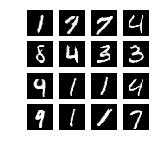

In [16]:
# train discriminator and adversarial networks
models = (generator, discriminator, adversarial)
params = (batch_size, latent_size, train_steps, model_name)
train(models, x_train, params)

In [17]:
def test_generator(generator):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,
                noise_input=noise_input,
                show=True,
                model_name="test_outputs")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


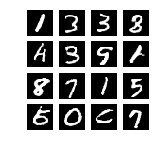

In [23]:
generator = load_model("dcgan_mnist-pre-trained.h5")
test_generator(generator)

In [ ]:
def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    # Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

In [ ]:
# test_noise_input = np.random.uniform(-1.0, 1.0, size=[1, 100])